<a href="https://colab.research.google.com/github/TarikKocak/DogBreedIdentificationUsingcnn-transformer/blob/main/dogbreedHybrid.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import tensorflow as tf
import tensorflow_hub as hub
print("GPU", "available" if tf.config.list_physical_devices("GPU") else "not available ")

GPU available


In [ ]:
import wandb
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
import os,cv2
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
from tqdm import tqdm
import torch
import torchvision
import torch.optim as optim
from torchvision import models
import torch.nn.functional as F
from einops import rearrange
import random


from torch.utils.data import Dataset, DataLoader, Subset
import math

IMG_SIZE = 224  # Resize images
BATCH_SIZE = 32
NUM_EPOCHS = 20
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
base_path='drive/MyDrive/data/cropped'

In [ ]:
import os
import cv2
import random
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader

class DogDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        file_path, label = self.data[idx]
        img = cv2.imread(file_path)
        img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = torch.from_numpy(img).permute(2, 0, 1).float()
        one_hot_label = np.eye(len(self.labels))[label - 1]
        one_hot_label = torch.from_numpy(one_hot_label).float()
        return img, one_hot_label

def load_and_split_data(base_path):
    labels = {}
    labels_r = {}
    idx = 0
    combined_data = []

    for folder in os.listdir(f'{base_path}/train'):
        folder_path = os.path.join(f'{base_path}/train', folder)
        if not os.path.isdir(folder_path):
            continue
        idx += 1
        labels[folder] = idx
        labels_r[idx] = folder
        print(f"Assigned label {idx} to folder '{folder}'")

        for file in os.listdir(folder_path):
            file_path = os.path.join(folder_path, file)
            combined_data.append((file_path, idx))

    for folder in os.listdir(f'{base_path}/test'):
        folder_path = os.path.join(f'{base_path}/test', folder)
        if not os.path.isdir(folder_path):
            continue
        label = labels.get(folder, None)
        if label is None:
            print(f"Skipping unknown folder '{folder}' in test data")
            continue

        for file in os.listdir(folder_path):
            file_path = os.path.join(folder_path, file)
            combined_data.append((file_path, label))

    random.shuffle(combined_data)

    num_parts = 10
    part_size = len(combined_data) // num_parts
    parts = [combined_data[i * part_size:(i + 1) * part_size] for i in range(num_parts)]

    return parts, labels, labels_r

def get_data_split(parts, val_index, test_indices, labels):
    num_parts = len(parts)
    val_index %= num_parts
    test_indices = [i % num_parts for i in test_indices]

    val_data = parts[val_index]
    test_data = [item for i in test_indices for item in parts[i]]
    train_indices = [i for i in range(num_parts) if i != val_index and i not in test_indices]
    train_data = [item for i in train_indices for item in parts[i]]

    train_dataset = DogDataset(train_data, labels)
    val_dataset = DogDataset(val_data, labels)
    test_dataset = DogDataset(test_data, labels)

    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

    return train_loader, val_loader, test_loader, train_data, val_data, test_data


In [ ]:
parts, labels, labels_r = load_and_split_data(base_path)

# Manually change which part is used for validation and testing to perform custom cross-validation.
val_index = 7
test_indices = [8, 9]

train_loader, val_loader, test_loader, train_data, val_data, test_data = get_data_split(parts, val_index, test_indices, labels)

Assigned label 1 to folder 'n02085620-Chihuahua'
Assigned label 2 to folder 'n02085782-Japanese_spaniel'
Assigned label 3 to folder 'n02085936-Maltese_dog'
Assigned label 4 to folder 'n02086079-Pekinese'
Assigned label 5 to folder 'n02086240-Shih-Tzu'
Assigned label 6 to folder 'n02086646-Blenheim_spaniel'
Assigned label 7 to folder 'n02086910-papillon'
Assigned label 8 to folder 'n02087046-toy_terrier'
Assigned label 9 to folder 'n02087394-Rhodesian_ridgeback'
Assigned label 10 to folder 'n02088094-Afghan_hound'
Assigned label 11 to folder 'n02088238-basset'
Assigned label 12 to folder 'n02088364-beagle'
Assigned label 13 to folder 'n02088466-bloodhound'
Assigned label 14 to folder 'n02088632-bluetick'
Assigned label 15 to folder 'n02089078-black-and-tan_coonhound'
Assigned label 16 to folder 'n02089867-Walker_hound'
Assigned label 17 to folder 'n02089973-English_foxhound'
Assigned label 18 to folder 'n02090379-redbone'
Assigned label 19 to folder 'n02090622-borzoi'
Assigned label 20 

In [ ]:
import timm

weight_path = "drive/MyDrive/xception.pt"

In [ ]:
class TransformerBlock(nn.Module):
    def __init__(self, dim, heads=8, ff_dim=2048, dropout=0.1):
        super().__init__()
        self.norm1 = nn.LayerNorm(dim)
        self.attn = nn.MultiheadAttention(embed_dim=dim, num_heads=heads, dropout=dropout, batch_first=True)
        self.norm2 = nn.LayerNorm(dim)
        self.ff = nn.Sequential(
            nn.Linear(dim, ff_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(ff_dim, dim)
        )

    def forward(self, x):
        x2, _ = self.attn(self.norm1(x), self.norm1(x), self.norm1(x))
        x = x + x2
        x2 = self.ff(self.norm2(x))
        return x + x2


def get_xception_feature_extractor(weight_path):
    # Load Xception model from timm
    model = timm.create_model('xception', pretrained=False)
    state_dict = torch.load(weight_path, map_location=torch.device('cpu'))  # adjust device if needed

    model.fc = nn.Identity()  # Removes the classification head

    model.load_state_dict(state_dict, strict=False)  # strict=False to ignore the 'fc' layer

    model.eval()

    for param in model.parameters():
        param.requires_grad = False

    return model


class CNNTransformerHybrid(nn.Module):
    def __init__(self, weight_path, num_classes=120, transformer_dim=2048, heads=8, ff_dim=4096, num_blocks=3):
        super().__init__()
        self.feature_extractor = get_xception_feature_extractor(weight_path)

        # Stack multiple Transformer blocks
        self.transformer_blocks = nn.Sequential(
            *[TransformerBlock(dim=transformer_dim, heads=heads, ff_dim=ff_dim) for _ in range(num_blocks)]
        )

        self.classifier = nn.Linear(transformer_dim, num_classes)

    def forward(self, x):
        with torch.no_grad():
            x = self.feature_extractor(x)  # [B, 2048, H, W] or [B, 2048]

        # Reshape to [B, HW, C] or [B, 1, C]
        if len(x.shape) == 4:
            b, c, h, w = x.shape
            x = rearrange(x, 'b c h w -> b (h w) c')
        else:
            b, c = x.shape
            x = rearrange(x, 'b c -> b 1 c')

        # Apply multiple transformer blocks
        x = self.transformer_blocks(x)

        # Global average pooling and classification
        x = x.mean(dim=1)
        return self.classifier(x)


In [ ]:
model = CNNTransformerHybrid(weight_path, num_classes=120, num_blocks=3)
model = model.to(DEVICE)

# Using Label Smoothing Loss
Label smoothing helps prevent overconfidence by softening the target labels.

✅ Why use it?

*   Improves generalization.
*   Helps with overfitting.
*   Encourages better calibration of predicted probabilities.




In [ ]:
class LabelSmoothingCrossEntropy(nn.Module):
    def __init__(self, smoothing=0.1):
        super().__init__()
        self.smoothing = smoothing
        self.confidence = 1.0 - smoothing

    def forward(self, pred, target):
        logprobs = F.log_softmax(pred, dim=-1)
        nll_loss = -logprobs.gather(dim=-1, index=target.unsqueeze(1)).squeeze(1)
        smooth_loss = -logprobs.mean(dim=-1)
        loss = self.confidence * nll_loss + self.smoothing * smooth_loss
        return loss.mean()  # ✅ Ensure scalar output

In [ ]:

class EarlyStopping:
    def __init__(self, patience=5, delta=0.0, model_name='model', save_dir='checkpoints/', verbose=True):
        self.patience = patience
        self.delta = delta
        self.model_name = model_name
        self.save_dir = save_dir
        self.verbose = verbose
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

        os.makedirs(self.save_dir, exist_ok=True)
        self.path = os.path.join(self.save_dir, f'{self.model_name}_best_model.pt')

    def __call__(self, val_loss, model):
        if self.best_loss is None or val_loss < self.best_loss - self.delta:
            self.best_loss = val_loss
            self.counter = 0
            self.save_checkpoint(model, val_loss)
        else:
            self.counter += 1
            if self.verbose:
                print(f"No improvement in validation loss for {self.counter}/{self.patience} epochs.")
            if self.counter >= self.patience:
                self.early_stop = True

    def save_checkpoint(self, model, val_loss):
        if self.verbose:
            print(f"Validation loss improved to {val_loss:.4f}. Saving model to {self.path}")
        torch.save(model.state_dict(), self.path)


def plot_history(history, save_path=None):
    epochs = range(1, len(history['train_loss']) + 1)
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, history['train_loss'], label='Train Loss')
    plt.plot(epochs, history['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss over Epochs')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, history['train_acc'], label='Train Accuracy')
    plt.plot(epochs, history['val_acc'], label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Accuracy over Epochs')
    plt.legend()

    plt.tight_layout()
    if save_path:
        plt.savefig(save_path)
        print(f"Training plot saved to {save_path}")
    plt.show()


def train_model(model, train_loader, val_loader, num_epochs, device, model_name='model',
                save_dir='checkpoints/', patience=5, lr=1e-4, debug=False):

    #criterion = nn.CrossEntropyLoss()
    criterion = LabelSmoothingCrossEntropy(smoothing=0.1)
    optimizer = optim.AdamW(model.parameters(), lr=lr)
    model = model.to(device)

    early_stopper = EarlyStopping(patience=patience, model_name=model_name, save_dir=save_dir, verbose=True)

    history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}

    for epoch in range(num_epochs):
        model.train()
        train_loss, train_correct, total_train = 0.0, 0, 0

        for imgs, labels in tqdm(train_loader, desc=f"[Epoch {epoch+1}/{num_epochs}] Training"):
            imgs, labels = imgs.to(device), labels.to(device)

            if labels.ndim > 1:  # Handle one-hot encoded labels
                labels = labels.argmax(dim=1)

            optimizer.zero_grad()
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * imgs.size(0)
            train_correct += (outputs.argmax(dim=1) == labels).sum().item()
            total_train += imgs.size(0)

        avg_train_loss = train_loss / total_train
        train_acc = train_correct / total_train

        model.eval()
        val_loss, val_correct, total_val = 0.0, 0, 0

        with torch.no_grad():
            for imgs, labels in tqdm(val_loader, desc=f"[Epoch {epoch+1}/{num_epochs}] Validation"):
                imgs, labels = imgs.to(device), labels.to(device)
                if labels.ndim > 1:
                    labels = labels.argmax(dim=1)

                outputs = model(imgs)
                loss = criterion(outputs, labels)

                val_loss += loss.item() * imgs.size(0)
                val_correct += (outputs.argmax(dim=1) == labels).sum().item()
                total_val += imgs.size(0)

        avg_val_loss = val_loss / total_val
        val_acc = val_correct / total_val

        history['train_loss'].append(avg_train_loss)
        history['val_loss'].append(avg_val_loss)
        history['train_acc'].append(train_acc)
        history['val_acc'].append(val_acc)

        print(f"Epoch {epoch+1} | Train Loss: {avg_train_loss:.4f}, Train Acc: {train_acc:.4f} | "
              f"Val Loss: {avg_val_loss:.4f}, Val Acc: {val_acc:.4f}")

        early_stopper(avg_val_loss, model)

        if early_stopper.early_stop:
            print("Early stopping triggered. Loading best model.")
            break

    # Load best model
    model.load_state_dict(torch.load(early_stopper.path))
    plot_history(history, save_path=os.path.join(save_dir, 'training_plot.png'))

    return model


In [ ]:
def evaluate_test(model, test_loader, criterion, device):
    model.eval()
    test_loss = 0.0
    test_correct = 0
    total = 0

    with torch.no_grad():
        for i, (imgs, labels) in enumerate(tqdm(test_loader, desc="Evaluating Test Set")):
            imgs, labels = imgs.to(device), labels.argmax(dim=1).to(device)
            outputs = model(imgs)
            loss = criterion(outputs, labels)

            test_loss += loss.item()
            test_correct += (outputs.argmax(dim=1) == labels).sum().item()
            total += labels.size(0)

    avg_test_loss = test_loss / len(test_loader)
    test_acc = test_correct / total

    print(f"Test Loss: {avg_test_loss:.4f}, Test Accuracy: {test_acc:.4f}")
    return avg_test_loss, test_acc

# Manual Data Split 1

*   1-...-7 parts for train
*   8 part for validation
*   9-10 parts for test

In [ ]:
trained_model = train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    num_epochs=NUM_EPOCHS,
    device=DEVICE,
    model_name='cnn_transformer_hybrid',
    save_dir='drive/MyDrive/',
    patience=10
)

[Epoch 1/20] Training:   0%|          | 0/451 [00:00<?, ?it/s]

In [ ]:
criterion = nn.CrossEntropyLoss()
test_loss, test_acc = evaluate_test(model, test_loader, criterion, DEVICE)

Evaluating Test Set:   2%|▏         | 2/129 [00:00<00:17,  7.15it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


Evaluating Test Set:   3%|▎         | 4/129 [00:00<00:18,  6.86it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


Evaluating Test Set:   4%|▍         | 5/129 [00:00<00:17,  7.13it/s]

torch.Size([32, 2048])


Evaluating Test Set:   5%|▍         | 6/129 [00:08<05:44,  2.80s/it]

torch.Size([32, 2048])


Evaluating Test Set:   5%|▌         | 7/129 [00:18<10:37,  5.23s/it]

torch.Size([32, 2048])


Evaluating Test Set:   6%|▌         | 8/129 [00:38<19:33,  9.70s/it]

torch.Size([32, 2048])


Evaluating Test Set:   7%|▋         | 9/129 [00:47<19:08,  9.57s/it]

torch.Size([32, 2048])


Evaluating Test Set:   8%|▊         | 10/129 [00:59<20:20, 10.26s/it]

torch.Size([32, 2048])


Evaluating Test Set:   9%|▊         | 11/129 [01:11<21:06, 10.74s/it]

torch.Size([32, 2048])


Evaluating Test Set:   9%|▉         | 12/129 [01:20<19:56, 10.22s/it]

torch.Size([32, 2048])


Evaluating Test Set:  10%|█         | 13/129 [01:37<23:40, 12.25s/it]

torch.Size([32, 2048])


Evaluating Test Set:  11%|█         | 14/129 [01:50<24:01, 12.53s/it]

torch.Size([32, 2048])


Evaluating Test Set:  12%|█▏        | 15/129 [02:00<22:45, 11.98s/it]

torch.Size([32, 2048])


Evaluating Test Set:  12%|█▏        | 16/129 [02:10<21:11, 11.25s/it]

torch.Size([32, 2048])


Evaluating Test Set:  13%|█▎        | 17/129 [02:20<20:11, 10.81s/it]

torch.Size([32, 2048])


Evaluating Test Set:  14%|█▍        | 18/129 [02:33<21:29, 11.62s/it]

torch.Size([32, 2048])


Evaluating Test Set:  15%|█▍        | 19/129 [02:45<21:20, 11.64s/it]

torch.Size([32, 2048])


Evaluating Test Set:  16%|█▌        | 20/129 [02:56<20:42, 11.39s/it]

torch.Size([32, 2048])


Evaluating Test Set:  16%|█▋        | 21/129 [03:12<23:10, 12.87s/it]

torch.Size([32, 2048])


Evaluating Test Set:  17%|█▋        | 22/129 [03:24<22:41, 12.72s/it]

torch.Size([32, 2048])


Evaluating Test Set:  18%|█▊        | 23/129 [03:33<20:30, 11.61s/it]

torch.Size([32, 2048])


Evaluating Test Set:  19%|█▊        | 24/129 [03:45<20:10, 11.53s/it]

torch.Size([32, 2048])


Evaluating Test Set:  19%|█▉        | 25/129 [03:56<19:54, 11.48s/it]

torch.Size([32, 2048])


Evaluating Test Set:  20%|██        | 26/129 [04:08<19:56, 11.62s/it]

torch.Size([32, 2048])


Evaluating Test Set:  21%|██        | 27/129 [04:23<21:37, 12.72s/it]

torch.Size([32, 2048])


Evaluating Test Set:  22%|██▏       | 28/129 [04:39<23:03, 13.69s/it]

torch.Size([32, 2048])


Evaluating Test Set:  22%|██▏       | 29/129 [04:51<21:58, 13.18s/it]

torch.Size([32, 2048])


Evaluating Test Set:  23%|██▎       | 30/129 [05:07<22:48, 13.82s/it]

torch.Size([32, 2048])


Evaluating Test Set:  24%|██▍       | 31/129 [05:22<23:07, 14.16s/it]

torch.Size([32, 2048])


Evaluating Test Set:  25%|██▍       | 32/129 [05:35<22:24, 13.86s/it]

torch.Size([32, 2048])


Evaluating Test Set:  26%|██▌       | 33/129 [05:48<22:03, 13.79s/it]

torch.Size([32, 2048])


Evaluating Test Set:  26%|██▋       | 34/129 [05:59<20:16, 12.80s/it]

torch.Size([32, 2048])


Evaluating Test Set:  27%|██▋       | 35/129 [06:13<20:36, 13.16s/it]

torch.Size([32, 2048])


Evaluating Test Set:  28%|██▊       | 36/129 [06:24<19:14, 12.41s/it]

torch.Size([32, 2048])


Evaluating Test Set:  29%|██▊       | 37/129 [06:35<18:40, 12.18s/it]

torch.Size([32, 2048])


Evaluating Test Set:  29%|██▉       | 38/129 [06:49<19:01, 12.55s/it]

torch.Size([32, 2048])


Evaluating Test Set:  30%|███       | 39/129 [06:58<17:20, 11.56s/it]

torch.Size([32, 2048])


Evaluating Test Set:  31%|███       | 40/129 [07:07<16:10, 10.91s/it]

torch.Size([32, 2048])


Evaluating Test Set:  32%|███▏      | 41/129 [07:17<15:37, 10.65s/it]

torch.Size([32, 2048])


Evaluating Test Set:  33%|███▎      | 42/129 [07:30<16:29, 11.37s/it]

torch.Size([32, 2048])


Evaluating Test Set:  33%|███▎      | 43/129 [07:45<17:42, 12.35s/it]

torch.Size([32, 2048])


Evaluating Test Set:  34%|███▍      | 44/129 [07:55<16:38, 11.75s/it]

torch.Size([32, 2048])


Evaluating Test Set:  35%|███▍      | 45/129 [08:11<18:15, 13.05s/it]

torch.Size([32, 2048])


Evaluating Test Set:  36%|███▌      | 46/129 [08:22<17:04, 12.34s/it]

torch.Size([32, 2048])


Evaluating Test Set:  36%|███▋      | 47/129 [08:34<16:38, 12.17s/it]

torch.Size([32, 2048])


Evaluating Test Set:  37%|███▋      | 48/129 [08:45<15:55, 11.79s/it]

torch.Size([32, 2048])


Evaluating Test Set:  38%|███▊      | 49/129 [08:56<15:37, 11.72s/it]

torch.Size([32, 2048])


Evaluating Test Set:  39%|███▉      | 50/129 [09:06<14:47, 11.23s/it]

torch.Size([32, 2048])


Evaluating Test Set:  40%|███▉      | 51/129 [09:16<14:06, 10.85s/it]

torch.Size([32, 2048])


Evaluating Test Set:  40%|████      | 52/129 [09:29<14:36, 11.38s/it]

torch.Size([32, 2048])


Evaluating Test Set:  41%|████      | 53/129 [09:41<14:44, 11.63s/it]

torch.Size([32, 2048])


Evaluating Test Set:  42%|████▏     | 54/129 [09:50<13:35, 10.87s/it]

torch.Size([32, 2048])


Evaluating Test Set:  43%|████▎     | 55/129 [10:01<13:14, 10.73s/it]

torch.Size([32, 2048])


Evaluating Test Set:  43%|████▎     | 56/129 [10:12<13:18, 10.94s/it]

torch.Size([32, 2048])


Evaluating Test Set:  44%|████▍     | 57/129 [10:21<12:27, 10.38s/it]

torch.Size([32, 2048])


Evaluating Test Set:  45%|████▍     | 58/129 [10:35<13:35, 11.49s/it]

torch.Size([32, 2048])


Evaluating Test Set:  46%|████▌     | 59/129 [10:48<13:56, 11.95s/it]

torch.Size([32, 2048])


Evaluating Test Set:  47%|████▋     | 60/129 [11:01<14:06, 12.27s/it]

torch.Size([32, 2048])


Evaluating Test Set:  47%|████▋     | 61/129 [11:14<14:08, 12.49s/it]

torch.Size([32, 2048])


Evaluating Test Set:  48%|████▊     | 62/129 [11:30<15:04, 13.50s/it]

torch.Size([32, 2048])


Evaluating Test Set:  49%|████▉     | 63/129 [11:42<14:20, 13.03s/it]

torch.Size([32, 2048])


Evaluating Test Set:  50%|████▉     | 64/129 [12:00<15:41, 14.48s/it]

torch.Size([32, 2048])


Evaluating Test Set:  50%|█████     | 65/129 [12:21<17:37, 16.52s/it]

torch.Size([32, 2048])


Evaluating Test Set:  51%|█████     | 66/129 [12:37<17:03, 16.25s/it]

torch.Size([32, 2048])


Evaluating Test Set:  52%|█████▏    | 67/129 [12:48<15:07, 14.64s/it]

torch.Size([32, 2048])


Evaluating Test Set:  53%|█████▎    | 68/129 [13:01<14:34, 14.33s/it]

torch.Size([32, 2048])


Evaluating Test Set:  53%|█████▎    | 69/129 [13:13<13:30, 13.50s/it]

torch.Size([32, 2048])


Evaluating Test Set:  54%|█████▍    | 70/129 [13:25<12:51, 13.08s/it]

torch.Size([32, 2048])


Evaluating Test Set:  55%|█████▌    | 71/129 [13:41<13:23, 13.85s/it]

torch.Size([32, 2048])


Evaluating Test Set:  56%|█████▌    | 72/129 [13:50<11:58, 12.60s/it]

torch.Size([32, 2048])


Evaluating Test Set:  57%|█████▋    | 73/129 [14:02<11:36, 12.43s/it]

torch.Size([32, 2048])


Evaluating Test Set:  57%|█████▋    | 74/129 [14:14<11:10, 12.18s/it]

torch.Size([32, 2048])


Evaluating Test Set:  58%|█████▊    | 75/129 [14:23<10:05, 11.21s/it]

torch.Size([32, 2048])


Evaluating Test Set:  59%|█████▉    | 76/129 [14:37<10:31, 11.92s/it]

torch.Size([32, 2048])


Evaluating Test Set:  60%|█████▉    | 77/129 [14:55<11:59, 13.83s/it]

torch.Size([32, 2048])


Evaluating Test Set:  60%|██████    | 78/129 [15:12<12:29, 14.70s/it]

torch.Size([32, 2048])


Evaluating Test Set:  61%|██████    | 79/129 [15:22<11:16, 13.52s/it]

torch.Size([32, 2048])


Evaluating Test Set:  62%|██████▏   | 80/129 [15:36<11:02, 13.52s/it]

torch.Size([32, 2048])


Evaluating Test Set:  63%|██████▎   | 81/129 [15:48<10:24, 13.02s/it]

torch.Size([32, 2048])


Evaluating Test Set:  64%|██████▎   | 82/129 [16:00<10:07, 12.92s/it]

torch.Size([32, 2048])


Evaluating Test Set:  64%|██████▍   | 83/129 [16:10<09:06, 11.88s/it]

torch.Size([32, 2048])


Evaluating Test Set:  65%|██████▌   | 84/129 [16:20<08:27, 11.27s/it]

torch.Size([32, 2048])


Evaluating Test Set:  66%|██████▌   | 85/129 [16:36<09:20, 12.74s/it]

torch.Size([32, 2048])


Evaluating Test Set:  67%|██████▋   | 86/129 [16:59<11:26, 15.98s/it]

torch.Size([32, 2048])


Evaluating Test Set:  67%|██████▋   | 87/129 [17:09<09:52, 14.10s/it]

torch.Size([32, 2048])


Evaluating Test Set:  68%|██████▊   | 88/129 [17:19<08:46, 12.83s/it]

torch.Size([32, 2048])


Evaluating Test Set:  69%|██████▉   | 89/129 [17:32<08:40, 13.01s/it]

torch.Size([32, 2048])


Evaluating Test Set:  70%|██████▉   | 90/129 [17:49<09:11, 14.15s/it]

torch.Size([32, 2048])


Evaluating Test Set:  71%|███████   | 91/129 [18:05<09:10, 14.49s/it]

torch.Size([32, 2048])


Evaluating Test Set:  71%|███████▏  | 92/129 [18:15<08:15, 13.39s/it]

torch.Size([32, 2048])


Evaluating Test Set:  72%|███████▏  | 93/129 [18:29<08:03, 13.44s/it]

torch.Size([32, 2048])


Evaluating Test Set:  73%|███████▎  | 94/129 [18:40<07:22, 12.65s/it]

torch.Size([32, 2048])


Evaluating Test Set:  74%|███████▎  | 95/129 [18:57<07:54, 13.96s/it]

torch.Size([32, 2048])


Evaluating Test Set:  74%|███████▍  | 96/129 [19:09<07:23, 13.44s/it]

torch.Size([32, 2048])


Evaluating Test Set:  75%|███████▌  | 97/129 [19:27<07:55, 14.85s/it]

torch.Size([32, 2048])


Evaluating Test Set:  76%|███████▌  | 98/129 [19:36<06:49, 13.20s/it]

torch.Size([32, 2048])


Evaluating Test Set:  77%|███████▋  | 99/129 [19:46<06:06, 12.23s/it]

torch.Size([32, 2048])


Evaluating Test Set:  78%|███████▊  | 100/129 [19:56<05:30, 11.41s/it]

torch.Size([32, 2048])


Evaluating Test Set:  78%|███████▊  | 101/129 [20:06<05:06, 10.95s/it]

torch.Size([32, 2048])


Evaluating Test Set:  79%|███████▉  | 102/129 [20:17<04:54, 10.90s/it]

torch.Size([32, 2048])


Evaluating Test Set:  80%|███████▉  | 103/129 [20:32<05:16, 12.16s/it]

torch.Size([32, 2048])


Evaluating Test Set:  81%|████████  | 104/129 [20:43<04:54, 11.78s/it]

torch.Size([32, 2048])


Evaluating Test Set:  81%|████████▏ | 105/129 [20:55<04:48, 12.04s/it]

torch.Size([32, 2048])


Evaluating Test Set:  82%|████████▏ | 106/129 [21:06<04:27, 11.63s/it]

torch.Size([32, 2048])


Evaluating Test Set:  83%|████████▎ | 107/129 [21:18<04:17, 11.68s/it]

torch.Size([32, 2048])


Evaluating Test Set:  84%|████████▎ | 108/129 [21:38<05:02, 14.40s/it]

torch.Size([32, 2048])


Evaluating Test Set:  84%|████████▍ | 109/129 [21:51<04:37, 13.88s/it]

torch.Size([32, 2048])


Evaluating Test Set:  85%|████████▌ | 110/129 [22:01<04:03, 12.84s/it]

torch.Size([32, 2048])


Evaluating Test Set:  86%|████████▌ | 111/129 [22:16<04:02, 13.49s/it]

torch.Size([32, 2048])


Evaluating Test Set:  87%|████████▋ | 112/129 [22:29<03:44, 13.20s/it]

torch.Size([32, 2048])


Evaluating Test Set:  88%|████████▊ | 113/129 [22:38<03:12, 12.05s/it]

torch.Size([32, 2048])


Evaluating Test Set:  88%|████████▊ | 114/129 [22:54<03:15, 13.05s/it]

torch.Size([32, 2048])


Evaluating Test Set:  89%|████████▉ | 115/129 [23:05<02:54, 12.46s/it]

torch.Size([32, 2048])


Evaluating Test Set:  90%|████████▉ | 116/129 [23:17<02:39, 12.26s/it]

torch.Size([32, 2048])


Evaluating Test Set:  91%|█████████ | 117/129 [23:26<02:18, 11.51s/it]

torch.Size([32, 2048])


Evaluating Test Set:  91%|█████████▏| 118/129 [23:39<02:10, 11.85s/it]

torch.Size([32, 2048])


Evaluating Test Set:  92%|█████████▏| 119/129 [23:48<01:51, 11.12s/it]

torch.Size([32, 2048])


Evaluating Test Set:  93%|█████████▎| 120/129 [24:03<01:50, 12.23s/it]

torch.Size([32, 2048])


Evaluating Test Set:  94%|█████████▍| 121/129 [24:18<01:44, 13.09s/it]

torch.Size([32, 2048])


Evaluating Test Set:  95%|█████████▍| 122/129 [24:30<01:28, 12.64s/it]

torch.Size([32, 2048])


Evaluating Test Set:  95%|█████████▌| 123/129 [24:47<01:24, 14.07s/it]

torch.Size([32, 2048])


Evaluating Test Set:  96%|█████████▌| 124/129 [24:57<01:04, 12.86s/it]

torch.Size([32, 2048])


Evaluating Test Set:  97%|█████████▋| 125/129 [25:12<00:53, 13.37s/it]

torch.Size([32, 2048])


Evaluating Test Set:  98%|█████████▊| 126/129 [25:21<00:36, 12.21s/it]

torch.Size([32, 2048])


Evaluating Test Set:  98%|█████████▊| 127/129 [25:31<00:22, 11.42s/it]

torch.Size([32, 2048])


Evaluating Test Set:  99%|█████████▉| 128/129 [25:49<00:13, 13.28s/it]

torch.Size([32, 2048])


Evaluating Test Set: 100%|██████████| 129/129 [25:58<00:00, 12.08s/it]

torch.Size([20, 2048])
Test Loss: 0.2907, Test Accuracy: 0.9325


# Manual Data Split 2

*   3rd-...-9th parts for train
*   10th part for validation
*   1st and 2nd parts for test

[Epoch 1/20] Training:   0%|          | 1/451 [00:08<1:05:48,  8.77s/it]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 1/20] Training:   1%|          | 3/451 [00:16<38:18,  5.13s/it]  

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 1/20] Training:   1%|          | 5/451 [00:24<34:16,  4.61s/it]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 1/20] Training:   2%|▏         | 7/451 [00:33<33:04,  4.47s/it]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 1/20] Training:   2%|▏         | 9/451 [00:41<31:58,  4.34s/it]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 1/20] Training:   2%|▏         | 11/451 [00:49<30:18,  4.13s/it]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 1/20] Training:   3%|▎         | 13/451 [00:57<30:29,  4.18s/it]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 1/20] Training:   3%|▎         | 15/451 [01:04<29:12,  4.02s/it]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 1/20] Training:   4%|▍         | 17/451 [01:13<29:08,  4.03s/it]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 1/20] Training:   4%|▍         | 19/451 [01:20<28:18,  3.93s/it]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 1/20] Training:   5%|▍         | 21/451 [01:28<27:57,  3.90s/it]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 1/20] Training:   5%|▌         | 23/451 [02:13<1:08:32,  9.61s/it]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 1/20] Training:   6%|▌         | 25/451 [02:21<55:53,  7.87s/it]  

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 1/20] Training:   6%|▌         | 27/451 [02:28<47:02,  6.66s/it]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 1/20] Training:   6%|▋         | 29/451 [02:37<41:31,  5.91s/it]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 1/20] Training:   7%|▋         | 31/451 [02:44<36:53,  5.27s/it]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 1/20] Training:   7%|▋         | 33/451 [02:52<34:10,  4.91s/it]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 1/20] Training:   8%|▊         | 35/451 [03:00<31:55,  4.60s/it]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 1/20] Training:   8%|▊         | 37/451 [03:07<29:40,  4.30s/it]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 1/20] Training:   9%|▊         | 39/451 [03:15<28:31,  4.15s/it]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 1/20] Training:   9%|▉         | 41/451 [03:22<27:03,  3.96s/it]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 1/20] Training:  10%|▉         | 43/451 [03:29<25:44,  3.79s/it]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 1/20] Training:  10%|▉         | 45/451 [03:36<25:17,  3.74s/it]

torch.Size([32, 2048])


[Epoch 1/20] Training:  10%|█         | 46/451 [03:36<21:01,  3.11s/it]

torch.Size([32, 2048])


[Epoch 1/20] Training:  10%|█         | 47/451 [03:42<24:54,  3.70s/it]

torch.Size([32, 2048])


[Epoch 1/20] Training:  11%|█         | 48/451 [03:44<21:50,  3.25s/it]

torch.Size([32, 2048])


[Epoch 1/20] Training:  11%|█         | 49/451 [03:50<26:05,  3.89s/it]

torch.Size([32, 2048])


[Epoch 1/20] Training:  11%|█         | 50/451 [03:52<23:37,  3.54s/it]

torch.Size([32, 2048])


[Epoch 1/20] Training:  11%|█▏        | 51/451 [03:57<26:14,  3.94s/it]

torch.Size([32, 2048])


[Epoch 1/20] Training:  12%|█▏        | 52/451 [04:00<23:00,  3.46s/it]

torch.Size([32, 2048])


[Epoch 1/20] Training:  12%|█▏        | 53/451 [04:04<24:23,  3.68s/it]

torch.Size([32, 2048])


[Epoch 1/20] Training:  12%|█▏        | 54/451 [04:07<23:45,  3.59s/it]

torch.Size([32, 2048])


[Epoch 1/20] Training:  12%|█▏        | 55/451 [04:11<24:06,  3.65s/it]

torch.Size([32, 2048])


[Epoch 1/20] Training:  12%|█▏        | 56/451 [04:15<24:38,  3.74s/it]

torch.Size([32, 2048])


[Epoch 1/20] Training:  13%|█▎        | 57/451 [04:19<25:34,  3.89s/it]

torch.Size([32, 2048])


[Epoch 1/20] Training:  13%|█▎        | 58/451 [04:23<25:11,  3.85s/it]

torch.Size([32, 2048])


[Epoch 1/20] Training:  13%|█▎        | 59/451 [04:26<23:55,  3.66s/it]

torch.Size([32, 2048])


[Epoch 1/20] Training:  13%|█▎        | 60/451 [04:30<23:58,  3.68s/it]

torch.Size([32, 2048])


[Epoch 1/20] Training:  14%|█▎        | 61/451 [04:34<24:18,  3.74s/it]

torch.Size([32, 2048])


[Epoch 1/20] Training:  14%|█▎        | 62/451 [04:37<23:39,  3.65s/it]

torch.Size([32, 2048])


[Epoch 1/20] Training:  14%|█▍        | 63/451 [04:42<25:06,  3.88s/it]

torch.Size([32, 2048])


[Epoch 1/20] Training:  14%|█▍        | 64/451 [04:44<22:35,  3.50s/it]

torch.Size([32, 2048])


[Epoch 1/20] Training:  14%|█▍        | 65/451 [04:49<25:30,  3.97s/it]

torch.Size([32, 2048])


[Epoch 1/20] Training:  15%|█▍        | 66/451 [04:52<22:56,  3.58s/it]

torch.Size([32, 2048])


[Epoch 1/20] Training:  15%|█▍        | 67/451 [04:58<27:05,  4.23s/it]

torch.Size([32, 2048])


[Epoch 1/20] Training:  15%|█▌        | 68/451 [05:00<22:25,  3.51s/it]

torch.Size([32, 2048])


[Epoch 1/20] Training:  15%|█▌        | 69/451 [05:05<26:39,  4.19s/it]

torch.Size([32, 2048])


[Epoch 1/20] Training:  16%|█▌        | 70/451 [05:07<20:54,  3.29s/it]

torch.Size([32, 2048])


[Epoch 1/20] Training:  16%|█▌        | 71/451 [05:13<26:57,  4.26s/it]

torch.Size([32, 2048])


[Epoch 1/20] Training:  16%|█▌        | 72/451 [05:15<21:40,  3.43s/it]

torch.Size([32, 2048])


[Epoch 1/20] Training:  16%|█▌        | 73/451 [05:21<26:37,  4.23s/it]

torch.Size([32, 2048])


[Epoch 1/20] Training:  16%|█▋        | 74/451 [05:22<21:58,  3.50s/it]

torch.Size([32, 2048])


[Epoch 1/20] Training:  17%|█▋        | 75/451 [05:27<23:36,  3.77s/it]

torch.Size([32, 2048])


[Epoch 1/20] Training:  17%|█▋        | 76/451 [05:30<22:15,  3.56s/it]

torch.Size([32, 2048])


[Epoch 1/20] Training:  17%|█▋        | 77/451 [05:35<24:54,  4.00s/it]

torch.Size([32, 2048])


[Epoch 1/20] Training:  17%|█▋        | 78/451 [05:36<19:20,  3.11s/it]

torch.Size([32, 2048])


[Epoch 1/20] Training:  18%|█▊        | 79/451 [05:43<25:53,  4.17s/it]

torch.Size([32, 2048])


[Epoch 1/20] Training:  18%|█▊        | 80/451 [05:43<18:29,  2.99s/it]

torch.Size([32, 2048])


[Epoch 1/20] Training:  18%|█▊        | 81/451 [05:50<25:50,  4.19s/it]

torch.Size([32, 2048])


[Epoch 1/20] Training:  18%|█▊        | 82/451 [05:51<20:33,  3.34s/it]

torch.Size([32, 2048])


[Epoch 1/20] Training:  18%|█▊        | 83/451 [05:58<26:29,  4.32s/it]

torch.Size([32, 2048])


[Epoch 1/20] Training:  19%|█▊        | 84/451 [05:59<20:04,  3.28s/it]

torch.Size([32, 2048])


[Epoch 1/20] Training:  19%|█▉        | 85/451 [06:06<28:05,  4.61s/it]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 1/20] Training:  19%|█▉        | 87/451 [06:14<26:06,  4.30s/it]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 1/20] Training:  20%|█▉        | 89/451 [06:22<24:57,  4.14s/it]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 1/20] Training:  20%|██        | 91/451 [06:30<24:10,  4.03s/it]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 1/20] Training:  21%|██        | 93/451 [06:38<24:12,  4.06s/it]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 1/20] Training:  21%|██        | 95/451 [06:47<24:38,  4.15s/it]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 1/20] Training:  22%|██▏       | 97/451 [06:54<24:04,  4.08s/it]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 1/20] Training:  22%|██▏       | 99/451 [07:02<23:21,  3.98s/it]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 1/20] Training:  22%|██▏       | 101/451 [07:10<23:02,  3.95s/it]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 1/20] Training:  23%|██▎       | 103/451 [07:19<23:52,  4.12s/it]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 1/20] Training:  23%|██▎       | 105/451 [07:26<22:57,  3.98s/it]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 1/20] Training:  24%|██▎       | 107/451 [07:35<23:19,  4.07s/it]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 1/20] Training:  24%|██▍       | 109/451 [07:42<22:49,  4.00s/it]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 1/20] Training:  25%|██▍       | 111/451 [07:49<21:35,  3.81s/it]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 1/20] Training:  25%|██▌       | 113/451 [07:57<21:24,  3.80s/it]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 1/20] Training:  25%|██▌       | 115/451 [08:04<20:50,  3.72s/it]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 1/20] Training:  26%|██▌       | 117/451 [08:13<22:00,  3.95s/it]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 1/20] Training:  26%|██▋       | 119/451 [08:21<21:57,  3.97s/it]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 1/20] Training:  27%|██▋       | 121/451 [08:29<22:11,  4.03s/it]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 1/20] Training:  27%|██▋       | 123/451 [08:37<21:48,  3.99s/it]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 1/20] Training:  28%|██▊       | 125/451 [08:44<20:59,  3.86s/it]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 1/20] Training:  28%|██▊       | 127/451 [08:52<21:00,  3.89s/it]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 1/20] Training:  29%|██▊       | 129/451 [08:59<20:24,  3.80s/it]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 1/20] Training:  29%|██▉       | 131/451 [09:09<21:45,  4.08s/it]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 1/20] Training:  29%|██▉       | 133/451 [09:24<27:21,  5.16s/it]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 1/20] Training:  30%|██▉       | 135/451 [09:36<28:38,  5.44s/it]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 1/20] Training:  30%|███       | 137/451 [09:44<25:55,  4.95s/it]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 1/20] Training:  31%|███       | 139/451 [09:51<24:02,  4.62s/it]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 1/20] Training:  31%|███▏      | 141/451 [09:59<22:50,  4.42s/it]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 1/20] Training:  32%|███▏      | 143/451 [10:08<22:15,  4.34s/it]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 1/20] Training:  32%|███▏      | 145/451 [10:15<21:04,  4.13s/it]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 1/20] Training:  33%|███▎      | 147/451 [10:23<21:09,  4.18s/it]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 1/20] Training:  33%|███▎      | 149/451 [10:31<20:40,  4.11s/it]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 1/20] Training:  33%|███▎      | 151/451 [10:39<20:04,  4.01s/it]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 1/20] Training:  34%|███▍      | 153/451 [10:47<19:45,  3.98s/it]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 1/20] Training:  34%|███▍      | 155/451 [10:56<20:18,  4.12s/it]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 1/20] Training:  35%|███▍      | 157/451 [11:02<19:04,  3.89s/it]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 1/20] Training:  35%|███▌      | 159/451 [11:11<19:31,  4.01s/it]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 1/20] Training:  36%|███▌      | 161/451 [11:17<18:11,  3.76s/it]

torch.Size([32, 2048])


[Epoch 1/20] Training:  36%|███▌      | 162/451 [11:18<15:44,  3.27s/it]

torch.Size([32, 2048])


[Epoch 1/20] Training:  36%|███▌      | 163/451 [11:26<19:58,  4.16s/it]

torch.Size([32, 2048])


[Epoch 1/20] Training:  36%|███▋      | 164/451 [11:26<15:41,  3.28s/it]

torch.Size([32, 2048])


[Epoch 1/20] Training:  37%|███▋      | 165/451 [11:34<20:27,  4.29s/it]

torch.Size([32, 2048])


[Epoch 1/20] Training:  37%|███▋      | 166/451 [11:34<15:30,  3.26s/it]

torch.Size([32, 2048])


[Epoch 1/20] Training:  37%|███▋      | 167/451 [11:41<20:31,  4.34s/it]

torch.Size([32, 2048])


[Epoch 1/20] Training:  37%|███▋      | 168/451 [11:42<15:43,  3.33s/it]

torch.Size([32, 2048])


[Epoch 1/20] Training:  37%|███▋      | 169/451 [11:49<20:27,  4.35s/it]

torch.Size([32, 2048])


[Epoch 1/20] Training:  38%|███▊      | 170/451 [11:50<16:01,  3.42s/it]

torch.Size([32, 2048])


[Epoch 1/20] Training:  38%|███▊      | 171/451 [11:57<20:40,  4.43s/it]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 1/20] Training:  38%|███▊      | 173/451 [12:05<19:29,  4.21s/it]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 1/20] Training:  39%|███▉      | 175/451 [12:13<18:54,  4.11s/it]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 1/20] Training:  39%|███▉      | 177/451 [12:20<17:56,  3.93s/it]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 1/20] Training:  40%|███▉      | 179/451 [12:27<16:57,  3.74s/it]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 1/20] Training:  40%|████      | 181/451 [12:35<17:29,  3.89s/it]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 1/20] Training:  41%|████      | 183/451 [12:42<17:05,  3.83s/it]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 1/20] Training:  41%|████      | 185/451 [12:50<17:06,  3.86s/it]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 1/20] Training:  41%|████▏     | 187/451 [12:58<17:15,  3.92s/it]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 1/20] Training:  42%|████▏     | 189/451 [13:06<17:00,  3.90s/it]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 1/20] Training:  42%|████▏     | 191/451 [13:13<16:30,  3.81s/it]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 1/20] Training:  43%|████▎     | 193/451 [13:19<15:20,  3.57s/it]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 1/20] Training:  43%|████▎     | 195/451 [13:27<15:20,  3.60s/it]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 1/20] Training:  44%|████▎     | 197/451 [13:34<15:14,  3.60s/it]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 1/20] Training:  44%|████▍     | 199/451 [13:42<15:47,  3.76s/it]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 1/20] Training:  45%|████▍     | 201/451 [13:49<15:31,  3.73s/it]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 1/20] Training:  45%|████▌     | 203/451 [13:56<15:10,  3.67s/it]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 1/20] Training:  45%|████▌     | 205/451 [14:45<40:12,  9.81s/it]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 1/20] Training:  46%|████▌     | 207/451 [14:52<32:32,  8.00s/it]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 1/20] Training:  46%|████▋     | 209/451 [15:00<27:12,  6.74s/it]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 1/20] Training:  47%|████▋     | 211/451 [15:07<23:21,  5.84s/it]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 1/20] Training:  47%|████▋     | 213/451 [15:15<20:35,  5.19s/it]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 1/20] Training:  48%|████▊     | 215/451 [15:22<18:34,  4.72s/it]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 1/20] Training:  48%|████▊     | 217/451 [15:30<17:34,  4.51s/it]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 1/20] Training:  49%|████▊     | 219/451 [15:37<16:24,  4.24s/it]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 1/20] Training:  49%|████▉     | 221/451 [15:45<15:50,  4.13s/it]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 1/20] Training:  49%|████▉     | 223/451 [15:53<15:19,  4.03s/it]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 1/20] Training:  50%|████▉     | 225/451 [16:00<15:01,  3.99s/it]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 1/20] Training:  50%|█████     | 227/451 [16:09<15:12,  4.07s/it]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 1/20] Training:  51%|█████     | 229/451 [16:17<14:48,  4.00s/it]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 1/20] Training:  51%|█████     | 231/451 [16:24<14:37,  3.99s/it]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 1/20] Training:  52%|█████▏    | 233/451 [16:33<14:55,  4.11s/it]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 1/20] Training:  52%|█████▏    | 235/451 [16:41<14:22,  3.99s/it]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 1/20] Training:  53%|█████▎    | 237/451 [16:49<14:14,  3.99s/it]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 1/20] Training:  53%|█████▎    | 239/451 [16:56<13:47,  3.91s/it]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 1/20] Training:  53%|█████▎    | 241/451 [17:04<13:29,  3.85s/it]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 1/20] Training:  54%|█████▍    | 243/451 [17:10<12:41,  3.66s/it]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 1/20] Training:  54%|█████▍    | 245/451 [17:18<12:47,  3.72s/it]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 1/20] Training:  55%|█████▍    | 247/451 [17:26<13:00,  3.83s/it]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 1/20] Training:  55%|█████▌    | 249/451 [17:33<12:33,  3.73s/it]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 1/20] Training:  56%|█████▌    | 251/451 [17:41<12:33,  3.77s/it]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 1/20] Training:  56%|█████▌    | 253/451 [17:48<12:08,  3.68s/it]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 1/20] Training:  57%|█████▋    | 255/451 [17:55<12:08,  3.72s/it]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 1/20] Training:  57%|█████▋    | 257/451 [18:02<11:54,  3.68s/it]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 1/20] Training:  57%|█████▋    | 259/451 [18:10<12:03,  3.77s/it]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 1/20] Training:  58%|█████▊    | 261/451 [18:18<12:09,  3.84s/it]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 1/20] Training:  58%|█████▊    | 263/451 [18:26<12:10,  3.88s/it]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 1/20] Training:  59%|█████▉    | 265/451 [18:34<12:03,  3.89s/it]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 1/20] Training:  59%|█████▉    | 267/451 [18:42<11:47,  3.84s/it]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 1/20] Training:  60%|█████▉    | 269/451 [18:50<11:55,  3.93s/it]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 1/20] Training:  60%|██████    | 271/451 [19:01<13:06,  4.37s/it]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 1/20] Training:  61%|██████    | 273/451 [19:09<12:39,  4.27s/it]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 1/20] Training:  61%|██████    | 275/451 [19:16<12:09,  4.15s/it]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 1/20] Training:  61%|██████▏   | 277/451 [19:23<11:29,  3.96s/it]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 1/20] Training:  62%|██████▏   | 279/451 [19:31<11:15,  3.93s/it]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 1/20] Training:  62%|██████▏   | 281/451 [19:39<11:13,  3.96s/it]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 1/20] Training:  63%|██████▎   | 283/451 [19:46<10:43,  3.83s/it]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 1/20] Training:  63%|██████▎   | 285/451 [19:53<10:13,  3.70s/it]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 1/20] Training:  64%|██████▎   | 287/451 [20:00<09:51,  3.61s/it]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 1/20] Training:  64%|██████▍   | 289/451 [20:08<09:59,  3.70s/it]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 1/20] Training:  65%|██████▍   | 291/451 [20:15<09:52,  3.71s/it]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 1/20] Training:  65%|██████▍   | 293/451 [20:22<09:44,  3.70s/it]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 1/20] Training:  65%|██████▌   | 295/451 [20:30<09:31,  3.66s/it]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 1/20] Training:  66%|██████▌   | 297/451 [20:37<09:24,  3.66s/it]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 1/20] Training:  66%|██████▋   | 299/451 [20:44<09:15,  3.65s/it]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 1/20] Training:  67%|██████▋   | 301/451 [20:52<09:16,  3.71s/it]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 1/20] Training:  67%|██████▋   | 303/451 [20:59<09:12,  3.73s/it]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 1/20] Training:  68%|██████▊   | 305/451 [21:07<09:01,  3.71s/it]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 1/20] Training:  68%|██████▊   | 307/451 [21:14<08:54,  3.71s/it]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 1/20] Training:  69%|██████▊   | 309/451 [21:22<08:52,  3.75s/it]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 1/20] Training:  69%|██████▉   | 311/451 [21:30<08:55,  3.82s/it]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 1/20] Training:  69%|██████▉   | 313/451 [21:37<08:31,  3.71s/it]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 1/20] Training:  70%|██████▉   | 315/451 [21:44<08:20,  3.68s/it]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 1/20] Training:  70%|███████   | 317/451 [21:51<08:15,  3.70s/it]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 1/20] Training:  71%|███████   | 319/451 [21:59<08:03,  3.66s/it]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 1/20] Training:  71%|███████   | 321/451 [22:06<07:48,  3.60s/it]

torch.Size([32, 2048])


[Epoch 1/20] Training:  71%|███████▏  | 322/451 [22:06<06:28,  3.02s/it]

torch.Size([32, 2048])


[Epoch 1/20] Training:  72%|███████▏  | 323/451 [22:13<08:15,  3.87s/it]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 1/20] Training:  72%|███████▏  | 325/451 [22:20<07:56,  3.79s/it]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 1/20] Training:  73%|███████▎  | 327/451 [22:28<07:49,  3.79s/it]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 1/20] Training:  73%|███████▎  | 329/451 [22:35<07:39,  3.76s/it]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 1/20] Training:  73%|███████▎  | 331/451 [22:43<07:33,  3.78s/it]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 1/20] Training:  74%|███████▍  | 333/451 [22:51<07:30,  3.81s/it]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 1/20] Training:  74%|███████▍  | 335/451 [22:59<07:29,  3.87s/it]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 1/20] Training:  75%|███████▍  | 337/451 [23:11<08:40,  4.57s/it]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 1/20] Training:  75%|███████▌  | 339/451 [23:19<08:12,  4.40s/it]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 1/20] Training:  76%|███████▌  | 341/451 [23:26<07:34,  4.13s/it]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 1/20] Training:  76%|███████▌  | 343/451 [23:34<07:14,  4.02s/it]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 1/20] Training:  76%|███████▋  | 345/451 [23:40<06:43,  3.81s/it]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 1/20] Training:  77%|███████▋  | 347/451 [23:48<06:44,  3.89s/it]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 1/20] Training:  77%|███████▋  | 349/451 [23:56<06:31,  3.84s/it]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 1/20] Training:  78%|███████▊  | 351/451 [24:04<06:27,  3.88s/it]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 1/20] Training:  78%|███████▊  | 353/451 [24:11<06:10,  3.78s/it]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 1/20] Training:  79%|███████▊  | 355/451 [24:19<06:12,  3.88s/it]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 1/20] Training:  79%|███████▉  | 357/451 [24:27<06:03,  3.87s/it]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 1/20] Training:  80%|███████▉  | 359/451 [24:34<05:43,  3.73s/it]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 1/20] Training:  80%|████████  | 361/451 [24:41<05:36,  3.74s/it]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 1/20] Training:  80%|████████  | 363/451 [24:48<05:20,  3.64s/it]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 1/20] Training:  81%|████████  | 365/451 [24:55<05:13,  3.65s/it]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 1/20] Training:  81%|████████▏ | 367/451 [25:02<04:59,  3.57s/it]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 1/20] Training:  82%|████████▏ | 369/451 [25:10<04:56,  3.61s/it]

torch.Size([32, 2048])


[Epoch 1/20] Training:  82%|████████▏ | 370/451 [25:12<04:41,  3.48s/it]

torch.Size([32, 2048])


[Epoch 1/20] Training:  82%|████████▏ | 371/451 [25:17<04:51,  3.64s/it]

torch.Size([32, 2048])


[Epoch 1/20] Training:  82%|████████▏ | 372/451 [25:21<04:51,  3.69s/it]

torch.Size([32, 2048])


[Epoch 1/20] Training:  83%|████████▎ | 373/451 [25:24<04:36,  3.55s/it]

torch.Size([32, 2048])


[Epoch 1/20] Training:  83%|████████▎ | 374/451 [25:28<04:46,  3.72s/it]

torch.Size([32, 2048])


[Epoch 1/20] Training:  83%|████████▎ | 375/451 [25:30<04:14,  3.34s/it]

torch.Size([32, 2048])


[Epoch 1/20] Training:  83%|████████▎ | 376/451 [25:36<05:00,  4.00s/it]

torch.Size([32, 2048])


[Epoch 1/20] Training:  84%|████████▎ | 377/451 [25:39<04:32,  3.69s/it]

torch.Size([32, 2048])


[Epoch 1/20] Training:  84%|████████▍ | 378/451 [25:43<04:46,  3.93s/it]

torch.Size([32, 2048])


[Epoch 1/20] Training:  84%|████████▍ | 379/451 [25:46<04:16,  3.56s/it]

torch.Size([32, 2048])


[Epoch 1/20] Training:  84%|████████▍ | 380/451 [25:51<04:33,  3.85s/it]

torch.Size([32, 2048])


[Epoch 1/20] Training:  84%|████████▍ | 381/451 [25:54<04:28,  3.84s/it]

torch.Size([32, 2048])


[Epoch 1/20] Training:  85%|████████▍ | 382/451 [25:57<04:10,  3.63s/it]

torch.Size([32, 2048])


[Epoch 1/20] Training:  85%|████████▍ | 383/451 [26:02<04:19,  3.81s/it]

torch.Size([32, 2048])


[Epoch 1/20] Training:  85%|████████▌ | 384/451 [26:05<04:05,  3.67s/it]

torch.Size([32, 2048])


[Epoch 1/20] Training:  85%|████████▌ | 385/451 [26:10<04:25,  4.03s/it]

torch.Size([32, 2048])


[Epoch 1/20] Training:  86%|████████▌ | 386/451 [26:13<03:58,  3.66s/it]

torch.Size([32, 2048])


[Epoch 1/20] Training:  86%|████████▌ | 387/451 [26:17<04:10,  3.91s/it]

torch.Size([32, 2048])


[Epoch 1/20] Training:  86%|████████▌ | 388/451 [26:20<03:46,  3.59s/it]

torch.Size([32, 2048])


[Epoch 1/20] Training:  86%|████████▋ | 389/451 [26:25<04:04,  3.94s/it]

torch.Size([32, 2048])


[Epoch 1/20] Training:  86%|████████▋ | 390/451 [26:28<03:39,  3.60s/it]

torch.Size([32, 2048])


[Epoch 1/20] Training:  87%|████████▋ | 391/451 [26:33<04:03,  4.06s/it]

torch.Size([32, 2048])


[Epoch 1/20] Training:  87%|████████▋ | 392/451 [26:36<03:38,  3.70s/it]

torch.Size([32, 2048])


[Epoch 1/20] Training:  87%|████████▋ | 393/451 [26:40<03:40,  3.80s/it]

torch.Size([32, 2048])


[Epoch 1/20] Training:  87%|████████▋ | 394/451 [26:43<03:30,  3.69s/it]

torch.Size([32, 2048])


[Epoch 1/20] Training:  88%|████████▊ | 395/451 [26:47<03:37,  3.88s/it]

torch.Size([32, 2048])


[Epoch 1/20] Training:  88%|████████▊ | 396/451 [26:51<03:23,  3.69s/it]

torch.Size([32, 2048])


[Epoch 1/20] Training:  88%|████████▊ | 397/451 [26:54<03:19,  3.69s/it]

torch.Size([32, 2048])


[Epoch 1/20] Training:  88%|████████▊ | 398/451 [26:58<03:13,  3.65s/it]

torch.Size([32, 2048])


[Epoch 1/20] Training:  88%|████████▊ | 399/451 [27:02<03:15,  3.75s/it]

torch.Size([32, 2048])


[Epoch 1/20] Training:  89%|████████▊ | 400/451 [27:04<02:53,  3.40s/it]

torch.Size([32, 2048])


[Epoch 1/20] Training:  89%|████████▉ | 401/451 [27:09<03:05,  3.70s/it]

torch.Size([32, 2048])


[Epoch 1/20] Training:  89%|████████▉ | 402/451 [27:13<03:01,  3.71s/it]

torch.Size([32, 2048])


[Epoch 1/20] Training:  89%|████████▉ | 403/451 [27:16<02:49,  3.52s/it]

torch.Size([32, 2048])


[Epoch 1/20] Training:  90%|████████▉ | 404/451 [27:20<02:50,  3.63s/it]

torch.Size([32, 2048])


[Epoch 1/20] Training:  90%|████████▉ | 405/451 [27:23<02:37,  3.42s/it]

torch.Size([32, 2048])


[Epoch 1/20] Training:  90%|█████████ | 406/451 [27:28<03:00,  4.02s/it]

torch.Size([32, 2048])


[Epoch 1/20] Training:  90%|█████████ | 407/451 [27:30<02:27,  3.35s/it]

torch.Size([32, 2048])


[Epoch 1/20] Training:  90%|█████████ | 408/451 [27:36<02:55,  4.08s/it]

torch.Size([32, 2048])


[Epoch 1/20] Training:  91%|█████████ | 409/451 [27:37<02:22,  3.38s/it]

torch.Size([32, 2048])


[Epoch 1/20] Training:  91%|█████████ | 410/451 [27:43<02:46,  4.07s/it]

torch.Size([32, 2048])


[Epoch 1/20] Training:  91%|█████████ | 411/451 [27:45<02:15,  3.39s/it]

torch.Size([32, 2048])


[Epoch 1/20] Training:  91%|█████████▏| 412/451 [27:50<02:38,  4.06s/it]

torch.Size([32, 2048])


[Epoch 1/20] Training:  92%|█████████▏| 413/451 [27:51<02:00,  3.16s/it]

torch.Size([32, 2048])


[Epoch 1/20] Training:  92%|█████████▏| 414/451 [27:58<02:39,  4.31s/it]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 1/20] Training:  92%|█████████▏| 416/451 [28:06<02:22,  4.08s/it]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 1/20] Training:  93%|█████████▎| 418/451 [28:12<02:01,  3.68s/it]

torch.Size([32, 2048])


[Epoch 1/20] Training:  93%|█████████▎| 419/451 [28:13<01:39,  3.10s/it]

torch.Size([32, 2048])


[Epoch 1/20] Training:  93%|█████████▎| 420/451 [28:20<02:01,  3.91s/it]

torch.Size([32, 2048])


[Epoch 1/20] Training:  93%|█████████▎| 421/451 [28:21<01:35,  3.18s/it]

torch.Size([32, 2048])


[Epoch 1/20] Training:  94%|█████████▎| 422/451 [28:27<01:56,  4.01s/it]

torch.Size([32, 2048])


[Epoch 1/20] Training:  94%|█████████▍| 423/451 [28:29<01:36,  3.43s/it]

torch.Size([32, 2048])


[Epoch 1/20] Training:  94%|█████████▍| 424/451 [28:33<01:40,  3.71s/it]

torch.Size([32, 2048])


[Epoch 1/20] Training:  94%|█████████▍| 425/451 [28:37<01:38,  3.80s/it]

torch.Size([32, 2048])


[Epoch 1/20] Training:  94%|█████████▍| 426/451 [28:41<01:32,  3.69s/it]

torch.Size([32, 2048])


[Epoch 1/20] Training:  95%|█████████▍| 427/451 [28:46<01:35,  3.99s/it]

torch.Size([32, 2048])


[Epoch 1/20] Training:  95%|█████████▍| 428/451 [28:48<01:22,  3.60s/it]

torch.Size([32, 2048])


[Epoch 1/20] Training:  95%|█████████▌| 429/451 [28:54<01:31,  4.14s/it]

torch.Size([32, 2048])


[Epoch 1/20] Training:  95%|█████████▌| 430/451 [28:55<01:08,  3.26s/it]

torch.Size([32, 2048])


[Epoch 1/20] Training:  96%|█████████▌| 431/451 [29:00<01:19,  3.96s/it]

torch.Size([32, 2048])


[Epoch 1/20] Training:  96%|█████████▌| 432/451 [29:03<01:06,  3.52s/it]

torch.Size([32, 2048])


[Epoch 1/20] Training:  96%|█████████▌| 433/451 [29:08<01:12,  4.00s/it]

torch.Size([32, 2048])


[Epoch 1/20] Training:  96%|█████████▌| 434/451 [29:11<01:00,  3.57s/it]

torch.Size([32, 2048])


[Epoch 1/20] Training:  96%|█████████▋| 435/451 [29:15<01:03,  3.96s/it]

torch.Size([32, 2048])


[Epoch 1/20] Training:  97%|█████████▋| 436/451 [29:18<00:51,  3.46s/it]

torch.Size([32, 2048])


[Epoch 1/20] Training:  97%|█████████▋| 437/451 [29:22<00:50,  3.59s/it]

torch.Size([32, 2048])


[Epoch 1/20] Training:  97%|█████████▋| 438/451 [29:26<00:49,  3.78s/it]

torch.Size([32, 2048])


[Epoch 1/20] Training:  97%|█████████▋| 439/451 [29:29<00:42,  3.58s/it]

torch.Size([32, 2048])


[Epoch 1/20] Training:  98%|█████████▊| 440/451 [29:33<00:41,  3.74s/it]

torch.Size([32, 2048])


[Epoch 1/20] Training:  98%|█████████▊| 441/451 [29:37<00:37,  3.79s/it]

torch.Size([32, 2048])


[Epoch 1/20] Training:  98%|█████████▊| 442/451 [29:40<00:31,  3.55s/it]

torch.Size([32, 2048])


[Epoch 1/20] Training:  98%|█████████▊| 443/451 [29:45<00:32,  4.05s/it]

torch.Size([32, 2048])


[Epoch 1/20] Training:  98%|█████████▊| 444/451 [29:47<00:24,  3.49s/it]

torch.Size([32, 2048])


[Epoch 1/20] Training:  99%|█████████▊| 445/451 [29:53<00:24,  4.10s/it]

torch.Size([32, 2048])


[Epoch 1/20] Training:  99%|█████████▉| 446/451 [29:55<00:17,  3.58s/it]

torch.Size([32, 2048])


[Epoch 1/20] Training:  99%|█████████▉| 447/451 [30:01<00:16,  4.13s/it]

torch.Size([32, 2048])


[Epoch 1/20] Training:  99%|█████████▉| 448/451 [30:04<00:11,  3.80s/it]

torch.Size([32, 2048])


[Epoch 1/20] Training: 100%|█████████▉| 449/451 [30:09<00:08,  4.21s/it]

torch.Size([32, 2048])


[Epoch 1/20] Training: 100%|██████████| 451/451 [30:12<00:00,  4.02s/it]


torch.Size([32, 2048])
torch.Size([6, 2048])


[Epoch 1/20] Validation:   2%|▏         | 1/65 [00:07<08:01,  7.53s/it]

torch.Size([32, 2048])


[Epoch 1/20] Validation:   3%|▎         | 2/65 [00:14<07:40,  7.31s/it]

torch.Size([32, 2048])


[Epoch 1/20] Validation:   5%|▍         | 3/65 [00:23<08:17,  8.03s/it]

torch.Size([32, 2048])


[Epoch 1/20] Validation:   6%|▌         | 4/65 [00:31<08:01,  7.89s/it]

torch.Size([32, 2048])


[Epoch 1/20] Validation:   8%|▊         | 5/65 [00:38<07:46,  7.77s/it]

torch.Size([32, 2048])


[Epoch 1/20] Validation:   9%|▉         | 6/65 [00:46<07:45,  7.89s/it]

torch.Size([32, 2048])


[Epoch 1/20] Validation:  11%|█         | 7/65 [00:55<07:46,  8.04s/it]

torch.Size([32, 2048])


[Epoch 1/20] Validation:  12%|█▏        | 8/65 [01:03<07:39,  8.06s/it]

torch.Size([32, 2048])


[Epoch 1/20] Validation:  14%|█▍        | 9/65 [01:10<07:20,  7.86s/it]

torch.Size([32, 2048])


[Epoch 1/20] Validation:  15%|█▌        | 10/65 [01:17<06:49,  7.44s/it]

torch.Size([32, 2048])


[Epoch 1/20] Validation:  17%|█▋        | 11/65 [01:25<06:50,  7.60s/it]

torch.Size([32, 2048])


[Epoch 1/20] Validation:  18%|█▊        | 12/65 [01:32<06:41,  7.58s/it]

torch.Size([32, 2048])


[Epoch 1/20] Validation:  20%|██        | 13/65 [01:40<06:35,  7.60s/it]

torch.Size([32, 2048])


[Epoch 1/20] Validation:  22%|██▏       | 14/65 [01:47<06:21,  7.49s/it]

torch.Size([32, 2048])


[Epoch 1/20] Validation:  23%|██▎       | 15/65 [01:55<06:18,  7.56s/it]

torch.Size([32, 2048])


[Epoch 1/20] Validation:  25%|██▍       | 16/65 [02:03<06:14,  7.64s/it]

torch.Size([32, 2048])


[Epoch 1/20] Validation:  26%|██▌       | 17/65 [02:11<06:19,  7.91s/it]

torch.Size([32, 2048])


[Epoch 1/20] Validation:  28%|██▊       | 18/65 [02:20<06:25,  8.19s/it]

torch.Size([32, 2048])


[Epoch 1/20] Validation:  29%|██▉       | 19/65 [02:29<06:22,  8.32s/it]

torch.Size([32, 2048])


[Epoch 1/20] Validation:  31%|███       | 20/65 [02:36<06:05,  8.11s/it]

torch.Size([32, 2048])


[Epoch 1/20] Validation:  32%|███▏      | 21/65 [02:45<06:05,  8.31s/it]

torch.Size([32, 2048])


[Epoch 1/20] Validation:  34%|███▍      | 22/65 [02:53<05:48,  8.10s/it]

torch.Size([32, 2048])


[Epoch 1/20] Validation:  35%|███▌      | 23/65 [03:00<05:32,  7.92s/it]

torch.Size([32, 2048])


[Epoch 1/20] Validation:  37%|███▋      | 24/65 [03:07<05:13,  7.64s/it]

torch.Size([32, 2048])


[Epoch 1/20] Validation:  38%|███▊      | 25/65 [03:15<05:07,  7.69s/it]

torch.Size([32, 2048])


[Epoch 1/20] Validation:  40%|████      | 26/65 [03:23<05:01,  7.72s/it]

torch.Size([32, 2048])


[Epoch 1/20] Validation:  42%|████▏     | 27/65 [03:30<04:50,  7.64s/it]

torch.Size([32, 2048])


[Epoch 1/20] Validation:  43%|████▎     | 28/65 [03:41<05:20,  8.66s/it]

torch.Size([32, 2048])


[Epoch 1/20] Validation:  45%|████▍     | 29/65 [03:49<04:59,  8.32s/it]

torch.Size([32, 2048])


[Epoch 1/20] Validation:  46%|████▌     | 30/65 [03:57<04:47,  8.22s/it]

torch.Size([32, 2048])


[Epoch 1/20] Validation:  48%|████▊     | 31/65 [04:05<04:35,  8.09s/it]

torch.Size([32, 2048])


[Epoch 1/20] Validation:  49%|████▉     | 32/65 [04:12<04:20,  7.90s/it]

torch.Size([32, 2048])


[Epoch 1/20] Validation:  51%|█████     | 33/65 [04:20<04:08,  7.76s/it]

torch.Size([32, 2048])


[Epoch 1/20] Validation:  52%|█████▏    | 34/65 [04:27<04:02,  7.83s/it]

torch.Size([32, 2048])


[Epoch 1/20] Validation:  54%|█████▍    | 35/65 [04:35<03:52,  7.74s/it]

torch.Size([32, 2048])


[Epoch 1/20] Validation:  55%|█████▌    | 36/65 [04:43<03:43,  7.71s/it]

torch.Size([32, 2048])


[Epoch 1/20] Validation:  57%|█████▋    | 37/65 [04:50<03:33,  7.63s/it]

torch.Size([32, 2048])


[Epoch 1/20] Validation:  58%|█████▊    | 38/65 [04:58<03:27,  7.68s/it]

torch.Size([32, 2048])


[Epoch 1/20] Validation:  60%|██████    | 39/65 [05:05<03:17,  7.60s/it]

torch.Size([32, 2048])


[Epoch 1/20] Validation:  62%|██████▏   | 40/65 [05:12<03:04,  7.39s/it]

torch.Size([32, 2048])


[Epoch 1/20] Validation:  63%|██████▎   | 41/65 [05:20<03:00,  7.52s/it]

torch.Size([32, 2048])


[Epoch 1/20] Validation:  65%|██████▍   | 42/65 [05:28<02:55,  7.64s/it]

torch.Size([32, 2048])


[Epoch 1/20] Validation:  66%|██████▌   | 43/65 [05:36<02:52,  7.86s/it]

torch.Size([32, 2048])


[Epoch 1/20] Validation:  68%|██████▊   | 44/65 [05:44<02:41,  7.71s/it]

torch.Size([32, 2048])


[Epoch 1/20] Validation:  69%|██████▉   | 45/65 [05:51<02:31,  7.59s/it]

torch.Size([32, 2048])


[Epoch 1/20] Validation:  71%|███████   | 46/65 [05:58<02:21,  7.47s/it]

torch.Size([32, 2048])


[Epoch 1/20] Validation:  72%|███████▏  | 47/65 [06:06<02:17,  7.67s/it]

torch.Size([32, 2048])


[Epoch 1/20] Validation:  74%|███████▍  | 48/65 [06:14<02:10,  7.68s/it]

torch.Size([32, 2048])


[Epoch 1/20] Validation:  75%|███████▌  | 49/65 [06:22<02:04,  7.76s/it]

torch.Size([32, 2048])


[Epoch 1/20] Validation:  77%|███████▋  | 50/65 [06:30<01:57,  7.81s/it]

torch.Size([32, 2048])


[Epoch 1/20] Validation:  78%|███████▊  | 51/65 [06:37<01:48,  7.72s/it]

torch.Size([32, 2048])


[Epoch 1/20] Validation:  80%|████████  | 52/65 [06:45<01:39,  7.63s/it]

torch.Size([32, 2048])


[Epoch 1/20] Validation:  82%|████████▏ | 53/65 [06:53<01:32,  7.67s/it]

torch.Size([32, 2048])


[Epoch 1/20] Validation:  83%|████████▎ | 54/65 [07:00<01:25,  7.73s/it]

torch.Size([32, 2048])


[Epoch 1/20] Validation:  85%|████████▍ | 55/65 [07:08<01:16,  7.66s/it]

torch.Size([32, 2048])


[Epoch 1/20] Validation:  86%|████████▌ | 56/65 [07:15<01:07,  7.51s/it]

torch.Size([32, 2048])


[Epoch 1/20] Validation:  88%|████████▊ | 57/65 [07:23<01:00,  7.61s/it]

torch.Size([32, 2048])


[Epoch 1/20] Validation:  89%|████████▉ | 58/65 [07:31<00:54,  7.85s/it]

torch.Size([32, 2048])


[Epoch 1/20] Validation:  91%|█████████ | 59/65 [07:39<00:46,  7.73s/it]

torch.Size([32, 2048])


[Epoch 1/20] Validation:  92%|█████████▏| 60/65 [07:45<00:36,  7.38s/it]

torch.Size([32, 2048])


[Epoch 1/20] Validation:  94%|█████████▍| 61/65 [07:53<00:29,  7.42s/it]

torch.Size([32, 2048])


[Epoch 1/20] Validation:  95%|█████████▌| 62/65 [07:59<00:21,  7.11s/it]

torch.Size([32, 2048])


[Epoch 1/20] Validation:  97%|█████████▋| 63/65 [08:08<00:14,  7.44s/it]

torch.Size([32, 2048])


[Epoch 1/20] Validation:  98%|█████████▊| 64/65 [08:16<00:07,  7.76s/it]

torch.Size([32, 2048])


[Epoch 1/20] Validation: 100%|██████████| 65/65 [08:18<00:00,  7.67s/it]

torch.Size([10, 2048])
Epoch 1 | Train Loss: 0.4047, Train Acc: 0.8951 | Val Loss: 0.3141, Val Acc: 0.9174
Validation loss improved to 0.3141. Saving model to drive/MyDrive/cnn_transformer_hybrid_2nd_crossvall_best_model.pt



[Epoch 2/20] Training:   0%|          | 1/451 [00:00<02:05,  3.58it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 2/20] Training:   1%|          | 3/451 [00:00<01:07,  6.67it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 2/20] Training:   2%|▏         | 7/451 [00:00<00:51,  8.71it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 2/20] Training:   2%|▏         | 9/451 [00:01<00:47,  9.30it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 2/20] Training:   2%|▏         | 11/451 [00:01<00:46,  9.46it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 2/20] Training:   3%|▎         | 15/451 [00:01<00:45,  9.68it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 2/20] Training:   4%|▍         | 17/451 [00:01<00:43,  9.92it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 2/20] Training:   4%|▍         | 19/451 [00:02<00:44,  9.72it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 2/20] Training:   5%|▍         | 21/451 [00:02<00:44,  9.74it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 2/20] Training:   5%|▌         | 23/451 [00:02<00:44,  9.54it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 2/20] Training:   6%|▌         | 25/451 [00:02<00:44,  9.65it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 2/20] Training:   6%|▌         | 27/451 [00:02<00:44,  9.55it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 2/20] Training:   7%|▋         | 31/451 [00:03<00:43,  9.69it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 2/20] Training:   7%|▋         | 33/451 [00:03<00:42,  9.83it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 2/20] Training:   8%|▊         | 35/451 [00:03<00:42,  9.67it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 2/20] Training:   9%|▊         | 39/451 [00:04<00:40, 10.17it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 2/20] Training:   9%|▉         | 41/451 [00:04<00:38, 10.52it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 2/20] Training:  10%|▉         | 45/451 [00:04<00:39, 10.15it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 2/20] Training:  10%|█         | 47/451 [00:04<00:39, 10.10it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 2/20] Training:  11%|█▏        | 51/451 [00:05<00:38, 10.46it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 2/20] Training:  12%|█▏        | 53/451 [00:05<00:39, 10.07it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 2/20] Training:  12%|█▏        | 55/451 [00:05<00:41,  9.48it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 2/20] Training:  13%|█▎        | 57/451 [00:05<00:41,  9.53it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 2/20] Training:  13%|█▎        | 60/451 [00:06<00:39,  9.87it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 2/20] Training:  14%|█▎        | 62/451 [00:06<00:37, 10.27it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 2/20] Training:  15%|█▍        | 66/451 [00:06<00:39,  9.86it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 2/20] Training:  15%|█▌        | 68/451 [00:07<00:39,  9.75it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 2/20] Training:  16%|█▌        | 70/451 [00:07<00:38,  9.90it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 2/20] Training:  16%|█▋        | 74/451 [00:07<00:37, 10.11it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 2/20] Training:  17%|█▋        | 76/451 [00:07<00:36, 10.31it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 2/20] Training:  17%|█▋        | 78/451 [00:08<00:35, 10.53it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 2/20] Training:  18%|█▊        | 80/451 [00:08<00:36, 10.12it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 2/20] Training:  19%|█▊        | 84/451 [00:08<00:35, 10.21it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 2/20] Training:  19%|█▉        | 86/451 [00:08<00:35, 10.18it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 2/20] Training:  20%|█▉        | 88/451 [00:09<00:36, 10.08it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 2/20] Training:  20%|██        | 92/451 [00:09<00:35, 10.14it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 2/20] Training:  21%|██        | 94/451 [00:09<00:34, 10.28it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 2/20] Training:  21%|██▏       | 96/451 [00:09<00:36,  9.79it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 2/20] Training:  22%|██▏       | 97/451 [00:09<00:39,  9.01it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 2/20] Training:  22%|██▏       | 99/451 [00:10<00:40,  8.79it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 2/20] Training:  22%|██▏       | 101/451 [00:10<00:38,  9.02it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 2/20] Training:  23%|██▎       | 103/451 [00:10<00:39,  8.89it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 2/20] Training:  23%|██▎       | 105/451 [00:10<00:38,  8.94it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 2/20] Training:  24%|██▎       | 107/451 [00:11<00:37,  9.16it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 2/20] Training:  24%|██▍       | 109/451 [00:11<00:36,  9.31it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 2/20] Training:  25%|██▍       | 111/451 [00:11<00:36,  9.32it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 2/20] Training:  25%|██▌       | 115/451 [00:11<00:34,  9.84it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 2/20] Training:  26%|██▌       | 117/451 [00:12<00:32, 10.29it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 2/20] Training:  27%|██▋       | 121/451 [00:12<00:31, 10.35it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 2/20] Training:  27%|██▋       | 123/451 [00:12<00:31, 10.35it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 2/20] Training:  28%|██▊       | 127/451 [00:13<00:31, 10.36it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 2/20] Training:  29%|██▊       | 129/451 [00:13<00:31, 10.18it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 2/20] Training:  29%|██▉       | 131/451 [00:13<00:30, 10.35it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 2/20] Training:  30%|██▉       | 135/451 [00:13<00:30, 10.45it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 2/20] Training:  30%|███       | 137/451 [00:13<00:30, 10.43it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 2/20] Training:  31%|███       | 139/451 [00:14<00:29, 10.56it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 2/20] Training:  32%|███▏      | 143/451 [00:14<00:29, 10.42it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 2/20] Training:  32%|███▏      | 145/451 [00:14<00:29, 10.39it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 2/20] Training:  33%|███▎      | 147/451 [00:14<00:30,  9.95it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 2/20] Training:  33%|███▎      | 149/451 [00:15<00:29, 10.31it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 2/20] Training:  34%|███▍      | 153/451 [00:15<00:28, 10.62it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 2/20] Training:  35%|███▍      | 157/451 [00:15<00:27, 10.62it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 2/20] Training:  35%|███▌      | 159/451 [00:16<00:27, 10.56it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 2/20] Training:  36%|███▌      | 161/451 [00:16<00:26, 10.85it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 2/20] Training:  37%|███▋      | 165/451 [00:16<00:26, 10.75it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 2/20] Training:  37%|███▋      | 167/451 [00:16<00:26, 10.65it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 2/20] Training:  38%|███▊      | 171/451 [00:17<00:26, 10.77it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 2/20] Training:  38%|███▊      | 173/451 [00:17<00:25, 10.82it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 2/20] Training:  39%|███▉      | 177/451 [00:17<00:26, 10.47it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 2/20] Training:  40%|███▉      | 179/451 [00:17<00:25, 10.73it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 2/20] Training:  40%|████      | 181/451 [00:18<00:25, 10.47it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 2/20] Training:  41%|████      | 183/451 [00:18<00:25, 10.71it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 2/20] Training:  41%|████      | 185/451 [00:18<00:25, 10.31it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 2/20] Training:  41%|████▏     | 187/451 [00:18<00:26, 10.11it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 2/20] Training:  42%|████▏     | 191/451 [00:19<00:25, 10.04it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 2/20] Training:  43%|████▎     | 193/451 [00:19<00:25, 10.15it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 2/20] Training:  43%|████▎     | 196/451 [00:19<00:29,  8.65it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 2/20] Training:  44%|████▍     | 198/451 [00:19<00:27,  9.32it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 2/20] Training:  45%|████▍     | 202/451 [00:20<00:24, 10.10it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 2/20] Training:  45%|████▌     | 204/451 [00:20<00:25,  9.87it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 2/20] Training:  46%|████▌     | 206/451 [00:20<00:24, 10.10it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 2/20] Training:  46%|████▌     | 208/451 [00:20<00:24,  9.98it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 2/20] Training:  47%|████▋     | 210/451 [00:21<00:24,  9.89it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 2/20] Training:  47%|████▋     | 214/451 [00:21<00:23, 10.01it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 2/20] Training:  48%|████▊     | 216/451 [00:21<00:23, 10.09it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 2/20] Training:  48%|████▊     | 218/451 [00:21<00:23,  9.74it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 2/20] Training:  49%|████▉     | 220/451 [00:22<00:24,  9.51it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 2/20] Training:  50%|████▉     | 224/451 [00:22<00:24,  9.30it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 2/20] Training:  50%|█████     | 226/451 [00:22<00:24,  9.27it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 2/20] Training:  51%|█████     | 228/451 [00:22<00:23,  9.55it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 2/20] Training:  51%|█████▏    | 232/451 [00:23<00:21, 10.12it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 2/20] Training:  52%|█████▏    | 234/451 [00:23<00:21, 10.14it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 2/20] Training:  52%|█████▏    | 236/451 [00:23<00:20, 10.41it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 2/20] Training:  53%|█████▎    | 238/451 [00:23<00:20, 10.17it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 2/20] Training:  53%|█████▎    | 240/451 [00:24<00:20, 10.05it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 2/20] Training:  54%|█████▍    | 244/451 [00:24<00:20,  9.93it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 2/20] Training:  55%|█████▍    | 246/451 [00:24<00:20,  9.99it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 2/20] Training:  55%|█████▌    | 250/451 [00:25<00:20,  9.83it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 2/20] Training:  56%|█████▌    | 252/451 [00:25<00:20,  9.87it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 2/20] Training:  56%|█████▋    | 254/451 [00:25<00:19, 10.03it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 2/20] Training:  57%|█████▋    | 256/451 [00:25<00:18, 10.27it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 2/20] Training:  58%|█████▊    | 260/451 [00:26<00:19,  9.98it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 2/20] Training:  58%|█████▊    | 262/451 [00:26<00:18, 10.19it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 2/20] Training:  59%|█████▊    | 264/451 [00:26<00:18, 10.17it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 2/20] Training:  59%|█████▉    | 268/451 [00:26<00:17, 10.40it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 2/20] Training:  60%|██████    | 272/451 [00:27<00:17, 10.41it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 2/20] Training:  61%|██████    | 276/451 [00:27<00:17, 10.07it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 2/20] Training:  62%|██████▏   | 278/451 [00:27<00:17, 10.12it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 2/20] Training:  63%|██████▎   | 282/451 [00:28<00:16, 10.42it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 2/20] Training:  63%|██████▎   | 284/451 [00:28<00:16,  9.92it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 2/20] Training:  64%|██████▍   | 288/451 [00:28<00:15, 10.20it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 2/20] Training:  64%|██████▍   | 290/451 [00:29<00:15, 10.15it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 2/20] Training:  65%|██████▍   | 292/451 [00:29<00:15, 10.35it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 2/20] Training:  65%|██████▌   | 294/451 [00:29<00:15, 10.12it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 2/20] Training:  66%|██████▌   | 298/451 [00:29<00:14, 10.23it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 2/20] Training:  67%|██████▋   | 300/451 [00:30<00:15,  9.98it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 2/20] Training:  67%|██████▋   | 304/451 [00:30<00:14, 10.12it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 2/20] Training:  68%|██████▊   | 306/451 [00:30<00:13, 10.40it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 2/20] Training:  69%|██████▊   | 310/451 [00:31<00:13, 10.68it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 2/20] Training:  69%|██████▉   | 312/451 [00:31<00:13, 10.68it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 2/20] Training:  70%|██████▉   | 314/451 [00:31<00:12, 11.03it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 2/20] Training:  70%|███████   | 316/451 [00:31<00:13,  9.99it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 2/20] Training:  71%|███████   | 318/451 [00:32<00:25,  5.30it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 2/20] Training:  71%|███████▏  | 322/451 [00:32<00:18,  6.94it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 2/20] Training:  72%|███████▏  | 326/451 [00:33<00:15,  8.27it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 2/20] Training:  73%|███████▎  | 328/451 [00:33<00:14,  8.75it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 2/20] Training:  74%|███████▎  | 332/451 [00:33<00:12,  9.38it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 2/20] Training:  74%|███████▍  | 334/451 [00:33<00:11,  9.88it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 2/20] Training:  75%|███████▍  | 336/451 [00:34<00:11, 10.09it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 2/20] Training:  75%|███████▍  | 338/451 [00:34<00:11, 10.05it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 2/20] Training:  75%|███████▌  | 340/451 [00:34<00:11,  9.64it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 2/20] Training:  76%|███████▌  | 342/451 [00:34<00:11,  9.45it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 2/20] Training:  76%|███████▋  | 344/451 [00:35<00:11,  9.38it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 2/20] Training:  77%|███████▋  | 348/451 [00:35<00:10,  9.47it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 2/20] Training:  78%|███████▊  | 350/451 [00:35<00:10,  9.39it/s]

torch.Size([32, 2048])


[Epoch 2/20] Training:  78%|███████▊  | 352/451 [00:35<00:11,  8.98it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 2/20] Training:  78%|███████▊  | 354/451 [00:36<00:10,  9.22it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 2/20] Training:  79%|███████▉  | 358/451 [00:36<00:09,  9.77it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 2/20] Training:  80%|███████▉  | 360/451 [00:36<00:08, 10.16it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 2/20] Training:  81%|████████  | 364/451 [00:37<00:08, 10.20it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 2/20] Training:  82%|████████▏ | 368/451 [00:37<00:08, 10.20it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 2/20] Training:  82%|████████▏ | 372/451 [00:37<00:07, 10.85it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 2/20] Training:  83%|████████▎ | 374/451 [00:38<00:07, 10.91it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 2/20] Training:  83%|████████▎ | 376/451 [00:38<00:06, 10.81it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 2/20] Training:  84%|████████▍ | 380/451 [00:38<00:06, 10.61it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 2/20] Training:  85%|████████▍ | 382/451 [00:38<00:06, 10.31it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 2/20] Training:  86%|████████▌ | 386/451 [00:39<00:06,  9.84it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 2/20] Training:  86%|████████▌ | 388/451 [00:39<00:06,  9.98it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 2/20] Training:  87%|████████▋ | 392/451 [00:39<00:05, 10.38it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 2/20] Training:  87%|████████▋ | 394/451 [00:39<00:05, 10.36it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 2/20] Training:  88%|████████▊ | 396/451 [00:40<00:05, 10.06it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 2/20] Training:  89%|████████▊ | 400/451 [00:40<00:04, 10.49it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 2/20] Training:  90%|████████▉ | 404/451 [00:40<00:04, 10.88it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 2/20] Training:  90%|█████████ | 406/451 [00:41<00:04, 10.54it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 2/20] Training:  91%|█████████ | 410/451 [00:41<00:03, 10.66it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 2/20] Training:  91%|█████████▏| 412/451 [00:41<00:03, 10.61it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 2/20] Training:  92%|█████████▏| 414/451 [00:41<00:03, 10.70it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 2/20] Training:  92%|█████████▏| 416/451 [00:42<00:03, 10.55it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 2/20] Training:  93%|█████████▎| 420/451 [00:42<00:02, 10.40it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 2/20] Training:  94%|█████████▍| 424/451 [00:42<00:02, 10.66it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 2/20] Training:  94%|█████████▍| 426/451 [00:43<00:02, 10.56it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 2/20] Training:  95%|█████████▍| 428/451 [00:43<00:02, 10.75it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 2/20] Training:  96%|█████████▌| 432/451 [00:43<00:01, 10.50it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 2/20] Training:  97%|█████████▋| 436/451 [00:43<00:01, 10.83it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 2/20] Training:  97%|█████████▋| 438/451 [00:44<00:01, 10.72it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 2/20] Training:  98%|█████████▊| 440/451 [00:44<00:01, 10.74it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 2/20] Training:  98%|█████████▊| 442/451 [00:44<00:00, 10.48it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 2/20] Training:  98%|█████████▊| 444/451 [00:44<00:00, 10.24it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 2/20] Training:  99%|█████████▉| 448/451 [00:45<00:00, 10.07it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 2/20] Training: 100%|██████████| 451/451 [00:45<00:00,  9.95it/s]


torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([6, 2048])


[Epoch 2/20] Validation:   3%|▎         | 2/65 [00:00<00:08,  7.09it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 2/20] Validation:   6%|▌         | 4/65 [00:00<00:09,  6.75it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 2/20] Validation:   9%|▉         | 6/65 [00:00<00:08,  6.71it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 2/20] Validation:  12%|█▏        | 8/65 [00:01<00:08,  7.08it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 2/20] Validation:  15%|█▌        | 10/65 [00:01<00:08,  6.74it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 2/20] Validation:  18%|█▊        | 12/65 [00:01<00:07,  6.79it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 2/20] Validation:  22%|██▏       | 14/65 [00:02<00:07,  6.91it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 2/20] Validation:  25%|██▍       | 16/65 [00:02<00:07,  6.81it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 2/20] Validation:  28%|██▊       | 18/65 [00:02<00:07,  6.71it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 2/20] Validation:  31%|███       | 20/65 [00:02<00:06,  7.04it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 2/20] Validation:  34%|███▍      | 22/65 [00:03<00:06,  6.97it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 2/20] Validation:  37%|███▋      | 24/65 [00:03<00:05,  7.28it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 2/20] Validation:  40%|████      | 26/65 [00:03<00:05,  7.11it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 2/20] Validation:  43%|████▎     | 28/65 [00:04<00:05,  7.10it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 2/20] Validation:  46%|████▌     | 30/65 [00:04<00:04,  7.22it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 2/20] Validation:  49%|████▉     | 32/65 [00:04<00:04,  7.11it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 2/20] Validation:  52%|█████▏    | 34/65 [00:04<00:04,  6.95it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 2/20] Validation:  55%|█████▌    | 36/65 [00:05<00:04,  6.97it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 2/20] Validation:  58%|█████▊    | 38/65 [00:05<00:04,  6.60it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 2/20] Validation:  62%|██████▏   | 40/65 [00:05<00:03,  7.03it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 2/20] Validation:  65%|██████▍   | 42/65 [00:06<00:03,  6.69it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 2/20] Validation:  68%|██████▊   | 44/65 [00:06<00:03,  6.86it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 2/20] Validation:  71%|███████   | 46/65 [00:06<00:02,  7.14it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 2/20] Validation:  74%|███████▍  | 48/65 [00:06<00:02,  6.99it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 2/20] Validation:  77%|███████▋  | 50/65 [00:07<00:02,  7.17it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 2/20] Validation:  80%|████████  | 52/65 [00:07<00:01,  7.08it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 2/20] Validation:  83%|████████▎ | 54/65 [00:07<00:01,  7.10it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 2/20] Validation:  86%|████████▌ | 56/65 [00:08<00:01,  6.99it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 2/20] Validation:  89%|████████▉ | 58/65 [00:08<00:01,  6.92it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 2/20] Validation:  92%|█████████▏| 60/65 [00:08<00:00,  6.89it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 2/20] Validation:  95%|█████████▌| 62/65 [00:08<00:00,  6.98it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 2/20] Validation:  98%|█████████▊| 64/65 [00:09<00:00,  6.73it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 2/20] Validation: 100%|██████████| 65/65 [00:09<00:00,  7.01it/s]


torch.Size([10, 2048])
Epoch 2 | Train Loss: 0.2964, Train Acc: 0.9139 | Val Loss: 0.3076, Val Acc: 0.9213
Validation loss improved to 0.3076. Saving model to drive/MyDrive/cnn_transformer_hybrid_2nd_crossvall_best_model.pt


[Epoch 3/20] Training:   0%|          | 1/451 [00:01<07:47,  1.04s/it]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 3/20] Training:   1%|          | 3/451 [00:01<02:32,  2.93it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 3/20] Training:   2%|▏         | 7/451 [00:01<01:14,  5.97it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 3/20] Training:   2%|▏         | 9/451 [00:01<01:02,  7.10it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 3/20] Training:   2%|▏         | 11/451 [00:02<00:54,  8.13it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 3/20] Training:   3%|▎         | 13/451 [00:02<00:51,  8.54it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 3/20] Training:   4%|▍         | 17/451 [00:02<00:46,  9.24it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 3/20] Training:   4%|▍         | 19/451 [00:02<00:46,  9.33it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 3/20] Training:   5%|▍         | 21/451 [00:03<00:44,  9.61it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 3/20] Training:   5%|▌         | 23/451 [00:03<00:44,  9.66it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 3/20] Training:   6%|▌         | 27/451 [00:03<00:42,  9.95it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 3/20] Training:   6%|▋         | 29/451 [00:03<00:42,  9.97it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 3/20] Training:   7%|▋         | 31/451 [00:04<00:42,  9.86it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 3/20] Training:   7%|▋         | 33/451 [00:04<00:42,  9.74it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 3/20] Training:   8%|▊         | 35/451 [00:04<00:44,  9.27it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 3/20] Training:   8%|▊         | 37/451 [00:04<00:43,  9.43it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 3/20] Training:   9%|▊         | 39/451 [00:04<00:43,  9.57it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 3/20] Training:  10%|▉         | 43/451 [00:05<00:41,  9.88it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 3/20] Training:  10%|▉         | 45/451 [00:05<00:39, 10.21it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 3/20] Training:  11%|█         | 49/451 [00:05<00:39, 10.24it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 3/20] Training:  11%|█▏        | 51/451 [00:06<00:38, 10.49it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 3/20] Training:  12%|█▏        | 53/451 [00:06<00:38, 10.25it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 3/20] Training:  13%|█▎        | 57/451 [00:06<00:38, 10.17it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 3/20] Training:  13%|█▎        | 59/451 [00:06<00:36, 10.62it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 3/20] Training:  14%|█▎        | 61/451 [00:07<00:38, 10.11it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 3/20] Training:  14%|█▍        | 63/451 [00:07<00:38, 10.02it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 3/20] Training:  15%|█▍        | 67/451 [00:07<00:37, 10.14it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 3/20] Training:  16%|█▌        | 71/451 [00:07<00:35, 10.60it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 3/20] Training:  16%|█▌        | 73/451 [00:08<00:35, 10.69it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 3/20] Training:  17%|█▋        | 75/451 [00:08<00:36, 10.35it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 3/20] Training:  17%|█▋        | 77/451 [00:08<00:37, 10.07it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 3/20] Training:  18%|█▊        | 81/451 [00:08<00:36, 10.17it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 3/20] Training:  18%|█▊        | 83/451 [00:09<00:35, 10.42it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 3/20] Training:  19%|█▉        | 87/451 [00:09<00:35, 10.34it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 3/20] Training:  20%|█▉        | 89/451 [00:09<00:35, 10.15it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 3/20] Training:  20%|██        | 91/451 [00:09<00:34, 10.31it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 3/20] Training:  21%|██        | 95/451 [00:13<02:27,  2.42it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 3/20] Training:  22%|██▏       | 97/451 [00:13<01:52,  3.15it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 3/20] Training:  22%|██▏       | 101/451 [00:13<01:11,  4.91it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 3/20] Training:  23%|██▎       | 103/451 [00:14<01:00,  5.76it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 3/20] Training:  23%|██▎       | 105/451 [00:14<00:51,  6.76it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 3/20] Training:  24%|██▍       | 109/451 [00:14<00:41,  8.30it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 3/20] Training:  25%|██▍       | 111/451 [00:14<00:39,  8.63it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 3/20] Training:  25%|██▌       | 113/451 [00:15<00:36,  9.25it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 3/20] Training:  26%|██▌       | 117/451 [00:15<00:33, 10.01it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 3/20] Training:  26%|██▋       | 119/451 [00:15<00:33,  9.92it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 3/20] Training:  27%|██▋       | 121/451 [00:15<00:33,  9.75it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 3/20] Training:  27%|██▋       | 124/451 [00:16<00:34,  9.35it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 3/20] Training:  28%|██▊       | 126/451 [00:16<00:34,  9.51it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 3/20] Training:  29%|██▊       | 129/451 [00:16<00:33,  9.70it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 3/20] Training:  29%|██▉       | 130/451 [00:16<00:34,  9.27it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 3/20] Training:  30%|██▉       | 134/451 [00:17<00:32,  9.85it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 3/20] Training:  30%|███       | 136/451 [00:17<00:31,  9.95it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 3/20] Training:  31%|███       | 138/451 [00:17<00:30, 10.32it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 3/20] Training:  31%|███       | 140/451 [00:17<00:31,  9.82it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 3/20] Training:  31%|███▏      | 142/451 [00:18<00:32,  9.55it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 3/20] Training:  32%|███▏      | 144/451 [00:18<00:31,  9.68it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 3/20] Training:  32%|███▏      | 146/451 [00:18<00:31,  9.54it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 3/20] Training:  33%|███▎      | 150/451 [00:18<00:30,  9.71it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 3/20] Training:  34%|███▎      | 152/451 [00:19<00:29, 10.10it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 3/20] Training:  34%|███▍      | 154/451 [00:19<00:29,  9.91it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 3/20] Training:  35%|███▍      | 156/451 [00:19<00:29, 10.05it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 3/20] Training:  35%|███▌      | 158/451 [00:19<00:29,  9.81it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 3/20] Training:  36%|███▌      | 162/451 [00:20<00:30,  9.48it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 3/20] Training:  36%|███▋      | 164/451 [00:20<00:30,  9.52it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 3/20] Training:  37%|███▋      | 166/451 [00:20<00:29,  9.59it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 3/20] Training:  38%|███▊      | 170/451 [00:20<00:27, 10.05it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 3/20] Training:  38%|███▊      | 172/451 [00:21<00:27, 10.10it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 3/20] Training:  39%|███▉      | 176/451 [00:21<00:27, 10.07it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 3/20] Training:  39%|███▉      | 178/451 [00:21<00:27, 10.00it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 3/20] Training:  40%|████      | 182/451 [00:22<00:26, 10.09it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 3/20] Training:  41%|████      | 184/451 [00:22<00:26, 10.22it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 3/20] Training:  41%|████      | 186/451 [00:22<00:25, 10.58it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 3/20] Training:  42%|████▏     | 190/451 [00:22<00:24, 10.46it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 3/20] Training:  43%|████▎     | 192/451 [00:23<00:25, 10.18it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 3/20] Training:  43%|████▎     | 194/451 [00:23<00:25, 10.04it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 3/20] Training:  43%|████▎     | 196/451 [00:23<00:25,  9.91it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 3/20] Training:  44%|████▍     | 200/451 [00:23<00:24, 10.23it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 3/20] Training:  45%|████▍     | 202/451 [00:24<00:23, 10.47it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 3/20] Training:  46%|████▌     | 206/451 [00:24<00:23, 10.48it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 3/20] Training:  46%|████▌     | 208/451 [00:24<00:23, 10.16it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 3/20] Training:  47%|████▋     | 210/451 [00:24<00:24,  9.82it/s]

torch.Size([32, 2048])


[Epoch 3/20] Training:  47%|████▋     | 212/451 [00:25<00:25,  9.44it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 3/20] Training:  47%|████▋     | 214/451 [00:25<00:25,  9.42it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 3/20] Training:  48%|████▊     | 218/451 [00:25<00:23,  9.79it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 3/20] Training:  49%|████▉     | 220/451 [00:25<00:23,  9.83it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 3/20] Training:  50%|████▉     | 224/451 [00:26<00:21, 10.74it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 3/20] Training:  50%|█████     | 226/451 [00:26<00:21, 10.36it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 3/20] Training:  51%|█████     | 228/451 [00:26<00:20, 10.74it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 3/20] Training:  51%|█████     | 230/451 [00:26<00:21, 10.45it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 3/20] Training:  52%|█████▏    | 234/451 [00:27<00:21, 10.12it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 3/20] Training:  52%|█████▏    | 236/451 [00:27<00:20, 10.29it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 3/20] Training:  53%|█████▎    | 238/451 [00:27<00:20, 10.25it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 3/20] Training:  54%|█████▎    | 242/451 [00:27<00:20, 10.33it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 3/20] Training:  54%|█████▍    | 244/451 [00:28<00:19, 10.41it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 3/20] Training:  55%|█████▍    | 248/451 [00:28<00:19, 10.28it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 3/20] Training:  55%|█████▌    | 250/451 [00:28<00:20,  9.81it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 3/20] Training:  56%|█████▋    | 254/451 [00:29<00:20,  9.79it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 3/20] Training:  57%|█████▋    | 258/451 [00:29<00:19, 10.14it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 3/20] Training:  58%|█████▊    | 260/451 [00:29<00:19, 10.03it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 3/20] Training:  58%|█████▊    | 262/451 [00:29<00:18, 10.31it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 3/20] Training:  59%|█████▉    | 266/451 [00:30<00:17, 10.42it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 3/20] Training:  59%|█████▉    | 268/451 [00:30<00:17, 10.62it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 3/20] Training:  60%|██████    | 272/451 [00:30<00:16, 10.86it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 3/20] Training:  61%|██████    | 276/451 [00:31<00:16, 10.31it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 3/20] Training:  62%|██████▏   | 278/451 [00:31<00:16, 10.56it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 3/20] Training:  63%|██████▎   | 282/451 [00:31<00:16, 10.55it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 3/20] Training:  63%|██████▎   | 284/451 [00:32<00:16, 10.15it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 3/20] Training:  63%|██████▎   | 286/451 [00:32<00:15, 10.35it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 3/20] Training:  64%|██████▍   | 288/451 [00:32<00:15, 10.24it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 3/20] Training:  65%|██████▍   | 292/451 [00:32<00:15, 10.30it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 3/20] Training:  65%|██████▌   | 294/451 [00:33<00:15, 10.10it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 3/20] Training:  66%|██████▌   | 296/451 [00:33<00:15, 10.32it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 3/20] Training:  66%|██████▌   | 298/451 [00:33<00:15, 10.07it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 3/20] Training:  67%|██████▋   | 302/451 [00:33<00:14, 10.15it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 3/20] Training:  67%|██████▋   | 304/451 [00:34<00:14, 10.16it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 3/20] Training:  68%|██████▊   | 306/451 [00:34<00:13, 10.39it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 3/20] Training:  69%|██████▊   | 310/451 [00:34<00:13, 10.35it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 3/20] Training:  69%|██████▉   | 312/451 [00:34<00:13, 10.61it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 3/20] Training:  70%|███████   | 316/451 [00:35<00:12, 10.74it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 3/20] Training:  71%|███████   | 318/451 [00:35<00:12, 10.49it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 3/20] Training:  71%|███████▏  | 322/451 [00:35<00:12, 10.54it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 3/20] Training:  72%|███████▏  | 324/451 [00:35<00:12, 10.28it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 3/20] Training:  72%|███████▏  | 326/451 [00:36<00:11, 10.50it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 3/20] Training:  73%|███████▎  | 328/451 [00:36<00:11, 10.36it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 3/20] Training:  74%|███████▎  | 332/451 [00:36<00:11, 10.38it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 3/20] Training:  74%|███████▍  | 334/451 [00:36<00:11, 10.33it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 3/20] Training:  75%|███████▍  | 336/451 [00:37<00:11,  9.87it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 3/20] Training:  75%|███████▍  | 338/451 [00:37<00:11,  9.90it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 3/20] Training:  76%|███████▌  | 342/451 [00:37<00:10, 10.31it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 3/20] Training:  77%|███████▋  | 346/451 [00:38<00:09, 10.65it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 3/20] Training:  77%|███████▋  | 348/451 [00:38<00:09, 10.85it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 3/20] Training:  78%|███████▊  | 350/451 [00:38<00:09, 10.78it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 3/20] Training:  78%|███████▊  | 354/451 [00:38<00:09, 10.55it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 3/20] Training:  79%|███████▉  | 358/451 [00:39<00:08, 10.96it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 3/20] Training:  80%|████████  | 362/451 [00:39<00:08, 10.26it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 3/20] Training:  81%|████████  | 364/451 [00:39<00:08, 10.14it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 3/20] Training:  81%|████████  | 366/451 [00:40<00:08, 10.13it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 3/20] Training:  82%|████████▏ | 370/451 [00:40<00:08,  9.74it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 3/20] Training:  82%|████████▏ | 372/451 [00:40<00:07, 10.02it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 3/20] Training:  83%|████████▎ | 374/451 [00:40<00:07, 10.00it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 3/20] Training:  84%|████████▍ | 378/451 [00:41<00:07,  9.82it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 3/20] Training:  84%|████████▍ | 380/451 [00:41<00:07,  9.73it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 3/20] Training:  85%|████████▌ | 384/451 [00:41<00:06, 10.19it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 3/20] Training:  86%|████████▌ | 386/451 [00:42<00:06, 10.43it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 3/20] Training:  86%|████████▌ | 388/451 [00:42<00:06, 10.46it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 3/20] Training:  87%|████████▋ | 392/451 [00:42<00:05, 10.53it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 3/20] Training:  87%|████████▋ | 394/451 [00:42<00:05, 10.50it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 3/20] Training:  88%|████████▊ | 398/451 [00:43<00:05, 10.36it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 3/20] Training:  89%|████████▊ | 400/451 [00:43<00:05, 10.08it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 3/20] Training:  89%|████████▉ | 402/451 [00:43<00:04, 10.28it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 3/20] Training:  90%|████████▉ | 404/451 [00:43<00:04, 10.36it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 3/20] Training:  90%|█████████ | 408/451 [00:44<00:04, 10.41it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 3/20] Training:  91%|█████████ | 410/451 [00:44<00:04, 10.12it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 3/20] Training:  92%|█████████▏| 414/451 [00:44<00:03, 10.32it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 3/20] Training:  93%|█████████▎| 418/451 [00:45<00:03, 10.48it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 3/20] Training:  93%|█████████▎| 420/451 [00:45<00:03, 10.27it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 3/20] Training:  94%|█████████▎| 422/451 [00:45<00:02, 10.07it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 3/20] Training:  94%|█████████▍| 424/451 [00:45<00:02, 10.34it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 3/20] Training:  95%|█████████▍| 428/451 [00:46<00:02, 10.51it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 3/20] Training:  95%|█████████▌| 430/451 [00:46<00:02, 10.20it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 3/20] Training:  96%|█████████▌| 432/451 [00:46<00:01, 10.20it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 3/20] Training:  97%|█████████▋| 436/451 [00:46<00:01,  9.76it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 3/20] Training:  97%|█████████▋| 438/451 [00:47<00:01,  9.87it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 3/20] Training:  98%|█████████▊| 440/451 [00:47<00:01,  9.94it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 3/20] Training:  98%|█████████▊| 442/451 [00:47<00:00,  9.93it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 3/20] Training:  98%|█████████▊| 444/451 [00:47<00:00, 10.06it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 3/20] Training:  99%|█████████▉| 448/451 [00:48<00:00, 10.16it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 3/20] Training: 100%|██████████| 451/451 [00:48<00:00,  9.33it/s]


torch.Size([32, 2048])
torch.Size([6, 2048])


[Epoch 3/20] Validation:   3%|▎         | 2/65 [00:00<00:09,  6.67it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 3/20] Validation:   6%|▌         | 4/65 [00:00<00:08,  6.96it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 3/20] Validation:   9%|▉         | 6/65 [00:00<00:08,  7.27it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 3/20] Validation:  12%|█▏        | 8/65 [00:01<00:07,  7.14it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 3/20] Validation:  15%|█▌        | 10/65 [00:01<00:07,  7.07it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 3/20] Validation:  18%|█▊        | 12/65 [00:01<00:07,  7.05it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 3/20] Validation:  22%|██▏       | 14/65 [00:01<00:07,  6.96it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 3/20] Validation:  25%|██▍       | 16/65 [00:02<00:07,  7.00it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 3/20] Validation:  28%|██▊       | 18/65 [00:02<00:06,  7.12it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 3/20] Validation:  31%|███       | 20/65 [00:02<00:06,  7.02it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 3/20] Validation:  34%|███▍      | 22/65 [00:03<00:05,  7.26it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 3/20] Validation:  37%|███▋      | 24/65 [00:03<00:05,  6.92it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 3/20] Validation:  40%|████      | 26/65 [00:03<00:05,  6.81it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 3/20] Validation:  43%|████▎     | 28/65 [00:04<00:05,  6.85it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 3/20] Validation:  46%|████▌     | 30/65 [00:04<00:05,  6.62it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 3/20] Validation:  49%|████▉     | 32/65 [00:04<00:04,  6.85it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 3/20] Validation:  52%|█████▏    | 34/65 [00:04<00:04,  6.87it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 3/20] Validation:  55%|█████▌    | 36/65 [00:05<00:04,  6.79it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 3/20] Validation:  58%|█████▊    | 38/65 [00:05<00:04,  6.72it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 3/20] Validation:  62%|██████▏   | 40/65 [00:05<00:03,  6.86it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 3/20] Validation:  65%|██████▍   | 42/65 [00:06<00:03,  6.65it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 3/20] Validation:  68%|██████▊   | 44/65 [00:06<00:03,  6.74it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 3/20] Validation:  71%|███████   | 46/65 [00:06<00:02,  6.91it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 3/20] Validation:  74%|███████▍  | 48/65 [00:06<00:02,  6.97it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 3/20] Validation:  77%|███████▋  | 50/65 [00:07<00:02,  7.06it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 3/20] Validation:  80%|████████  | 52/65 [00:07<00:01,  7.13it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 3/20] Validation:  83%|████████▎ | 54/65 [00:07<00:01,  6.98it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 3/20] Validation:  86%|████████▌ | 56/65 [00:08<00:01,  7.11it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 3/20] Validation:  89%|████████▉ | 58/65 [00:08<00:00,  7.02it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 3/20] Validation:  92%|█████████▏| 60/65 [00:08<00:00,  7.20it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 3/20] Validation:  95%|█████████▌| 62/65 [00:08<00:00,  7.19it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 3/20] Validation:  98%|█████████▊| 64/65 [00:09<00:00,  7.10it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([10, 2048])


[Epoch 3/20] Validation: 100%|██████████| 65/65 [00:09<00:00,  7.02it/s]


Epoch 3 | Train Loss: 0.2575, Train Acc: 0.9244 | Val Loss: 0.2752, Val Acc: 0.9373
Validation loss improved to 0.2752. Saving model to drive/MyDrive/cnn_transformer_hybrid_2nd_crossvall_best_model.pt


[Epoch 4/20] Training:   0%|          | 1/451 [00:00<07:19,  1.02it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 4/20] Training:   1%|          | 5/451 [00:01<01:32,  4.80it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 4/20] Training:   2%|▏         | 7/451 [00:01<01:11,  6.24it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 4/20] Training:   2%|▏         | 11/451 [00:01<00:53,  8.17it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 4/20] Training:   3%|▎         | 13/451 [00:02<00:50,  8.73it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 4/20] Training:   3%|▎         | 15/451 [00:02<00:46,  9.29it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 4/20] Training:   4%|▍         | 17/451 [00:02<00:45,  9.54it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 4/20] Training:   5%|▍         | 21/451 [00:02<00:43,  9.99it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 4/20] Training:   5%|▌         | 23/451 [00:03<00:42, 10.01it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 4/20] Training:   6%|▌         | 25/451 [00:03<00:42,  9.94it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 4/20] Training:   6%|▋         | 29/451 [00:03<00:40, 10.39it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 4/20] Training:   7%|▋         | 31/451 [00:03<00:39, 10.56it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 4/20] Training:   8%|▊         | 35/451 [00:04<00:39, 10.58it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 4/20] Training:   8%|▊         | 37/451 [00:04<00:40, 10.27it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 4/20] Training:   9%|▊         | 39/451 [00:04<00:40, 10.07it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 4/20] Training:  10%|▉         | 43/451 [00:05<00:39, 10.38it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 4/20] Training:  10%|▉         | 45/451 [00:05<00:39, 10.20it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 4/20] Training:  11%|█         | 49/451 [00:05<00:40,  9.98it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 4/20] Training:  11%|█▏        | 51/451 [00:05<00:41,  9.64it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 4/20] Training:  12%|█▏        | 53/451 [00:06<00:42,  9.41it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 4/20] Training:  12%|█▏        | 55/451 [00:06<00:41,  9.57it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 4/20] Training:  13%|█▎        | 57/451 [00:06<00:40,  9.62it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 4/20] Training:  13%|█▎        | 59/451 [00:06<00:40,  9.63it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 4/20] Training:  14%|█▎        | 61/451 [00:06<00:40,  9.53it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 4/20] Training:  14%|█▍        | 63/451 [00:07<00:39,  9.84it/s]

torch.Size([32, 2048])


[Epoch 4/20] Training:  14%|█▍        | 65/451 [00:07<00:41,  9.41it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 4/20] Training:  15%|█▍        | 67/451 [00:07<00:40,  9.52it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 4/20] Training:  15%|█▌        | 69/451 [00:07<00:41,  9.22it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 4/20] Training:  16%|█▌        | 73/451 [00:08<00:38,  9.71it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 4/20] Training:  17%|█▋        | 77/451 [00:08<00:38,  9.81it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 4/20] Training:  18%|█▊        | 81/451 [00:08<00:35, 10.33it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 4/20] Training:  18%|█▊        | 83/451 [00:09<00:35, 10.27it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 4/20] Training:  19%|█▉        | 85/451 [00:09<00:35, 10.37it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 4/20] Training:  19%|█▉        | 87/451 [00:09<00:35, 10.15it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 4/20] Training:  20%|█▉        | 89/451 [00:09<00:35, 10.28it/s]

torch.Size([32, 2048])


[Epoch 4/20] Training:  20%|██        | 91/451 [00:09<00:36,  9.79it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 4/20] Training:  21%|██        | 93/451 [00:13<03:21,  1.78it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 4/20] Training:  22%|██▏       | 97/451 [00:13<01:55,  3.07it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 4/20] Training:  22%|██▏       | 99/451 [00:13<01:29,  3.92it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 4/20] Training:  23%|██▎       | 103/451 [00:14<01:00,  5.77it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 4/20] Training:  24%|██▎       | 107/451 [00:14<00:45,  7.58it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 4/20] Training:  24%|██▍       | 109/451 [00:14<00:41,  8.31it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 4/20] Training:  25%|██▍       | 111/451 [00:14<00:37,  8.99it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 4/20] Training:  25%|██▌       | 115/451 [00:15<00:34,  9.65it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 4/20] Training:  26%|██▌       | 117/451 [00:15<00:33, 10.04it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 4/20] Training:  26%|██▋       | 119/451 [00:15<00:33, 10.04it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 4/20] Training:  27%|██▋       | 123/451 [00:16<00:31, 10.28it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 4/20] Training:  28%|██▊       | 127/451 [00:16<00:31, 10.32it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 4/20] Training:  29%|██▊       | 129/451 [00:16<00:30, 10.55it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 4/20] Training:  29%|██▉       | 131/451 [00:16<00:30, 10.42it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 4/20] Training:  29%|██▉       | 133/451 [00:17<00:31, 10.09it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 4/20] Training:  30%|██▉       | 135/451 [00:17<00:32,  9.60it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 4/20] Training:  30%|███       | 136/451 [00:17<00:37,  8.38it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 4/20] Training:  31%|███       | 138/451 [00:17<00:35,  8.79it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 4/20] Training:  31%|███       | 140/451 [00:17<00:34,  8.93it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 4/20] Training:  31%|███▏      | 142/451 [00:18<00:33,  9.23it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 4/20] Training:  32%|███▏      | 146/451 [00:18<00:32,  9.47it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 4/20] Training:  33%|███▎      | 148/451 [00:18<00:31,  9.56it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 4/20] Training:  34%|███▎      | 152/451 [00:19<00:31,  9.47it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 4/20] Training:  34%|███▍      | 154/451 [00:19<00:30,  9.65it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 4/20] Training:  35%|███▍      | 156/451 [00:19<00:29, 10.02it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 4/20] Training:  35%|███▌      | 158/451 [00:19<00:30,  9.64it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 4/20] Training:  35%|███▌      | 160/451 [00:19<00:29,  9.71it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 4/20] Training:  36%|███▌      | 162/451 [00:20<00:30,  9.52it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 4/20] Training:  37%|███▋      | 166/451 [00:20<00:28,  9.91it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 4/20] Training:  37%|███▋      | 168/451 [00:20<00:28, 10.10it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 4/20] Training:  38%|███▊      | 170/451 [00:20<00:27, 10.36it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 4/20] Training:  38%|███▊      | 172/451 [00:21<00:27, 10.12it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 4/20] Training:  39%|███▉      | 176/451 [00:21<00:26, 10.55it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 4/20] Training:  40%|███▉      | 180/451 [00:21<00:24, 10.89it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 4/20] Training:  40%|████      | 182/451 [00:22<00:25, 10.66it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 4/20] Training:  41%|████      | 186/451 [00:22<00:24, 10.86it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 4/20] Training:  42%|████▏     | 188/451 [00:22<00:24, 10.67it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 4/20] Training:  43%|████▎     | 192/451 [00:23<00:24, 10.42it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 4/20] Training:  43%|████▎     | 196/451 [00:23<00:24, 10.38it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 4/20] Training:  44%|████▍     | 198/451 [00:23<00:24, 10.25it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 4/20] Training:  45%|████▍     | 202/451 [00:24<00:24, 10.16it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 4/20] Training:  45%|████▌     | 204/451 [00:24<00:23, 10.43it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 4/20] Training:  46%|████▌     | 208/451 [00:24<00:23, 10.28it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 4/20] Training:  47%|████▋     | 210/451 [00:24<00:23, 10.10it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 4/20] Training:  47%|████▋     | 212/451 [00:25<00:24,  9.86it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 4/20] Training:  47%|████▋     | 214/451 [00:25<00:25,  9.45it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 4/20] Training:  48%|████▊     | 218/451 [00:25<00:24,  9.67it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 4/20] Training:  49%|████▉     | 220/451 [00:25<00:23,  9.89it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 4/20] Training:  50%|████▉     | 224/451 [00:26<00:22, 10.19it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 4/20] Training:  50%|█████     | 226/451 [00:26<00:22, 10.07it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 4/20] Training:  51%|█████     | 228/451 [00:26<00:21, 10.23it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 4/20] Training:  51%|█████     | 230/451 [00:26<00:21, 10.49it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 4/20] Training:  52%|█████▏    | 234/451 [00:27<00:20, 10.71it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 4/20] Training:  52%|█████▏    | 236/451 [00:27<00:20, 10.39it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 4/20] Training:  53%|█████▎    | 240/451 [00:27<00:20, 10.49it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 4/20] Training:  54%|█████▍    | 244/451 [00:28<00:19, 10.49it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 4/20] Training:  55%|█████▍    | 246/451 [00:28<00:20, 10.21it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 4/20] Training:  55%|█████▌    | 250/451 [00:28<00:20,  9.70it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 4/20] Training:  56%|█████▋    | 254/451 [00:29<00:19,  9.92it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 4/20] Training:  57%|█████▋    | 256/451 [00:29<00:19,  9.79it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 4/20] Training:  57%|█████▋    | 258/451 [00:29<00:19,  9.86it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 4/20] Training:  58%|█████▊    | 262/451 [00:30<00:18,  9.95it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 4/20] Training:  59%|█████▊    | 264/451 [00:30<00:18, 10.06it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 4/20] Training:  59%|█████▉    | 266/451 [00:30<00:19,  9.74it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 4/20] Training:  60%|█████▉    | 270/451 [00:30<00:18,  9.69it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 4/20] Training:  61%|██████    | 274/451 [00:31<00:18,  9.80it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 4/20] Training:  61%|██████    | 276/451 [00:31<00:18,  9.58it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 4/20] Training:  62%|██████▏   | 280/451 [00:31<00:17,  9.61it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 4/20] Training:  63%|██████▎   | 284/451 [00:32<00:17,  9.53it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 4/20] Training:  64%|██████▍   | 288/451 [00:32<00:16,  9.65it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 4/20] Training:  65%|██████▍   | 292/451 [00:33<00:15, 10.35it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 4/20] Training:  65%|██████▌   | 294/451 [00:33<00:15, 10.38it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 4/20] Training:  66%|██████▌   | 298/451 [00:33<00:14, 10.48it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 4/20] Training:  67%|██████▋   | 302/451 [00:34<00:14, 10.30it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 4/20] Training:  67%|██████▋   | 304/451 [00:34<00:14,  9.86it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 4/20] Training:  68%|██████▊   | 306/451 [00:34<00:14, 10.03it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 4/20] Training:  68%|██████▊   | 308/451 [00:34<00:14, 10.21it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 4/20] Training:  69%|██████▉   | 312/451 [00:35<00:13, 10.21it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 4/20] Training:  70%|██████▉   | 314/451 [00:35<00:14,  9.65it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 4/20] Training:  70%|███████   | 316/451 [00:35<00:14,  9.05it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 4/20] Training:  71%|███████   | 320/451 [00:35<00:13,  9.72it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 4/20] Training:  71%|███████▏  | 322/451 [00:36<00:12,  9.98it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 4/20] Training:  72%|███████▏  | 326/451 [00:36<00:12, 10.04it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 4/20] Training:  73%|███████▎  | 328/451 [00:36<00:12, 10.20it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 4/20] Training:  74%|███████▎  | 332/451 [00:37<00:11,  9.95it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 4/20] Training:  74%|███████▍  | 334/451 [00:37<00:11,  9.79it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 4/20] Training:  75%|███████▍  | 336/451 [00:37<00:11,  9.71it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 4/20] Training:  75%|███████▍  | 338/451 [00:37<00:11,  9.88it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 4/20] Training:  75%|███████▌  | 340/451 [00:37<00:11,  9.85it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 4/20] Training:  76%|███████▋  | 344/451 [00:38<00:10,  9.93it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 4/20] Training:  77%|███████▋  | 348/451 [00:38<00:09, 10.43it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 4/20] Training:  78%|███████▊  | 350/451 [00:38<00:09, 10.11it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 4/20] Training:  78%|███████▊  | 352/451 [00:39<00:09, 10.10it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 4/20] Training:  78%|███████▊  | 354/451 [00:39<00:09, 10.50it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 4/20] Training:  79%|███████▉  | 356/451 [00:39<00:09, 10.22it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 4/20] Training:  80%|███████▉  | 360/451 [00:39<00:08, 10.37it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 4/20] Training:  81%|████████  | 364/451 [00:40<00:08, 10.31it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 4/20] Training:  81%|████████  | 366/451 [00:40<00:08, 10.15it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 4/20] Training:  82%|████████▏ | 368/451 [00:40<00:08, 10.30it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 4/20] Training:  82%|████████▏ | 372/451 [00:41<00:07, 10.32it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 4/20] Training:  83%|████████▎ | 374/451 [00:41<00:07, 10.11it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 4/20] Training:  83%|████████▎ | 376/451 [00:41<00:07,  9.92it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 4/20] Training:  84%|████████▍ | 380/451 [00:41<00:06, 10.15it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 4/20] Training:  85%|████████▌ | 384/451 [00:42<00:06,  9.92it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 4/20] Training:  86%|████████▌ | 386/451 [00:42<00:06, 10.02it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 4/20] Training:  86%|████████▋ | 390/451 [00:42<00:06, 10.06it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 4/20] Training:  87%|████████▋ | 394/451 [00:43<00:05, 10.13it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 4/20] Training:  88%|████████▊ | 396/451 [00:43<00:05,  9.94it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 4/20] Training:  89%|████████▊ | 400/451 [00:43<00:05,  9.82it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 4/20] Training:  89%|████████▉ | 402/451 [00:44<00:05,  9.67it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 4/20] Training:  90%|████████▉ | 404/451 [00:44<00:04,  9.64it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 4/20] Training:  90%|█████████ | 406/451 [00:44<00:04,  9.63it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 4/20] Training:  90%|█████████ | 408/451 [00:44<00:04,  9.39it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 4/20] Training:  91%|█████████ | 410/451 [00:44<00:04,  9.52it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 4/20] Training:  91%|█████████▏| 412/451 [00:45<00:04,  9.59it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 4/20] Training:  92%|█████████▏| 414/451 [00:45<00:03,  9.69it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 4/20] Training:  92%|█████████▏| 416/451 [00:45<00:03,  9.62it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 4/20] Training:  93%|█████████▎| 418/451 [00:45<00:03,  9.61it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 4/20] Training:  93%|█████████▎| 420/451 [00:45<00:03,  9.82it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 4/20] Training:  94%|█████████▍| 424/451 [00:46<00:02,  9.68it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 4/20] Training:  94%|█████████▍| 426/451 [00:46<00:02,  9.81it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 4/20] Training:  95%|█████████▍| 428/451 [00:46<00:02,  9.75it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 4/20] Training:  96%|█████████▌| 432/451 [00:47<00:01, 10.22it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 4/20] Training:  97%|█████████▋| 436/451 [00:47<00:01, 10.31it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 4/20] Training:  97%|█████████▋| 438/451 [00:47<00:01, 10.45it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 4/20] Training:  98%|█████████▊| 442/451 [00:48<00:00, 10.47it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 4/20] Training:  98%|█████████▊| 444/451 [00:48<00:00, 10.34it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 4/20] Training:  99%|█████████▉| 448/451 [00:48<00:00, 10.85it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 4/20] Training: 100%|██████████| 451/451 [00:48<00:00,  9.23it/s]


torch.Size([32, 2048])
torch.Size([6, 2048])


[Epoch 4/20] Validation:   3%|▎         | 2/65 [00:00<00:09,  6.78it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 4/20] Validation:   6%|▌         | 4/65 [00:00<00:09,  6.70it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 4/20] Validation:   9%|▉         | 6/65 [00:00<00:08,  7.05it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 4/20] Validation:  12%|█▏        | 8/65 [00:01<00:08,  6.82it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 4/20] Validation:  15%|█▌        | 10/65 [00:01<00:08,  6.76it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 4/20] Validation:  18%|█▊        | 12/65 [00:01<00:07,  6.98it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 4/20] Validation:  22%|██▏       | 14/65 [00:02<00:07,  6.94it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 4/20] Validation:  25%|██▍       | 16/65 [00:02<00:06,  7.04it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 4/20] Validation:  28%|██▊       | 18/65 [00:02<00:06,  6.75it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 4/20] Validation:  31%|███       | 20/65 [00:02<00:06,  6.74it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 4/20] Validation:  34%|███▍      | 22/65 [00:03<00:06,  6.73it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 4/20] Validation:  37%|███▋      | 24/65 [00:03<00:06,  6.71it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 4/20] Validation:  40%|████      | 26/65 [00:03<00:05,  6.80it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 4/20] Validation:  43%|████▎     | 28/65 [00:04<00:05,  6.75it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 4/20] Validation:  46%|████▌     | 30/65 [00:04<00:05,  6.70it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 4/20] Validation:  49%|████▉     | 32/65 [00:04<00:04,  6.94it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 4/20] Validation:  52%|█████▏    | 34/65 [00:04<00:04,  6.92it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 4/20] Validation:  55%|█████▌    | 36/65 [00:05<00:04,  6.89it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 4/20] Validation:  58%|█████▊    | 38/65 [00:05<00:03,  6.94it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 4/20] Validation:  62%|██████▏   | 40/65 [00:05<00:03,  6.96it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 4/20] Validation:  65%|██████▍   | 42/65 [00:06<00:03,  6.72it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 4/20] Validation:  68%|██████▊   | 44/65 [00:06<00:03,  6.72it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 4/20] Validation:  71%|███████   | 46/65 [00:06<00:02,  6.76it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 4/20] Validation:  74%|███████▍  | 48/65 [00:07<00:02,  6.81it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 4/20] Validation:  77%|███████▋  | 50/65 [00:07<00:02,  6.60it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 4/20] Validation:  80%|████████  | 52/65 [00:07<00:01,  6.55it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 4/20] Validation:  83%|████████▎ | 54/65 [00:07<00:01,  6.54it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 4/20] Validation:  86%|████████▌ | 56/65 [00:08<00:01,  6.38it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 4/20] Validation:  89%|████████▉ | 58/65 [00:08<00:01,  6.76it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 4/20] Validation:  92%|█████████▏| 60/65 [00:08<00:00,  6.69it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 4/20] Validation:  95%|█████████▌| 62/65 [00:09<00:00,  6.47it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 4/20] Validation:  98%|█████████▊| 64/65 [00:09<00:00,  6.72it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 4/20] Validation: 100%|██████████| 65/65 [00:09<00:00,  6.81it/s]


torch.Size([10, 2048])
Epoch 4 | Train Loss: 0.2232, Train Acc: 0.9325 | Val Loss: 0.2906, Val Acc: 0.9281
No improvement in validation loss for 1/10 epochs.


[Epoch 5/20] Training:   1%|          | 3/451 [00:00<01:04,  6.95it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 5/20] Training:   1%|          | 5/451 [00:00<00:53,  8.31it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 5/20] Training:   2%|▏         | 9/451 [00:01<00:47,  9.34it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 5/20] Training:   2%|▏         | 11/451 [00:01<00:46,  9.42it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 5/20] Training:   3%|▎         | 13/451 [00:01<00:46,  9.47it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 5/20] Training:   4%|▍         | 17/451 [00:01<00:46,  9.41it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 5/20] Training:   4%|▍         | 19/451 [00:02<00:45,  9.53it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 5/20] Training:   5%|▍         | 21/451 [00:02<00:44,  9.71it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 5/20] Training:   5%|▌         | 23/451 [00:02<00:44,  9.58it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 5/20] Training:   6%|▌         | 27/451 [00:02<00:43,  9.71it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 5/20] Training:   6%|▋         | 29/451 [00:03<00:41, 10.11it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 5/20] Training:   7%|▋         | 33/451 [00:03<00:40, 10.44it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 5/20] Training:   8%|▊         | 35/451 [00:03<00:40, 10.26it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 5/20] Training:   8%|▊         | 37/451 [00:03<00:40, 10.16it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 5/20] Training:   9%|▊         | 39/451 [00:04<00:41,  9.83it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 5/20] Training:   9%|▉         | 41/451 [00:04<00:44,  9.31it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 5/20] Training:  10%|▉         | 45/451 [00:04<00:41,  9.71it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 5/20] Training:  10%|█         | 47/451 [00:04<00:40,  9.98it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 5/20] Training:  11%|█         | 49/451 [00:05<00:41,  9.76it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 5/20] Training:  11%|█▏        | 51/451 [00:05<00:41,  9.74it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 5/20] Training:  12%|█▏        | 55/451 [00:05<00:39,  9.90it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 5/20] Training:  13%|█▎        | 57/451 [00:06<00:41,  9.60it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 5/20] Training:  14%|█▎        | 61/451 [00:06<00:39,  9.80it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 5/20] Training:  14%|█▍        | 65/451 [00:06<00:37, 10.25it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 5/20] Training:  15%|█▍        | 67/451 [00:06<00:37, 10.15it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 5/20] Training:  15%|█▌        | 69/451 [00:07<00:37, 10.13it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 5/20] Training:  16%|█▌        | 73/451 [00:07<00:37, 10.11it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 5/20] Training:  17%|█▋        | 75/451 [00:07<00:36, 10.27it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 5/20] Training:  18%|█▊        | 79/451 [00:08<00:35, 10.54it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 5/20] Training:  18%|█▊        | 81/451 [00:08<00:34, 10.72it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 5/20] Training:  19%|█▉        | 85/451 [00:08<00:34, 10.57it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 5/20] Training:  20%|█▉        | 89/451 [00:09<00:36,  9.85it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 5/20] Training:  20%|██        | 91/451 [00:09<00:35, 10.00it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 5/20] Training:  21%|██        | 93/451 [00:09<00:35,  9.99it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 5/20] Training:  21%|██        | 95/451 [00:09<00:35, 10.10it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 5/20] Training:  22%|██▏       | 99/451 [00:10<00:34, 10.14it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 5/20] Training:  23%|██▎       | 103/451 [00:10<00:34, 10.02it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 5/20] Training:  23%|██▎       | 105/451 [00:10<00:34,  9.95it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 5/20] Training:  24%|██▎       | 107/451 [00:10<00:34, 10.03it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 5/20] Training:  24%|██▍       | 109/451 [00:11<00:34,  9.90it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 5/20] Training:  25%|██▌       | 113/451 [00:11<00:33,  9.96it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 5/20] Training:  26%|██▌       | 117/451 [00:11<00:33,  9.96it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 5/20] Training:  26%|██▋       | 119/451 [00:12<00:33, 10.05it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 5/20] Training:  27%|██▋       | 123/451 [00:12<00:32, 10.17it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 5/20] Training:  28%|██▊       | 125/451 [00:12<00:32, 10.07it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 5/20] Training:  29%|██▊       | 129/451 [00:13<00:30, 10.54it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 5/20] Training:  29%|██▉       | 131/451 [00:13<00:29, 10.84it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 5/20] Training:  29%|██▉       | 133/451 [00:13<00:29, 10.74it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 5/20] Training:  30%|███       | 137/451 [00:13<00:29, 10.76it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 5/20] Training:  31%|███▏      | 141/451 [00:14<00:29, 10.64it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 5/20] Training:  32%|███▏      | 143/451 [00:14<00:28, 10.76it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 5/20] Training:  32%|███▏      | 145/451 [00:14<00:28, 10.84it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 5/20] Training:  33%|███▎      | 147/451 [00:14<00:28, 10.54it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 5/20] Training:  33%|███▎      | 149/451 [00:14<00:29, 10.31it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 5/20] Training:  34%|███▍      | 153/451 [00:15<00:28, 10.46it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 5/20] Training:  34%|███▍      | 155/451 [00:15<00:27, 10.64it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 5/20] Training:  35%|███▌      | 159/451 [00:15<00:28, 10.31it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 5/20] Training:  36%|███▌      | 161/451 [00:16<00:27, 10.49it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 5/20] Training:  36%|███▌      | 163/451 [00:16<00:28, 10.26it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 5/20] Training:  37%|███▋      | 165/451 [00:16<00:28, 10.14it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 5/20] Training:  37%|███▋      | 169/451 [00:16<00:26, 10.64it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 5/20] Training:  38%|███▊      | 171/451 [00:17<00:26, 10.77it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 5/20] Training:  39%|███▉      | 175/451 [00:17<00:25, 10.64it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 5/20] Training:  39%|███▉      | 177/451 [00:17<00:26, 10.29it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 5/20] Training:  40%|████      | 181/451 [00:18<00:26, 10.28it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 5/20] Training:  41%|████      | 185/451 [00:18<00:25, 10.61it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 5/20] Training:  41%|████▏     | 187/451 [00:18<00:25, 10.21it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 5/20] Training:  42%|████▏     | 191/451 [00:19<00:24, 10.42it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 5/20] Training:  43%|████▎     | 193/451 [00:19<00:24, 10.63it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 5/20] Training:  43%|████▎     | 195/451 [00:19<00:23, 10.87it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 5/20] Training:  44%|████▎     | 197/451 [00:19<00:24, 10.24it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 5/20] Training:  45%|████▍     | 201/451 [00:19<00:24, 10.24it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 5/20] Training:  45%|████▌     | 203/451 [00:20<00:23, 10.34it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 5/20] Training:  45%|████▌     | 205/451 [00:20<00:23, 10.29it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 5/20] Training:  46%|████▋     | 209/451 [00:20<00:22, 10.68it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 5/20] Training:  47%|████▋     | 213/451 [00:21<00:22, 10.67it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 5/20] Training:  48%|████▊     | 215/451 [00:21<00:22, 10.31it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 5/20] Training:  48%|████▊     | 217/451 [00:21<00:23, 10.01it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 5/20] Training:  49%|████▊     | 219/451 [00:21<00:22, 10.18it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 5/20] Training:  49%|████▉     | 221/451 [00:21<00:23,  9.88it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 5/20] Training:  49%|████▉     | 223/451 [00:22<00:23,  9.82it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 5/20] Training:  50%|████▉     | 225/451 [00:22<00:23,  9.81it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 5/20] Training:  50%|█████     | 227/451 [00:22<00:23,  9.60it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 5/20] Training:  51%|█████     | 229/451 [00:22<00:22,  9.88it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 5/20] Training:  52%|█████▏    | 233/451 [00:23<00:22,  9.81it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 5/20] Training:  52%|█████▏    | 235/451 [00:23<00:22,  9.68it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 5/20] Training:  53%|█████▎    | 237/451 [00:23<00:22,  9.43it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 5/20] Training:  53%|█████▎    | 239/451 [00:23<00:22,  9.51it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 5/20] Training:  53%|█████▎    | 241/451 [00:24<00:23,  9.10it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 5/20] Training:  54%|█████▍    | 243/451 [00:24<00:22,  9.42it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 5/20] Training:  55%|█████▍    | 247/451 [00:24<00:21,  9.54it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 5/20] Training:  55%|█████▌    | 249/451 [00:24<00:20,  9.73it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 5/20] Training:  56%|█████▌    | 253/451 [00:25<00:19, 10.06it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 5/20] Training:  57%|█████▋    | 255/451 [00:25<00:19, 10.14it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 5/20] Training:  57%|█████▋    | 259/451 [00:25<00:18, 10.13it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 5/20] Training:  58%|█████▊    | 261/451 [00:26<00:18, 10.02it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 5/20] Training:  58%|█████▊    | 263/451 [00:26<00:18, 10.28it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 5/20] Training:  59%|█████▉    | 265/451 [00:26<00:18, 10.07it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 5/20] Training:  59%|█████▉    | 267/451 [00:26<00:18,  9.94it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 5/20] Training:  60%|█████▉    | 269/451 [00:26<00:19,  9.51it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 5/20] Training:  61%|██████    | 273/451 [00:27<00:18,  9.55it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 5/20] Training:  61%|██████▏   | 277/451 [00:27<00:18,  9.55it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 5/20] Training:  62%|██████▏   | 279/451 [00:27<00:17,  9.89it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 5/20] Training:  63%|██████▎   | 283/451 [00:28<00:16, 10.40it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 5/20] Training:  64%|██████▎   | 287/451 [00:28<00:15, 10.53it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 5/20] Training:  64%|██████▍   | 289/451 [00:28<00:15, 10.70it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 5/20] Training:  65%|██████▍   | 293/451 [00:29<00:14, 10.67it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 5/20] Training:  65%|██████▌   | 295/451 [00:29<00:14, 10.41it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 5/20] Training:  66%|██████▌   | 297/451 [00:29<00:14, 10.49it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 5/20] Training:  66%|██████▋   | 299/451 [00:29<00:14, 10.31it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 5/20] Training:  67%|██████▋   | 301/451 [00:30<00:14, 10.10it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 5/20] Training:  68%|██████▊   | 305/451 [00:30<00:14, 10.11it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 5/20] Training:  69%|██████▊   | 309/451 [00:30<00:13, 10.54it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 5/20] Training:  69%|██████▉   | 311/451 [00:31<00:13, 10.47it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 5/20] Training:  69%|██████▉   | 313/451 [00:31<00:13, 10.38it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 5/20] Training:  70%|███████   | 317/451 [00:31<00:13, 10.04it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 5/20] Training:  71%|███████   | 319/451 [00:31<00:13,  9.97it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 5/20] Training:  72%|███████▏  | 323/451 [00:32<00:13,  9.76it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 5/20] Training:  72%|███████▏  | 325/451 [00:32<00:12,  9.77it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 5/20] Training:  73%|███████▎  | 327/451 [00:32<00:12,  9.78it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 5/20] Training:  73%|███████▎  | 329/451 [00:32<00:12,  9.82it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 5/20] Training:  73%|███████▎  | 331/451 [00:33<00:12,  9.73it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 5/20] Training:  74%|███████▍  | 335/451 [00:33<00:11,  9.98it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 5/20] Training:  75%|███████▍  | 337/451 [00:33<00:11,  9.99it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 5/20] Training:  75%|███████▌  | 339/451 [00:33<00:11,  9.88it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 5/20] Training:  76%|███████▌  | 343/451 [00:34<00:10,  9.99it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 5/20] Training:  76%|███████▋  | 345/451 [00:34<00:10, 10.06it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 5/20] Training:  77%|███████▋  | 347/451 [00:34<00:10,  9.87it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 5/20] Training:  77%|███████▋  | 349/451 [00:34<00:10, 10.06it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 5/20] Training:  78%|███████▊  | 353/451 [00:35<00:10,  9.64it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 5/20] Training:  79%|███████▊  | 355/451 [00:35<00:10,  9.37it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 5/20] Training:  80%|███████▉  | 359/451 [00:35<00:09,  9.40it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 5/20] Training:  80%|████████  | 363/451 [00:36<00:09,  9.65it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 5/20] Training:  81%|████████  | 365/451 [00:36<00:08,  9.76it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 5/20] Training:  81%|████████▏ | 367/451 [00:36<00:08,  9.63it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 5/20] Training:  82%|████████▏ | 369/451 [00:36<00:08,  9.90it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 5/20] Training:  83%|████████▎ | 373/451 [00:37<00:08,  9.71it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 5/20] Training:  83%|████████▎ | 375/451 [00:37<00:07,  9.73it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 5/20] Training:  84%|████████▎ | 377/451 [00:37<00:07, 10.00it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 5/20] Training:  84%|████████▍ | 379/451 [00:37<00:07, 10.05it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 5/20] Training:  85%|████████▍ | 383/451 [00:38<00:06,  9.95it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 5/20] Training:  86%|████████▌ | 387/451 [00:38<00:06,  9.75it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 5/20] Training:  86%|████████▋ | 389/451 [00:38<00:06, 10.00it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 5/20] Training:  87%|████████▋ | 391/451 [00:39<00:06,  9.96it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 5/20] Training:  87%|████████▋ | 393/451 [00:39<00:05, 10.19it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 5/20] Training:  88%|████████▊ | 397/451 [00:39<00:05,  9.91it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 5/20] Training:  88%|████████▊ | 399/451 [00:39<00:05, 10.21it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 5/20] Training:  89%|████████▉ | 403/451 [00:40<00:04, 10.37it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 5/20] Training:  90%|████████▉ | 405/451 [00:40<00:04, 10.16it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 5/20] Training:  90%|█████████ | 407/451 [00:40<00:04, 10.39it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 5/20] Training:  91%|█████████ | 409/451 [00:40<00:04, 10.06it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 5/20] Training:  91%|█████████ | 411/451 [00:41<00:04,  9.84it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 5/20] Training:  92%|█████████▏| 415/451 [00:41<00:03,  9.95it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 5/20] Training:  92%|█████████▏| 417/451 [00:41<00:03,  9.99it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 5/20] Training:  93%|█████████▎| 421/451 [00:42<00:02, 10.16it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 5/20] Training:  94%|█████████▍| 423/451 [00:42<00:02, 10.45it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 5/20] Training:  95%|█████████▍| 427/451 [00:42<00:02, 10.70it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 5/20] Training:  95%|█████████▌| 429/451 [00:42<00:02, 10.20it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 5/20] Training:  96%|█████████▌| 431/451 [00:43<00:01, 10.41it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 5/20] Training:  96%|█████████▋| 435/451 [00:43<00:01, 10.30it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 5/20] Training:  97%|█████████▋| 437/451 [00:43<00:01, 10.53it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 5/20] Training:  97%|█████████▋| 439/451 [00:43<00:01, 10.58it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 5/20] Training:  98%|█████████▊| 441/451 [00:44<00:00, 10.76it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 5/20] Training:  98%|█████████▊| 443/451 [00:44<00:00, 10.67it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 5/20] Training:  99%|█████████▊| 445/451 [00:44<00:00, 10.24it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 5/20] Training:  99%|█████████▉| 447/451 [00:44<00:00,  9.97it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 5/20] Training: 100%|██████████| 451/451 [00:45<00:00, 10.02it/s]


torch.Size([32, 2048])
torch.Size([6, 2048])


[Epoch 5/20] Validation:   3%|▎         | 2/65 [00:00<00:09,  6.52it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 5/20] Validation:   6%|▌         | 4/65 [00:00<00:09,  6.75it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 5/20] Validation:   9%|▉         | 6/65 [00:00<00:08,  6.83it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 5/20] Validation:  12%|█▏        | 8/65 [00:01<00:08,  6.44it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 5/20] Validation:  15%|█▌        | 10/65 [00:01<00:08,  6.60it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 5/20] Validation:  18%|█▊        | 12/65 [00:01<00:08,  6.49it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 5/20] Validation:  22%|██▏       | 14/65 [00:02<00:07,  6.46it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 5/20] Validation:  25%|██▍       | 16/65 [00:02<00:07,  6.67it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 5/20] Validation:  28%|██▊       | 18/65 [00:02<00:07,  6.49it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 5/20] Validation:  31%|███       | 20/65 [00:03<00:06,  6.47it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 5/20] Validation:  34%|███▍      | 22/65 [00:03<00:06,  6.61it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 5/20] Validation:  37%|███▋      | 24/65 [00:03<00:06,  6.80it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 5/20] Validation:  40%|████      | 26/65 [00:03<00:05,  6.97it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 5/20] Validation:  43%|████▎     | 28/65 [00:04<00:05,  6.71it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 5/20] Validation:  46%|████▌     | 30/65 [00:04<00:05,  6.83it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 5/20] Validation:  49%|████▉     | 32/65 [00:04<00:04,  7.07it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 5/20] Validation:  52%|█████▏    | 34/65 [00:05<00:04,  6.88it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 5/20] Validation:  55%|█████▌    | 36/65 [00:05<00:04,  6.63it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 5/20] Validation:  58%|█████▊    | 38/65 [00:05<00:03,  6.90it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 5/20] Validation:  62%|██████▏   | 40/65 [00:05<00:03,  7.00it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 5/20] Validation:  65%|██████▍   | 42/65 [00:06<00:03,  7.06it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 5/20] Validation:  68%|██████▊   | 44/65 [00:06<00:03,  6.88it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 5/20] Validation:  71%|███████   | 46/65 [00:06<00:02,  6.75it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 5/20] Validation:  74%|███████▍  | 48/65 [00:07<00:02,  6.99it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 5/20] Validation:  77%|███████▋  | 50/65 [00:07<00:02,  6.94it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 5/20] Validation:  80%|████████  | 52/65 [00:07<00:01,  6.89it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 5/20] Validation:  83%|████████▎ | 54/65 [00:07<00:01,  7.11it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 5/20] Validation:  86%|████████▌ | 56/65 [00:08<00:01,  6.93it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 5/20] Validation:  89%|████████▉ | 58/65 [00:08<00:00,  7.29it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 5/20] Validation:  92%|█████████▏| 60/65 [00:08<00:00,  7.10it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 5/20] Validation:  95%|█████████▌| 62/65 [00:09<00:00,  6.91it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 5/20] Validation: 100%|██████████| 65/65 [00:09<00:00,  6.89it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([10, 2048])
Epoch 5 | Train Loss: 0.1859, Train Acc: 0.9422 | Val Loss: 0.2832, Val Acc: 0.9315
No improvement in validation loss for 2/10 epochs.



[Epoch 6/20] Training:   0%|          | 1/451 [00:00<02:22,  3.15it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 6/20] Training:   1%|          | 5/451 [00:00<00:55,  7.97it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 6/20] Training:   2%|▏         | 7/451 [00:00<00:50,  8.74it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 6/20] Training:   2%|▏         | 9/451 [00:01<00:47,  9.36it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 6/20] Training:   3%|▎         | 13/451 [00:01<00:44,  9.82it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 6/20] Training:   3%|▎         | 15/451 [00:01<00:44,  9.89it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 6/20] Training:   4%|▍         | 19/451 [00:02<00:42, 10.07it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 6/20] Training:   5%|▍         | 21/451 [00:02<00:42, 10.13it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 6/20] Training:   5%|▌         | 23/451 [00:02<00:42,  9.98it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 6/20] Training:   6%|▌         | 25/451 [00:02<00:42,  9.95it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 6/20] Training:   6%|▌         | 27/451 [00:02<00:42, 10.09it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 6/20] Training:   7%|▋         | 31/451 [00:03<00:42,  9.78it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 6/20] Training:   7%|▋         | 33/451 [00:03<00:40, 10.26it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 6/20] Training:   8%|▊         | 35/451 [00:03<00:40, 10.19it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 6/20] Training:   9%|▊         | 39/451 [00:04<00:40, 10.27it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 6/20] Training:   9%|▉         | 41/451 [00:04<00:39, 10.39it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 6/20] Training:  10%|▉         | 45/451 [00:04<00:40, 10.14it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 6/20] Training:  10%|█         | 47/451 [00:04<00:39, 10.20it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 6/20] Training:  11%|█         | 49/451 [00:05<00:42,  9.42it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 6/20] Training:  11%|█▏        | 51/451 [00:05<00:42,  9.31it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 6/20] Training:  12%|█▏        | 55/451 [00:05<00:41,  9.47it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 6/20] Training:  13%|█▎        | 57/451 [00:05<00:41,  9.56it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 6/20] Training:  13%|█▎        | 59/451 [00:06<00:42,  9.14it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 6/20] Training:  14%|█▍        | 63/451 [00:06<00:40,  9.51it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 6/20] Training:  14%|█▍        | 65/451 [00:06<00:40,  9.59it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 6/20] Training:  15%|█▍        | 67/451 [00:06<00:38,  9.88it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 6/20] Training:  15%|█▌        | 69/451 [00:07<00:38,  9.94it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 6/20] Training:  16%|█▌        | 73/451 [00:07<00:37, 10.18it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 6/20] Training:  17%|█▋        | 77/451 [00:07<00:34, 10.73it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 6/20] Training:  18%|█▊        | 81/451 [00:08<00:33, 10.94it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 6/20] Training:  18%|█▊        | 83/451 [00:08<00:35, 10.47it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 6/20] Training:  19%|█▉        | 85/451 [00:08<00:34, 10.67it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 6/20] Training:  20%|█▉        | 89/451 [00:09<00:33, 10.88it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 6/20] Training:  20%|██        | 91/451 [00:09<00:32, 11.08it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 6/20] Training:  21%|██        | 93/451 [00:09<00:33, 10.80it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 6/20] Training:  22%|██▏       | 97/451 [00:09<00:34, 10.39it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 6/20] Training:  22%|██▏       | 99/451 [00:09<00:34, 10.35it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 6/20] Training:  22%|██▏       | 101/451 [00:10<00:32, 10.72it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 6/20] Training:  23%|██▎       | 103/451 [00:10<00:33, 10.36it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 6/20] Training:  24%|██▎       | 107/451 [00:10<00:33, 10.13it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 6/20] Training:  24%|██▍       | 109/451 [00:10<00:32, 10.49it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 6/20] Training:  25%|██▍       | 111/451 [00:11<00:32, 10.46it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 6/20] Training:  25%|██▌       | 113/451 [00:11<00:32, 10.27it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 6/20] Training:  25%|██▌       | 115/451 [00:11<00:33, 10.05it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 6/20] Training:  26%|██▋       | 119/451 [00:11<00:31, 10.38it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 6/20] Training:  27%|██▋       | 123/451 [00:12<00:31, 10.55it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 6/20] Training:  28%|██▊       | 125/451 [00:12<00:32, 10.16it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 6/20] Training:  29%|██▊       | 129/451 [00:12<00:31, 10.19it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 6/20] Training:  29%|██▉       | 133/451 [00:13<00:30, 10.32it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 6/20] Training:  30%|███       | 137/451 [00:13<00:30, 10.25it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 6/20] Training:  31%|███       | 139/451 [00:13<00:30, 10.29it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 6/20] Training:  31%|███▏      | 141/451 [00:14<00:31,  9.96it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 6/20] Training:  32%|███▏      | 145/451 [00:14<00:30,  9.97it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 6/20] Training:  33%|███▎      | 147/451 [00:14<00:29, 10.37it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 6/20] Training:  33%|███▎      | 149/451 [00:14<00:29, 10.35it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 6/20] Training:  34%|███▍      | 153/451 [00:15<00:28, 10.59it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 6/20] Training:  34%|███▍      | 155/451 [00:15<00:28, 10.39it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 6/20] Training:  35%|███▌      | 159/451 [00:15<00:28, 10.41it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 6/20] Training:  36%|███▌      | 161/451 [00:16<00:28, 10.34it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 6/20] Training:  36%|███▌      | 163/451 [00:16<00:28, 10.17it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 6/20] Training:  37%|███▋      | 165/451 [00:16<00:28,  9.98it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 6/20] Training:  37%|███▋      | 169/451 [00:16<00:28,  9.90it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 6/20] Training:  38%|███▊      | 173/451 [00:17<00:27, 10.06it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 6/20] Training:  39%|███▉      | 177/451 [00:17<00:26, 10.35it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 6/20] Training:  40%|███▉      | 179/451 [00:17<00:27,  9.93it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 6/20] Training:  40%|████      | 181/451 [00:18<00:27,  9.68it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 6/20] Training:  41%|████      | 183/451 [00:18<00:27,  9.61it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 6/20] Training:  41%|████▏     | 187/451 [00:18<00:26, 10.02it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 6/20] Training:  42%|████▏     | 191/451 [00:19<00:24, 10.41it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 6/20] Training:  43%|████▎     | 193/451 [00:19<00:25, 10.20it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 6/20] Training:  43%|████▎     | 195/451 [00:19<00:25, 10.11it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 6/20] Training:  44%|████▎     | 197/451 [00:19<00:24, 10.47it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 6/20] Training:  44%|████▍     | 199/451 [00:19<00:24, 10.24it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 6/20] Training:  45%|████▌     | 203/451 [00:20<00:23, 10.39it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 6/20] Training:  46%|████▌     | 207/451 [00:20<00:23, 10.41it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 6/20] Training:  46%|████▋     | 209/451 [00:20<00:23, 10.28it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 6/20] Training:  47%|████▋     | 211/451 [00:21<00:23, 10.12it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 6/20] Training:  47%|████▋     | 213/451 [00:21<00:23, 10.25it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 6/20] Training:  48%|████▊     | 215/451 [00:21<00:23,  9.90it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 6/20] Training:  48%|████▊     | 217/451 [00:21<00:24,  9.56it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 6/20] Training:  49%|████▉     | 221/451 [00:22<00:22, 10.07it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 6/20] Training:  50%|████▉     | 225/451 [00:22<00:21, 10.28it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 6/20] Training:  50%|█████     | 227/451 [00:22<00:21, 10.44it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 6/20] Training:  51%|█████     | 229/451 [00:22<00:21, 10.38it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 6/20] Training:  51%|█████     | 231/451 [00:22<00:21, 10.02it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 6/20] Training:  52%|█████▏    | 235/451 [00:23<00:21, 10.08it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 6/20] Training:  53%|█████▎    | 237/451 [00:23<00:20, 10.42it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 6/20] Training:  53%|█████▎    | 241/451 [00:23<00:19, 10.55it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 6/20] Training:  54%|█████▍    | 243/451 [00:24<00:19, 10.42it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 6/20] Training:  55%|█████▍    | 247/451 [00:24<00:19, 10.40it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 6/20] Training:  55%|█████▌    | 249/451 [00:24<00:19, 10.29it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 6/20] Training:  56%|█████▌    | 251/451 [00:24<00:19, 10.36it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 6/20] Training:  57%|█████▋    | 255/451 [00:25<00:19, 10.25it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 6/20] Training:  57%|█████▋    | 257/451 [00:25<00:18, 10.44it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 6/20] Training:  58%|█████▊    | 261/451 [00:25<00:18, 10.33it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 6/20] Training:  58%|█████▊    | 263/451 [00:26<00:18, 10.29it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 6/20] Training:  59%|█████▉    | 267/451 [00:26<00:17, 10.39it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 6/20] Training:  60%|█████▉    | 269/451 [00:26<00:17, 10.36it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 6/20] Training:  60%|██████    | 271/451 [00:26<00:16, 10.63it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 6/20] Training:  61%|██████    | 275/451 [00:27<00:16, 10.40it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 6/20] Training:  61%|██████▏   | 277/451 [00:27<00:16, 10.75it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 6/20] Training:  62%|██████▏   | 281/451 [00:27<00:16, 10.14it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 6/20] Training:  63%|██████▎   | 283/451 [00:28<00:16,  9.94it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 6/20] Training:  63%|██████▎   | 285/451 [00:28<00:16, 10.03it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 6/20] Training:  64%|██████▎   | 287/451 [00:28<00:15, 10.41it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 6/20] Training:  64%|██████▍   | 289/451 [00:28<00:15, 10.15it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 6/20] Training:  65%|██████▍   | 293/451 [00:29<00:15, 10.30it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 6/20] Training:  65%|██████▌   | 295/451 [00:29<00:14, 10.47it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 6/20] Training:  66%|██████▌   | 297/451 [00:29<00:14, 10.63it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 6/20] Training:  66%|██████▋   | 299/451 [00:29<00:14, 10.17it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 6/20] Training:  67%|██████▋   | 303/451 [00:29<00:14, 10.18it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 6/20] Training:  68%|██████▊   | 305/451 [00:30<00:14, 10.19it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 6/20] Training:  68%|██████▊   | 307/451 [00:30<00:14, 10.08it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 6/20] Training:  69%|██████▊   | 309/451 [00:30<00:14,  9.93it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 6/20] Training:  69%|██████▉   | 311/451 [00:30<00:14,  9.50it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 6/20] Training:  70%|██████▉   | 315/451 [00:31<00:13, 10.09it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 6/20] Training:  70%|███████   | 317/451 [00:31<00:13, 10.30it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 6/20] Training:  71%|███████   | 321/451 [00:31<00:12, 10.35it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 6/20] Training:  72%|███████▏  | 323/451 [00:31<00:12, 10.14it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 6/20] Training:  73%|███████▎  | 327/451 [00:32<00:12, 10.24it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 6/20] Training:  73%|███████▎  | 329/451 [00:32<00:12, 10.07it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 6/20] Training:  73%|███████▎  | 331/451 [00:32<00:11, 10.59it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 6/20] Training:  74%|███████▍  | 335/451 [00:33<00:10, 10.70it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 6/20] Training:  75%|███████▍  | 337/451 [00:33<00:10, 10.39it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 6/20] Training:  75%|███████▌  | 339/451 [00:33<00:11, 10.13it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 6/20] Training:  76%|███████▌  | 341/451 [00:33<00:10, 10.30it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 6/20] Training:  76%|███████▋  | 345/451 [00:34<00:09, 10.70it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 6/20] Training:  77%|███████▋  | 347/451 [00:34<00:09, 10.59it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 6/20] Training:  77%|███████▋  | 349/451 [00:34<00:09, 10.28it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 6/20] Training:  78%|███████▊  | 351/451 [00:34<00:09, 10.27it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 6/20] Training:  79%|███████▊  | 355/451 [00:35<00:09,  9.97it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 6/20] Training:  79%|███████▉  | 357/451 [00:35<00:09, 10.09it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 6/20] Training:  80%|████████  | 361/451 [00:35<00:08, 10.12it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 6/20] Training:  80%|████████  | 363/451 [00:35<00:08, 10.16it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 6/20] Training:  81%|████████▏ | 367/451 [00:36<00:07, 10.55it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 6/20] Training:  82%|████████▏ | 369/451 [00:36<00:07, 10.44it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 6/20] Training:  82%|████████▏ | 371/451 [00:36<00:08,  9.84it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 6/20] Training:  83%|████████▎ | 375/451 [00:37<00:07, 10.16it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 6/20] Training:  84%|████████▎ | 377/451 [00:37<00:07, 10.45it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 6/20] Training:  84%|████████▍ | 381/451 [00:37<00:06, 10.50it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 6/20] Training:  85%|████████▍ | 383/451 [00:37<00:06, 10.39it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 6/20] Training:  86%|████████▌ | 387/451 [00:38<00:05, 10.77it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 6/20] Training:  86%|████████▋ | 389/451 [00:38<00:05, 10.42it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 6/20] Training:  87%|████████▋ | 391/451 [00:38<00:05, 10.17it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 6/20] Training:  88%|████████▊ | 395/451 [00:38<00:05, 10.05it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 6/20] Training:  88%|████████▊ | 399/451 [00:39<00:05, 10.32it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 6/20] Training:  89%|████████▉ | 401/451 [00:39<00:04, 10.36it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 6/20] Training:  89%|████████▉ | 403/451 [00:39<00:04, 10.32it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 6/20] Training:  90%|█████████ | 407/451 [00:40<00:04, 10.05it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 6/20] Training:  91%|█████████ | 409/451 [00:40<00:04, 10.21it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 6/20] Training:  92%|█████████▏| 413/451 [00:40<00:03, 10.42it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 6/20] Training:  92%|█████████▏| 415/451 [00:40<00:03, 10.32it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 6/20] Training:  92%|█████████▏| 417/451 [00:41<00:03,  9.91it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 6/20] Training:  93%|█████████▎| 421/451 [00:41<00:03,  9.89it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 6/20] Training:  94%|█████████▍| 423/451 [00:41<00:02,  9.73it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 6/20] Training:  94%|█████████▍| 425/451 [00:41<00:02,  9.42it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 6/20] Training:  95%|█████████▌| 429/451 [00:42<00:02,  9.45it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 6/20] Training:  96%|█████████▌| 431/451 [00:42<00:02,  9.27it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 6/20] Training:  96%|█████████▌| 433/451 [00:42<00:02,  8.94it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 6/20] Training:  97%|█████████▋| 437/451 [00:43<00:01,  9.61it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 6/20] Training:  97%|█████████▋| 439/451 [00:43<00:01,  9.98it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 6/20] Training:  98%|█████████▊| 441/451 [00:43<00:01,  9.80it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 6/20] Training:  99%|█████████▊| 445/451 [00:44<00:00, 10.02it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 6/20] Training:  99%|█████████▉| 447/451 [00:44<00:00,  9.87it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 6/20] Training: 100%|█████████▉| 449/451 [00:44<00:00,  9.75it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 6/20] Training: 100%|██████████| 451/451 [00:44<00:00, 10.12it/s]


torch.Size([32, 2048])
torch.Size([6, 2048])


[Epoch 6/20] Validation:   0%|          | 0/65 [00:00<?, ?it/s]

torch.Size([32, 2048])


[Epoch 6/20] Validation:   3%|▎         | 2/65 [00:00<00:08,  7.10it/s]

torch.Size([32, 2048])


[Epoch 6/20] Validation:   5%|▍         | 3/65 [00:00<00:08,  7.07it/s]

torch.Size([32, 2048])


[Epoch 6/20] Validation:   6%|▌         | 4/65 [00:00<00:08,  6.97it/s]

torch.Size([32, 2048])


[Epoch 6/20] Validation:   8%|▊         | 5/65 [00:00<00:08,  6.93it/s]

torch.Size([32, 2048])


[Epoch 6/20] Validation:   9%|▉         | 6/65 [00:00<00:08,  7.26it/s]

torch.Size([32, 2048])


[Epoch 6/20] Validation:  11%|█         | 7/65 [00:00<00:08,  7.10it/s]

torch.Size([32, 2048])


[Epoch 6/20] Validation:  12%|█▏        | 8/65 [00:01<00:08,  6.97it/s]

torch.Size([32, 2048])


[Epoch 6/20] Validation:  14%|█▍        | 9/65 [00:01<00:08,  6.98it/s]

torch.Size([32, 2048])


[Epoch 6/20] Validation:  15%|█▌        | 10/65 [00:01<00:07,  6.95it/s]

torch.Size([32, 2048])


[Epoch 6/20] Validation:  17%|█▋        | 11/65 [00:01<00:07,  7.20it/s]

torch.Size([32, 2048])


[Epoch 6/20] Validation:  18%|█▊        | 12/65 [00:01<00:07,  7.19it/s]

torch.Size([32, 2048])


[Epoch 6/20] Validation:  20%|██        | 13/65 [00:01<00:07,  7.18it/s]

torch.Size([32, 2048])


[Epoch 6/20] Validation:  22%|██▏       | 14/65 [00:01<00:07,  7.22it/s]

torch.Size([32, 2048])


[Epoch 6/20] Validation:  23%|██▎       | 15/65 [00:02<00:07,  7.11it/s]

torch.Size([32, 2048])


[Epoch 6/20] Validation:  25%|██▍       | 16/65 [00:02<00:06,  7.10it/s]

torch.Size([32, 2048])


[Epoch 6/20] Validation:  26%|██▌       | 17/65 [00:02<00:06,  7.33it/s]

torch.Size([32, 2048])


[Epoch 6/20] Validation:  28%|██▊       | 18/65 [00:02<00:06,  7.25it/s]

torch.Size([32, 2048])


[Epoch 6/20] Validation:  29%|██▉       | 19/65 [00:02<00:06,  6.88it/s]

torch.Size([32, 2048])


[Epoch 6/20] Validation:  31%|███       | 20/65 [00:02<00:06,  6.87it/s]

torch.Size([32, 2048])


[Epoch 6/20] Validation:  32%|███▏      | 21/65 [00:02<00:06,  6.94it/s]

torch.Size([32, 2048])


[Epoch 6/20] Validation:  34%|███▍      | 22/65 [00:03<00:06,  7.07it/s]

torch.Size([32, 2048])


[Epoch 6/20] Validation:  35%|███▌      | 23/65 [00:03<00:05,  7.05it/s]

torch.Size([32, 2048])


[Epoch 6/20] Validation:  37%|███▋      | 24/65 [00:03<00:05,  6.99it/s]

torch.Size([32, 2048])


[Epoch 6/20] Validation:  38%|███▊      | 25/65 [00:03<00:05,  6.87it/s]

torch.Size([32, 2048])


[Epoch 6/20] Validation:  40%|████      | 26/65 [00:03<00:05,  6.81it/s]

torch.Size([32, 2048])


[Epoch 6/20] Validation:  42%|████▏     | 27/65 [00:03<00:05,  7.02it/s]

torch.Size([32, 2048])


[Epoch 6/20] Validation:  43%|████▎     | 28/65 [00:03<00:05,  6.98it/s]

torch.Size([32, 2048])


[Epoch 6/20] Validation:  45%|████▍     | 29/65 [00:04<00:05,  6.95it/s]

torch.Size([32, 2048])


[Epoch 6/20] Validation:  46%|████▌     | 30/65 [00:04<00:05,  6.92it/s]

torch.Size([32, 2048])


[Epoch 6/20] Validation:  48%|████▊     | 31/65 [00:04<00:05,  6.79it/s]

torch.Size([32, 2048])


[Epoch 6/20] Validation:  49%|████▉     | 32/65 [00:04<00:04,  6.82it/s]

torch.Size([32, 2048])


[Epoch 6/20] Validation:  51%|█████     | 33/65 [00:04<00:04,  6.88it/s]

torch.Size([32, 2048])


[Epoch 6/20] Validation:  52%|█████▏    | 34/65 [00:04<00:04,  6.90it/s]

torch.Size([32, 2048])


[Epoch 6/20] Validation:  54%|█████▍    | 35/65 [00:04<00:04,  6.95it/s]

torch.Size([32, 2048])


[Epoch 6/20] Validation:  55%|█████▌    | 36/65 [00:05<00:04,  6.90it/s]

torch.Size([32, 2048])


[Epoch 6/20] Validation:  57%|█████▋    | 37/65 [00:05<00:04,  6.86it/s]

torch.Size([32, 2048])


[Epoch 6/20] Validation:  58%|█████▊    | 38/65 [00:05<00:03,  7.04it/s]

torch.Size([32, 2048])


[Epoch 6/20] Validation:  60%|██████    | 39/65 [00:05<00:03,  7.06it/s]

torch.Size([32, 2048])


[Epoch 6/20] Validation:  62%|██████▏   | 40/65 [00:05<00:03,  6.87it/s]

torch.Size([32, 2048])


[Epoch 6/20] Validation:  63%|██████▎   | 41/65 [00:05<00:03,  6.89it/s]

torch.Size([32, 2048])


[Epoch 6/20] Validation:  65%|██████▍   | 42/65 [00:06<00:03,  6.92it/s]

torch.Size([32, 2048])


[Epoch 6/20] Validation:  66%|██████▌   | 43/65 [00:06<00:03,  7.16it/s]

torch.Size([32, 2048])


[Epoch 6/20] Validation:  68%|██████▊   | 44/65 [00:06<00:02,  7.10it/s]

torch.Size([32, 2048])


[Epoch 6/20] Validation:  69%|██████▉   | 45/65 [00:06<00:02,  7.09it/s]

torch.Size([32, 2048])


[Epoch 6/20] Validation:  71%|███████   | 46/65 [00:06<00:02,  7.12it/s]

torch.Size([32, 2048])


[Epoch 6/20] Validation:  72%|███████▏  | 47/65 [00:06<00:02,  7.09it/s]

torch.Size([32, 2048])


[Epoch 6/20] Validation:  74%|███████▍  | 48/65 [00:06<00:02,  7.13it/s]

torch.Size([32, 2048])


[Epoch 6/20] Validation:  75%|███████▌  | 49/65 [00:06<00:02,  7.20it/s]

torch.Size([32, 2048])


[Epoch 6/20] Validation:  77%|███████▋  | 50/65 [00:07<00:02,  7.04it/s]

torch.Size([32, 2048])


[Epoch 6/20] Validation:  78%|███████▊  | 51/65 [00:07<00:01,  7.02it/s]

torch.Size([32, 2048])


[Epoch 6/20] Validation:  80%|████████  | 52/65 [00:07<00:01,  7.00it/s]

torch.Size([32, 2048])


[Epoch 6/20] Validation:  82%|████████▏ | 53/65 [00:07<00:01,  6.80it/s]

torch.Size([32, 2048])


[Epoch 6/20] Validation:  83%|████████▎ | 54/65 [00:07<00:01,  7.14it/s]

torch.Size([32, 2048])


[Epoch 6/20] Validation:  85%|████████▍ | 55/65 [00:07<00:01,  7.11it/s]

torch.Size([32, 2048])


[Epoch 6/20] Validation:  86%|████████▌ | 56/65 [00:07<00:01,  7.06it/s]

torch.Size([32, 2048])


[Epoch 6/20] Validation:  88%|████████▊ | 57/65 [00:08<00:01,  6.91it/s]

torch.Size([32, 2048])


[Epoch 6/20] Validation:  89%|████████▉ | 58/65 [00:08<00:01,  6.90it/s]

torch.Size([32, 2048])


[Epoch 6/20] Validation:  91%|█████████ | 59/65 [00:08<00:00,  7.13it/s]

torch.Size([32, 2048])


[Epoch 6/20] Validation:  92%|█████████▏| 60/65 [00:08<00:00,  6.79it/s]

torch.Size([32, 2048])


[Epoch 6/20] Validation:  94%|█████████▍| 61/65 [00:08<00:00,  6.79it/s]

torch.Size([32, 2048])


[Epoch 6/20] Validation:  95%|█████████▌| 62/65 [00:08<00:00,  6.80it/s]

torch.Size([32, 2048])


[Epoch 6/20] Validation:  97%|█████████▋| 63/65 [00:09<00:00,  6.82it/s]

torch.Size([32, 2048])


[Epoch 6/20] Validation:  98%|█████████▊| 64/65 [00:09<00:00,  6.89it/s]

torch.Size([32, 2048])


[Epoch 6/20] Validation: 100%|██████████| 65/65 [00:09<00:00,  7.06it/s]


torch.Size([10, 2048])
Epoch 6 | Train Loss: 0.1863, Train Acc: 0.9412 | Val Loss: 0.3138, Val Acc: 0.9242
No improvement in validation loss for 3/10 epochs.


[Epoch 7/20] Training:   0%|          | 1/451 [00:00<02:03,  3.63it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 7/20] Training:   1%|          | 5/451 [00:00<00:54,  8.14it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 7/20] Training:   2%|▏         | 7/451 [00:00<00:50,  8.74it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 7/20] Training:   2%|▏         | 9/451 [00:01<00:48,  9.04it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 7/20] Training:   2%|▏         | 11/451 [00:01<00:48,  9.17it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 7/20] Training:   3%|▎         | 15/451 [00:01<00:46,  9.40it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 7/20] Training:   4%|▍         | 17/451 [00:01<00:44,  9.68it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 7/20] Training:   4%|▍         | 19/451 [00:02<00:43,  9.95it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 7/20] Training:   5%|▍         | 21/451 [00:02<00:43,  9.93it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 7/20] Training:   6%|▌         | 25/451 [00:02<00:42,  9.96it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 7/20] Training:   6%|▌         | 27/451 [00:02<00:43,  9.80it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 7/20] Training:   6%|▋         | 29/451 [00:03<00:42,  9.85it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 7/20] Training:   7%|▋         | 31/451 [00:03<00:43,  9.76it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 7/20] Training:   8%|▊         | 35/451 [00:03<00:42,  9.90it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 7/20] Training:   8%|▊         | 37/451 [00:03<00:40, 10.20it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 7/20] Training:   9%|▊         | 39/451 [00:04<00:40, 10.11it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 7/20] Training:  10%|▉         | 43/451 [00:04<00:39, 10.23it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 7/20] Training:  10%|█         | 47/451 [00:04<00:38, 10.46it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 7/20] Training:  11%|█         | 49/451 [00:05<00:37, 10.74it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 7/20] Training:  11%|█▏        | 51/451 [00:05<00:38, 10.46it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 7/20] Training:  12%|█▏        | 53/451 [00:05<00:37, 10.49it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 7/20] Training:  12%|█▏        | 55/451 [00:05<00:38, 10.39it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 7/20] Training:  13%|█▎        | 59/451 [00:05<00:36, 10.82it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 7/20] Training:  14%|█▎        | 61/451 [00:06<00:35, 10.88it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 7/20] Training:  14%|█▍        | 63/451 [00:06<00:36, 10.69it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 7/20] Training:  15%|█▍        | 67/451 [00:06<00:36, 10.67it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 7/20] Training:  15%|█▌        | 69/451 [00:06<00:37, 10.12it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 7/20] Training:  16%|█▌        | 71/451 [00:07<00:36, 10.55it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 7/20] Training:  16%|█▌        | 73/451 [00:07<00:36, 10.28it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 7/20] Training:  17%|█▋        | 75/451 [00:07<00:37, 10.08it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 7/20] Training:  18%|█▊        | 79/451 [00:07<00:36, 10.09it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 7/20] Training:  18%|█▊        | 81/451 [00:08<00:35, 10.49it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 7/20] Training:  18%|█▊        | 83/451 [00:08<00:36, 10.06it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 7/20] Training:  19%|█▉        | 85/451 [00:08<00:37,  9.77it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 7/20] Training:  20%|█▉        | 89/451 [00:08<00:37,  9.75it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 7/20] Training:  21%|██        | 93/451 [00:09<00:34, 10.38it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 7/20] Training:  21%|██        | 95/451 [00:09<00:35, 10.05it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 7/20] Training:  22%|██▏       | 97/451 [00:09<00:34, 10.30it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 7/20] Training:  22%|██▏       | 99/451 [00:09<00:34, 10.19it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 7/20] Training:  22%|██▏       | 101/451 [00:10<00:34, 10.05it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 7/20] Training:  23%|██▎       | 105/451 [00:10<00:34,  9.92it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 7/20] Training:  24%|██▎       | 107/451 [00:10<00:33, 10.20it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 7/20] Training:  25%|██▍       | 111/451 [00:11<00:33, 10.21it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 7/20] Training:  25%|██▌       | 113/451 [00:11<00:34,  9.67it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 7/20] Training:  26%|██▌       | 117/451 [00:11<00:33,  9.96it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 7/20] Training:  26%|██▋       | 119/451 [00:11<00:34,  9.60it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 7/20] Training:  27%|██▋       | 123/451 [00:12<00:33,  9.72it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 7/20] Training:  28%|██▊       | 125/451 [00:12<00:33,  9.69it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 7/20] Training:  28%|██▊       | 127/451 [00:12<00:33,  9.82it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 7/20] Training:  29%|██▊       | 129/451 [00:12<00:33,  9.69it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 7/20] Training:  29%|██▉       | 131/451 [00:13<00:32,  9.70it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 7/20] Training:  29%|██▉       | 133/451 [00:13<00:33,  9.61it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 7/20] Training:  30%|██▉       | 135/451 [00:13<00:33,  9.56it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 7/20] Training:  31%|███       | 139/451 [00:14<00:32,  9.68it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 7/20] Training:  31%|███▏      | 141/451 [00:14<00:30, 10.01it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 7/20] Training:  32%|███▏      | 145/451 [00:14<00:29, 10.44it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 7/20] Training:  33%|███▎      | 147/451 [00:14<00:29, 10.32it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 7/20] Training:  33%|███▎      | 151/451 [00:15<00:29, 10.24it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 7/20] Training:  34%|███▍      | 153/451 [00:15<00:31,  9.41it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 7/20] Training:  34%|███▍      | 155/451 [00:15<00:31,  9.46it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 7/20] Training:  35%|███▌      | 159/451 [00:16<00:29,  9.97it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 7/20] Training:  36%|███▌      | 161/451 [00:16<00:28, 10.12it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 7/20] Training:  36%|███▌      | 163/451 [00:16<00:28, 10.07it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 7/20] Training:  37%|███▋      | 165/451 [00:16<00:29,  9.84it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 7/20] Training:  37%|███▋      | 169/451 [00:17<00:28,  9.92it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 7/20] Training:  38%|███▊      | 173/451 [00:17<00:28,  9.75it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 7/20] Training:  39%|███▉      | 175/451 [00:17<00:27,  9.90it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 7/20] Training:  40%|███▉      | 179/451 [00:18<00:26, 10.23it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 7/20] Training:  40%|████      | 181/451 [00:18<00:26, 10.13it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 7/20] Training:  41%|████      | 185/451 [00:18<00:26, 10.23it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 7/20] Training:  41%|████▏     | 187/451 [00:18<00:25, 10.38it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 7/20] Training:  42%|████▏     | 189/451 [00:18<00:24, 10.50it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 7/20] Training:  43%|████▎     | 193/451 [00:19<00:24, 10.35it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 7/20] Training:  43%|████▎     | 195/451 [00:19<00:24, 10.39it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 7/20] Training:  44%|████▍     | 199/451 [00:19<00:24, 10.50it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 7/20] Training:  45%|████▍     | 201/451 [00:20<00:24, 10.33it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 7/20] Training:  45%|████▌     | 205/451 [00:20<00:24, 10.20it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 7/20] Training:  46%|████▋     | 209/451 [00:20<00:22, 10.68it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 7/20] Training:  47%|████▋     | 211/451 [00:21<00:22, 10.64it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 7/20] Training:  48%|████▊     | 215/451 [00:21<00:22, 10.63it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 7/20] Training:  48%|████▊     | 217/451 [00:21<00:22, 10.45it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 7/20] Training:  49%|████▊     | 219/451 [00:21<00:21, 10.75it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 7/20] Training:  49%|████▉     | 223/451 [00:22<00:21, 10.41it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 7/20] Training:  50%|████▉     | 225/451 [00:22<00:21, 10.66it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 7/20] Training:  51%|█████     | 229/451 [00:22<00:20, 10.68it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 7/20] Training:  51%|█████     | 231/451 [00:23<00:21, 10.13it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 7/20] Training:  52%|█████▏    | 235/451 [00:23<00:20, 10.29it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 7/20] Training:  53%|█████▎    | 237/451 [00:23<00:21, 10.13it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 7/20] Training:  53%|█████▎    | 241/451 [00:23<00:20, 10.03it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 7/20] Training:  54%|█████▍    | 243/451 [00:24<00:21,  9.88it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 7/20] Training:  54%|█████▍    | 245/451 [00:24<00:20, 10.21it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 7/20] Training:  55%|█████▍    | 247/451 [00:24<00:20,  9.80it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 7/20] Training:  56%|█████▌    | 251/451 [00:24<00:19, 10.18it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 7/20] Training:  56%|█████▌    | 253/451 [00:25<00:19, 10.03it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 7/20] Training:  57%|█████▋    | 255/451 [00:25<00:19, 10.12it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 7/20] Training:  57%|█████▋    | 259/451 [00:25<00:19,  9.70it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 7/20] Training:  58%|█████▊    | 261/451 [00:26<00:20,  9.33it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 7/20] Training:  58%|█████▊    | 263/451 [00:26<00:20,  9.35it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 7/20] Training:  59%|█████▉    | 265/451 [00:26<00:19,  9.69it/s]

torch.Size([32, 2048])


[Epoch 7/20] Training:  59%|█████▉    | 267/451 [00:26<00:19,  9.42it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 7/20] Training:  60%|██████    | 271/451 [00:27<00:18,  9.57it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 7/20] Training:  61%|██████    | 275/451 [00:27<00:18,  9.68it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 7/20] Training:  61%|██████▏   | 277/451 [00:27<00:17,  9.83it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 7/20] Training:  62%|██████▏   | 279/451 [00:27<00:17, 10.08it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 7/20] Training:  63%|██████▎   | 283/451 [00:28<00:17,  9.70it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 7/20] Training:  63%|██████▎   | 285/451 [00:28<00:16,  9.96it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 7/20] Training:  64%|██████▍   | 289/451 [00:28<00:15, 10.18it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 7/20] Training:  65%|██████▍   | 291/451 [00:29<00:15, 10.02it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 7/20] Training:  65%|██████▍   | 293/451 [00:29<00:15, 10.00it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 7/20] Training:  65%|██████▌   | 295/451 [00:29<00:15, 10.30it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 7/20] Training:  66%|██████▋   | 299/451 [00:29<00:14, 10.65it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 7/20] Training:  67%|██████▋   | 301/451 [00:30<00:14, 10.35it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 7/20] Training:  68%|██████▊   | 305/451 [00:30<00:14, 10.33it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 7/20] Training:  68%|██████▊   | 307/451 [00:30<00:14, 10.06it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 7/20] Training:  69%|██████▊   | 309/451 [00:30<00:13, 10.30it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 7/20] Training:  69%|██████▉   | 311/451 [00:31<00:14,  9.99it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 7/20] Training:  70%|██████▉   | 315/451 [00:31<00:13, 10.10it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 7/20] Training:  70%|███████   | 317/451 [00:31<00:14,  9.51it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 7/20] Training:  71%|███████   | 319/451 [00:31<00:14,  9.33it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 7/20] Training:  71%|███████   | 321/451 [00:32<00:13,  9.54it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 7/20] Training:  72%|███████▏  | 325/451 [00:32<00:12,  9.92it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 7/20] Training:  73%|███████▎  | 329/451 [00:32<00:11, 10.43it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 7/20] Training:  73%|███████▎  | 331/451 [00:33<00:11, 10.21it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 7/20] Training:  74%|███████▍  | 335/451 [00:33<00:11, 10.13it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 7/20] Training:  75%|███████▍  | 337/451 [00:33<00:11,  9.91it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 7/20] Training:  75%|███████▌  | 339/451 [00:33<00:11, 10.15it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 7/20] Training:  76%|███████▌  | 341/451 [00:34<00:11, 10.00it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 7/20] Training:  76%|███████▌  | 343/451 [00:34<00:10, 10.14it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 7/20] Training:  77%|███████▋  | 347/451 [00:34<00:10,  9.71it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 7/20] Training:  77%|███████▋  | 349/451 [00:34<00:10,  9.84it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 7/20] Training:  78%|███████▊  | 351/451 [00:35<00:10,  9.82it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 7/20] Training:  78%|███████▊  | 353/451 [00:35<00:10,  9.61it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 7/20] Training:  79%|███████▉  | 357/451 [00:35<00:09,  9.88it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 7/20] Training:  80%|███████▉  | 359/451 [00:35<00:09, 10.00it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 7/20] Training:  80%|████████  | 361/451 [00:36<00:09,  9.84it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 7/20] Training:  81%|████████  | 365/451 [00:36<00:08,  9.97it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 7/20] Training:  81%|████████▏ | 367/451 [00:36<00:08, 10.21it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 7/20] Training:  82%|████████▏ | 369/451 [00:36<00:07, 10.29it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 7/20] Training:  82%|████████▏ | 371/451 [00:37<00:08,  9.91it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 7/20] Training:  83%|████████▎ | 373/451 [00:37<00:07,  9.76it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 7/20] Training:  83%|████████▎ | 375/451 [00:37<00:07,  9.99it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 7/20] Training:  84%|████████▍ | 379/451 [00:37<00:07,  9.88it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 7/20] Training:  84%|████████▍ | 381/451 [00:38<00:07,  9.67it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 7/20] Training:  85%|████████▍ | 383/451 [00:38<00:07,  9.56it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 7/20] Training:  85%|████████▌ | 385/451 [00:38<00:06,  9.58it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 7/20] Training:  86%|████████▌ | 387/451 [00:38<00:06,  9.59it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 7/20] Training:  87%|████████▋ | 391/451 [00:39<00:06,  9.79it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 7/20] Training:  87%|████████▋ | 393/451 [00:39<00:06,  9.63it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 7/20] Training:  88%|████████▊ | 395/451 [00:39<00:05,  9.84it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 7/20] Training:  88%|████████▊ | 399/451 [00:40<00:05,  9.84it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 7/20] Training:  89%|████████▉ | 401/451 [00:40<00:05,  9.71it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 7/20] Training:  90%|████████▉ | 405/451 [00:40<00:04,  9.96it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 7/20] Training:  90%|█████████ | 407/451 [00:40<00:04,  9.86it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 7/20] Training:  91%|█████████ | 409/451 [00:41<00:04,  9.85it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 7/20] Training:  91%|█████████ | 411/451 [00:41<00:04,  9.65it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 7/20] Training:  92%|█████████▏| 413/451 [00:41<00:03,  9.78it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 7/20] Training:  92%|█████████▏| 415/451 [00:41<00:03,  9.96it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 7/20] Training:  92%|█████████▏| 417/451 [00:41<00:03,  9.80it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 7/20] Training:  93%|█████████▎| 421/451 [00:42<00:03,  9.92it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 7/20] Training:  94%|█████████▍| 423/451 [00:42<00:02,  9.79it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 7/20] Training:  94%|█████████▍| 425/451 [00:42<00:02,  9.80it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 7/20] Training:  95%|█████████▍| 427/451 [00:42<00:02,  9.78it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 7/20] Training:  95%|█████████▌| 429/451 [00:43<00:02, 10.14it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 7/20] Training:  96%|█████████▌| 431/451 [00:43<00:02,  9.81it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 7/20] Training:  96%|█████████▋| 435/451 [00:43<00:01, 10.15it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 7/20] Training:  97%|█████████▋| 437/451 [00:43<00:01,  9.99it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 7/20] Training:  97%|█████████▋| 439/451 [00:44<00:01, 10.13it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 7/20] Training:  98%|█████████▊| 441/451 [00:44<00:00, 10.02it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 7/20] Training:  99%|█████████▊| 445/451 [00:44<00:00, 10.35it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 7/20] Training: 100%|█████████▉| 449/451 [00:45<00:00, 10.20it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 7/20] Training: 100%|██████████| 451/451 [00:45<00:00, 10.00it/s]


torch.Size([32, 2048])
torch.Size([6, 2048])


[Epoch 7/20] Validation:   0%|          | 0/65 [00:00<?, ?it/s]

torch.Size([32, 2048])


[Epoch 7/20] Validation:   3%|▎         | 2/65 [00:00<00:08,  7.09it/s]

torch.Size([32, 2048])


[Epoch 7/20] Validation:   5%|▍         | 3/65 [00:00<00:08,  7.08it/s]

torch.Size([32, 2048])


[Epoch 7/20] Validation:   6%|▌         | 4/65 [00:00<00:08,  6.89it/s]

torch.Size([32, 2048])


[Epoch 7/20] Validation:   8%|▊         | 5/65 [00:00<00:08,  6.83it/s]

torch.Size([32, 2048])


[Epoch 7/20] Validation:   9%|▉         | 6/65 [00:00<00:08,  6.67it/s]

torch.Size([32, 2048])


[Epoch 7/20] Validation:  11%|█         | 7/65 [00:01<00:08,  6.90it/s]

torch.Size([32, 2048])


[Epoch 7/20] Validation:  12%|█▏        | 8/65 [00:01<00:08,  6.73it/s]

torch.Size([32, 2048])


[Epoch 7/20] Validation:  14%|█▍        | 9/65 [00:01<00:08,  6.80it/s]

torch.Size([32, 2048])


[Epoch 7/20] Validation:  15%|█▌        | 10/65 [00:01<00:08,  6.72it/s]

torch.Size([32, 2048])


[Epoch 7/20] Validation:  17%|█▋        | 11/65 [00:01<00:07,  6.82it/s]

torch.Size([32, 2048])


[Epoch 7/20] Validation:  18%|█▊        | 12/65 [00:01<00:07,  7.02it/s]

torch.Size([32, 2048])


[Epoch 7/20] Validation:  20%|██        | 13/65 [00:01<00:07,  7.08it/s]

torch.Size([32, 2048])


[Epoch 7/20] Validation:  22%|██▏       | 14/65 [00:02<00:07,  7.07it/s]

torch.Size([32, 2048])


[Epoch 7/20] Validation:  23%|██▎       | 15/65 [00:02<00:07,  7.04it/s]

torch.Size([32, 2048])


[Epoch 7/20] Validation:  25%|██▍       | 16/65 [00:02<00:07,  6.95it/s]

torch.Size([32, 2048])


[Epoch 7/20] Validation:  26%|██▌       | 17/65 [00:02<00:06,  7.13it/s]

torch.Size([32, 2048])


[Epoch 7/20] Validation:  28%|██▊       | 18/65 [00:02<00:06,  7.02it/s]

torch.Size([32, 2048])


[Epoch 7/20] Validation:  29%|██▉       | 19/65 [00:02<00:06,  7.05it/s]

torch.Size([32, 2048])


[Epoch 7/20] Validation:  31%|███       | 20/65 [00:02<00:06,  7.05it/s]

torch.Size([32, 2048])


[Epoch 7/20] Validation:  32%|███▏      | 21/65 [00:03<00:06,  6.79it/s]

torch.Size([32, 2048])


[Epoch 7/20] Validation:  34%|███▍      | 22/65 [00:03<00:06,  6.63it/s]

torch.Size([32, 2048])


[Epoch 7/20] Validation:  35%|███▌      | 23/65 [00:03<00:06,  6.71it/s]

torch.Size([32, 2048])


[Epoch 7/20] Validation:  37%|███▋      | 24/65 [00:03<00:06,  6.57it/s]

torch.Size([32, 2048])


[Epoch 7/20] Validation:  38%|███▊      | 25/65 [00:03<00:06,  6.64it/s]

torch.Size([32, 2048])


[Epoch 7/20] Validation:  40%|████      | 26/65 [00:03<00:05,  6.66it/s]

torch.Size([32, 2048])


[Epoch 7/20] Validation:  42%|████▏     | 27/65 [00:03<00:05,  6.61it/s]

torch.Size([32, 2048])


[Epoch 7/20] Validation:  43%|████▎     | 28/65 [00:04<00:05,  6.93it/s]

torch.Size([32, 2048])


[Epoch 7/20] Validation:  45%|████▍     | 29/65 [00:04<00:05,  6.65it/s]

torch.Size([32, 2048])


[Epoch 7/20] Validation:  46%|████▌     | 30/65 [00:04<00:05,  6.65it/s]

torch.Size([32, 2048])


[Epoch 7/20] Validation:  48%|████▊     | 31/65 [00:04<00:05,  6.70it/s]

torch.Size([32, 2048])


[Epoch 7/20] Validation:  49%|████▉     | 32/65 [00:04<00:04,  6.66it/s]

torch.Size([32, 2048])


[Epoch 7/20] Validation:  51%|█████     | 33/65 [00:04<00:04,  6.80it/s]

torch.Size([32, 2048])


[Epoch 7/20] Validation:  52%|█████▏    | 34/65 [00:04<00:04,  6.61it/s]

torch.Size([32, 2048])


[Epoch 7/20] Validation:  54%|█████▍    | 35/65 [00:05<00:04,  6.57it/s]

torch.Size([32, 2048])


[Epoch 7/20] Validation:  55%|█████▌    | 36/65 [00:05<00:04,  6.53it/s]

torch.Size([32, 2048])


[Epoch 7/20] Validation:  57%|█████▋    | 37/65 [00:05<00:04,  6.50it/s]

torch.Size([32, 2048])


[Epoch 7/20] Validation:  58%|█████▊    | 38/65 [00:05<00:04,  6.48it/s]

torch.Size([32, 2048])


[Epoch 7/20] Validation:  60%|██████    | 39/65 [00:05<00:03,  6.76it/s]

torch.Size([32, 2048])


[Epoch 7/20] Validation:  62%|██████▏   | 40/65 [00:05<00:03,  6.83it/s]

torch.Size([32, 2048])


[Epoch 7/20] Validation:  63%|██████▎   | 41/65 [00:06<00:03,  6.86it/s]

torch.Size([32, 2048])


[Epoch 7/20] Validation:  65%|██████▍   | 42/65 [00:06<00:03,  6.90it/s]

torch.Size([32, 2048])


[Epoch 7/20] Validation:  66%|██████▌   | 43/65 [00:06<00:03,  6.90it/s]

torch.Size([32, 2048])


[Epoch 7/20] Validation:  68%|██████▊   | 44/65 [00:06<00:02,  7.06it/s]

torch.Size([32, 2048])


[Epoch 7/20] Validation:  69%|██████▉   | 45/65 [00:06<00:02,  7.03it/s]

torch.Size([32, 2048])


[Epoch 7/20] Validation:  71%|███████   | 46/65 [00:06<00:02,  6.89it/s]

torch.Size([32, 2048])


[Epoch 7/20] Validation:  72%|███████▏  | 47/65 [00:06<00:02,  6.98it/s]

torch.Size([32, 2048])


[Epoch 7/20] Validation:  74%|███████▍  | 48/65 [00:07<00:02,  6.94it/s]

torch.Size([32, 2048])


[Epoch 7/20] Validation:  75%|███████▌  | 49/65 [00:07<00:02,  6.94it/s]

torch.Size([32, 2048])


[Epoch 7/20] Validation:  77%|███████▋  | 50/65 [00:07<00:02,  7.17it/s]

torch.Size([32, 2048])


[Epoch 7/20] Validation:  78%|███████▊  | 51/65 [00:07<00:01,  7.11it/s]

torch.Size([32, 2048])


[Epoch 7/20] Validation:  80%|████████  | 52/65 [00:07<00:01,  7.04it/s]

torch.Size([32, 2048])


[Epoch 7/20] Validation:  82%|████████▏ | 53/65 [00:07<00:01,  7.04it/s]

torch.Size([32, 2048])


[Epoch 7/20] Validation:  83%|████████▎ | 54/65 [00:07<00:01,  7.00it/s]

torch.Size([32, 2048])


[Epoch 7/20] Validation:  85%|████████▍ | 55/65 [00:08<00:01,  7.12it/s]

torch.Size([32, 2048])


[Epoch 7/20] Validation:  86%|████████▌ | 56/65 [00:08<00:01,  7.03it/s]

torch.Size([32, 2048])


[Epoch 7/20] Validation:  88%|████████▊ | 57/65 [00:08<00:01,  7.07it/s]

torch.Size([32, 2048])


[Epoch 7/20] Validation:  89%|████████▉ | 58/65 [00:08<00:01,  6.97it/s]

torch.Size([32, 2048])


[Epoch 7/20] Validation:  91%|█████████ | 59/65 [00:08<00:00,  7.05it/s]

torch.Size([32, 2048])


[Epoch 7/20] Validation:  92%|█████████▏| 60/65 [00:08<00:00,  7.09it/s]

torch.Size([32, 2048])


[Epoch 7/20] Validation:  94%|█████████▍| 61/65 [00:08<00:00,  7.04it/s]

torch.Size([32, 2048])


[Epoch 7/20] Validation:  95%|█████████▌| 62/65 [00:09<00:00,  6.94it/s]

torch.Size([32, 2048])


[Epoch 7/20] Validation:  97%|█████████▋| 63/65 [00:09<00:00,  6.80it/s]

torch.Size([32, 2048])


[Epoch 7/20] Validation:  98%|█████████▊| 64/65 [00:09<00:00,  6.89it/s]

torch.Size([32, 2048])
torch.Size([10, 2048])


[Epoch 7/20] Validation: 100%|██████████| 65/65 [00:09<00:00,  6.94it/s]


Epoch 7 | Train Loss: 0.1763, Train Acc: 0.9463 | Val Loss: 0.3226, Val Acc: 0.9286
No improvement in validation loss for 4/10 epochs.


[Epoch 8/20] Training:   1%|          | 3/451 [00:00<01:07,  6.63it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 8/20] Training:   1%|          | 5/451 [00:00<00:59,  7.46it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 8/20] Training:   2%|▏         | 9/451 [00:01<00:48,  9.11it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 8/20] Training:   2%|▏         | 11/451 [00:01<00:46,  9.45it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 8/20] Training:   3%|▎         | 15/451 [00:01<00:43,  9.95it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 8/20] Training:   4%|▍         | 19/451 [00:02<00:42, 10.11it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 8/20] Training:   5%|▍         | 21/451 [00:02<00:43,  9.96it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 8/20] Training:   5%|▌         | 23/451 [00:02<00:40, 10.56it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 8/20] Training:   6%|▌         | 27/451 [00:02<00:40, 10.38it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 8/20] Training:   6%|▋         | 29/451 [00:03<00:41, 10.24it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 8/20] Training:   7%|▋         | 33/451 [00:03<00:39, 10.52it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 8/20] Training:   8%|▊         | 35/451 [00:03<00:40, 10.30it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 8/20] Training:   8%|▊         | 37/451 [00:03<00:38, 10.78it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 8/20] Training:   9%|▉         | 41/451 [00:04<00:38, 10.67it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 8/20] Training:  10%|▉         | 43/451 [00:04<00:37, 10.85it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 8/20] Training:  10%|█         | 47/451 [00:04<00:36, 11.02it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 8/20] Training:  11%|█         | 49/451 [00:04<00:38, 10.48it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 8/20] Training:  11%|█▏        | 51/451 [00:05<00:37, 10.56it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 8/20] Training:  12%|█▏        | 55/451 [00:05<00:38, 10.35it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 8/20] Training:  13%|█▎        | 57/451 [00:05<00:37, 10.39it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 8/20] Training:  14%|█▎        | 61/451 [00:06<00:36, 10.76it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 8/20] Training:  14%|█▍        | 63/451 [00:06<00:37, 10.33it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 8/20] Training:  15%|█▍        | 67/451 [00:06<00:39,  9.70it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 8/20] Training:  15%|█▌        | 69/451 [00:06<00:37, 10.08it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 8/20] Training:  16%|█▌        | 71/451 [00:07<00:38,  9.90it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 8/20] Training:  16%|█▌        | 73/451 [00:07<00:38,  9.82it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 8/20] Training:  17%|█▋        | 75/451 [00:07<00:38,  9.79it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 8/20] Training:  17%|█▋        | 77/451 [00:07<00:38,  9.78it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 8/20] Training:  18%|█▊        | 79/451 [00:07<00:37,  9.93it/s]

torch.Size([32, 2048])


[Epoch 8/20] Training:  18%|█▊        | 81/451 [00:08<00:39,  9.46it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 8/20] Training:  19%|█▉        | 85/451 [00:08<00:38,  9.59it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 8/20] Training:  19%|█▉        | 87/451 [00:08<00:39,  9.29it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 8/20] Training:  20%|█▉        | 89/451 [00:08<00:37,  9.66it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 8/20] Training:  21%|██        | 93/451 [00:09<00:36,  9.92it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 8/20] Training:  22%|██▏       | 97/451 [00:09<00:34, 10.26it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 8/20] Training:  22%|██▏       | 99/451 [00:09<00:34, 10.26it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 8/20] Training:  23%|██▎       | 103/451 [00:10<00:33, 10.25it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 8/20] Training:  23%|██▎       | 105/451 [00:10<00:33, 10.20it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 8/20] Training:  24%|██▎       | 107/451 [00:10<00:32, 10.54it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 8/20] Training:  25%|██▍       | 111/451 [00:11<00:31, 10.72it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 8/20] Training:  25%|██▌       | 115/451 [00:11<00:32, 10.41it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 8/20] Training:  26%|██▌       | 117/451 [00:11<00:32, 10.42it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 8/20] Training:  26%|██▋       | 119/451 [00:11<00:32, 10.32it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 8/20] Training:  27%|██▋       | 123/451 [00:12<00:32, 10.03it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 8/20] Training:  28%|██▊       | 125/451 [00:12<00:31, 10.46it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 8/20] Training:  29%|██▊       | 129/451 [00:12<00:30, 10.40it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 8/20] Training:  29%|██▉       | 131/451 [00:13<00:31, 10.20it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 8/20] Training:  29%|██▉       | 133/451 [00:13<00:31, 10.04it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 8/20] Training:  30%|██▉       | 135/451 [00:13<00:30, 10.20it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 8/20] Training:  31%|███       | 139/451 [00:13<00:29, 10.56it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 8/20] Training:  31%|███▏      | 141/451 [00:14<00:29, 10.46it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 8/20] Training:  32%|███▏      | 143/451 [00:14<00:30, 10.23it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 8/20] Training:  33%|███▎      | 147/451 [00:14<00:29, 10.48it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 8/20] Training:  33%|███▎      | 149/451 [00:14<00:28, 10.72it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 8/20] Training:  33%|███▎      | 151/451 [00:15<00:29, 10.13it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 8/20] Training:  34%|███▍      | 153/451 [00:15<00:30,  9.70it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 8/20] Training:  34%|███▍      | 155/451 [00:15<00:30,  9.73it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 8/20] Training:  35%|███▌      | 159/451 [00:15<00:28, 10.23it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 8/20] Training:  36%|███▌      | 163/451 [00:16<00:27, 10.46it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 8/20] Training:  37%|███▋      | 165/451 [00:16<00:27, 10.32it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 8/20] Training:  37%|███▋      | 167/451 [00:16<00:27, 10.50it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 8/20] Training:  37%|███▋      | 169/451 [00:16<00:27, 10.11it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 8/20] Training:  38%|███▊      | 173/451 [00:17<00:27, 10.27it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 8/20] Training:  39%|███▉      | 177/451 [00:17<00:26, 10.49it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 8/20] Training:  40%|███▉      | 179/451 [00:17<00:27,  9.90it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 8/20] Training:  41%|████      | 183/451 [00:18<00:26, 10.12it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 8/20] Training:  41%|████      | 185/451 [00:18<00:26, 10.06it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 8/20] Training:  42%|████▏     | 189/451 [00:18<00:26,  9.91it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 8/20] Training:  42%|████▏     | 191/451 [00:18<00:25, 10.05it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 8/20] Training:  43%|████▎     | 193/451 [00:19<00:25, 10.14it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 8/20] Training:  43%|████▎     | 195/451 [00:19<00:25, 10.01it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 8/20] Training:  44%|████▎     | 197/451 [00:19<00:25, 10.09it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 8/20] Training:  44%|████▍     | 199/451 [00:19<00:25,  9.79it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 8/20] Training:  45%|████▌     | 203/451 [00:20<00:25,  9.73it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 8/20] Training:  45%|████▌     | 205/451 [00:20<00:26,  9.26it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 8/20] Training:  46%|████▌     | 207/451 [00:20<00:26,  9.20it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 8/20] Training:  46%|████▋     | 209/451 [00:20<00:25,  9.33it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 8/20] Training:  47%|████▋     | 213/451 [00:21<00:23,  9.95it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 8/20] Training:  48%|████▊     | 217/451 [00:21<00:22, 10.48it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 8/20] Training:  49%|████▊     | 219/451 [00:21<00:21, 10.73it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 8/20] Training:  49%|████▉     | 223/451 [00:22<00:21, 10.70it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 8/20] Training:  50%|████▉     | 225/451 [00:22<00:21, 10.64it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 8/20] Training:  50%|█████     | 227/451 [00:22<00:20, 10.67it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 8/20] Training:  51%|█████     | 231/451 [00:22<00:21, 10.43it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 8/20] Training:  52%|█████▏    | 233/451 [00:23<00:20, 10.71it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 8/20] Training:  52%|█████▏    | 235/451 [00:23<00:20, 10.66it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 8/20] Training:  53%|█████▎    | 237/451 [00:23<00:20, 10.39it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 8/20] Training:  53%|█████▎    | 241/451 [00:23<00:20, 10.13it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 8/20] Training:  54%|█████▍    | 243/451 [00:24<00:20, 10.15it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 8/20] Training:  55%|█████▍    | 247/451 [00:24<00:19, 10.41it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 8/20] Training:  55%|█████▌    | 249/451 [00:24<00:20, 10.09it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 8/20] Training:  56%|█████▌    | 251/451 [00:24<00:19, 10.27it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 8/20] Training:  56%|█████▌    | 253/451 [00:25<00:18, 10.57it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 8/20] Training:  57%|█████▋    | 257/451 [00:25<00:17, 10.86it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 8/20] Training:  57%|█████▋    | 259/451 [00:25<00:18, 10.64it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 8/20] Training:  58%|█████▊    | 263/451 [00:25<00:17, 10.73it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 8/20] Training:  59%|█████▉    | 265/451 [00:26<00:17, 10.48it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 8/20] Training:  60%|█████▉    | 269/451 [00:26<00:17, 10.56it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 8/20] Training:  61%|██████    | 273/451 [00:26<00:16, 10.58it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 8/20] Training:  61%|██████    | 275/451 [00:27<00:16, 10.43it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 8/20] Training:  62%|██████▏   | 279/451 [00:27<00:16, 10.17it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 8/20] Training:  62%|██████▏   | 281/451 [00:27<00:16, 10.10it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 8/20] Training:  63%|██████▎   | 283/451 [00:27<00:16, 10.24it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 8/20] Training:  63%|██████▎   | 285/451 [00:28<00:16, 10.24it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 8/20] Training:  64%|██████▍   | 289/451 [00:28<00:16, 10.00it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 8/20] Training:  65%|██████▍   | 291/451 [00:28<00:15, 10.01it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 8/20] Training:  65%|██████▍   | 293/451 [00:28<00:16,  9.76it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 8/20] Training:  66%|██████▌   | 297/451 [00:29<00:15,  9.95it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 8/20] Training:  66%|██████▋   | 299/451 [00:29<00:15,  9.88it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 8/20] Training:  67%|██████▋   | 303/451 [00:29<00:14, 10.12it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 8/20] Training:  68%|██████▊   | 305/451 [00:30<00:14, 10.17it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 8/20] Training:  69%|██████▊   | 309/451 [00:30<00:13, 10.71it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 8/20] Training:  69%|██████▉   | 311/451 [00:30<00:13, 10.40it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 8/20] Training:  69%|██████▉   | 313/451 [00:30<00:13, 10.27it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 8/20] Training:  70%|██████▉   | 315/451 [00:31<00:13, 10.07it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 8/20] Training:  71%|███████   | 319/451 [00:31<00:12, 10.16it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 8/20] Training:  71%|███████   | 321/451 [00:31<00:12, 10.41it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 8/20] Training:  72%|███████▏  | 325/451 [00:32<00:12,  9.96it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 8/20] Training:  73%|███████▎  | 327/451 [00:32<00:12,  9.92it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 8/20] Training:  73%|███████▎  | 329/451 [00:32<00:12,  9.57it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 8/20] Training:  73%|███████▎  | 331/451 [00:32<00:12,  9.39it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 8/20] Training:  74%|███████▍  | 333/451 [00:32<00:12,  9.46it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 8/20] Training:  75%|███████▍  | 337/451 [00:33<00:11,  9.78it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 8/20] Training:  76%|███████▌  | 341/451 [00:33<00:11,  9.79it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 8/20] Training:  76%|███████▌  | 343/451 [00:33<00:10, 10.00it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 8/20] Training:  77%|███████▋  | 347/451 [00:34<00:10, 10.30it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 8/20] Training:  77%|███████▋  | 349/451 [00:34<00:10,  9.94it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 8/20] Training:  78%|███████▊  | 353/451 [00:34<00:09,  9.86it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 8/20] Training:  79%|███████▊  | 355/451 [00:35<00:09,  9.79it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 8/20] Training:  79%|███████▉  | 357/451 [00:35<00:09,  9.94it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 8/20] Training:  80%|███████▉  | 359/451 [00:35<00:09, 10.19it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 8/20] Training:  80%|████████  | 363/451 [00:35<00:08, 10.45it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 8/20] Training:  81%|████████  | 365/451 [00:36<00:08, 10.67it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 8/20] Training:  82%|████████▏ | 369/451 [00:36<00:07, 11.02it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 8/20] Training:  82%|████████▏ | 371/451 [00:36<00:07, 11.08it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 8/20] Training:  83%|████████▎ | 375/451 [00:37<00:06, 10.91it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 8/20] Training:  84%|████████▎ | 377/451 [00:37<00:06, 10.84it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 8/20] Training:  84%|████████▍ | 379/451 [00:37<00:06, 10.47it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 8/20] Training:  85%|████████▍ | 383/451 [00:37<00:06, 10.54it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 8/20] Training:  86%|████████▌ | 387/451 [00:38<00:06, 10.46it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 8/20] Training:  86%|████████▋ | 389/451 [00:38<00:05, 10.36it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 8/20] Training:  87%|████████▋ | 393/451 [00:38<00:05, 10.77it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 8/20] Training:  88%|████████▊ | 397/451 [00:39<00:05, 10.31it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 8/20] Training:  89%|████████▉ | 401/451 [00:39<00:04, 10.48it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 8/20] Training:  89%|████████▉ | 403/451 [00:39<00:04, 10.29it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 8/20] Training:  90%|████████▉ | 405/451 [00:39<00:04, 10.10it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 8/20] Training:  90%|█████████ | 407/451 [00:40<00:04,  9.97it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 8/20] Training:  91%|█████████ | 409/451 [00:40<00:04, 10.04it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 8/20] Training:  91%|█████████ | 411/451 [00:40<00:03, 10.06it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 8/20] Training:  92%|█████████▏| 413/451 [00:40<00:03, 10.22it/s]

torch.Size([32, 2048])


[Epoch 8/20] Training:  92%|█████████▏| 417/451 [00:41<00:03,  9.93it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 8/20] Training:  93%|█████████▎| 419/451 [00:41<00:03,  9.94it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 8/20] Training:  93%|█████████▎| 421/451 [00:41<00:02, 10.17it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 8/20] Training:  94%|█████████▍| 423/451 [00:41<00:02,  9.50it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 8/20] Training:  95%|█████████▍| 427/451 [00:42<00:02,  9.86it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 8/20] Training:  95%|█████████▌| 429/451 [00:42<00:02, 10.01it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 8/20] Training:  96%|█████████▌| 433/451 [00:42<00:01, 10.55it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 8/20] Training:  97%|█████████▋| 437/451 [00:43<00:01, 10.38it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 8/20] Training:  97%|█████████▋| 439/451 [00:43<00:01,  9.95it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 8/20] Training:  98%|█████████▊| 441/451 [00:43<00:00, 10.12it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 8/20] Training:  99%|█████████▊| 445/451 [00:43<00:00,  9.67it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 8/20] Training:  99%|█████████▉| 447/451 [00:44<00:00,  9.87it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 8/20] Training: 100%|██████████| 451/451 [00:44<00:00, 10.15it/s]


torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([6, 2048])


[Epoch 8/20] Validation:   3%|▎         | 2/65 [00:00<00:10,  6.05it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 8/20] Validation:   6%|▌         | 4/65 [00:00<00:09,  6.42it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 8/20] Validation:   9%|▉         | 6/65 [00:00<00:09,  6.48it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 8/20] Validation:  12%|█▏        | 8/65 [00:01<00:08,  6.89it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 8/20] Validation:  15%|█▌        | 10/65 [00:01<00:07,  7.07it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 8/20] Validation:  18%|█▊        | 12/65 [00:01<00:07,  6.87it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 8/20] Validation:  22%|██▏       | 14/65 [00:02<00:07,  6.97it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 8/20] Validation:  25%|██▍       | 16/65 [00:02<00:07,  6.83it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 8/20] Validation:  28%|██▊       | 18/65 [00:02<00:07,  6.61it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 8/20] Validation:  31%|███       | 20/65 [00:02<00:06,  6.80it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 8/20] Validation:  34%|███▍      | 22/65 [00:03<00:06,  6.90it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 8/20] Validation:  37%|███▋      | 24/65 [00:03<00:05,  6.87it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 8/20] Validation:  40%|████      | 26/65 [00:03<00:05,  7.05it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 8/20] Validation:  43%|████▎     | 28/65 [00:04<00:05,  7.02it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 8/20] Validation:  46%|████▌     | 30/65 [00:04<00:04,  7.01it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 8/20] Validation:  49%|████▉     | 32/65 [00:04<00:04,  6.66it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 8/20] Validation:  52%|█████▏    | 34/65 [00:05<00:04,  6.81it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 8/20] Validation:  55%|█████▌    | 36/65 [00:05<00:04,  7.15it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 8/20] Validation:  58%|█████▊    | 38/65 [00:05<00:03,  7.01it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 8/20] Validation:  62%|██████▏   | 40/65 [00:05<00:03,  6.80it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 8/20] Validation:  65%|██████▍   | 42/65 [00:06<00:03,  6.99it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 8/20] Validation:  68%|██████▊   | 44/65 [00:06<00:03,  6.82it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 8/20] Validation:  71%|███████   | 46/65 [00:06<00:02,  7.16it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 8/20] Validation:  74%|███████▍  | 48/65 [00:06<00:02,  7.08it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 8/20] Validation:  77%|███████▋  | 50/65 [00:07<00:02,  7.08it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 8/20] Validation:  80%|████████  | 52/65 [00:07<00:01,  7.32it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 8/20] Validation:  83%|████████▎ | 54/65 [00:07<00:01,  7.15it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 8/20] Validation:  86%|████████▌ | 56/65 [00:08<00:01,  6.87it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 8/20] Validation:  89%|████████▉ | 58/65 [00:08<00:01,  7.00it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 8/20] Validation:  92%|█████████▏| 60/65 [00:08<00:00,  6.84it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 8/20] Validation:  95%|█████████▌| 62/65 [00:08<00:00,  7.05it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 8/20] Validation:  98%|█████████▊| 64/65 [00:09<00:00,  6.80it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 8/20] Validation: 100%|██████████| 65/65 [00:09<00:00,  6.97it/s]


torch.Size([10, 2048])
Epoch 8 | Train Loss: 0.1664, Train Acc: 0.9477 | Val Loss: 0.3087, Val Acc: 0.9266
No improvement in validation loss for 5/10 epochs.


[Epoch 9/20] Training:   1%|          | 3/451 [00:00<01:05,  6.86it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 9/20] Training:   1%|          | 5/451 [00:00<00:54,  8.19it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 9/20] Training:   2%|▏         | 9/451 [00:01<00:46,  9.48it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 9/20] Training:   2%|▏         | 11/451 [00:01<00:46,  9.54it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 9/20] Training:   3%|▎         | 13/451 [00:01<00:45,  9.71it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 9/20] Training:   3%|▎         | 15/451 [00:01<00:46,  9.38it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 9/20] Training:   4%|▍         | 19/451 [00:02<00:45,  9.52it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 9/20] Training:   5%|▍         | 21/451 [00:02<00:44,  9.70it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 9/20] Training:   5%|▌         | 23/451 [00:02<00:43,  9.89it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 9/20] Training:   6%|▌         | 25/451 [00:02<00:43,  9.90it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 9/20] Training:   6%|▋         | 29/451 [00:03<00:42,  9.98it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 9/20] Training:   7%|▋         | 33/451 [00:03<00:43,  9.56it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 9/20] Training:   8%|▊         | 37/451 [00:03<00:43,  9.45it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 9/20] Training:   9%|▉         | 41/451 [00:04<00:40, 10.05it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 9/20] Training:  10%|▉         | 43/451 [00:04<00:40, 10.12it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 9/20] Training:  10%|▉         | 45/451 [00:04<00:39, 10.16it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 9/20] Training:  11%|█         | 49/451 [00:05<00:39, 10.19it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 9/20] Training:  12%|█▏        | 53/451 [00:05<00:38, 10.45it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 9/20] Training:  12%|█▏        | 55/451 [00:05<00:37, 10.48it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 9/20] Training:  13%|█▎        | 57/451 [00:05<00:36, 10.83it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 9/20] Training:  13%|█▎        | 59/451 [00:06<00:37, 10.53it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 9/20] Training:  14%|█▍        | 63/451 [00:06<00:37, 10.34it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 9/20] Training:  14%|█▍        | 65/451 [00:06<00:37, 10.38it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 9/20] Training:  15%|█▍        | 67/451 [00:06<00:35, 10.69it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 9/20] Training:  16%|█▌        | 71/451 [00:07<00:35, 10.82it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 9/20] Training:  17%|█▋        | 75/451 [00:07<00:34, 10.77it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 9/20] Training:  17%|█▋        | 77/451 [00:07<00:34, 10.74it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 9/20] Training:  18%|█▊        | 79/451 [00:07<00:35, 10.40it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 9/20] Training:  18%|█▊        | 83/451 [00:08<00:35, 10.33it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 9/20] Training:  19%|█▉        | 85/451 [00:08<00:33, 10.96it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 9/20] Training:  19%|█▉        | 87/451 [00:08<00:34, 10.61it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 9/20] Training:  20%|██        | 91/451 [00:09<00:34, 10.35it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 9/20] Training:  21%|██        | 93/451 [00:09<00:34, 10.47it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 9/20] Training:  21%|██        | 95/451 [00:09<00:34, 10.29it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 9/20] Training:  22%|██▏       | 99/451 [00:09<00:34, 10.29it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 9/20] Training:  22%|██▏       | 101/451 [00:10<00:33, 10.29it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 9/20] Training:  23%|██▎       | 103/451 [00:10<00:32, 10.71it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 9/20] Training:  24%|██▎       | 107/451 [00:10<00:33, 10.42it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 9/20] Training:  24%|██▍       | 109/451 [00:10<00:32, 10.61it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 9/20] Training:  25%|██▍       | 111/451 [00:11<00:31, 10.77it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 9/20] Training:  25%|██▌       | 113/451 [00:11<00:32, 10.29it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 9/20] Training:  26%|██▌       | 117/451 [00:11<00:32, 10.26it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 9/20] Training:  26%|██▋       | 119/451 [00:11<00:32, 10.36it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 9/20] Training:  27%|██▋       | 123/451 [00:12<00:30, 10.59it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 9/20] Training:  28%|██▊       | 127/451 [00:12<00:33,  9.79it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 9/20] Training:  29%|██▊       | 129/451 [00:12<00:32,  9.81it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 9/20] Training:  29%|██▉       | 131/451 [00:13<00:32,  9.95it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 9/20] Training:  30%|██▉       | 135/451 [00:13<00:30, 10.38it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 9/20] Training:  30%|███       | 137/451 [00:13<00:30, 10.38it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 9/20] Training:  31%|███▏      | 141/451 [00:13<00:29, 10.56it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 9/20] Training:  32%|███▏      | 143/451 [00:14<00:30, 10.04it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 9/20] Training:  33%|███▎      | 147/451 [00:14<00:29, 10.21it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 9/20] Training:  33%|███▎      | 151/451 [00:14<00:29, 10.19it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 9/20] Training:  34%|███▍      | 155/451 [00:15<00:28, 10.37it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 9/20] Training:  35%|███▍      | 157/451 [00:15<00:28, 10.25it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 9/20] Training:  35%|███▌      | 159/451 [00:15<00:29,  9.82it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 9/20] Training:  36%|███▌      | 161/451 [00:16<00:30,  9.51it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 9/20] Training:  37%|███▋      | 165/451 [00:16<00:29,  9.83it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 9/20] Training:  37%|███▋      | 167/451 [00:16<00:28,  9.99it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 9/20] Training:  37%|███▋      | 169/451 [00:16<00:27, 10.32it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 9/20] Training:  38%|███▊      | 173/451 [00:17<00:27, 10.27it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 9/20] Training:  39%|███▉      | 177/451 [00:17<00:26, 10.27it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 9/20] Training:  40%|███▉      | 179/451 [00:17<00:26, 10.11it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 9/20] Training:  40%|████      | 181/451 [00:17<00:26, 10.05it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 9/20] Training:  41%|████      | 183/451 [00:18<00:25, 10.36it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 9/20] Training:  41%|████      | 185/451 [00:18<00:26, 10.18it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 9/20] Training:  42%|████▏     | 189/451 [00:18<00:25, 10.39it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 9/20] Training:  43%|████▎     | 193/451 [00:19<00:24, 10.59it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 9/20] Training:  43%|████▎     | 195/451 [00:19<00:24, 10.38it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 9/20] Training:  44%|████▎     | 197/451 [00:19<00:23, 10.59it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 9/20] Training:  45%|████▍     | 201/451 [00:19<00:23, 10.55it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 9/20] Training:  45%|████▌     | 203/451 [00:20<00:23, 10.67it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 9/20] Training:  46%|████▌     | 207/451 [00:20<00:23, 10.57it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 9/20] Training:  46%|████▋     | 209/451 [00:20<00:22, 10.55it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 9/20] Training:  47%|████▋     | 211/451 [00:20<00:22, 10.61it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 9/20] Training:  48%|████▊     | 215/451 [00:21<00:22, 10.60it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 9/20] Training:  48%|████▊     | 217/451 [00:21<00:22, 10.29it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 9/20] Training:  49%|████▊     | 219/451 [00:21<00:22, 10.11it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 9/20] Training:  49%|████▉     | 221/451 [00:21<00:23,  9.93it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 9/20] Training:  49%|████▉     | 223/451 [00:22<00:23,  9.82it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 9/20] Training:  50%|████▉     | 225/451 [00:22<00:22,  9.84it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 9/20] Training:  50%|█████     | 227/451 [00:22<00:22, 10.08it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 9/20] Training:  51%|█████     | 231/451 [00:22<00:21, 10.04it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 9/20] Training:  52%|█████▏    | 235/451 [00:23<00:22,  9.64it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 9/20] Training:  53%|█████▎    | 237/451 [00:23<00:21,  9.94it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 9/20] Training:  53%|█████▎    | 241/451 [00:23<00:20, 10.23it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 9/20] Training:  54%|█████▍    | 243/451 [00:24<00:20, 10.21it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 9/20] Training:  55%|█████▍    | 247/451 [00:24<00:19, 10.27it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 9/20] Training:  55%|█████▌    | 249/451 [00:24<00:19, 10.16it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 9/20] Training:  56%|█████▌    | 251/451 [00:24<00:19, 10.08it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 9/20] Training:  56%|█████▌    | 253/451 [00:25<00:19,  9.98it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 9/20] Training:  57%|█████▋    | 257/451 [00:25<00:19, 10.09it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 9/20] Training:  58%|█████▊    | 261/451 [00:25<00:18, 10.45it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 9/20] Training:  58%|█████▊    | 263/451 [00:26<00:18, 10.27it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 9/20] Training:  59%|█████▉    | 265/451 [00:26<00:18, 10.02it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 9/20] Training:  59%|█████▉    | 267/451 [00:26<00:18, 10.02it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 9/20] Training:  60%|█████▉    | 269/451 [00:26<00:18,  9.89it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 9/20] Training:  61%|██████    | 273/451 [00:27<00:18,  9.89it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 9/20] Training:  61%|██████▏   | 277/451 [00:27<00:18,  9.64it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 9/20] Training:  62%|██████▏   | 279/451 [00:27<00:17,  9.66it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 9/20] Training:  62%|██████▏   | 281/451 [00:27<00:17,  9.74it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 9/20] Training:  63%|██████▎   | 283/451 [00:28<00:17,  9.75it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 9/20] Training:  64%|██████▎   | 287/451 [00:28<00:16,  9.80it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 9/20] Training:  64%|██████▍   | 289/451 [00:28<00:16,  9.70it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 9/20] Training:  65%|██████▍   | 293/451 [00:29<00:15,  9.89it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 9/20] Training:  66%|██████▌   | 297/451 [00:29<00:15, 10.26it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 9/20] Training:  66%|██████▋   | 299/451 [00:29<00:14, 10.32it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 9/20] Training:  67%|██████▋   | 301/451 [00:29<00:14, 10.03it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 9/20] Training:  68%|██████▊   | 305/451 [00:30<00:14, 10.01it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 9/20] Training:  68%|██████▊   | 307/451 [00:30<00:14, 10.14it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 9/20] Training:  69%|██████▉   | 311/451 [00:30<00:13, 10.50it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 9/20] Training:  69%|██████▉   | 313/451 [00:31<00:12, 10.79it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 9/20] Training:  70%|███████   | 317/451 [00:31<00:12, 10.82it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 9/20] Training:  71%|███████   | 319/451 [00:31<00:12, 10.54it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 9/20] Training:  71%|███████   | 321/451 [00:31<00:12, 10.09it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 9/20] Training:  72%|███████▏  | 325/451 [00:32<00:12, 10.25it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 9/20] Training:  73%|███████▎  | 329/451 [00:32<00:11, 10.45it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 9/20] Training:  73%|███████▎  | 331/451 [00:32<00:11, 10.33it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 9/20] Training:  74%|███████▍  | 333/451 [00:32<00:11, 10.37it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 9/20] Training:  74%|███████▍  | 335/451 [00:33<00:11, 10.04it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 9/20] Training:  75%|███████▍  | 337/451 [00:33<00:11,  9.78it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 9/20] Training:  76%|███████▌  | 341/451 [00:33<00:11,  9.87it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 9/20] Training:  76%|███████▌  | 343/451 [00:33<00:10, 10.21it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 9/20] Training:  76%|███████▋  | 345/451 [00:34<00:10, 10.42it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 9/20] Training:  77%|███████▋  | 349/451 [00:34<00:09, 10.34it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 9/20] Training:  78%|███████▊  | 353/451 [00:34<00:09, 10.37it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 9/20] Training:  79%|███████▊  | 355/451 [00:35<00:09, 10.66it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 9/20] Training:  80%|███████▉  | 359/451 [00:35<00:08, 10.72it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 9/20] Training:  80%|████████  | 361/451 [00:35<00:08, 10.65it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 9/20] Training:  80%|████████  | 363/451 [00:35<00:08, 10.37it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 9/20] Training:  81%|████████▏ | 367/451 [00:36<00:08, 10.18it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 9/20] Training:  82%|████████▏ | 369/451 [00:36<00:07, 10.31it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 9/20] Training:  83%|████████▎ | 373/451 [00:36<00:07, 10.47it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 9/20] Training:  83%|████████▎ | 375/451 [00:37<00:07, 10.41it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 9/20] Training:  84%|████████▍ | 379/451 [00:37<00:07, 10.09it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 9/20] Training:  84%|████████▍ | 381/451 [00:37<00:06, 10.03it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 9/20] Training:  85%|████████▍ | 383/451 [00:37<00:06, 10.27it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 9/20] Training:  86%|████████▌ | 387/451 [00:38<00:06, 10.24it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 9/20] Training:  86%|████████▋ | 389/451 [00:38<00:06, 10.31it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 9/20] Training:  87%|████████▋ | 391/451 [00:38<00:05, 10.08it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 9/20] Training:  88%|████████▊ | 395/451 [00:39<00:05, 10.06it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 9/20] Training:  88%|████████▊ | 397/451 [00:39<00:05,  9.78it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 9/20] Training:  88%|████████▊ | 399/451 [00:39<00:05,  9.98it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 9/20] Training:  89%|████████▉ | 401/451 [00:39<00:05,  9.76it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 9/20] Training:  90%|████████▉ | 405/451 [00:40<00:04, 10.04it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 9/20] Training:  90%|█████████ | 407/451 [00:40<00:04,  9.98it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 9/20] Training:  91%|█████████ | 409/451 [00:40<00:04,  9.55it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 9/20] Training:  91%|█████████ | 411/451 [00:40<00:04,  9.60it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 9/20] Training:  92%|█████████▏| 415/451 [00:41<00:03, 10.02it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 9/20] Training:  92%|█████████▏| 417/451 [00:41<00:03,  9.50it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 9/20] Training:  93%|█████████▎| 421/451 [00:41<00:03,  9.96it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 9/20] Training:  94%|█████████▍| 423/451 [00:41<00:03,  9.33it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 9/20] Training:  95%|█████████▍| 427/451 [00:42<00:02,  9.82it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 9/20] Training:  95%|█████████▌| 429/451 [00:42<00:02,  9.93it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 9/20] Training:  96%|█████████▌| 433/451 [00:42<00:01, 10.14it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 9/20] Training:  97%|█████████▋| 437/451 [00:43<00:01, 10.63it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 9/20] Training:  97%|█████████▋| 439/451 [00:43<00:01, 10.37it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 9/20] Training:  98%|█████████▊| 441/451 [00:43<00:00, 10.38it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 9/20] Training:  99%|█████████▊| 445/451 [00:44<00:00, 10.48it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 9/20] Training:  99%|█████████▉| 447/451 [00:44<00:00, 10.41it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 9/20] Training: 100%|██████████| 451/451 [00:44<00:00, 10.15it/s]


torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([6, 2048])


[Epoch 9/20] Validation:   3%|▎         | 2/65 [00:00<00:09,  6.89it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 9/20] Validation:   6%|▌         | 4/65 [00:00<00:08,  7.39it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 9/20] Validation:   9%|▉         | 6/65 [00:00<00:08,  7.25it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 9/20] Validation:  12%|█▏        | 8/65 [00:01<00:08,  6.99it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 9/20] Validation:  15%|█▌        | 10/65 [00:01<00:07,  7.23it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 9/20] Validation:  18%|█▊        | 12/65 [00:01<00:07,  7.24it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 9/20] Validation:  22%|██▏       | 14/65 [00:01<00:07,  7.03it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 9/20] Validation:  25%|██▍       | 16/65 [00:02<00:07,  6.99it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 9/20] Validation:  28%|██▊       | 18/65 [00:02<00:06,  6.94it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 9/20] Validation:  31%|███       | 20/65 [00:02<00:06,  7.15it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 9/20] Validation:  34%|███▍      | 22/65 [00:03<00:06,  7.05it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 9/20] Validation:  37%|███▋      | 24/65 [00:03<00:05,  6.96it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 9/20] Validation:  40%|████      | 26/65 [00:03<00:05,  7.20it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 9/20] Validation:  43%|████▎     | 28/65 [00:03<00:05,  7.09it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 9/20] Validation:  46%|████▌     | 30/65 [00:04<00:05,  6.95it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 9/20] Validation:  49%|████▉     | 32/65 [00:04<00:04,  7.18it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 9/20] Validation:  52%|█████▏    | 34/65 [00:04<00:04,  7.10it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 9/20] Validation:  55%|█████▌    | 36/65 [00:05<00:03,  7.27it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 9/20] Validation:  58%|█████▊    | 38/65 [00:05<00:03,  7.05it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 9/20] Validation:  62%|██████▏   | 40/65 [00:05<00:03,  6.78it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 9/20] Validation:  65%|██████▍   | 42/65 [00:05<00:03,  6.90it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 9/20] Validation:  68%|██████▊   | 44/65 [00:06<00:03,  6.86it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 9/20] Validation:  71%|███████   | 46/65 [00:06<00:02,  6.85it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 9/20] Validation:  74%|███████▍  | 48/65 [00:06<00:02,  6.91it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 9/20] Validation:  77%|███████▋  | 50/65 [00:07<00:02,  6.73it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 9/20] Validation:  80%|████████  | 52/65 [00:07<00:01,  6.84it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 9/20] Validation:  83%|████████▎ | 54/65 [00:07<00:01,  6.69it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 9/20] Validation:  86%|████████▌ | 56/65 [00:08<00:01,  6.73it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 9/20] Validation:  89%|████████▉ | 58/65 [00:08<00:01,  6.67it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 9/20] Validation:  92%|█████████▏| 60/65 [00:08<00:00,  6.69it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 9/20] Validation:  95%|█████████▌| 62/65 [00:08<00:00,  6.67it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 9/20] Validation:  98%|█████████▊| 64/65 [00:09<00:00,  6.96it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 9/20] Validation: 100%|██████████| 65/65 [00:09<00:00,  7.03it/s]


torch.Size([10, 2048])
Epoch 9 | Train Loss: 0.1597, Train Acc: 0.9497 | Val Loss: 0.3106, Val Acc: 0.9310
No improvement in validation loss for 6/10 epochs.


[Epoch 10/20] Training:   0%|          | 1/451 [00:00<02:15,  3.32it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 10/20] Training:   1%|          | 5/451 [00:00<00:54,  8.20it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 10/20] Training:   2%|▏         | 7/451 [00:00<00:51,  8.56it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 10/20] Training:   2%|▏         | 11/451 [00:01<00:46,  9.41it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 10/20] Training:   3%|▎         | 13/451 [00:01<00:44,  9.75it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 10/20] Training:   4%|▍         | 17/451 [00:01<00:43, 10.04it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 10/20] Training:   4%|▍         | 19/451 [00:02<00:43, 10.01it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 10/20] Training:   5%|▌         | 23/451 [00:02<00:41, 10.26it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 10/20] Training:   6%|▌         | 25/451 [00:02<00:42, 10.03it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 10/20] Training:   6%|▌         | 27/451 [00:02<00:41, 10.23it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 10/20] Training:   6%|▋         | 29/451 [00:03<00:42,  9.85it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 10/20] Training:   7%|▋         | 33/451 [00:03<00:40, 10.22it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 10/20] Training:   8%|▊         | 35/451 [00:03<00:40, 10.29it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 10/20] Training:   8%|▊         | 37/451 [00:03<00:41, 10.03it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 10/20] Training:   9%|▉         | 41/451 [00:04<00:40, 10.18it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 10/20] Training:  10%|▉         | 43/451 [00:04<00:40, 10.13it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 10/20] Training:  10%|▉         | 45/451 [00:04<00:39, 10.31it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 10/20] Training:  10%|█         | 47/451 [00:04<00:39, 10.18it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 10/20] Training:  11%|█▏        | 51/451 [00:05<00:38, 10.30it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 10/20] Training:  12%|█▏        | 53/451 [00:05<00:38, 10.34it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 10/20] Training:  13%|█▎        | 57/451 [00:05<00:38, 10.21it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 10/20] Training:  13%|█▎        | 59/451 [00:05<00:37, 10.47it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 10/20] Training:  14%|█▍        | 63/451 [00:06<00:36, 10.56it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 10/20] Training:  15%|█▍        | 67/451 [00:06<00:36, 10.48it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 10/20] Training:  15%|█▌        | 69/451 [00:06<00:37, 10.12it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 10/20] Training:  16%|█▌        | 71/451 [00:07<00:36, 10.35it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 10/20] Training:  17%|█▋        | 75/451 [00:07<00:35, 10.66it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 10/20] Training:  17%|█▋        | 77/451 [00:07<00:37, 10.04it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 10/20] Training:  18%|█▊        | 81/451 [00:08<00:36, 10.03it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 10/20] Training:  18%|█▊        | 83/451 [00:08<00:37,  9.82it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 10/20] Training:  19%|█▉        | 85/451 [00:08<00:36, 10.08it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 10/20] Training:  19%|█▉        | 87/451 [00:08<00:35, 10.12it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 10/20] Training:  20%|██        | 91/451 [00:09<00:35, 10.05it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 10/20] Training:  21%|██        | 93/451 [00:09<00:34, 10.34it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 10/20] Training:  21%|██        | 95/451 [00:09<00:35,  9.99it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 10/20] Training:  22%|██▏       | 99/451 [00:09<00:34, 10.26it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 10/20] Training:  22%|██▏       | 101/451 [00:10<00:34, 10.11it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 10/20] Training:  23%|██▎       | 103/451 [00:10<00:35,  9.81it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 10/20] Training:  23%|██▎       | 105/451 [00:10<00:37,  9.33it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 10/20] Training:  24%|██▎       | 107/451 [00:10<00:36,  9.37it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 10/20] Training:  24%|██▍       | 109/451 [00:11<00:36,  9.35it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 10/20] Training:  25%|██▍       | 111/451 [00:11<00:35,  9.54it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 10/20] Training:  25%|██▌       | 113/451 [00:11<00:36,  9.36it/s]

torch.Size([32, 2048])


[Epoch 10/20] Training:  25%|██▌       | 115/451 [00:11<00:37,  9.06it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 10/20] Training:  26%|██▌       | 117/451 [00:11<00:36,  9.24it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 10/20] Training:  27%|██▋       | 121/451 [00:12<00:34,  9.68it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 10/20] Training:  27%|██▋       | 123/451 [00:12<00:33,  9.78it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 10/20] Training:  28%|██▊       | 125/451 [00:12<00:32,  9.93it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 10/20] Training:  29%|██▊       | 129/451 [00:13<00:30, 10.45it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 10/20] Training:  29%|██▉       | 131/451 [00:13<00:30, 10.35it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 10/20] Training:  29%|██▉       | 133/451 [00:13<00:32,  9.67it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 10/20] Training:  30%|██▉       | 135/451 [00:13<00:32,  9.62it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 10/20] Training:  31%|███       | 139/451 [00:14<00:31,  9.82it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 10/20] Training:  31%|███▏      | 141/451 [00:14<00:31,  9.94it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 10/20] Training:  32%|███▏      | 143/451 [00:14<00:30, 10.04it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 10/20] Training:  33%|███▎      | 147/451 [00:14<00:29, 10.28it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 10/20] Training:  33%|███▎      | 151/451 [00:15<00:28, 10.59it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 10/20] Training:  34%|███▍      | 153/451 [00:15<00:29, 10.24it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 10/20] Training:  34%|███▍      | 155/451 [00:15<00:28, 10.29it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 10/20] Training:  35%|███▍      | 157/451 [00:15<00:28, 10.40it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 10/20] Training:  35%|███▌      | 159/451 [00:16<00:28, 10.14it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 10/20] Training:  36%|███▌      | 161/451 [00:16<00:28, 10.10it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 10/20] Training:  36%|███▌      | 163/451 [00:16<00:29,  9.76it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 10/20] Training:  37%|███▋      | 167/451 [00:16<00:28,  9.91it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 10/20] Training:  37%|███▋      | 169/451 [00:17<00:28,  9.92it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 10/20] Training:  38%|███▊      | 171/451 [00:17<00:28,  9.67it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 10/20] Training:  38%|███▊      | 173/451 [00:17<00:29,  9.58it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 10/20] Training:  39%|███▉      | 177/451 [00:17<00:27, 10.04it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 10/20] Training:  40%|███▉      | 179/451 [00:18<00:26, 10.13it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 10/20] Training:  40%|████      | 181/451 [00:18<00:27,  9.99it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 10/20] Training:  41%|████      | 183/451 [00:18<00:27,  9.62it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 10/20] Training:  41%|████      | 185/451 [00:18<00:26,  9.92it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 10/20] Training:  42%|████▏     | 189/451 [00:19<00:26,  9.85it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 10/20] Training:  42%|████▏     | 191/451 [00:19<00:27,  9.52it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 10/20] Training:  43%|████▎     | 195/451 [00:19<00:26,  9.83it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 10/20] Training:  44%|████▍     | 199/451 [00:20<00:25, 10.02it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 10/20] Training:  45%|████▍     | 201/451 [00:20<00:24, 10.34it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 10/20] Training:  45%|████▌     | 203/451 [00:20<00:23, 10.37it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 10/20] Training:  46%|████▌     | 207/451 [00:20<00:23, 10.50it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 10/20] Training:  46%|████▋     | 209/451 [00:21<00:22, 10.66it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 10/20] Training:  47%|████▋     | 213/451 [00:21<00:23, 10.33it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 10/20] Training:  48%|████▊     | 215/451 [00:21<00:22, 10.28it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 10/20] Training:  48%|████▊     | 217/451 [00:21<00:22, 10.35it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 10/20] Training:  49%|████▊     | 219/451 [00:22<00:23, 10.02it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 10/20] Training:  49%|████▉     | 223/451 [00:22<00:22,  9.92it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 10/20] Training:  50%|████▉     | 225/451 [00:22<00:22,  9.86it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 10/20] Training:  50%|█████     | 227/451 [00:22<00:22,  9.75it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 10/20] Training:  51%|█████     | 231/451 [00:23<00:22,  9.80it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 10/20] Training:  52%|█████▏    | 233/451 [00:23<00:21,  9.91it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 10/20] Training:  53%|█████▎    | 237/451 [00:23<00:21,  9.85it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 10/20] Training:  53%|█████▎    | 241/451 [00:24<00:21,  9.97it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 10/20] Training:  54%|█████▍    | 243/451 [00:24<00:20, 10.18it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 10/20] Training:  55%|█████▍    | 247/451 [00:24<00:19, 10.26it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 10/20] Training:  55%|█████▌    | 249/451 [00:25<00:19, 10.15it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 10/20] Training:  56%|█████▌    | 251/451 [00:25<00:20,  9.86it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 10/20] Training:  57%|█████▋    | 255/451 [00:25<00:19, 10.02it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 10/20] Training:  57%|█████▋    | 259/451 [00:26<00:18, 10.14it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 10/20] Training:  58%|█████▊    | 261/451 [00:26<00:19,  9.95it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 10/20] Training:  58%|█████▊    | 263/451 [00:26<00:18, 10.13it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 10/20] Training:  59%|█████▉    | 267/451 [00:26<00:17, 10.50it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 10/20] Training:  60%|█████▉    | 269/451 [00:27<00:17, 10.53it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 10/20] Training:  61%|██████    | 273/451 [00:27<00:16, 10.74it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 10/20] Training:  61%|██████    | 275/451 [00:27<00:17, 10.28it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 10/20] Training:  61%|██████▏   | 277/451 [00:27<00:17, 10.17it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 10/20] Training:  62%|██████▏   | 279/451 [00:27<00:16, 10.25it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 10/20] Training:  63%|██████▎   | 283/451 [00:28<00:16, 10.24it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 10/20] Training:  63%|██████▎   | 285/451 [00:28<00:16, 10.12it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 10/20] Training:  64%|██████▎   | 287/451 [00:28<00:16,  9.82it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 10/20] Training:  64%|██████▍   | 289/451 [00:29<00:16,  9.83it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 10/20] Training:  65%|██████▍   | 293/451 [00:29<00:15, 10.11it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 10/20] Training:  65%|██████▌   | 295/451 [00:29<00:15,  9.78it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 10/20] Training:  66%|██████▋   | 299/451 [00:30<00:15,  9.82it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 10/20] Training:  67%|██████▋   | 303/451 [00:30<00:15,  9.70it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 10/20] Training:  68%|██████▊   | 305/451 [00:30<00:14,  9.75it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 10/20] Training:  68%|██████▊   | 307/451 [00:30<00:14, 10.13it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 10/20] Training:  69%|██████▊   | 309/451 [00:31<00:14,  9.64it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 10/20] Training:  69%|██████▉   | 313/451 [00:31<00:13,  9.88it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 10/20] Training:  70%|██████▉   | 315/451 [00:31<00:13,  9.99it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 10/20] Training:  70%|███████   | 317/451 [00:31<00:13,  9.78it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 10/20] Training:  71%|███████   | 319/451 [00:32<00:13,  9.70it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 10/20] Training:  72%|███████▏  | 323/451 [00:32<00:12, 10.09it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 10/20] Training:  72%|███████▏  | 325/451 [00:32<00:12,  9.88it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 10/20] Training:  73%|███████▎  | 327/451 [00:32<00:12, 10.28it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 10/20] Training:  73%|███████▎  | 331/451 [00:33<00:11, 10.28it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 10/20] Training:  74%|███████▍  | 333/451 [00:33<00:11, 10.51it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 10/20] Training:  75%|███████▍  | 337/451 [00:33<00:10, 10.57it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 10/20] Training:  75%|███████▌  | 339/451 [00:34<00:10, 10.57it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 10/20] Training:  76%|███████▌  | 341/451 [00:34<00:10, 10.13it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 10/20] Training:  76%|███████▌  | 343/451 [00:34<00:10,  9.99it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 10/20] Training:  76%|███████▋  | 345/451 [00:34<00:10,  9.80it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 10/20] Training:  77%|███████▋  | 347/451 [00:34<00:10,  9.56it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 10/20] Training:  77%|███████▋  | 349/451 [00:35<00:10,  9.63it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 10/20] Training:  78%|███████▊  | 351/451 [00:35<00:10,  9.33it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 10/20] Training:  79%|███████▊  | 355/451 [00:35<00:10,  9.55it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 10/20] Training:  79%|███████▉  | 357/451 [00:35<00:09,  9.55it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 10/20] Training:  80%|███████▉  | 359/451 [00:36<00:09,  9.71it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 10/20] Training:  80%|████████  | 361/451 [00:36<00:09,  9.53it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 10/20] Training:  81%|████████  | 365/451 [00:36<00:08,  9.91it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 10/20] Training:  82%|████████▏ | 369/451 [00:37<00:07, 10.55it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 10/20] Training:  82%|████████▏ | 371/451 [00:37<00:07, 10.46it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 10/20] Training:  83%|████████▎ | 375/451 [00:37<00:07, 10.68it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 10/20] Training:  84%|████████▎ | 377/451 [00:37<00:06, 11.08it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 10/20] Training:  84%|████████▍ | 379/451 [00:38<00:07, 10.23it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 10/20] Training:  84%|████████▍ | 381/451 [00:38<00:06, 10.05it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 10/20] Training:  85%|████████▌ | 385/451 [00:38<00:06, 10.34it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 10/20] Training:  86%|████████▌ | 387/451 [00:38<00:06, 10.61it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 10/20] Training:  87%|████████▋ | 391/451 [00:39<00:05, 10.43it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 10/20] Training:  87%|████████▋ | 393/451 [00:39<00:05, 10.57it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 10/20] Training:  88%|████████▊ | 397/451 [00:39<00:05, 10.74it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 10/20] Training:  89%|████████▉ | 401/451 [00:40<00:04, 10.91it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 10/20] Training:  90%|████████▉ | 405/451 [00:40<00:04, 11.14it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 10/20] Training:  90%|█████████ | 407/451 [00:40<00:04, 10.75it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 10/20] Training:  91%|█████████ | 411/451 [00:41<00:03, 10.37it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 10/20] Training:  92%|█████████▏| 413/451 [00:41<00:03, 10.10it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 10/20] Training:  92%|█████████▏| 417/451 [00:41<00:03, 10.46it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 10/20] Training:  93%|█████████▎| 421/451 [00:42<00:02, 10.69it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 10/20] Training:  94%|█████████▍| 423/451 [00:42<00:02, 10.34it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 10/20] Training:  95%|█████████▍| 427/451 [00:42<00:02, 10.43it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 10/20] Training:  96%|█████████▌| 431/451 [00:42<00:01, 10.58it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 10/20] Training:  96%|█████████▌| 433/451 [00:43<00:01, 10.66it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 10/20] Training:  96%|█████████▋| 435/451 [00:43<00:01, 10.52it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 10/20] Training:  97%|█████████▋| 439/451 [00:43<00:01, 10.30it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 10/20] Training:  98%|█████████▊| 441/451 [00:43<00:00, 10.26it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 10/20] Training:  99%|█████████▊| 445/451 [00:44<00:00, 10.87it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 10/20] Training:  99%|█████████▉| 447/451 [00:44<00:00, 11.01it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 10/20] Training: 100%|██████████| 451/451 [00:44<00:00, 10.08it/s]


torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([6, 2048])


[Epoch 10/20] Validation:   3%|▎         | 2/65 [00:00<00:09,  6.82it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 10/20] Validation:   6%|▌         | 4/65 [00:00<00:08,  7.16it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 10/20] Validation:   9%|▉         | 6/65 [00:00<00:08,  7.06it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 10/20] Validation:  12%|█▏        | 8/65 [00:01<00:08,  7.05it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 10/20] Validation:  15%|█▌        | 10/65 [00:01<00:07,  6.88it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 10/20] Validation:  18%|█▊        | 12/65 [00:01<00:07,  7.00it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 10/20] Validation:  22%|██▏       | 14/65 [00:02<00:07,  6.73it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 10/20] Validation:  25%|██▍       | 16/65 [00:02<00:07,  6.59it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 10/20] Validation:  28%|██▊       | 18/65 [00:02<00:07,  6.46it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 10/20] Validation:  31%|███       | 20/65 [00:02<00:06,  6.78it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 10/20] Validation:  34%|███▍      | 22/65 [00:03<00:06,  6.54it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 10/20] Validation:  37%|███▋      | 24/65 [00:03<00:06,  6.52it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 10/20] Validation:  40%|████      | 26/65 [00:03<00:05,  6.52it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 10/20] Validation:  43%|████▎     | 28/65 [00:04<00:05,  6.56it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 10/20] Validation:  46%|████▌     | 30/65 [00:04<00:05,  6.87it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 10/20] Validation:  49%|████▉     | 32/65 [00:04<00:04,  6.96it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 10/20] Validation:  52%|█████▏    | 34/65 [00:05<00:04,  7.00it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 10/20] Validation:  55%|█████▌    | 36/65 [00:05<00:04,  6.95it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 10/20] Validation:  58%|█████▊    | 38/65 [00:05<00:03,  7.04it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 10/20] Validation:  62%|██████▏   | 40/65 [00:05<00:03,  7.22it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 10/20] Validation:  65%|██████▍   | 42/65 [00:06<00:03,  6.89it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 10/20] Validation:  68%|██████▊   | 44/65 [00:06<00:03,  6.80it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 10/20] Validation:  71%|███████   | 46/65 [00:06<00:02,  6.84it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 10/20] Validation:  74%|███████▍  | 48/65 [00:07<00:02,  6.88it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 10/20] Validation:  77%|███████▋  | 50/65 [00:07<00:02,  6.99it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 10/20] Validation:  80%|████████  | 52/65 [00:07<00:01,  7.16it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 10/20] Validation:  83%|████████▎ | 54/65 [00:07<00:01,  7.14it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 10/20] Validation:  86%|████████▌ | 56/65 [00:08<00:01,  7.22it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 10/20] Validation:  89%|████████▉ | 58/65 [00:08<00:01,  7.00it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 10/20] Validation:  92%|█████████▏| 60/65 [00:08<00:00,  7.00it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 10/20] Validation:  95%|█████████▌| 62/65 [00:09<00:00,  7.26it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 10/20] Validation:  98%|█████████▊| 64/65 [00:09<00:00,  6.98it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 10/20] Validation: 100%|██████████| 65/65 [00:09<00:00,  6.95it/s]


torch.Size([10, 2048])
Epoch 10 | Train Loss: 0.1554, Train Acc: 0.9497 | Val Loss: 0.2976, Val Acc: 0.9329
No improvement in validation loss for 7/10 epochs.


[Epoch 11/20] Training:   0%|          | 1/451 [00:00<02:14,  3.34it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 11/20] Training:   1%|          | 3/451 [00:00<01:07,  6.63it/s]

torch.Size([32, 2048])


[Epoch 11/20] Training:   1%|          | 5/451 [00:00<01:00,  7.38it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 11/20] Training:   2%|▏         | 7/451 [00:00<00:54,  8.08it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 11/20] Training:   2%|▏         | 11/451 [00:01<00:46,  9.41it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 11/20] Training:   3%|▎         | 15/451 [00:01<00:44,  9.83it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 11/20] Training:   4%|▍         | 17/451 [00:01<00:44,  9.71it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 11/20] Training:   4%|▍         | 19/451 [00:02<00:44,  9.78it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 11/20] Training:   5%|▍         | 21/451 [00:02<00:43,  9.97it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 11/20] Training:   5%|▌         | 23/451 [00:02<00:42, 10.09it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 11/20] Training:   6%|▌         | 27/451 [00:02<00:42, 10.04it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 11/20] Training:   6%|▋         | 29/451 [00:03<00:41, 10.12it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 11/20] Training:   7%|▋         | 31/451 [00:03<00:43,  9.69it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 11/20] Training:   7%|▋         | 33/451 [00:03<00:42,  9.80it/s]

torch.Size([32, 2048])


[Epoch 11/20] Training:   8%|▊         | 35/451 [00:03<00:44,  9.25it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 11/20] Training:   8%|▊         | 37/451 [00:03<00:43,  9.50it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 11/20] Training:   9%|▊         | 39/451 [00:04<00:43,  9.38it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 11/20] Training:  10%|▉         | 43/451 [00:04<00:41,  9.72it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 11/20] Training:  10%|█         | 47/451 [00:05<00:40,  9.97it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 11/20] Training:  11%|█         | 49/451 [00:05<00:41,  9.77it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 11/20] Training:  11%|█▏        | 51/451 [00:05<00:39, 10.04it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 11/20] Training:  12%|█▏        | 53/451 [00:05<00:39, 10.15it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 11/20] Training:  13%|█▎        | 57/451 [00:05<00:39, 10.04it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 11/20] Training:  13%|█▎        | 59/451 [00:06<00:39,  9.89it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 11/20] Training:  14%|█▎        | 61/451 [00:06<00:40,  9.64it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 11/20] Training:  14%|█▍        | 63/451 [00:06<00:41,  9.38it/s]

torch.Size([32, 2048])


[Epoch 11/20] Training:  14%|█▍        | 65/451 [00:06<00:41,  9.20it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 11/20] Training:  15%|█▍        | 67/451 [00:07<00:41,  9.15it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 11/20] Training:  15%|█▌        | 69/451 [00:07<00:40,  9.49it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 11/20] Training:  16%|█▌        | 73/451 [00:07<00:38,  9.94it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 11/20] Training:  17%|█▋        | 75/451 [00:07<00:39,  9.58it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 11/20] Training:  17%|█▋        | 77/451 [00:08<00:39,  9.53it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 11/20] Training:  18%|█▊        | 81/451 [00:08<00:37,  9.74it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 11/20] Training:  18%|█▊        | 83/451 [00:08<00:37,  9.88it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 11/20] Training:  19%|█▉        | 85/451 [00:08<00:37,  9.82it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 11/20] Training:  20%|█▉        | 89/451 [00:09<00:35, 10.08it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 11/20] Training:  20%|██        | 91/451 [00:09<00:35, 10.17it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 11/20] Training:  21%|██        | 95/451 [00:09<00:34, 10.34it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 11/20] Training:  22%|██▏       | 97/451 [00:10<00:33, 10.46it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 11/20] Training:  22%|██▏       | 101/451 [00:10<00:33, 10.55it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 11/20] Training:  23%|██▎       | 103/451 [00:10<00:32, 10.87it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 11/20] Training:  24%|██▎       | 107/451 [00:11<00:32, 10.55it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 11/20] Training:  24%|██▍       | 109/451 [00:11<00:32, 10.48it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 11/20] Training:  25%|██▌       | 113/451 [00:11<00:31, 10.71it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 11/20] Training:  25%|██▌       | 115/451 [00:11<00:32, 10.47it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 11/20] Training:  26%|██▋       | 119/451 [00:12<00:31, 10.59it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 11/20] Training:  27%|██▋       | 121/451 [00:12<00:30, 10.82it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 11/20] Training:  28%|██▊       | 125/451 [00:12<00:30, 10.74it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 11/20] Training:  28%|██▊       | 127/451 [00:12<00:30, 10.57it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 11/20] Training:  29%|██▊       | 129/451 [00:13<00:31, 10.37it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 11/20] Training:  29%|██▉       | 133/451 [00:13<00:29, 10.71it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 11/20] Training:  30%|██▉       | 135/451 [00:13<00:29, 10.79it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 11/20] Training:  30%|███       | 137/451 [00:13<00:29, 10.81it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 11/20] Training:  31%|███▏      | 141/451 [00:14<00:29, 10.59it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 11/20] Training:  32%|███▏      | 143/451 [00:14<00:29, 10.56it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 11/20] Training:  32%|███▏      | 145/451 [00:14<00:29, 10.27it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 11/20] Training:  33%|███▎      | 149/451 [00:15<00:31,  9.47it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 11/20] Training:  34%|███▍      | 153/451 [00:15<00:29, 10.06it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 11/20] Training:  34%|███▍      | 155/451 [00:15<00:29,  9.90it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 11/20] Training:  35%|███▍      | 157/451 [00:15<00:28, 10.38it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 11/20] Training:  36%|███▌      | 161/451 [00:16<00:27, 10.70it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 11/20] Training:  36%|███▌      | 163/451 [00:16<00:27, 10.43it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 11/20] Training:  37%|███▋      | 165/451 [00:16<00:28, 10.19it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 11/20] Training:  37%|███▋      | 167/451 [00:16<00:27, 10.23it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 11/20] Training:  37%|███▋      | 169/451 [00:17<00:29,  9.55it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 11/20] Training:  38%|███▊      | 171/451 [00:17<00:30,  9.22it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 11/20] Training:  39%|███▉      | 175/451 [00:17<00:28,  9.66it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 11/20] Training:  40%|███▉      | 179/451 [00:18<00:26, 10.21it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 11/20] Training:  40%|████      | 181/451 [00:18<00:26, 10.35it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 11/20] Training:  41%|████      | 183/451 [00:18<00:26, 10.06it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 11/20] Training:  41%|████▏     | 187/451 [00:18<00:26,  9.87it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 11/20] Training:  42%|████▏     | 188/451 [00:18<00:28,  9.23it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 11/20] Training:  42%|████▏     | 190/451 [00:19<00:28,  9.05it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 11/20] Training:  43%|████▎     | 192/451 [00:19<00:27,  9.30it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 11/20] Training:  43%|████▎     | 194/451 [00:19<00:27,  9.41it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 11/20] Training:  44%|████▍     | 198/451 [00:19<00:25,  9.94it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 11/20] Training:  44%|████▍     | 200/451 [00:20<00:26,  9.61it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 11/20] Training:  45%|████▌     | 204/451 [00:20<00:24, 10.02it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 11/20] Training:  46%|████▌     | 206/451 [00:20<00:23, 10.25it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 11/20] Training:  46%|████▌     | 208/451 [00:20<00:24, 10.12it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 11/20] Training:  47%|████▋     | 210/451 [00:21<00:25,  9.55it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 11/20] Training:  47%|████▋     | 214/451 [00:21<00:24,  9.81it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 11/20] Training:  48%|████▊     | 216/451 [00:21<00:24,  9.68it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 11/20] Training:  48%|████▊     | 218/451 [00:22<00:24,  9.69it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 11/20] Training:  49%|████▉     | 220/451 [00:22<00:23,  9.82it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 11/20] Training:  49%|████▉     | 222/451 [00:22<00:23,  9.86it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 11/20] Training:  50%|█████     | 226/451 [00:22<00:22,  9.89it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 11/20] Training:  51%|█████     | 230/451 [00:23<00:21, 10.24it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 11/20] Training:  51%|█████▏    | 232/451 [00:23<00:21, 10.15it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 11/20] Training:  52%|█████▏    | 234/451 [00:23<00:20, 10.37it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 11/20] Training:  53%|█████▎    | 238/451 [00:23<00:20, 10.37it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 11/20] Training:  53%|█████▎    | 240/451 [00:24<00:20, 10.44it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 11/20] Training:  54%|█████▍    | 244/451 [00:24<00:20, 10.33it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 11/20] Training:  55%|█████▍    | 246/451 [00:24<00:20, 10.17it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 11/20] Training:  55%|█████▍    | 248/451 [00:25<00:20,  9.79it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 11/20] Training:  56%|█████▌    | 252/451 [00:25<00:20,  9.93it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 11/20] Training:  56%|█████▋    | 254/451 [00:25<00:19, 10.16it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 11/20] Training:  57%|█████▋    | 256/451 [00:25<00:19,  9.79it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 11/20] Training:  58%|█████▊    | 260/451 [00:26<00:19,  9.96it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 11/20] Training:  58%|█████▊    | 262/451 [00:26<00:18,  9.96it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 11/20] Training:  59%|█████▊    | 264/451 [00:26<00:18,  9.86it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 11/20] Training:  59%|█████▉    | 268/451 [00:26<00:17, 10.31it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 11/20] Training:  60%|█████▉    | 270/451 [00:27<00:18,  9.93it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 11/20] Training:  60%|██████    | 271/451 [00:27<00:18,  9.70it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 11/20] Training:  61%|██████    | 275/451 [00:27<00:18,  9.73it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 11/20] Training:  61%|██████▏   | 277/451 [00:27<00:17,  9.87it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 11/20] Training:  62%|██████▏   | 281/451 [00:28<00:17,  9.95it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 11/20] Training:  63%|██████▎   | 285/451 [00:28<00:15, 10.53it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 11/20] Training:  64%|██████▎   | 287/451 [00:28<00:15, 10.45it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 11/20] Training:  64%|██████▍   | 289/451 [00:29<00:15, 10.46it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 11/20] Training:  65%|██████▍   | 293/451 [00:29<00:15, 10.08it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 11/20] Training:  65%|██████▌   | 295/451 [00:29<00:16,  9.27it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 11/20] Training:  66%|██████▌   | 297/451 [00:29<00:16,  9.58it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 11/20] Training:  67%|██████▋   | 301/451 [00:30<00:15,  9.83it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 11/20] Training:  67%|██████▋   | 303/451 [00:30<00:14, 10.02it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 11/20] Training:  68%|██████▊   | 307/451 [00:30<00:14, 10.14it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 11/20] Training:  69%|██████▊   | 309/451 [00:31<00:14,  9.79it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 11/20] Training:  69%|██████▉   | 311/451 [00:31<00:14,  9.85it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 11/20] Training:  69%|██████▉   | 313/451 [00:31<00:14,  9.45it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 11/20] Training:  70%|██████▉   | 315/451 [00:31<00:14,  9.49it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 11/20] Training:  70%|███████   | 317/451 [00:31<00:14,  9.36it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 11/20] Training:  71%|███████   | 318/451 [00:32<00:14,  9.26it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 11/20] Training:  71%|███████▏  | 322/451 [00:32<00:13,  9.47it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 11/20] Training:  72%|███████▏  | 324/451 [00:32<00:13,  9.40it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 11/20] Training:  73%|███████▎  | 328/451 [00:33<00:12,  9.81it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 11/20] Training:  73%|███████▎  | 330/451 [00:33<00:12,  9.51it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 11/20] Training:  74%|███████▎  | 332/451 [00:33<00:12,  9.74it/s]

torch.Size([32, 2048])


[Epoch 11/20] Training:  75%|███████▍  | 336/451 [00:33<00:11,  9.79it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 11/20] Training:  75%|███████▍  | 338/451 [00:34<00:11,  9.75it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 11/20] Training:  75%|███████▌  | 340/451 [00:34<00:11,  9.66it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 11/20] Training:  76%|███████▌  | 342/451 [00:34<00:11,  9.74it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 11/20] Training:  76%|███████▋  | 344/451 [00:34<00:10,  9.76it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 11/20] Training:  77%|███████▋  | 346/451 [00:35<00:11,  9.53it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 11/20] Training:  78%|███████▊  | 350/451 [00:35<00:10,  9.74it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 11/20] Training:  78%|███████▊  | 352/451 [00:35<00:09,  9.95it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 11/20] Training:  79%|███████▉  | 356/451 [00:36<00:09,  9.99it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 11/20] Training:  79%|███████▉  | 358/451 [00:36<00:09,  9.78it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 11/20] Training:  80%|████████  | 362/451 [00:36<00:08,  9.96it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 11/20] Training:  81%|████████  | 364/451 [00:36<00:08,  9.89it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 11/20] Training:  81%|████████  | 366/451 [00:37<00:08,  9.88it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 11/20] Training:  82%|████████▏ | 368/451 [00:37<00:08,  9.65it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 11/20] Training:  82%|████████▏ | 372/451 [00:37<00:08,  9.62it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 11/20] Training:  83%|████████▎ | 374/451 [00:37<00:07,  9.84it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 11/20] Training:  83%|████████▎ | 376/451 [00:38<00:07, 10.04it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 11/20] Training:  84%|████████▍ | 378/451 [00:38<00:07,  9.67it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 11/20] Training:  85%|████████▍ | 382/451 [00:38<00:06, 10.14it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 11/20] Training:  85%|████████▌ | 384/451 [00:38<00:06,  9.99it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 11/20] Training:  86%|████████▌ | 388/451 [00:39<00:06,  9.99it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 11/20] Training:  86%|████████▋ | 390/451 [00:39<00:05, 10.27it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 11/20] Training:  87%|████████▋ | 392/451 [00:39<00:05, 10.50it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 11/20] Training:  88%|████████▊ | 396/451 [00:40<00:05, 10.46it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 11/20] Training:  89%|████████▊ | 400/451 [00:40<00:04, 10.40it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 11/20] Training:  90%|████████▉ | 404/451 [00:40<00:04, 10.06it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 11/20] Training:  90%|█████████ | 406/451 [00:41<00:04,  9.82it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 11/20] Training:  91%|█████████ | 410/451 [00:41<00:04, 10.05it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 11/20] Training:  91%|█████████▏| 412/451 [00:41<00:03, 10.18it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 11/20] Training:  92%|█████████▏| 414/451 [00:41<00:03,  9.96it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 11/20] Training:  92%|█████████▏| 416/451 [00:42<00:03,  9.76it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 11/20] Training:  93%|█████████▎| 418/451 [00:42<00:03,  9.98it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 11/20] Training:  94%|█████████▎| 422/451 [00:42<00:03,  9.60it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 11/20] Training:  94%|█████████▍| 424/451 [00:42<00:02,  9.63it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 11/20] Training:  94%|█████████▍| 426/451 [00:43<00:02,  9.63it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 11/20] Training:  95%|█████████▍| 428/451 [00:43<00:02, 10.10it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 11/20] Training:  95%|█████████▌| 430/451 [00:43<00:02,  9.91it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 11/20] Training:  96%|█████████▌| 432/451 [00:43<00:01,  9.59it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 11/20] Training:  96%|█████████▌| 434/451 [00:43<00:01,  9.78it/s]

torch.Size([32, 2048])


[Epoch 11/20] Training:  97%|█████████▋| 438/451 [00:44<00:01,  9.79it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 11/20] Training:  98%|█████████▊| 440/451 [00:44<00:01,  9.77it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 11/20] Training:  98%|█████████▊| 444/451 [00:44<00:00, 10.27it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 11/20] Training:  99%|█████████▉| 448/451 [00:45<00:00, 10.57it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 11/20] Training: 100%|██████████| 451/451 [00:45<00:00,  9.92it/s]


torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([6, 2048])


[Epoch 11/20] Validation:   3%|▎         | 2/65 [00:00<00:09,  6.67it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 11/20] Validation:   6%|▌         | 4/65 [00:00<00:08,  6.93it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 11/20] Validation:   9%|▉         | 6/65 [00:00<00:08,  7.16it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 11/20] Validation:  12%|█▏        | 8/65 [00:01<00:08,  6.97it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 11/20] Validation:  15%|█▌        | 10/65 [00:01<00:07,  6.99it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 11/20] Validation:  18%|█▊        | 12/65 [00:01<00:07,  6.87it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 11/20] Validation:  22%|██▏       | 14/65 [00:02<00:07,  6.97it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 11/20] Validation:  25%|██▍       | 16/65 [00:02<00:07,  6.80it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 11/20] Validation:  28%|██▊       | 18/65 [00:02<00:06,  6.83it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 11/20] Validation:  31%|███       | 20/65 [00:02<00:06,  6.90it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 11/20] Validation:  34%|███▍      | 22/65 [00:03<00:06,  6.91it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 11/20] Validation:  37%|███▋      | 24/65 [00:03<00:05,  6.88it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 11/20] Validation:  40%|████      | 26/65 [00:03<00:05,  7.14it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 11/20] Validation:  43%|████▎     | 28/65 [00:04<00:05,  6.73it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 11/20] Validation:  46%|████▌     | 30/65 [00:04<00:05,  6.56it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 11/20] Validation:  49%|████▉     | 32/65 [00:04<00:05,  6.56it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 11/20] Validation:  52%|█████▏    | 34/65 [00:04<00:04,  6.77it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 11/20] Validation:  55%|█████▌    | 36/65 [00:05<00:04,  6.82it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 11/20] Validation:  58%|█████▊    | 38/65 [00:05<00:03,  6.81it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 11/20] Validation:  62%|██████▏   | 40/65 [00:05<00:03,  6.62it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 11/20] Validation:  65%|██████▍   | 42/65 [00:06<00:03,  7.01it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 11/20] Validation:  68%|██████▊   | 44/65 [00:06<00:03,  6.88it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 11/20] Validation:  71%|███████   | 46/65 [00:06<00:02,  6.98it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 11/20] Validation:  74%|███████▍  | 48/65 [00:06<00:02,  7.20it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 11/20] Validation:  77%|███████▋  | 50/65 [00:07<00:02,  7.13it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 11/20] Validation:  80%|████████  | 52/65 [00:07<00:01,  6.96it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 11/20] Validation:  83%|████████▎ | 54/65 [00:07<00:01,  6.99it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 11/20] Validation:  86%|████████▌ | 56/65 [00:08<00:01,  6.98it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 11/20] Validation:  89%|████████▉ | 58/65 [00:08<00:01,  6.97it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 11/20] Validation:  92%|█████████▏| 60/65 [00:08<00:00,  6.90it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 11/20] Validation:  95%|█████████▌| 62/65 [00:08<00:00,  6.66it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 11/20] Validation:  98%|█████████▊| 64/65 [00:09<00:00,  6.89it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 11/20] Validation: 100%|██████████| 65/65 [00:09<00:00,  6.96it/s]


torch.Size([10, 2048])
Epoch 11 | Train Loss: 0.1493, Train Acc: 0.9522 | Val Loss: 0.3029, Val Acc: 0.9325
No improvement in validation loss for 8/10 epochs.


[Epoch 12/20] Training:   0%|          | 1/451 [00:00<02:10,  3.44it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 12/20] Training:   1%|          | 3/451 [00:00<01:09,  6.45it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 12/20] Training:   1%|          | 5/451 [00:00<00:57,  7.78it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 12/20] Training:   2%|▏         | 7/451 [00:00<00:52,  8.43it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 12/20] Training:   2%|▏         | 9/451 [00:01<00:49,  8.88it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 12/20] Training:   2%|▏         | 11/451 [00:01<00:48,  9.04it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 12/20] Training:   3%|▎         | 13/451 [00:01<00:48,  9.10it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 12/20] Training:   4%|▍         | 17/451 [00:01<00:45,  9.64it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 12/20] Training:   4%|▍         | 19/451 [00:02<00:44,  9.75it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 12/20] Training:   5%|▌         | 23/451 [00:02<00:42, 10.09it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 12/20] Training:   6%|▌         | 27/451 [00:02<00:42,  9.93it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 12/20] Training:   6%|▋         | 29/451 [00:03<00:43,  9.64it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 12/20] Training:   7%|▋         | 31/451 [00:03<00:43,  9.70it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 12/20] Training:   7%|▋         | 33/451 [00:03<00:43,  9.56it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 12/20] Training:   8%|▊         | 37/451 [00:03<00:41,  9.90it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 12/20] Training:   9%|▉         | 41/451 [00:04<00:39, 10.27it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 12/20] Training:  10%|▉         | 45/451 [00:04<00:39, 10.33it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 12/20] Training:  11%|█         | 49/451 [00:05<00:39, 10.26it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 12/20] Training:  11%|█▏        | 51/451 [00:05<00:39, 10.18it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 12/20] Training:  12%|█▏        | 53/451 [00:05<00:38, 10.27it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 12/20] Training:  12%|█▏        | 55/451 [00:05<00:38, 10.40it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 12/20] Training:  13%|█▎        | 57/451 [00:05<00:38, 10.19it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 12/20] Training:  14%|█▎        | 61/451 [00:06<00:37, 10.47it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 12/20] Training:  14%|█▍        | 65/451 [00:06<00:36, 10.61it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 12/20] Training:  15%|█▍        | 67/451 [00:06<00:38,  9.98it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 12/20] Training:  15%|█▌        | 69/451 [00:07<00:37, 10.11it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 12/20] Training:  16%|█▌        | 73/451 [00:07<00:37, 10.05it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 12/20] Training:  17%|█▋        | 77/451 [00:07<00:35, 10.43it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 12/20] Training:  18%|█▊        | 79/451 [00:08<00:36, 10.30it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 12/20] Training:  18%|█▊        | 81/451 [00:08<00:36, 10.28it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 12/20] Training:  18%|█▊        | 83/451 [00:08<00:35, 10.33it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 12/20] Training:  19%|█▉        | 87/451 [00:08<00:35, 10.27it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 12/20] Training:  20%|█▉        | 89/451 [00:09<00:34, 10.59it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 12/20] Training:  21%|██        | 93/451 [00:09<00:33, 10.81it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 12/20] Training:  21%|██        | 95/451 [00:09<00:34, 10.41it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 12/20] Training:  22%|██▏       | 97/451 [00:09<00:34, 10.31it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 12/20] Training:  22%|██▏       | 99/451 [00:10<00:33, 10.40it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 12/20] Training:  23%|██▎       | 103/451 [00:10<00:32, 10.63it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 12/20] Training:  23%|██▎       | 105/451 [00:10<00:32, 10.70it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 12/20] Training:  24%|██▍       | 109/451 [00:10<00:31, 10.95it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 12/20] Training:  25%|██▍       | 111/451 [00:11<00:32, 10.55it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 12/20] Training:  25%|██▌       | 115/451 [00:11<00:32, 10.34it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 12/20] Training:  26%|██▌       | 117/451 [00:11<00:32, 10.27it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 12/20] Training:  26%|██▋       | 119/451 [00:11<00:33,  9.90it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 12/20] Training:  27%|██▋       | 121/451 [00:12<00:33,  9.79it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 12/20] Training:  28%|██▊       | 125/451 [00:12<00:31, 10.39it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 12/20] Training:  28%|██▊       | 127/451 [00:12<00:32, 10.04it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 12/20] Training:  29%|██▊       | 129/451 [00:12<00:32,  9.79it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 12/20] Training:  29%|██▉       | 133/451 [00:13<00:31,  9.98it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 12/20] Training:  30%|██▉       | 135/451 [00:13<00:32,  9.83it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 12/20] Training:  31%|███       | 139/451 [00:13<00:32,  9.61it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 12/20] Training:  31%|███▏      | 141/451 [00:14<00:32,  9.53it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 12/20] Training:  32%|███▏      | 145/451 [00:14<00:30,  9.87it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 12/20] Training:  33%|███▎      | 147/451 [00:14<00:30,  9.83it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 12/20] Training:  33%|███▎      | 149/451 [00:14<00:30,  9.90it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 12/20] Training:  34%|███▍      | 153/451 [00:15<00:29, 10.09it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 12/20] Training:  34%|███▍      | 155/451 [00:15<00:28, 10.22it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 12/20] Training:  35%|███▍      | 157/451 [00:15<00:28, 10.26it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 12/20] Training:  35%|███▌      | 159/451 [00:15<00:28, 10.10it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 12/20] Training:  36%|███▌      | 161/451 [00:16<00:30,  9.50it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 12/20] Training:  36%|███▌      | 163/451 [00:16<00:31,  9.24it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 12/20] Training:  37%|███▋      | 167/451 [00:16<00:28,  9.85it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 12/20] Training:  37%|███▋      | 169/451 [00:17<00:29,  9.71it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 12/20] Training:  38%|███▊      | 173/451 [00:17<00:28,  9.78it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 12/20] Training:  39%|███▉      | 177/451 [00:17<00:27,  9.85it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 12/20] Training:  40%|████      | 181/451 [00:18<00:26, 10.02it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 12/20] Training:  41%|████      | 183/451 [00:18<00:26, 10.09it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 12/20] Training:  41%|████      | 185/451 [00:18<00:26, 10.06it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 12/20] Training:  41%|████▏     | 187/451 [00:18<00:26, 10.01it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 12/20] Training:  42%|████▏     | 191/451 [00:19<00:25, 10.03it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 12/20] Training:  43%|████▎     | 193/451 [00:19<00:25, 10.09it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 12/20] Training:  43%|████▎     | 195/451 [00:19<00:24, 10.29it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 12/20] Training:  44%|████▍     | 199/451 [00:20<00:24, 10.20it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 12/20] Training:  45%|████▍     | 201/451 [00:20<00:24, 10.22it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 12/20] Training:  45%|████▌     | 205/451 [00:20<00:23, 10.55it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 12/20] Training:  46%|████▌     | 207/451 [00:20<00:22, 10.76it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 12/20] Training:  46%|████▋     | 209/451 [00:20<00:23, 10.43it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 12/20] Training:  47%|████▋     | 211/451 [00:21<00:23, 10.40it/s]

torch.Size([32, 2048])


[Epoch 12/20] Training:  48%|████▊     | 215/451 [00:21<00:23, 10.08it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 12/20] Training:  48%|████▊     | 217/451 [00:21<00:23, 10.15it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 12/20] Training:  49%|████▊     | 219/451 [00:21<00:22, 10.26it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 12/20] Training:  49%|████▉     | 221/451 [00:22<00:22, 10.06it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 12/20] Training:  50%|████▉     | 225/451 [00:22<00:22, 10.05it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 12/20] Training:  51%|█████     | 229/451 [00:22<00:21, 10.21it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 12/20] Training:  51%|█████     | 231/451 [00:23<00:21, 10.15it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 12/20] Training:  52%|█████▏    | 235/451 [00:23<00:20, 10.39it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 12/20] Training:  53%|█████▎    | 239/451 [00:23<00:21,  9.95it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 12/20] Training:  53%|█████▎    | 241/451 [00:24<00:21,  9.73it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 12/20] Training:  54%|█████▍    | 245/451 [00:24<00:20, 10.06it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 12/20] Training:  55%|█████▍    | 247/451 [00:24<00:20,  9.92it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 12/20] Training:  55%|█████▌    | 249/451 [00:24<00:20,  9.98it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 12/20] Training:  56%|█████▌    | 251/451 [00:25<00:20,  9.67it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 12/20] Training:  56%|█████▌    | 253/451 [00:25<00:20,  9.61it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 12/20] Training:  57%|█████▋    | 255/451 [00:25<00:20,  9.64it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 12/20] Training:  57%|█████▋    | 257/451 [00:25<00:20,  9.50it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 12/20] Training:  57%|█████▋    | 259/451 [00:26<00:20,  9.49it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 12/20] Training:  58%|█████▊    | 261/451 [00:26<00:21,  9.02it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 12/20] Training:  59%|█████▉    | 265/451 [00:26<00:19,  9.64it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 12/20] Training:  59%|█████▉    | 267/451 [00:26<00:18,  9.72it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 12/20] Training:  60%|█████▉    | 269/451 [00:27<00:18, 10.07it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 12/20] Training:  61%|██████    | 273/451 [00:27<00:17, 10.24it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 12/20] Training:  61%|██████    | 275/451 [00:27<00:17, 10.32it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 12/20] Training:  61%|██████▏   | 277/451 [00:27<00:17, 10.23it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 12/20] Training:  62%|██████▏   | 281/451 [00:28<00:16, 10.38it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 12/20] Training:  63%|██████▎   | 283/451 [00:28<00:15, 10.63it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 12/20] Training:  64%|██████▎   | 287/451 [00:28<00:15, 10.74it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 12/20] Training:  64%|██████▍   | 289/451 [00:28<00:15, 10.76it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 12/20] Training:  65%|██████▍   | 293/451 [00:29<00:14, 10.97it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 12/20] Training:  65%|██████▌   | 295/451 [00:29<00:14, 10.54it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 12/20] Training:  66%|██████▋   | 299/451 [00:29<00:14, 10.36it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 12/20] Training:  67%|██████▋   | 301/451 [00:30<00:14, 10.44it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 12/20] Training:  68%|██████▊   | 305/451 [00:30<00:13, 10.62it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 12/20] Training:  68%|██████▊   | 307/451 [00:30<00:13, 10.55it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 12/20] Training:  69%|██████▉   | 311/451 [00:31<00:13, 10.70it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 12/20] Training:  69%|██████▉   | 313/451 [00:31<00:13, 10.27it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 12/20] Training:  70%|██████▉   | 315/451 [00:31<00:13, 10.38it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 12/20] Training:  70%|███████   | 317/451 [00:31<00:13, 10.21it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 12/20] Training:  71%|███████   | 321/451 [00:32<00:12, 10.12it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 12/20] Training:  72%|███████▏  | 323/451 [00:32<00:12, 10.15it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 12/20] Training:  72%|███████▏  | 325/451 [00:32<00:12, 10.18it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 12/20] Training:  73%|███████▎  | 329/451 [00:32<00:11, 10.30it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 12/20] Training:  73%|███████▎  | 331/451 [00:33<00:11, 10.19it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 12/20] Training:  74%|███████▍  | 333/451 [00:33<00:11,  9.96it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 12/20] Training:  74%|███████▍  | 335/451 [00:33<00:11, 10.25it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 12/20] Training:  75%|███████▍  | 337/451 [00:33<00:11, 10.28it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 12/20] Training:  76%|███████▌  | 341/451 [00:33<00:10, 10.37it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 12/20] Training:  76%|███████▌  | 343/451 [00:34<00:10, 10.46it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 12/20] Training:  76%|███████▋  | 345/451 [00:34<00:10,  9.73it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 12/20] Training:  77%|███████▋  | 347/451 [00:34<00:11,  9.39it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 12/20] Training:  77%|███████▋  | 349/451 [00:34<00:10,  9.60it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 12/20] Training:  78%|███████▊  | 353/451 [00:35<00:09, 10.03it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 12/20] Training:  79%|███████▊  | 355/451 [00:35<00:09, 10.07it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 12/20] Training:  80%|███████▉  | 359/451 [00:35<00:09, 10.21it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 12/20] Training:  80%|████████  | 361/451 [00:36<00:09,  9.96it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 12/20] Training:  80%|████████  | 363/451 [00:36<00:08, 10.14it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 12/20] Training:  81%|████████  | 365/451 [00:36<00:08, 10.09it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 12/20] Training:  81%|████████▏ | 367/451 [00:36<00:08,  9.87it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 12/20] Training:  82%|████████▏ | 371/451 [00:37<00:07, 10.06it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 12/20] Training:  83%|████████▎ | 373/451 [00:37<00:07, 10.40it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 12/20] Training:  83%|████████▎ | 375/451 [00:37<00:07,  9.98it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 12/20] Training:  84%|████████▍ | 379/451 [00:37<00:07,  9.98it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 12/20] Training:  84%|████████▍ | 381/451 [00:38<00:07,  9.74it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 12/20] Training:  85%|████████▍ | 383/451 [00:38<00:06,  9.93it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 12/20] Training:  86%|████████▌ | 387/451 [00:38<00:06, 10.10it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 12/20] Training:  86%|████████▋ | 389/451 [00:38<00:06, 10.21it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 12/20] Training:  87%|████████▋ | 393/451 [00:39<00:05, 10.35it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 12/20] Training:  88%|████████▊ | 395/451 [00:39<00:05, 10.39it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 12/20] Training:  88%|████████▊ | 397/451 [00:39<00:05, 10.53it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 12/20] Training:  89%|████████▉ | 401/451 [00:39<00:04, 10.19it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 12/20] Training:  89%|████████▉ | 403/451 [00:40<00:04, 10.33it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 12/20] Training:  90%|█████████ | 407/451 [00:40<00:04, 10.42it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 12/20] Training:  91%|█████████ | 409/451 [00:40<00:03, 10.61it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 12/20] Training:  92%|█████████▏| 413/451 [00:41<00:03, 10.92it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 12/20] Training:  92%|█████████▏| 415/451 [00:41<00:03, 10.70it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 12/20] Training:  93%|█████████▎| 419/451 [00:41<00:03, 10.44it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 12/20] Training:  93%|█████████▎| 421/451 [00:41<00:02, 10.77it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 12/20] Training:  94%|█████████▍| 423/451 [00:42<00:02, 10.49it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 12/20] Training:  95%|█████████▍| 427/451 [00:42<00:02, 10.73it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 12/20] Training:  95%|█████████▌| 429/451 [00:42<00:02, 10.51it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 12/20] Training:  96%|█████████▌| 431/451 [00:42<00:01, 10.14it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 12/20] Training:  96%|█████████▌| 433/451 [00:43<00:01, 10.21it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 12/20] Training:  97%|█████████▋| 437/451 [00:43<00:01, 10.10it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 12/20] Training:  98%|█████████▊| 441/451 [00:43<00:00, 10.33it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 12/20] Training:  98%|█████████▊| 443/451 [00:44<00:00, 10.30it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 12/20] Training:  99%|█████████▊| 445/451 [00:44<00:00, 10.21it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 12/20] Training: 100%|█████████▉| 449/451 [00:44<00:00, 11.07it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([6, 2048])


[Epoch 12/20] Validation:   3%|▎         | 2/65 [00:00<00:09,  6.79it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 12/20] Validation:   6%|▌         | 4/65 [00:00<00:09,  6.73it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 12/20] Validation:   9%|▉         | 6/65 [00:00<00:08,  6.88it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 12/20] Validation:  12%|█▏        | 8/65 [00:01<00:08,  6.92it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 12/20] Validation:  15%|█▌        | 10/65 [00:01<00:07,  6.92it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 12/20] Validation:  18%|█▊        | 12/65 [00:01<00:07,  6.92it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 12/20] Validation:  22%|██▏       | 14/65 [00:02<00:07,  6.73it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 12/20] Validation:  25%|██▍       | 16/65 [00:02<00:06,  7.12it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 12/20] Validation:  28%|██▊       | 18/65 [00:02<00:06,  6.97it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 12/20] Validation:  31%|███       | 20/65 [00:02<00:06,  6.87it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 12/20] Validation:  34%|███▍      | 22/65 [00:03<00:06,  7.10it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 12/20] Validation:  37%|███▋      | 24/65 [00:03<00:05,  7.03it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 12/20] Validation:  40%|████      | 26/65 [00:03<00:05,  7.04it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 12/20] Validation:  43%|████▎     | 28/65 [00:04<00:05,  6.90it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 12/20] Validation:  46%|████▌     | 30/65 [00:04<00:05,  6.70it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 12/20] Validation:  49%|████▉     | 32/65 [00:04<00:04,  6.90it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 12/20] Validation:  52%|█████▏    | 34/65 [00:04<00:04,  6.77it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 12/20] Validation:  55%|█████▌    | 36/65 [00:05<00:04,  6.55it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 12/20] Validation:  58%|█████▊    | 38/65 [00:05<00:03,  6.79it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 12/20] Validation:  62%|██████▏   | 40/65 [00:05<00:03,  6.64it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 12/20] Validation:  65%|██████▍   | 42/65 [00:06<00:03,  6.61it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 12/20] Validation:  68%|██████▊   | 44/65 [00:06<00:03,  6.73it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 12/20] Validation:  71%|███████   | 46/65 [00:06<00:02,  6.68it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 12/20] Validation:  74%|███████▍  | 48/65 [00:07<00:02,  6.90it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 12/20] Validation:  77%|███████▋  | 50/65 [00:07<00:02,  6.87it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 12/20] Validation:  80%|████████  | 52/65 [00:07<00:01,  6.67it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 12/20] Validation:  83%|████████▎ | 54/65 [00:07<00:01,  6.80it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 12/20] Validation:  86%|████████▌ | 56/65 [00:08<00:01,  6.84it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 12/20] Validation:  89%|████████▉ | 58/65 [00:08<00:00,  7.04it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 12/20] Validation:  92%|█████████▏| 60/65 [00:08<00:00,  7.01it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 12/20] Validation:  95%|█████████▌| 62/65 [00:09<00:00,  7.07it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 12/20] Validation:  98%|█████████▊| 64/65 [00:09<00:00,  7.17it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 12/20] Validation: 100%|██████████| 65/65 [00:09<00:00,  6.93it/s]


torch.Size([10, 2048])
Epoch 12 | Train Loss: 0.1406, Train Acc: 0.9534 | Val Loss: 0.3491, Val Acc: 0.9223
No improvement in validation loss for 9/10 epochs.


[Epoch 13/20] Training:   1%|          | 3/451 [00:00<01:05,  6.81it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 13/20] Training:   1%|          | 5/451 [00:00<00:54,  8.24it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 13/20] Training:   2%|▏         | 7/451 [00:00<00:50,  8.84it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 13/20] Training:   2%|▏         | 11/451 [00:01<00:46,  9.46it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 13/20] Training:   3%|▎         | 15/451 [00:01<00:46,  9.47it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 13/20] Training:   4%|▍         | 17/451 [00:01<00:44,  9.77it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 13/20] Training:   4%|▍         | 19/451 [00:02<00:45,  9.42it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 13/20] Training:   5%|▌         | 23/451 [00:02<00:43,  9.83it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 13/20] Training:   6%|▌         | 27/451 [00:02<00:40, 10.49it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 13/20] Training:   6%|▋         | 29/451 [00:03<00:39, 10.71it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 13/20] Training:   7%|▋         | 33/451 [00:03<00:38, 10.92it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 13/20] Training:   8%|▊         | 35/451 [00:03<00:38, 10.92it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 13/20] Training:   8%|▊         | 37/451 [00:03<00:37, 10.94it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 13/20] Training:   9%|▉         | 41/451 [00:04<00:37, 10.89it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 13/20] Training:  10%|▉         | 43/451 [00:04<00:37, 10.77it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 13/20] Training:  10%|▉         | 45/451 [00:04<00:38, 10.57it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 13/20] Training:  10%|█         | 47/451 [00:04<00:39, 10.10it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 13/20] Training:  11%|█▏        | 51/451 [00:05<00:38, 10.29it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 13/20] Training:  12%|█▏        | 54/451 [00:05<00:44,  9.02it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 13/20] Training:  12%|█▏        | 56/451 [00:05<00:43,  9.15it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 13/20] Training:  13%|█▎        | 58/451 [00:05<00:40,  9.68it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 13/20] Training:  13%|█▎        | 60/451 [00:06<00:38, 10.12it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 13/20] Training:  14%|█▍        | 64/451 [00:06<00:39,  9.90it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 13/20] Training:  15%|█▍        | 66/451 [00:06<00:39,  9.85it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 13/20] Training:  15%|█▌        | 68/451 [00:06<00:38, 10.06it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 13/20] Training:  16%|█▌        | 70/451 [00:07<00:39,  9.72it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 13/20] Training:  16%|█▌        | 72/451 [00:07<00:39,  9.63it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 13/20] Training:  16%|█▋        | 74/451 [00:07<00:41,  9.15it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 13/20] Training:  17%|█▋        | 76/451 [00:07<00:40,  9.25it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 13/20] Training:  17%|█▋        | 78/451 [00:08<00:41,  8.99it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 13/20] Training:  18%|█▊        | 80/451 [00:08<00:40,  9.24it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 13/20] Training:  18%|█▊        | 82/451 [00:08<00:39,  9.30it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 13/20] Training:  19%|█▊        | 84/451 [00:08<00:41,  8.92it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 13/20] Training:  19%|█▉        | 86/451 [00:08<00:40,  9.01it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 13/20] Training:  20%|█▉        | 88/451 [00:09<00:40,  9.05it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 13/20] Training:  20%|█▉        | 90/451 [00:09<00:39,  9.19it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 13/20] Training:  21%|██        | 94/451 [00:09<00:36,  9.65it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 13/20] Training:  21%|██▏       | 96/451 [00:09<00:36,  9.84it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 13/20] Training:  22%|██▏       | 100/451 [00:10<00:34, 10.11it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 13/20] Training:  23%|██▎       | 102/451 [00:10<00:35,  9.97it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 13/20] Training:  23%|██▎       | 104/451 [00:10<00:35,  9.77it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 13/20] Training:  24%|██▎       | 106/451 [00:10<00:35,  9.83it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 13/20] Training:  24%|██▍       | 110/451 [00:11<00:35,  9.63it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 13/20] Training:  25%|██▍       | 112/451 [00:11<00:34,  9.89it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 13/20] Training:  26%|██▌       | 116/451 [00:11<00:32, 10.38it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 13/20] Training:  27%|██▋       | 120/451 [00:12<00:30, 10.72it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 13/20] Training:  27%|██▋       | 122/451 [00:12<00:31, 10.45it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 13/20] Training:  27%|██▋       | 124/451 [00:12<00:31, 10.46it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 13/20] Training:  28%|██▊       | 126/451 [00:12<00:30, 10.67it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 13/20] Training:  29%|██▉       | 130/451 [00:13<00:30, 10.42it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 13/20] Training:  30%|██▉       | 134/451 [00:13<00:30, 10.52it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 13/20] Training:  30%|███       | 136/451 [00:13<00:30, 10.26it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 13/20] Training:  31%|███       | 140/451 [00:14<00:29, 10.48it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 13/20] Training:  32%|███▏      | 144/451 [00:14<00:28, 10.73it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 13/20] Training:  33%|███▎      | 148/451 [00:14<00:29, 10.17it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 13/20] Training:  33%|███▎      | 150/451 [00:15<00:29, 10.12it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 13/20] Training:  34%|███▍      | 154/451 [00:15<00:28, 10.46it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 13/20] Training:  35%|███▌      | 158/451 [00:15<00:27, 10.79it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 13/20] Training:  36%|███▌      | 162/451 [00:16<00:26, 10.80it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 13/20] Training:  36%|███▋      | 164/451 [00:16<00:27, 10.45it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 13/20] Training:  37%|███▋      | 166/451 [00:16<00:27, 10.35it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 13/20] Training:  37%|███▋      | 168/451 [00:16<00:28, 10.09it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 13/20] Training:  38%|███▊      | 172/451 [00:17<00:27,  9.99it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 13/20] Training:  39%|███▊      | 174/451 [00:17<00:27, 10.24it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 13/20] Training:  39%|███▉      | 178/451 [00:17<00:26, 10.17it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 13/20] Training:  40%|███▉      | 180/451 [00:18<00:26, 10.14it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 13/20] Training:  41%|████      | 184/451 [00:18<00:26, 10.23it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 13/20] Training:  41%|████      | 186/451 [00:18<00:24, 10.62it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 13/20] Training:  42%|████▏     | 188/451 [00:18<00:24, 10.66it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 13/20] Training:  43%|████▎     | 192/451 [00:19<00:24, 10.37it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 13/20] Training:  43%|████▎     | 194/451 [00:19<00:25, 10.12it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 13/20] Training:  43%|████▎     | 196/451 [00:19<00:24, 10.28it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 13/20] Training:  44%|████▍     | 198/451 [00:19<00:25,  9.77it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 13/20] Training:  44%|████▍     | 200/451 [00:20<00:27,  9.27it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 13/20] Training:  45%|████▍     | 202/451 [00:20<00:26,  9.33it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 13/20] Training:  45%|████▌     | 204/451 [00:20<00:26,  9.39it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 13/20] Training:  46%|████▌     | 208/451 [00:20<00:25,  9.63it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 13/20] Training:  47%|████▋     | 210/451 [00:21<00:25,  9.64it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 13/20] Training:  47%|████▋     | 212/451 [00:21<00:24,  9.75it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 13/20] Training:  48%|████▊     | 216/451 [00:21<00:23,  9.92it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 13/20] Training:  49%|████▉     | 220/451 [00:22<00:23,  9.71it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 13/20] Training:  49%|████▉     | 222/451 [00:22<00:22, 10.04it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 13/20] Training:  50%|█████     | 226/451 [00:22<00:21, 10.37it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 13/20] Training:  51%|█████     | 228/451 [00:22<00:21, 10.37it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 13/20] Training:  51%|█████▏    | 232/451 [00:23<00:20, 10.50it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 13/20] Training:  52%|█████▏    | 236/451 [00:23<00:21, 10.01it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 13/20] Training:  53%|█████▎    | 238/451 [00:23<00:21,  9.98it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 13/20] Training:  53%|█████▎    | 240/451 [00:24<00:20, 10.17it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 13/20] Training:  54%|█████▍    | 244/451 [00:24<00:19, 10.59it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 13/20] Training:  55%|█████▍    | 246/451 [00:24<00:18, 10.80it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 13/20] Training:  55%|█████▌    | 250/451 [00:25<00:18, 10.72it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 13/20] Training:  56%|█████▌    | 252/451 [00:25<00:18, 10.55it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 13/20] Training:  57%|█████▋    | 256/451 [00:25<00:18, 10.70it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 13/20] Training:  57%|█████▋    | 258/451 [00:25<00:18, 10.65it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 13/20] Training:  58%|█████▊    | 262/451 [00:26<00:17, 10.53it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 13/20] Training:  59%|█████▊    | 264/451 [00:26<00:17, 10.50it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 13/20] Training:  59%|█████▉    | 266/451 [00:26<00:17, 10.61it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 13/20] Training:  60%|█████▉    | 270/451 [00:26<00:17, 10.32it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 13/20] Training:  60%|██████    | 272/451 [00:27<00:17, 10.43it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 13/20] Training:  61%|██████    | 276/451 [00:27<00:16, 10.48it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 13/20] Training:  62%|██████▏   | 278/451 [00:27<00:16, 10.50it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 13/20] Training:  63%|██████▎   | 282/451 [00:28<00:15, 10.64it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 13/20] Training:  63%|██████▎   | 284/451 [00:28<00:15, 10.48it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 13/20] Training:  63%|██████▎   | 286/451 [00:28<00:15, 10.62it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 13/20] Training:  64%|██████▍   | 290/451 [00:28<00:15, 10.33it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 13/20] Training:  65%|██████▍   | 292/451 [00:29<00:15, 10.48it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 13/20] Training:  65%|██████▌   | 294/451 [00:29<00:15, 10.18it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 13/20] Training:  66%|██████▌   | 298/451 [00:29<00:14, 10.60it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 13/20] Training:  67%|██████▋   | 302/451 [00:29<00:14, 10.46it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 13/20] Training:  67%|██████▋   | 304/451 [00:30<00:14, 10.43it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 13/20] Training:  68%|██████▊   | 308/451 [00:30<00:13, 10.65it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 13/20] Training:  69%|██████▊   | 310/451 [00:30<00:13, 10.46it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 13/20] Training:  69%|██████▉   | 312/451 [00:30<00:13, 10.53it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 13/20] Training:  70%|███████   | 316/451 [00:31<00:12, 10.66it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 13/20] Training:  71%|███████   | 320/451 [00:31<00:12, 10.79it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 13/20] Training:  71%|███████▏  | 322/451 [00:31<00:12, 10.55it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 13/20] Training:  72%|███████▏  | 324/451 [00:32<00:12, 10.55it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 13/20] Training:  73%|███████▎  | 328/451 [00:32<00:11, 10.48it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 13/20] Training:  73%|███████▎  | 330/451 [00:32<00:11, 10.15it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 13/20] Training:  74%|███████▍  | 334/451 [00:33<00:11, 10.23it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 13/20] Training:  75%|███████▍  | 336/451 [00:33<00:11,  9.93it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 13/20] Training:  75%|███████▍  | 338/451 [00:33<00:11,  9.87it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 13/20] Training:  75%|███████▌  | 340/451 [00:33<00:11,  9.53it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 13/20] Training:  76%|███████▋  | 344/451 [00:34<00:10,  9.97it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 13/20] Training:  77%|███████▋  | 346/451 [00:34<00:10, 10.21it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 13/20] Training:  78%|███████▊  | 350/451 [00:34<00:10, 10.08it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 13/20] Training:  78%|███████▊  | 352/451 [00:34<00:09, 10.23it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 13/20] Training:  79%|███████▉  | 356/451 [00:35<00:09, 10.10it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 13/20] Training:  79%|███████▉  | 358/451 [00:35<00:08, 10.40it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 13/20] Training:  80%|████████  | 362/451 [00:35<00:08, 10.78it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 13/20] Training:  81%|████████  | 364/451 [00:36<00:08, 10.45it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 13/20] Training:  81%|████████  | 366/451 [00:36<00:08, 10.60it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 13/20] Training:  82%|████████▏ | 368/451 [00:36<00:07, 10.54it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 13/20] Training:  82%|████████▏ | 370/451 [00:36<00:07, 10.15it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 13/20] Training:  83%|████████▎ | 374/451 [00:37<00:07, 10.09it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 13/20] Training:  83%|████████▎ | 376/451 [00:37<00:07, 10.17it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 13/20] Training:  84%|████████▍ | 378/451 [00:37<00:07,  9.99it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 13/20] Training:  85%|████████▍ | 382/451 [00:37<00:06, 10.30it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 13/20] Training:  86%|████████▌ | 386/451 [00:38<00:06, 10.52it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 13/20] Training:  86%|████████▋ | 390/451 [00:38<00:05, 10.40it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 13/20] Training:  87%|████████▋ | 392/451 [00:38<00:05, 10.53it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 13/20] Training:  88%|████████▊ | 396/451 [00:39<00:05, 10.87it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 13/20] Training:  88%|████████▊ | 398/451 [00:39<00:05, 10.55it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 13/20] Training:  89%|████████▊ | 400/451 [00:39<00:04, 10.36it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 13/20] Training:  89%|████████▉ | 402/451 [00:39<00:04, 10.22it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 13/20] Training:  90%|█████████ | 406/451 [00:40<00:04, 10.24it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 13/20] Training:  91%|█████████ | 410/451 [00:40<00:03, 10.28it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 13/20] Training:  91%|█████████▏| 412/451 [00:40<00:03, 10.11it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 13/20] Training:  92%|█████████▏| 414/451 [00:40<00:03, 10.36it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 13/20] Training:  92%|█████████▏| 416/451 [00:41<00:03, 10.32it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 13/20] Training:  93%|█████████▎| 418/451 [00:41<00:03,  9.71it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 13/20] Training:  94%|█████████▎| 422/451 [00:41<00:02, 10.01it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 13/20] Training:  94%|█████████▍| 424/451 [00:41<00:02, 10.22it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 13/20] Training:  95%|█████████▍| 428/451 [00:42<00:02, 10.26it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 13/20] Training:  95%|█████████▌| 430/451 [00:42<00:02, 10.12it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 13/20] Training:  96%|█████████▌| 432/451 [00:42<00:01, 10.04it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 13/20] Training:  96%|█████████▌| 434/451 [00:42<00:01, 10.17it/s]

torch.Size([32, 2048])


[Epoch 13/20] Training:  97%|█████████▋| 436/451 [00:43<00:01,  9.67it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 13/20] Training:  98%|█████████▊| 440/451 [00:43<00:01,  9.80it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 13/20] Training:  98%|█████████▊| 442/451 [00:43<00:00,  9.73it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 13/20] Training:  99%|█████████▉| 446/451 [00:44<00:00,  9.74it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 13/20] Training:  99%|█████████▉| 448/451 [00:44<00:00, 10.08it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 13/20] Training: 100%|██████████| 451/451 [00:44<00:00, 10.14it/s]


torch.Size([32, 2048])
torch.Size([6, 2048])


[Epoch 13/20] Validation:   3%|▎         | 2/65 [00:00<00:10,  6.22it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 13/20] Validation:   6%|▌         | 4/65 [00:00<00:09,  6.40it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 13/20] Validation:   9%|▉         | 6/65 [00:00<00:08,  6.80it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 13/20] Validation:  12%|█▏        | 8/65 [00:01<00:08,  6.64it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 13/20] Validation:  15%|█▌        | 10/65 [00:01<00:08,  6.54it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 13/20] Validation:  18%|█▊        | 12/65 [00:01<00:07,  6.86it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 13/20] Validation:  22%|██▏       | 14/65 [00:02<00:07,  6.74it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 13/20] Validation:  25%|██▍       | 16/65 [00:02<00:07,  6.99it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 13/20] Validation:  28%|██▊       | 18/65 [00:02<00:06,  7.02it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 13/20] Validation:  31%|███       | 20/65 [00:02<00:06,  7.10it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 13/20] Validation:  34%|███▍      | 22/65 [00:03<00:05,  7.23it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 13/20] Validation:  37%|███▋      | 24/65 [00:03<00:05,  7.15it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 13/20] Validation:  40%|████      | 26/65 [00:03<00:05,  6.99it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 13/20] Validation:  43%|████▎     | 28/65 [00:04<00:05,  7.16it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 13/20] Validation:  46%|████▌     | 30/65 [00:04<00:05,  6.89it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 13/20] Validation:  49%|████▉     | 32/65 [00:04<00:04,  6.86it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 13/20] Validation:  52%|█████▏    | 34/65 [00:04<00:04,  6.87it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 13/20] Validation:  55%|█████▌    | 36/65 [00:05<00:04,  6.81it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 13/20] Validation:  58%|█████▊    | 38/65 [00:05<00:03,  6.96it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 13/20] Validation:  62%|██████▏   | 40/65 [00:05<00:03,  6.96it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 13/20] Validation:  65%|██████▍   | 42/65 [00:06<00:03,  6.88it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 13/20] Validation:  68%|██████▊   | 44/65 [00:06<00:02,  7.04it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 13/20] Validation:  71%|███████   | 46/65 [00:06<00:02,  6.96it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 13/20] Validation:  74%|███████▍  | 48/65 [00:06<00:02,  7.18it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 13/20] Validation:  77%|███████▋  | 50/65 [00:07<00:02,  7.05it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 13/20] Validation:  80%|████████  | 52/65 [00:07<00:01,  6.94it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 13/20] Validation:  83%|████████▎ | 54/65 [00:07<00:01,  7.11it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 13/20] Validation:  86%|████████▌ | 56/65 [00:08<00:01,  6.96it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 13/20] Validation:  89%|████████▉ | 58/65 [00:08<00:01,  6.88it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 13/20] Validation:  92%|█████████▏| 60/65 [00:08<00:00,  6.89it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 13/20] Validation:  95%|█████████▌| 62/65 [00:08<00:00,  6.95it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 13/20] Validation:  98%|█████████▊| 64/65 [00:09<00:00,  6.88it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 13/20] Validation: 100%|██████████| 65/65 [00:09<00:00,  6.95it/s]


torch.Size([10, 2048])
Epoch 13 | Train Loss: 0.1461, Train Acc: 0.9526 | Val Loss: 0.3326, Val Acc: 0.9247
No improvement in validation loss for 10/10 epochs.
Early stopping triggered. Loading best model.
Training plot saved to drive/MyDrive/training_plot.png


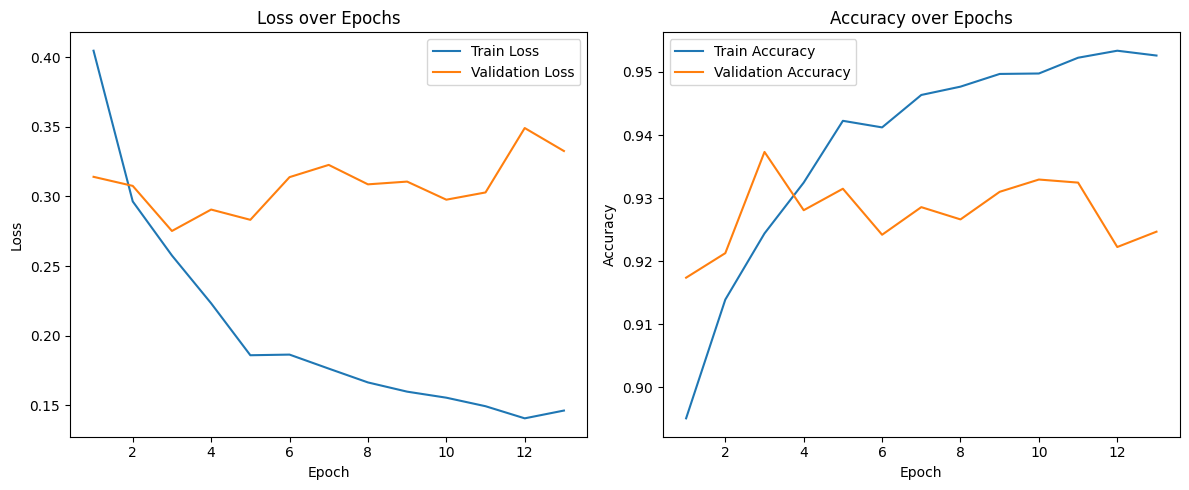

In [ ]:
trained_model = train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    num_epochs=NUM_EPOCHS,
    device=DEVICE,
    model_name='cnn_transformer_hybrid_2nd_crossvall',
    save_dir='drive/MyDrive/',
    patience=10
)

In [ ]:
criterion = nn.CrossEntropyLoss()
test_loss, test_acc = evaluate_test(model, test_loader, criterion, DEVICE)

Evaluating Test Set:   1%|          | 1/129 [00:08<18:04,  8.47s/it]

torch.Size([32, 2048])


Evaluating Test Set:   2%|▏         | 2/129 [00:15<16:41,  7.88s/it]

torch.Size([32, 2048])


Evaluating Test Set:   2%|▏         | 3/129 [00:24<16:45,  7.98s/it]

torch.Size([32, 2048])


Evaluating Test Set:   3%|▎         | 4/129 [00:31<16:31,  7.93s/it]

torch.Size([32, 2048])


Evaluating Test Set:   4%|▍         | 5/129 [00:39<15:54,  7.70s/it]

torch.Size([32, 2048])


Evaluating Test Set:   5%|▍         | 6/129 [00:47<15:56,  7.78s/it]

torch.Size([32, 2048])


Evaluating Test Set:   5%|▌         | 7/129 [00:54<15:52,  7.81s/it]

torch.Size([32, 2048])


Evaluating Test Set:   6%|▌         | 8/129 [01:02<15:52,  7.87s/it]

torch.Size([32, 2048])


Evaluating Test Set:   7%|▋         | 9/129 [01:10<15:37,  7.81s/it]

torch.Size([32, 2048])


Evaluating Test Set:   8%|▊         | 10/129 [01:18<15:37,  7.88s/it]

torch.Size([32, 2048])


Evaluating Test Set:   9%|▊         | 11/129 [01:28<16:38,  8.46s/it]

torch.Size([32, 2048])


Evaluating Test Set:   9%|▉         | 12/129 [01:37<16:47,  8.61s/it]

torch.Size([32, 2048])


Evaluating Test Set:  10%|█         | 13/129 [01:45<16:10,  8.37s/it]

torch.Size([32, 2048])


Evaluating Test Set:  11%|█         | 14/129 [01:53<15:52,  8.29s/it]

torch.Size([32, 2048])


Evaluating Test Set:  12%|█▏        | 15/129 [02:00<15:17,  8.05s/it]

torch.Size([32, 2048])


Evaluating Test Set:  12%|█▏        | 16/129 [02:09<15:17,  8.12s/it]

torch.Size([32, 2048])


Evaluating Test Set:  13%|█▎        | 17/129 [02:17<15:28,  8.29s/it]

torch.Size([32, 2048])


Evaluating Test Set:  14%|█▍        | 18/129 [02:26<15:18,  8.28s/it]

torch.Size([32, 2048])


Evaluating Test Set:  15%|█▍        | 19/129 [02:34<15:11,  8.29s/it]

torch.Size([32, 2048])


Evaluating Test Set:  16%|█▌        | 20/129 [02:42<14:59,  8.25s/it]

torch.Size([32, 2048])


Evaluating Test Set:  16%|█▋        | 21/129 [02:51<15:15,  8.48s/it]

torch.Size([32, 2048])


Evaluating Test Set:  17%|█▋        | 22/129 [03:00<15:19,  8.59s/it]

torch.Size([32, 2048])


Evaluating Test Set:  18%|█▊        | 23/129 [03:08<14:52,  8.42s/it]

torch.Size([32, 2048])


Evaluating Test Set:  19%|█▊        | 24/129 [03:16<14:29,  8.28s/it]

torch.Size([32, 2048])


Evaluating Test Set:  19%|█▉        | 25/129 [03:25<14:41,  8.47s/it]

torch.Size([32, 2048])


Evaluating Test Set:  20%|██        | 26/129 [03:33<14:12,  8.27s/it]

torch.Size([32, 2048])


Evaluating Test Set:  21%|██        | 27/129 [03:41<14:15,  8.39s/it]

torch.Size([32, 2048])


Evaluating Test Set:  22%|██▏       | 28/129 [03:49<13:51,  8.24s/it]

torch.Size([32, 2048])


Evaluating Test Set:  22%|██▏       | 29/129 [03:57<13:29,  8.09s/it]

torch.Size([32, 2048])


Evaluating Test Set:  23%|██▎       | 30/129 [04:05<13:22,  8.11s/it]

torch.Size([32, 2048])


Evaluating Test Set:  24%|██▍       | 31/129 [04:12<12:26,  7.62s/it]

torch.Size([32, 2048])


Evaluating Test Set:  25%|██▍       | 32/129 [04:19<12:20,  7.63s/it]

torch.Size([32, 2048])


Evaluating Test Set:  26%|██▌       | 33/129 [04:26<12:02,  7.53s/it]

torch.Size([32, 2048])


Evaluating Test Set:  26%|██▋       | 34/129 [04:34<11:56,  7.54s/it]

torch.Size([32, 2048])


Evaluating Test Set:  27%|██▋       | 35/129 [04:42<11:50,  7.56s/it]

torch.Size([32, 2048])


Evaluating Test Set:  28%|██▊       | 36/129 [04:49<11:33,  7.46s/it]

torch.Size([32, 2048])


Evaluating Test Set:  29%|██▊       | 37/129 [04:57<11:39,  7.61s/it]

torch.Size([32, 2048])


Evaluating Test Set:  29%|██▉       | 38/129 [05:03<11:00,  7.26s/it]

torch.Size([32, 2048])


Evaluating Test Set:  30%|███       | 39/129 [05:11<11:10,  7.45s/it]

torch.Size([32, 2048])


Evaluating Test Set:  31%|███       | 40/129 [05:19<11:18,  7.62s/it]

torch.Size([32, 2048])


Evaluating Test Set:  32%|███▏      | 41/129 [05:27<11:17,  7.70s/it]

torch.Size([32, 2048])


Evaluating Test Set:  33%|███▎      | 42/129 [05:34<10:51,  7.49s/it]

torch.Size([32, 2048])


Evaluating Test Set:  33%|███▎      | 43/129 [05:42<10:53,  7.60s/it]

torch.Size([32, 2048])


Evaluating Test Set:  34%|███▍      | 44/129 [05:51<11:12,  7.92s/it]

torch.Size([32, 2048])


Evaluating Test Set:  35%|███▍      | 45/129 [05:58<10:49,  7.73s/it]

torch.Size([32, 2048])


Evaluating Test Set:  36%|███▌      | 46/129 [06:05<10:32,  7.63s/it]

torch.Size([32, 2048])


Evaluating Test Set:  36%|███▋      | 47/129 [06:13<10:23,  7.60s/it]

torch.Size([32, 2048])


Evaluating Test Set:  37%|███▋      | 48/129 [06:21<10:32,  7.81s/it]

torch.Size([32, 2048])


Evaluating Test Set:  38%|███▊      | 49/129 [06:29<10:18,  7.73s/it]

torch.Size([32, 2048])


Evaluating Test Set:  39%|███▉      | 50/129 [06:37<10:15,  7.79s/it]

torch.Size([32, 2048])


Evaluating Test Set:  40%|███▉      | 51/129 [06:45<10:11,  7.84s/it]

torch.Size([32, 2048])


Evaluating Test Set:  40%|████      | 52/129 [06:52<10:00,  7.80s/it]

torch.Size([32, 2048])


Evaluating Test Set:  41%|████      | 53/129 [07:00<09:50,  7.76s/it]

torch.Size([32, 2048])


Evaluating Test Set:  42%|████▏     | 54/129 [07:08<09:46,  7.82s/it]

torch.Size([32, 2048])


Evaluating Test Set:  43%|████▎     | 55/129 [07:16<09:34,  7.77s/it]

torch.Size([32, 2048])


Evaluating Test Set:  43%|████▎     | 56/129 [07:23<09:22,  7.71s/it]

torch.Size([32, 2048])


Evaluating Test Set:  44%|████▍     | 57/129 [07:31<09:28,  7.89s/it]

torch.Size([32, 2048])


Evaluating Test Set:  45%|████▍     | 58/129 [07:39<09:06,  7.69s/it]

torch.Size([32, 2048])


Evaluating Test Set:  46%|████▌     | 59/129 [07:46<08:51,  7.59s/it]

torch.Size([32, 2048])


Evaluating Test Set:  47%|████▋     | 60/129 [07:54<08:45,  7.61s/it]

torch.Size([32, 2048])


Evaluating Test Set:  47%|████▋     | 61/129 [08:02<08:44,  7.71s/it]

torch.Size([32, 2048])


Evaluating Test Set:  48%|████▊     | 62/129 [08:10<08:53,  7.96s/it]

torch.Size([32, 2048])


Evaluating Test Set:  49%|████▉     | 63/129 [08:16<08:13,  7.47s/it]

torch.Size([32, 2048])


Evaluating Test Set:  50%|████▉     | 64/129 [08:24<08:01,  7.41s/it]

torch.Size([32, 2048])


Evaluating Test Set:  50%|█████     | 65/129 [08:31<07:56,  7.45s/it]

torch.Size([32, 2048])


Evaluating Test Set:  51%|█████     | 66/129 [08:39<07:57,  7.59s/it]

torch.Size([32, 2048])


Evaluating Test Set:  52%|█████▏    | 67/129 [08:47<07:57,  7.70s/it]

torch.Size([32, 2048])


Evaluating Test Set:  53%|█████▎    | 68/129 [08:55<07:57,  7.82s/it]

torch.Size([32, 2048])


Evaluating Test Set:  53%|█████▎    | 69/129 [09:02<07:34,  7.57s/it]

torch.Size([32, 2048])


Evaluating Test Set:  54%|█████▍    | 70/129 [09:10<07:38,  7.77s/it]

torch.Size([32, 2048])


Evaluating Test Set:  55%|█████▌    | 71/129 [09:19<07:44,  8.01s/it]

torch.Size([32, 2048])


Evaluating Test Set:  56%|█████▌    | 72/129 [09:26<07:23,  7.79s/it]

torch.Size([32, 2048])


Evaluating Test Set:  57%|█████▋    | 73/129 [09:34<07:17,  7.81s/it]

torch.Size([32, 2048])


Evaluating Test Set:  57%|█████▋    | 74/129 [09:41<07:01,  7.66s/it]

torch.Size([32, 2048])


Evaluating Test Set:  58%|█████▊    | 75/129 [09:49<06:53,  7.65s/it]

torch.Size([32, 2048])


Evaluating Test Set:  59%|█████▉    | 76/129 [09:57<06:49,  7.72s/it]

torch.Size([32, 2048])


Evaluating Test Set:  60%|█████▉    | 77/129 [10:04<06:29,  7.49s/it]

torch.Size([32, 2048])


Evaluating Test Set:  60%|██████    | 78/129 [10:12<06:24,  7.53s/it]

torch.Size([32, 2048])


Evaluating Test Set:  61%|██████    | 79/129 [10:19<06:18,  7.57s/it]

torch.Size([32, 2048])


Evaluating Test Set:  62%|██████▏   | 80/129 [10:28<06:30,  7.97s/it]

torch.Size([32, 2048])


Evaluating Test Set:  63%|██████▎   | 81/129 [10:36<06:16,  7.85s/it]

torch.Size([32, 2048])


Evaluating Test Set:  64%|██████▎   | 82/129 [10:44<06:11,  7.91s/it]

torch.Size([32, 2048])


Evaluating Test Set:  64%|██████▍   | 83/129 [10:51<06:01,  7.85s/it]

torch.Size([32, 2048])


Evaluating Test Set:  65%|██████▌   | 84/129 [10:59<05:44,  7.65s/it]

torch.Size([32, 2048])


Evaluating Test Set:  66%|██████▌   | 85/129 [11:06<05:29,  7.49s/it]

torch.Size([32, 2048])


Evaluating Test Set:  67%|██████▋   | 86/129 [11:13<05:19,  7.43s/it]

torch.Size([32, 2048])


Evaluating Test Set:  67%|██████▋   | 87/129 [11:21<05:19,  7.62s/it]

torch.Size([32, 2048])


Evaluating Test Set:  68%|██████▊   | 88/129 [11:29<05:16,  7.72s/it]

torch.Size([32, 2048])


Evaluating Test Set:  69%|██████▉   | 89/129 [11:37<05:08,  7.72s/it]

torch.Size([32, 2048])


Evaluating Test Set:  70%|██████▉   | 90/129 [11:45<05:06,  7.86s/it]

torch.Size([32, 2048])


Evaluating Test Set:  71%|███████   | 91/129 [11:53<04:59,  7.87s/it]

torch.Size([32, 2048])


Evaluating Test Set:  71%|███████▏  | 92/129 [12:02<05:00,  8.13s/it]

torch.Size([32, 2048])


Evaluating Test Set:  72%|███████▏  | 93/129 [12:10<04:57,  8.26s/it]

torch.Size([32, 2048])


Evaluating Test Set:  73%|███████▎  | 94/129 [12:18<04:39,  7.98s/it]

torch.Size([32, 2048])


Evaluating Test Set:  74%|███████▎  | 95/129 [12:29<05:04,  8.95s/it]

torch.Size([32, 2048])


Evaluating Test Set:  74%|███████▍  | 96/129 [12:37<04:48,  8.75s/it]

torch.Size([32, 2048])


Evaluating Test Set:  75%|███████▌  | 97/129 [12:45<04:29,  8.42s/it]

torch.Size([32, 2048])


Evaluating Test Set:  76%|███████▌  | 98/129 [12:52<04:13,  8.18s/it]

torch.Size([32, 2048])


Evaluating Test Set:  77%|███████▋  | 99/129 [12:58<03:46,  7.55s/it]

torch.Size([32, 2048])


Evaluating Test Set:  78%|███████▊  | 100/129 [13:06<03:42,  7.68s/it]

torch.Size([32, 2048])


Evaluating Test Set:  78%|███████▊  | 101/129 [13:14<03:32,  7.59s/it]

torch.Size([32, 2048])


Evaluating Test Set:  79%|███████▉  | 102/129 [13:22<03:27,  7.68s/it]

torch.Size([32, 2048])


Evaluating Test Set:  80%|███████▉  | 103/129 [13:29<03:18,  7.62s/it]

torch.Size([32, 2048])


Evaluating Test Set:  81%|████████  | 104/129 [13:36<03:03,  7.34s/it]

torch.Size([32, 2048])


Evaluating Test Set:  81%|████████▏ | 105/129 [13:44<02:59,  7.47s/it]

torch.Size([32, 2048])


Evaluating Test Set:  82%|████████▏ | 106/129 [13:51<02:51,  7.46s/it]

torch.Size([32, 2048])


Evaluating Test Set:  83%|████████▎ | 107/129 [13:58<02:42,  7.41s/it]

torch.Size([32, 2048])


Evaluating Test Set:  84%|████████▎ | 108/129 [14:06<02:40,  7.62s/it]

torch.Size([32, 2048])


Evaluating Test Set:  84%|████████▍ | 109/129 [14:14<02:31,  7.59s/it]

torch.Size([32, 2048])


Evaluating Test Set:  85%|████████▌ | 110/129 [14:21<02:22,  7.52s/it]

torch.Size([32, 2048])


Evaluating Test Set:  86%|████████▌ | 111/129 [14:28<02:10,  7.23s/it]

torch.Size([32, 2048])


Evaluating Test Set:  87%|████████▋ | 112/129 [14:36<02:05,  7.38s/it]

torch.Size([32, 2048])


Evaluating Test Set:  88%|████████▊ | 113/129 [14:43<01:57,  7.33s/it]

torch.Size([32, 2048])


Evaluating Test Set:  88%|████████▊ | 114/129 [14:51<01:55,  7.70s/it]

torch.Size([32, 2048])


Evaluating Test Set:  89%|████████▉ | 115/129 [14:59<01:46,  7.62s/it]

torch.Size([32, 2048])


Evaluating Test Set:  90%|████████▉ | 116/129 [15:06<01:36,  7.39s/it]

torch.Size([32, 2048])


Evaluating Test Set:  91%|█████████ | 117/129 [15:14<01:32,  7.69s/it]

torch.Size([32, 2048])


Evaluating Test Set:  91%|█████████▏| 118/129 [15:21<01:21,  7.44s/it]

torch.Size([32, 2048])


Evaluating Test Set:  92%|█████████▏| 119/129 [15:30<01:18,  7.87s/it]

torch.Size([32, 2048])


Evaluating Test Set:  93%|█████████▎| 120/129 [15:38<01:13,  8.14s/it]

torch.Size([32, 2048])


Evaluating Test Set:  94%|█████████▍| 121/129 [15:47<01:04,  8.11s/it]

torch.Size([32, 2048])


Evaluating Test Set:  95%|█████████▍| 122/129 [15:54<00:56,  8.01s/it]

torch.Size([32, 2048])


Evaluating Test Set:  95%|█████████▌| 123/129 [16:02<00:48,  8.01s/it]

torch.Size([32, 2048])


Evaluating Test Set:  96%|█████████▌| 124/129 [16:11<00:41,  8.29s/it]

torch.Size([32, 2048])


Evaluating Test Set:  97%|█████████▋| 125/129 [16:25<00:39,  9.94s/it]

torch.Size([32, 2048])


Evaluating Test Set:  98%|█████████▊| 126/129 [16:34<00:28,  9.53s/it]

torch.Size([32, 2048])


Evaluating Test Set:  98%|█████████▊| 127/129 [16:42<00:18,  9.26s/it]

torch.Size([32, 2048])


Evaluating Test Set:  99%|█████████▉| 128/129 [16:50<00:08,  8.74s/it]

torch.Size([32, 2048])


Evaluating Test Set: 100%|██████████| 129/129 [16:55<00:00,  7.87s/it]

torch.Size([20, 2048])
Test Loss: 0.2722, Test Accuracy: 0.9300


# Manual Data Split 3

*   1st-5th-...-9th parts for train
*   2nd part for validation
*   3rd and 4th parts for test

[Epoch 1/20] Training:   0%|          | 0/451 [00:00<?, ?it/s]

torch.Size([32, 2048])


[Epoch 1/20] Training:   0%|          | 1/451 [00:31<3:58:00, 31.73s/it]

torch.Size([32, 2048])


[Epoch 1/20] Training:   1%|          | 3/451 [00:57<2:11:51, 17.66s/it]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 1/20] Training:   1%|          | 5/451 [01:23<1:54:10, 15.36s/it]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 1/20] Training:   2%|▏         | 7/451 [01:49<1:46:55, 14.45s/it]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 1/20] Training:   2%|▏         | 9/451 [02:16<1:42:48, 13.95s/it]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 1/20] Training:   2%|▏         | 11/451 [02:42<1:40:47, 13.74s/it]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 1/20] Training:   3%|▎         | 13/451 [03:09<1:38:42, 13.52s/it]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 1/20] Training:   3%|▎         | 15/451 [03:34<1:36:38, 13.30s/it]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 1/20] Training:   4%|▍         | 17/451 [04:01<1:36:00, 13.27s/it]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 1/20] Training:   4%|▍         | 19/451 [04:28<1:36:06, 13.35s/it]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 1/20] Training:   5%|▍         | 21/451 [04:54<1:34:49, 13.23s/it]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 1/20] Training:   5%|▌         | 23/451 [05:21<1:34:49, 13.29s/it]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 1/20] Training:   6%|▌         | 25/451 [05:47<1:33:45, 13.20s/it]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 1/20] Training:   6%|▌         | 27/451 [06:13<1:33:35, 13.24s/it]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 1/20] Training:   6%|▋         | 29/451 [06:39<1:32:19, 13.13s/it]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 1/20] Training:   7%|▋         | 31/451 [07:05<1:31:11, 13.03s/it]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 1/20] Training:   7%|▋         | 33/451 [07:31<1:30:42, 13.02s/it]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 1/20] Training:   8%|▊         | 35/451 [07:55<1:28:52, 12.82s/it]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 1/20] Training:   8%|▊         | 37/451 [08:21<1:28:25, 12.81s/it]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 1/20] Training:   9%|▊         | 39/451 [08:46<1:27:27, 12.74s/it]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 1/20] Training:   9%|▉         | 41/451 [09:11<1:27:05, 12.75s/it]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 1/20] Training:  10%|▉         | 43/451 [09:37<1:26:29, 12.72s/it]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 1/20] Training:  10%|▉         | 45/451 [10:04<1:27:33, 12.94s/it]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 1/20] Training:  10%|█         | 47/451 [10:30<1:27:38, 13.02s/it]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 1/20] Training:  11%|█         | 49/451 [10:56<1:27:34, 13.07s/it]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 1/20] Training:  11%|█▏        | 51/451 [11:22<1:26:11, 12.93s/it]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 1/20] Training:  12%|█▏        | 53/451 [11:48<1:26:29, 13.04s/it]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 1/20] Training:  12%|█▏        | 55/451 [12:14<1:26:10, 13.06s/it]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 1/20] Training:  13%|█▎        | 57/451 [12:41<1:25:49, 13.07s/it]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 1/20] Training:  13%|█▎        | 59/451 [13:06<1:24:44, 12.97s/it]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 1/20] Training:  14%|█▎        | 61/451 [13:33<1:24:44, 13.04s/it]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 1/20] Training:  14%|█▍        | 63/451 [14:00<1:25:35, 13.24s/it]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 1/20] Training:  14%|█▍        | 65/451 [14:28<1:26:36, 13.46s/it]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 1/20] Training:  15%|█▍        | 67/451 [14:55<1:26:04, 13.45s/it]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 1/20] Training:  15%|█▌        | 69/451 [15:20<1:24:29, 13.27s/it]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 1/20] Training:  16%|█▌        | 71/451 [15:46<1:22:57, 13.10s/it]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 1/20] Training:  16%|█▌        | 73/451 [16:12<1:22:03, 13.02s/it]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 1/20] Training:  17%|█▋        | 75/451 [16:38<1:21:37, 13.02s/it]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 1/20] Training:  17%|█▋        | 77/451 [17:03<1:20:09, 12.86s/it]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 1/20] Training:  18%|█▊        | 79/451 [17:28<1:19:42, 12.85s/it]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 1/20] Training:  18%|█▊        | 81/451 [17:53<1:18:48, 12.78s/it]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 1/20] Training:  18%|█▊        | 83/451 [18:19<1:18:32, 12.81s/it]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 1/20] Training:  19%|█▉        | 85/451 [18:44<1:17:40, 12.73s/it]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 1/20] Training:  19%|█▉        | 87/451 [19:10<1:17:45, 12.82s/it]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 1/20] Training:  20%|█▉        | 89/451 [19:36<1:17:32, 12.85s/it]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 1/20] Training:  20%|██        | 91/451 [20:01<1:16:19, 12.72s/it]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 1/20] Training:  21%|██        | 93/451 [20:27<1:16:12, 12.77s/it]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 1/20] Training:  21%|██        | 95/451 [20:53<1:15:56, 12.80s/it]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 1/20] Training:  22%|██▏       | 97/451 [21:16<1:13:58, 12.54s/it]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 1/20] Training:  22%|██▏       | 99/451 [21:42<1:13:53, 12.60s/it]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 1/20] Training:  22%|██▏       | 101/451 [22:08<1:14:05, 12.70s/it]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 1/20] Training:  23%|██▎       | 103/451 [22:33<1:13:06, 12.61s/it]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 1/20] Training:  23%|██▎       | 105/451 [22:58<1:12:57, 12.65s/it]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 1/20] Training:  24%|██▎       | 107/451 [23:23<1:12:27, 12.64s/it]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 1/20] Training:  24%|██▍       | 109/451 [23:49<1:12:45, 12.77s/it]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 1/20] Training:  25%|██▍       | 111/451 [24:14<1:11:23, 12.60s/it]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 1/20] Training:  25%|██▌       | 113/451 [24:39<1:11:11, 12.64s/it]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 1/20] Training:  25%|██▌       | 115/451 [25:06<1:11:40, 12.80s/it]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 1/20] Training:  26%|██▌       | 117/451 [25:31<1:11:05, 12.77s/it]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 1/20] Training:  26%|██▋       | 119/451 [25:57<1:11:03, 12.84s/it]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 1/20] Training:  27%|██▋       | 121/451 [26:23<1:10:44, 12.86s/it]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 1/20] Training:  27%|██▋       | 123/451 [26:48<1:10:13, 12.84s/it]

torch.Size([32, 2048])


[Epoch 1/20] Training:  27%|██▋       | 124/451 [27:49<1:55:58, 21.28s/it]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 1/20] Training:  28%|██▊       | 126/451 [28:15<1:39:57, 18.45s/it]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 1/20] Training:  28%|██▊       | 128/451 [28:41<1:29:34, 16.64s/it]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 1/20] Training:  29%|██▉       | 130/451 [29:06<1:22:32, 15.43s/it]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 1/20] Training:  29%|██▉       | 132/451 [29:32<1:18:03, 14.68s/it]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 1/20] Training:  30%|██▉       | 134/451 [29:58<1:14:54, 14.18s/it]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 1/20] Training:  30%|███       | 136/451 [30:24<1:12:31, 13.81s/it]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 1/20] Training:  31%|███       | 138/451 [30:50<1:10:11, 13.46s/it]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 1/20] Training:  31%|███       | 140/451 [31:15<1:08:30, 13.22s/it]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 1/20] Training:  31%|███▏      | 142/451 [31:41<1:07:46, 13.16s/it]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 1/20] Training:  32%|███▏      | 144/451 [32:06<1:06:15, 12.95s/it]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 1/20] Training:  32%|███▏      | 146/451 [32:31<1:05:18, 12.85s/it]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 1/20] Training:  33%|███▎      | 148/451 [32:56<1:04:33, 12.78s/it]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 1/20] Training:  33%|███▎      | 150/451 [33:22<1:04:09, 12.79s/it]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 1/20] Training:  34%|███▎      | 152/451 [33:47<1:03:37, 12.77s/it]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 1/20] Training:  34%|███▍      | 154/451 [34:13<1:03:10, 12.76s/it]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 1/20] Training:  35%|███▍      | 156/451 [34:39<1:03:02, 12.82s/it]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 1/20] Training:  35%|███▌      | 158/451 [35:03<1:01:53, 12.67s/it]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 1/20] Training:  35%|███▌      | 160/451 [35:29<1:01:44, 12.73s/it]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 1/20] Training:  36%|███▌      | 162/451 [35:54<1:01:10, 12.70s/it]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 1/20] Training:  36%|███▋      | 164/451 [36:20<1:00:55, 12.74s/it]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 1/20] Training:  37%|███▋      | 166/451 [36:45<1:00:21, 12.71s/it]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 1/20] Training:  37%|███▋      | 168/451 [37:11<1:00:20, 12.79s/it]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 1/20] Training:  38%|███▊      | 170/451 [37:37<59:55, 12.80s/it]  

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 1/20] Training:  38%|███▊      | 172/451 [38:03<59:31, 12.80s/it]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 1/20] Training:  39%|███▊      | 174/451 [38:28<59:01, 12.78s/it]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 1/20] Training:  39%|███▉      | 176/451 [38:53<58:18, 12.72s/it]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 1/20] Training:  39%|███▉      | 178/451 [39:19<58:15, 12.80s/it]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 1/20] Training:  40%|███▉      | 180/451 [39:46<58:40, 12.99s/it]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 1/20] Training:  40%|████      | 182/451 [40:13<58:34, 13.06s/it]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 1/20] Training:  41%|████      | 184/451 [40:38<57:50, 13.00s/it]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 1/20] Training:  41%|████      | 186/451 [41:03<56:53, 12.88s/it]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 1/20] Training:  42%|████▏     | 188/451 [41:29<56:23, 12.87s/it]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 1/20] Training:  42%|████▏     | 190/451 [41:54<55:26, 12.75s/it]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 1/20] Training:  43%|████▎     | 192/451 [42:21<55:45, 12.92s/it]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 1/20] Training:  43%|████▎     | 194/451 [42:46<55:01, 12.85s/it]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 1/20] Training:  43%|████▎     | 196/451 [43:12<54:58, 12.94s/it]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 1/20] Training:  44%|████▍     | 198/451 [43:38<54:29, 12.92s/it]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 1/20] Training:  44%|████▍     | 200/451 [44:04<54:20, 12.99s/it]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 1/20] Training:  45%|████▍     | 202/451 [44:31<54:31, 13.14s/it]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 1/20] Training:  45%|████▌     | 204/451 [44:57<53:38, 13.03s/it]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 1/20] Training:  46%|████▌     | 206/451 [45:23<53:22, 13.07s/it]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 1/20] Training:  46%|████▌     | 208/451 [45:51<53:50, 13.29s/it]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 1/20] Training:  47%|████▋     | 210/451 [46:17<53:21, 13.28s/it]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 1/20] Training:  47%|████▋     | 212/451 [46:43<52:20, 13.14s/it]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 1/20] Training:  47%|████▋     | 214/451 [47:09<52:00, 13.17s/it]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 1/20] Training:  48%|████▊     | 216/451 [47:36<51:36, 13.18s/it]

torch.Size([32, 2048])


[Epoch 1/20] Training:  48%|████▊     | 217/451 [47:51<53:02, 13.60s/it]

torch.Size([32, 2048])


[Epoch 1/20] Training:  48%|████▊     | 218/451 [48:01<49:54, 12.85s/it]

torch.Size([32, 2048])


[Epoch 1/20] Training:  49%|████▊     | 219/451 [48:18<52:54, 13.68s/it]

torch.Size([32, 2048])


[Epoch 1/20] Training:  49%|████▉     | 220/451 [48:28<49:40, 12.90s/it]

torch.Size([32, 2048])


[Epoch 1/20] Training:  49%|████▉     | 221/451 [48:44<52:15, 13.63s/it]

torch.Size([32, 2048])


[Epoch 1/20] Training:  49%|████▉     | 222/451 [48:54<48:39, 12.75s/it]

torch.Size([32, 2048])


[Epoch 1/20] Training:  49%|████▉     | 223/451 [49:10<51:00, 13.42s/it]

torch.Size([32, 2048])


[Epoch 1/20] Training:  50%|████▉     | 224/451 [49:20<48:02, 12.70s/it]

torch.Size([32, 2048])


[Epoch 1/20] Training:  50%|████▉     | 225/451 [49:37<51:52, 13.77s/it]

torch.Size([32, 2048])


[Epoch 1/20] Training:  50%|█████     | 226/451 [49:47<47:12, 12.59s/it]

torch.Size([32, 2048])


[Epoch 1/20] Training:  50%|█████     | 227/451 [50:03<50:49, 13.61s/it]

torch.Size([32, 2048])


[Epoch 1/20] Training:  51%|█████     | 228/451 [50:13<47:16, 12.72s/it]

torch.Size([32, 2048])


[Epoch 1/20] Training:  51%|█████     | 229/451 [50:30<51:16, 13.86s/it]

torch.Size([32, 2048])


[Epoch 1/20] Training:  51%|█████     | 230/451 [50:39<45:44, 12.42s/it]

torch.Size([32, 2048])


[Epoch 1/20] Training:  51%|█████     | 231/451 [50:57<51:54, 14.16s/it]

torch.Size([32, 2048])


[Epoch 1/20] Training:  51%|█████▏    | 232/451 [51:04<44:02, 12.07s/it]

torch.Size([32, 2048])


[Epoch 1/20] Training:  52%|█████▏    | 233/451 [51:23<51:33, 14.19s/it]

torch.Size([32, 2048])


[Epoch 1/20] Training:  52%|█████▏    | 234/451 [51:31<43:49, 12.12s/it]

torch.Size([32, 2048])


[Epoch 1/20] Training:  52%|█████▏    | 235/451 [51:48<49:40, 13.80s/it]

torch.Size([32, 2048])


[Epoch 1/20] Training:  52%|█████▏    | 236/451 [51:56<42:15, 11.79s/it]

torch.Size([32, 2048])


[Epoch 1/20] Training:  53%|█████▎    | 237/451 [52:15<50:19, 14.11s/it]

torch.Size([32, 2048])


[Epoch 1/20] Training:  53%|█████▎    | 238/451 [52:22<42:12, 11.89s/it]

torch.Size([32, 2048])


[Epoch 1/20] Training:  53%|█████▎    | 239/451 [52:41<49:23, 13.98s/it]

torch.Size([32, 2048])


[Epoch 1/20] Training:  53%|█████▎    | 240/451 [52:48<42:27, 12.07s/it]

torch.Size([32, 2048])


[Epoch 1/20] Training:  53%|█████▎    | 241/451 [53:07<49:37, 14.18s/it]

torch.Size([32, 2048])


[Epoch 1/20] Training:  54%|█████▎    | 242/451 [53:15<42:35, 12.23s/it]

torch.Size([32, 2048])


[Epoch 1/20] Training:  54%|█████▍    | 243/451 [53:35<49:58, 14.42s/it]

torch.Size([32, 2048])


[Epoch 1/20] Training:  54%|█████▍    | 244/451 [53:41<41:20, 11.98s/it]

torch.Size([32, 2048])


[Epoch 1/20] Training:  54%|█████▍    | 245/451 [54:01<49:27, 14.40s/it]

torch.Size([32, 2048])


[Epoch 1/20] Training:  55%|█████▍    | 246/451 [54:08<41:13, 12.07s/it]

torch.Size([32, 2048])


[Epoch 1/20] Training:  55%|█████▍    | 247/451 [54:28<49:54, 14.68s/it]

torch.Size([32, 2048])


[Epoch 1/20] Training:  55%|█████▍    | 248/451 [54:34<40:31, 11.98s/it]

torch.Size([32, 2048])


[Epoch 1/20] Training:  55%|█████▌    | 249/451 [54:55<49:20, 14.65s/it]

torch.Size([32, 2048])


[Epoch 1/20] Training:  55%|█████▌    | 250/451 [55:01<40:08, 11.98s/it]

torch.Size([32, 2048])


[Epoch 1/20] Training:  56%|█████▌    | 251/451 [55:22<48:51, 14.66s/it]

torch.Size([32, 2048])


[Epoch 1/20] Training:  56%|█████▌    | 252/451 [55:28<40:10, 12.11s/it]

torch.Size([32, 2048])


[Epoch 1/20] Training:  56%|█████▌    | 253/451 [55:47<47:34, 14.42s/it]

torch.Size([32, 2048])


[Epoch 1/20] Training:  56%|█████▋    | 254/451 [55:53<38:56, 11.86s/it]

torch.Size([32, 2048])


[Epoch 1/20] Training:  57%|█████▋    | 255/451 [56:14<47:00, 14.39s/it]

torch.Size([32, 2048])


[Epoch 1/20] Training:  57%|█████▋    | 256/451 [56:20<38:52, 11.96s/it]

torch.Size([32, 2048])


[Epoch 1/20] Training:  57%|█████▋    | 257/451 [56:40<46:40, 14.44s/it]

torch.Size([32, 2048])


[Epoch 1/20] Training:  57%|█████▋    | 258/451 [56:45<37:24, 11.63s/it]

torch.Size([32, 2048])


[Epoch 1/20] Training:  57%|█████▋    | 259/451 [57:06<45:48, 14.32s/it]

torch.Size([32, 2048])


[Epoch 1/20] Training:  58%|█████▊    | 260/451 [57:11<37:03, 11.64s/it]

torch.Size([32, 2048])


[Epoch 1/20] Training:  58%|█████▊    | 261/451 [57:32<45:33, 14.39s/it]

torch.Size([32, 2048])


[Epoch 1/20] Training:  58%|█████▊    | 262/451 [57:37<36:40, 11.64s/it]

torch.Size([32, 2048])


[Epoch 1/20] Training:  58%|█████▊    | 263/451 [57:58<45:24, 14.49s/it]

torch.Size([32, 2048])


[Epoch 1/20] Training:  59%|█████▊    | 264/451 [58:04<36:25, 11.68s/it]

torch.Size([32, 2048])


[Epoch 1/20] Training:  59%|█████▉    | 265/451 [58:24<44:06, 14.23s/it]

torch.Size([32, 2048])


[Epoch 1/20] Training:  59%|█████▉    | 266/451 [58:31<37:29, 12.16s/it]

torch.Size([32, 2048])


[Epoch 1/20] Training:  59%|█████▉    | 267/451 [58:50<43:46, 14.27s/it]

torch.Size([32, 2048])


[Epoch 1/20] Training:  59%|█████▉    | 268/451 [58:57<36:52, 12.09s/it]

torch.Size([32, 2048])


[Epoch 1/20] Training:  60%|█████▉    | 269/451 [59:17<43:45, 14.43s/it]

torch.Size([32, 2048])


[Epoch 1/20] Training:  60%|█████▉    | 270/451 [59:23<35:36, 11.80s/it]

torch.Size([32, 2048])


[Epoch 1/20] Training:  60%|██████    | 271/451 [59:43<43:22, 14.46s/it]

torch.Size([32, 2048])


[Epoch 1/20] Training:  60%|██████    | 272/451 [59:49<34:55, 11.71s/it]

torch.Size([32, 2048])


[Epoch 1/20] Training:  61%|██████    | 273/451 [1:00:10<43:07, 14.54s/it]

torch.Size([32, 2048])


[Epoch 1/20] Training:  61%|██████    | 274/451 [1:00:15<34:14, 11.60s/it]

torch.Size([32, 2048])


[Epoch 1/20] Training:  61%|██████    | 275/451 [1:00:36<42:49, 14.60s/it]

torch.Size([32, 2048])


[Epoch 1/20] Training:  61%|██████    | 276/451 [1:00:41<33:33, 11.51s/it]

torch.Size([32, 2048])


[Epoch 1/20] Training:  61%|██████▏   | 277/451 [1:01:03<42:42, 14.73s/it]

torch.Size([32, 2048])


[Epoch 1/20] Training:  62%|██████▏   | 278/451 [1:01:06<32:17, 11.20s/it]

torch.Size([32, 2048])


[Epoch 1/20] Training:  62%|██████▏   | 279/451 [1:01:28<42:00, 14.66s/it]

torch.Size([32, 2048])


[Epoch 1/20] Training:  62%|██████▏   | 280/451 [1:01:31<31:11, 10.94s/it]

torch.Size([32, 2048])


[Epoch 1/20] Training:  62%|██████▏   | 281/451 [1:01:55<42:22, 14.95s/it]

torch.Size([32, 2048])


[Epoch 1/20] Training:  63%|██████▎   | 282/451 [1:01:56<30:28, 10.82s/it]

torch.Size([32, 2048])


[Epoch 1/20] Training:  63%|██████▎   | 283/451 [1:02:21<41:52, 14.96s/it]

torch.Size([32, 2048])


[Epoch 1/20] Training:  63%|██████▎   | 284/451 [1:02:23<30:51, 11.09s/it]

torch.Size([32, 2048])


[Epoch 1/20] Training:  63%|██████▎   | 285/451 [1:02:48<42:23, 15.32s/it]

torch.Size([32, 2048])


[Epoch 1/20] Training:  63%|██████▎   | 286/451 [1:02:48<29:42, 10.80s/it]

torch.Size([32, 2048])


[Epoch 1/20] Training:  64%|██████▎   | 287/451 [1:03:14<41:43, 15.26s/it]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 1/20] Training:  64%|██████▍   | 289/451 [1:03:39<37:58, 14.07s/it]

torch.Size([32, 2048])


[Epoch 1/20] Training:  64%|██████▍   | 290/451 [1:03:44<31:09, 11.61s/it]

torch.Size([32, 2048])


[Epoch 1/20] Training:  65%|██████▍   | 291/451 [1:04:05<38:00, 14.25s/it]

torch.Size([32, 2048])


[Epoch 1/20] Training:  65%|██████▍   | 292/451 [1:04:10<30:57, 11.68s/it]

torch.Size([32, 2048])


[Epoch 1/20] Training:  65%|██████▍   | 293/451 [1:04:31<37:36, 14.28s/it]

torch.Size([32, 2048])


[Epoch 1/20] Training:  65%|██████▌   | 294/451 [1:04:37<30:50, 11.79s/it]

torch.Size([32, 2048])


[Epoch 1/20] Training:  65%|██████▌   | 295/451 [1:04:57<37:15, 14.33s/it]

torch.Size([32, 2048])


[Epoch 1/20] Training:  66%|██████▌   | 296/451 [1:05:02<29:47, 11.53s/it]

torch.Size([32, 2048])


[Epoch 1/20] Training:  66%|██████▌   | 297/451 [1:05:23<36:42, 14.30s/it]

torch.Size([32, 2048])


[Epoch 1/20] Training:  66%|██████▌   | 298/451 [1:05:28<29:50, 11.71s/it]

torch.Size([32, 2048])


[Epoch 1/20] Training:  66%|██████▋   | 299/451 [1:05:48<35:49, 14.14s/it]

torch.Size([32, 2048])


[Epoch 1/20] Training:  67%|██████▋   | 300/451 [1:05:55<29:43, 11.81s/it]

torch.Size([32, 2048])


[Epoch 1/20] Training:  67%|██████▋   | 301/451 [1:06:17<37:42, 15.09s/it]

torch.Size([32, 2048])


[Epoch 1/20] Training:  67%|██████▋   | 302/451 [1:06:21<28:59, 11.68s/it]

torch.Size([32, 2048])


[Epoch 1/20] Training:  67%|██████▋   | 303/451 [1:06:44<37:00, 15.00s/it]

torch.Size([32, 2048])


[Epoch 1/20] Training:  67%|██████▋   | 304/451 [1:06:47<27:44, 11.33s/it]

torch.Size([32, 2048])


[Epoch 1/20] Training:  68%|██████▊   | 305/451 [1:07:09<35:37, 14.64s/it]

torch.Size([32, 2048])


[Epoch 1/20] Training:  68%|██████▊   | 306/451 [1:07:12<26:59, 11.17s/it]

torch.Size([32, 2048])


[Epoch 1/20] Training:  68%|██████▊   | 307/451 [1:07:35<35:03, 14.61s/it]

torch.Size([32, 2048])


[Epoch 1/20] Training:  68%|██████▊   | 308/451 [1:07:37<26:14, 11.01s/it]

torch.Size([32, 2048])


[Epoch 1/20] Training:  69%|██████▊   | 309/451 [1:08:01<34:51, 14.73s/it]

torch.Size([32, 2048])


[Epoch 1/20] Training:  69%|██████▊   | 310/451 [1:08:03<25:54, 11.03s/it]

torch.Size([32, 2048])


[Epoch 1/20] Training:  69%|██████▉   | 311/451 [1:08:26<33:57, 14.55s/it]

torch.Size([32, 2048])


[Epoch 1/20] Training:  69%|██████▉   | 312/451 [1:08:29<25:42, 11.10s/it]

torch.Size([32, 2048])


[Epoch 1/20] Training:  69%|██████▉   | 313/451 [1:08:51<33:04, 14.38s/it]

torch.Size([32, 2048])


[Epoch 1/20] Training:  70%|██████▉   | 314/451 [1:08:55<26:04, 11.42s/it]

torch.Size([32, 2048])


[Epoch 1/20] Training:  70%|██████▉   | 315/451 [1:09:17<32:50, 14.49s/it]

torch.Size([32, 2048])


[Epoch 1/20] Training:  70%|███████   | 316/451 [1:09:22<26:14, 11.67s/it]

torch.Size([32, 2048])


[Epoch 1/20] Training:  70%|███████   | 317/451 [1:09:43<32:07, 14.38s/it]

torch.Size([32, 2048])


[Epoch 1/20] Training:  71%|███████   | 318/451 [1:09:48<25:49, 11.65s/it]

torch.Size([32, 2048])


[Epoch 1/20] Training:  71%|███████   | 319/451 [1:10:09<31:48, 14.46s/it]

torch.Size([32, 2048])


[Epoch 1/20] Training:  71%|███████   | 320/451 [1:10:14<25:30, 11.68s/it]

torch.Size([32, 2048])


[Epoch 1/20] Training:  71%|███████   | 321/451 [1:10:35<31:26, 14.51s/it]

torch.Size([32, 2048])


[Epoch 1/20] Training:  71%|███████▏  | 322/451 [1:10:40<24:47, 11.53s/it]

torch.Size([32, 2048])


[Epoch 1/20] Training:  72%|███████▏  | 323/451 [1:11:02<31:11, 14.62s/it]

torch.Size([32, 2048])


[Epoch 1/20] Training:  72%|███████▏  | 324/451 [1:11:06<24:01, 11.35s/it]

torch.Size([32, 2048])


[Epoch 1/20] Training:  72%|███████▏  | 325/451 [1:11:27<30:14, 14.40s/it]

torch.Size([32, 2048])


[Epoch 1/20] Training:  72%|███████▏  | 326/451 [1:11:32<23:58, 11.51s/it]

torch.Size([32, 2048])


[Epoch 1/20] Training:  73%|███████▎  | 327/451 [1:11:52<29:20, 14.20s/it]

torch.Size([32, 2048])


[Epoch 1/20] Training:  73%|███████▎  | 328/451 [1:11:59<24:17, 11.85s/it]

torch.Size([32, 2048])


[Epoch 1/20] Training:  73%|███████▎  | 329/451 [1:12:18<28:47, 14.16s/it]

torch.Size([32, 2048])


[Epoch 1/20] Training:  73%|███████▎  | 330/451 [1:12:25<23:49, 11.82s/it]

torch.Size([32, 2048])


[Epoch 1/20] Training:  73%|███████▎  | 331/451 [1:12:44<27:54, 13.96s/it]

torch.Size([32, 2048])


[Epoch 1/20] Training:  74%|███████▎  | 332/451 [1:12:51<23:33, 11.88s/it]

torch.Size([32, 2048])


[Epoch 1/20] Training:  74%|███████▍  | 333/451 [1:13:10<27:30, 13.98s/it]

torch.Size([32, 2048])


[Epoch 1/20] Training:  74%|███████▍  | 334/451 [1:13:37<34:59, 17.95s/it]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 1/20] Training:  75%|███████▍  | 336/451 [1:14:03<30:01, 15.66s/it]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 1/20] Training:  75%|███████▍  | 338/451 [1:14:29<27:31, 14.62s/it]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 1/20] Training:  75%|███████▌  | 340/451 [1:14:54<25:45, 13.93s/it]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 1/20] Training:  76%|███████▌  | 342/451 [1:15:21<25:03, 13.79s/it]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 1/20] Training:  76%|███████▋  | 344/451 [1:15:48<24:17, 13.62s/it]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 1/20] Training:  77%|███████▋  | 346/451 [1:16:14<23:33, 13.46s/it]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 1/20] Training:  77%|███████▋  | 348/451 [1:16:40<22:45, 13.26s/it]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 1/20] Training:  78%|███████▊  | 350/451 [1:17:05<21:57, 13.04s/it]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 1/20] Training:  78%|███████▊  | 352/451 [1:17:30<21:23, 12.96s/it]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 1/20] Training:  78%|███████▊  | 354/451 [1:17:58<21:19, 13.19s/it]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 1/20] Training:  79%|███████▉  | 356/451 [1:18:24<20:46, 13.12s/it]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 1/20] Training:  79%|███████▉  | 358/451 [1:18:50<20:19, 13.11s/it]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 1/20] Training:  80%|███████▉  | 360/451 [1:19:17<19:59, 13.18s/it]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 1/20] Training:  80%|████████  | 362/451 [1:19:43<19:33, 13.18s/it]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 1/20] Training:  81%|████████  | 364/451 [1:20:09<18:58, 13.09s/it]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 1/20] Training:  81%|████████  | 366/451 [1:20:37<18:54, 13.35s/it]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 1/20] Training:  82%|████████▏ | 368/451 [1:21:03<18:29, 13.36s/it]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 1/20] Training:  82%|████████▏ | 370/451 [1:21:28<17:37, 13.06s/it]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 1/20] Training:  82%|████████▏ | 372/451 [1:21:53<17:02, 12.94s/it]

torch.Size([32, 2048])


[Epoch 1/20] Training:  83%|████████▎ | 373/451 [1:22:09<17:32, 13.50s/it]

torch.Size([32, 2048])


[Epoch 1/20] Training:  83%|████████▎ | 374/451 [1:22:18<16:04, 12.52s/it]

torch.Size([32, 2048])


[Epoch 1/20] Training:  83%|████████▎ | 375/451 [1:22:35<17:03, 13.46s/it]

torch.Size([32, 2048])


[Epoch 1/20] Training:  83%|████████▎ | 376/451 [1:22:45<15:42, 12.56s/it]

torch.Size([32, 2048])


[Epoch 1/20] Training:  84%|████████▎ | 377/451 [1:23:00<16:31, 13.40s/it]

torch.Size([32, 2048])


[Epoch 1/20] Training:  84%|████████▍ | 378/451 [1:23:11<15:22, 12.63s/it]

torch.Size([32, 2048])


[Epoch 1/20] Training:  84%|████████▍ | 379/451 [1:23:27<16:16, 13.56s/it]

torch.Size([32, 2048])


[Epoch 1/20] Training:  84%|████████▍ | 380/451 [1:23:36<14:30, 12.26s/it]

torch.Size([32, 2048])


[Epoch 1/20] Training:  84%|████████▍ | 381/451 [1:23:53<15:55, 13.65s/it]

torch.Size([32, 2048])


[Epoch 1/20] Training:  85%|████████▍ | 382/451 [1:24:02<14:05, 12.25s/it]

torch.Size([32, 2048])


[Epoch 1/20] Training:  85%|████████▍ | 383/451 [1:24:19<15:27, 13.65s/it]

torch.Size([32, 2048])


[Epoch 1/20] Training:  85%|████████▌ | 384/451 [1:24:27<13:32, 12.13s/it]

torch.Size([32, 2048])


[Epoch 1/20] Training:  85%|████████▌ | 385/451 [1:24:45<15:04, 13.70s/it]

torch.Size([32, 2048])


[Epoch 1/20] Training:  86%|████████▌ | 386/451 [1:24:54<13:27, 12.42s/it]

torch.Size([32, 2048])


[Epoch 1/20] Training:  86%|████████▌ | 387/451 [1:25:11<14:43, 13.80s/it]

torch.Size([32, 2048])


[Epoch 1/20] Training:  86%|████████▌ | 388/451 [1:25:20<12:59, 12.37s/it]

torch.Size([32, 2048])


[Epoch 1/20] Training:  86%|████████▋ | 389/451 [1:25:38<14:27, 13.99s/it]

torch.Size([32, 2048])


[Epoch 1/20] Training:  86%|████████▋ | 390/451 [1:25:46<12:21, 12.16s/it]

torch.Size([32, 2048])


[Epoch 1/20] Training:  87%|████████▋ | 391/451 [1:26:03<13:45, 13.76s/it]

torch.Size([32, 2048])


[Epoch 1/20] Training:  87%|████████▋ | 392/451 [1:26:12<11:57, 12.15s/it]

torch.Size([32, 2048])


[Epoch 1/20] Training:  87%|████████▋ | 393/451 [1:26:30<13:23, 13.86s/it]

torch.Size([32, 2048])


[Epoch 1/20] Training:  87%|████████▋ | 394/451 [1:26:38<11:32, 12.14s/it]

torch.Size([32, 2048])


[Epoch 1/20] Training:  88%|████████▊ | 395/451 [1:26:57<13:15, 14.20s/it]

torch.Size([32, 2048])


[Epoch 1/20] Training:  88%|████████▊ | 396/451 [1:27:04<10:59, 12.00s/it]

torch.Size([32, 2048])


[Epoch 1/20] Training:  88%|████████▊ | 397/451 [1:27:22<12:27, 13.84s/it]

torch.Size([32, 2048])


[Epoch 1/20] Training:  88%|████████▊ | 398/451 [1:27:28<10:17, 11.65s/it]

torch.Size([32, 2048])


[Epoch 1/20] Training:  88%|████████▊ | 399/451 [1:27:47<11:51, 13.68s/it]

torch.Size([32, 2048])


[Epoch 1/20] Training:  89%|████████▊ | 400/451 [1:27:56<10:31, 12.39s/it]

torch.Size([32, 2048])


[Epoch 1/20] Training:  89%|████████▉ | 401/451 [1:28:14<11:35, 13.92s/it]

torch.Size([32, 2048])


[Epoch 1/20] Training:  89%|████████▉ | 402/451 [1:28:22<09:57, 12.20s/it]

torch.Size([32, 2048])


[Epoch 1/20] Training:  89%|████████▉ | 403/451 [1:28:40<11:06, 13.89s/it]

torch.Size([32, 2048])


[Epoch 1/20] Training:  90%|████████▉ | 404/451 [1:28:47<09:18, 11.87s/it]

torch.Size([32, 2048])


[Epoch 1/20] Training:  90%|████████▉ | 405/451 [1:29:05<10:32, 13.76s/it]

torch.Size([32, 2048])


[Epoch 1/20] Training:  90%|█████████ | 406/451 [1:29:13<08:59, 12.00s/it]

torch.Size([32, 2048])


[Epoch 1/20] Training:  90%|█████████ | 407/451 [1:29:31<10:10, 13.86s/it]

torch.Size([32, 2048])


[Epoch 1/20] Training:  90%|█████████ | 408/451 [1:29:39<08:46, 12.25s/it]

torch.Size([32, 2048])


[Epoch 1/20] Training:  91%|█████████ | 409/451 [1:29:56<09:26, 13.50s/it]

torch.Size([32, 2048])


[Epoch 1/20] Training:  91%|█████████ | 410/451 [1:30:05<08:21, 12.23s/it]

torch.Size([32, 2048])


[Epoch 1/20] Training:  91%|█████████ | 411/451 [1:30:23<09:10, 13.76s/it]

torch.Size([32, 2048])


[Epoch 1/20] Training:  91%|█████████▏| 412/451 [1:30:31<07:59, 12.31s/it]

torch.Size([32, 2048])


[Epoch 1/20] Training:  92%|█████████▏| 413/451 [1:30:49<08:46, 13.85s/it]

torch.Size([32, 2048])


[Epoch 1/20] Training:  92%|█████████▏| 414/451 [1:30:58<07:39, 12.43s/it]

torch.Size([32, 2048])


[Epoch 1/20] Training:  92%|█████████▏| 415/451 [1:31:15<08:16, 13.80s/it]

torch.Size([32, 2048])


[Epoch 1/20] Training:  92%|█████████▏| 416/451 [1:31:22<06:56, 11.91s/it]

torch.Size([32, 2048])


[Epoch 1/20] Training:  92%|█████████▏| 417/451 [1:31:41<07:47, 13.76s/it]

torch.Size([32, 2048])


[Epoch 1/20] Training:  93%|█████████▎| 418/451 [1:31:48<06:30, 11.83s/it]

torch.Size([32, 2048])


[Epoch 1/20] Training:  93%|█████████▎| 419/451 [1:32:08<07:37, 14.31s/it]

torch.Size([32, 2048])


[Epoch 1/20] Training:  93%|█████████▎| 420/451 [1:32:14<06:10, 11.94s/it]

torch.Size([32, 2048])


[Epoch 1/20] Training:  93%|█████████▎| 421/451 [1:32:35<07:12, 14.43s/it]

torch.Size([32, 2048])


[Epoch 1/20] Training:  94%|█████████▎| 422/451 [1:32:40<05:35, 11.58s/it]

torch.Size([32, 2048])


[Epoch 1/20] Training:  94%|█████████▍| 423/451 [1:33:01<06:49, 14.62s/it]

torch.Size([32, 2048])


[Epoch 1/20] Training:  94%|█████████▍| 424/451 [1:33:05<05:09, 11.45s/it]

torch.Size([32, 2048])


[Epoch 1/20] Training:  94%|█████████▍| 425/451 [1:33:27<06:20, 14.62s/it]

torch.Size([32, 2048])


[Epoch 1/20] Training:  94%|█████████▍| 426/451 [1:33:31<04:44, 11.38s/it]

torch.Size([32, 2048])


[Epoch 1/20] Training:  95%|█████████▍| 427/451 [1:33:53<05:51, 14.65s/it]

torch.Size([32, 2048])


[Epoch 1/20] Training:  95%|█████████▍| 428/451 [1:33:57<04:19, 11.28s/it]

torch.Size([32, 2048])


[Epoch 1/20] Training:  95%|█████████▌| 429/451 [1:34:19<05:22, 14.68s/it]

torch.Size([32, 2048])


[Epoch 1/20] Training:  95%|█████████▌| 430/451 [1:34:24<04:04, 11.65s/it]

torch.Size([32, 2048])


[Epoch 1/20] Training:  96%|█████████▌| 431/451 [1:34:44<04:42, 14.11s/it]

torch.Size([32, 2048])


[Epoch 1/20] Training:  96%|█████████▌| 432/451 [1:34:51<03:46, 11.93s/it]

torch.Size([32, 2048])


[Epoch 1/20] Training:  96%|█████████▌| 433/451 [1:35:09<04:10, 13.94s/it]

torch.Size([32, 2048])


[Epoch 1/20] Training:  96%|█████████▌| 434/451 [1:35:16<03:19, 11.71s/it]

torch.Size([32, 2048])


[Epoch 1/20] Training:  96%|█████████▋| 435/451 [1:35:36<03:46, 14.17s/it]

torch.Size([32, 2048])


[Epoch 1/20] Training:  97%|█████████▋| 436/451 [1:35:41<02:53, 11.54s/it]

torch.Size([32, 2048])


[Epoch 1/20] Training:  97%|█████████▋| 437/451 [1:36:02<03:20, 14.35s/it]

torch.Size([32, 2048])


[Epoch 1/20] Training:  97%|█████████▋| 438/451 [1:36:07<02:28, 11.42s/it]

torch.Size([32, 2048])


[Epoch 1/20] Training:  97%|█████████▋| 439/451 [1:36:28<02:54, 14.51s/it]

torch.Size([32, 2048])


[Epoch 1/20] Training:  98%|█████████▊| 440/451 [1:36:32<02:04, 11.31s/it]

torch.Size([32, 2048])


[Epoch 1/20] Training:  98%|█████████▊| 441/451 [1:36:54<02:23, 14.32s/it]

torch.Size([32, 2048])


[Epoch 1/20] Training:  98%|█████████▊| 442/451 [1:36:58<01:42, 11.43s/it]

torch.Size([32, 2048])


[Epoch 1/20] Training:  98%|█████████▊| 443/451 [1:37:19<01:54, 14.35s/it]

torch.Size([32, 2048])


[Epoch 1/20] Training:  98%|█████████▊| 444/451 [1:37:25<01:23, 11.86s/it]

torch.Size([32, 2048])


[Epoch 1/20] Training:  99%|█████████▊| 445/451 [1:37:45<01:24, 14.01s/it]

torch.Size([32, 2048])


[Epoch 1/20] Training:  99%|█████████▉| 446/451 [1:37:50<00:57, 11.56s/it]

torch.Size([32, 2048])


[Epoch 1/20] Training:  99%|█████████▉| 447/451 [1:38:10<00:55, 13.98s/it]

torch.Size([32, 2048])


[Epoch 1/20] Training:  99%|█████████▉| 448/451 [1:38:17<00:35, 11.85s/it]

torch.Size([32, 2048])


[Epoch 1/20] Training: 100%|█████████▉| 449/451 [1:38:36<00:27, 13.92s/it]

torch.Size([32, 2048])


[Epoch 1/20] Training: 100%|██████████| 451/451 [1:38:43<00:00, 13.13s/it]


torch.Size([32, 2048])
torch.Size([6, 2048])


[Epoch 1/20] Validation:   2%|▏         | 1/65 [00:26<28:10, 26.42s/it]

torch.Size([32, 2048])


[Epoch 1/20] Validation:   3%|▎         | 2/65 [00:52<27:50, 26.51s/it]

torch.Size([32, 2048])


[Epoch 1/20] Validation:   5%|▍         | 3/65 [01:19<27:17, 26.41s/it]

torch.Size([32, 2048])


[Epoch 1/20] Validation:   6%|▌         | 4/65 [01:45<26:55, 26.49s/it]

torch.Size([32, 2048])


[Epoch 1/20] Validation:   8%|▊         | 5/65 [02:11<26:14, 26.24s/it]

torch.Size([32, 2048])


[Epoch 1/20] Validation:   9%|▉         | 6/65 [02:38<25:55, 26.37s/it]

torch.Size([32, 2048])


[Epoch 1/20] Validation:  11%|█         | 7/65 [03:04<25:16, 26.15s/it]

torch.Size([32, 2048])


[Epoch 1/20] Validation:  12%|█▏        | 8/65 [03:30<24:58, 26.28s/it]

torch.Size([32, 2048])


[Epoch 1/20] Validation:  14%|█▍        | 9/65 [03:56<24:31, 26.28s/it]

torch.Size([32, 2048])


[Epoch 1/20] Validation:  15%|█▌        | 10/65 [04:22<23:51, 26.02s/it]

torch.Size([32, 2048])


[Epoch 1/20] Validation:  17%|█▋        | 11/65 [04:48<23:34, 26.19s/it]

torch.Size([32, 2048])


[Epoch 1/20] Validation:  18%|█▊        | 12/65 [05:14<23:04, 26.13s/it]

torch.Size([32, 2048])


[Epoch 1/20] Validation:  20%|██        | 13/65 [05:41<22:52, 26.40s/it]

torch.Size([32, 2048])


[Epoch 1/20] Validation:  22%|██▏       | 14/65 [06:07<22:18, 26.25s/it]

torch.Size([32, 2048])


[Epoch 1/20] Validation:  23%|██▎       | 15/65 [06:33<21:43, 26.06s/it]

torch.Size([32, 2048])


[Epoch 1/20] Validation:  25%|██▍       | 16/65 [07:00<21:28, 26.30s/it]

torch.Size([32, 2048])


[Epoch 1/20] Validation:  26%|██▌       | 17/65 [07:25<20:44, 25.94s/it]

torch.Size([32, 2048])


[Epoch 1/20] Validation:  28%|██▊       | 18/65 [07:52<20:34, 26.26s/it]

torch.Size([32, 2048])


[Epoch 1/20] Validation:  29%|██▉       | 19/65 [08:18<20:12, 26.37s/it]

torch.Size([32, 2048])


[Epoch 1/20] Validation:  31%|███       | 20/65 [08:44<19:41, 26.25s/it]

torch.Size([32, 2048])


[Epoch 1/20] Validation:  32%|███▏      | 21/65 [09:11<19:20, 26.37s/it]

torch.Size([32, 2048])


[Epoch 1/20] Validation:  34%|███▍      | 22/65 [09:37<18:51, 26.32s/it]

torch.Size([32, 2048])


[Epoch 1/20] Validation:  35%|███▌      | 23/65 [10:04<18:34, 26.53s/it]

torch.Size([32, 2048])


[Epoch 1/20] Validation:  37%|███▋      | 24/65 [10:31<18:05, 26.47s/it]

torch.Size([32, 2048])


[Epoch 1/20] Validation:  38%|███▊      | 25/65 [10:57<17:34, 26.36s/it]

torch.Size([32, 2048])


[Epoch 1/20] Validation:  40%|████      | 26/65 [11:23<17:07, 26.34s/it]

torch.Size([32, 2048])


[Epoch 1/20] Validation:  42%|████▏     | 27/65 [11:49<16:38, 26.28s/it]

torch.Size([32, 2048])


[Epoch 1/20] Validation:  43%|████▎     | 28/65 [12:16<16:15, 26.36s/it]

torch.Size([32, 2048])


[Epoch 1/20] Validation:  45%|████▍     | 29/65 [12:42<15:48, 26.36s/it]

torch.Size([32, 2048])


[Epoch 1/20] Validation:  46%|████▌     | 30/65 [13:08<15:20, 26.31s/it]

torch.Size([32, 2048])


[Epoch 1/20] Validation:  48%|████▊     | 31/65 [13:35<14:58, 26.42s/it]

torch.Size([32, 2048])


[Epoch 1/20] Validation:  49%|████▉     | 32/65 [14:01<14:30, 26.38s/it]

torch.Size([32, 2048])


[Epoch 1/20] Validation:  51%|█████     | 33/65 [14:28<14:08, 26.50s/it]

torch.Size([32, 2048])


[Epoch 1/20] Validation:  52%|█████▏    | 34/65 [14:55<13:42, 26.54s/it]

torch.Size([32, 2048])


[Epoch 1/20] Validation:  54%|█████▍    | 35/65 [15:21<13:13, 26.46s/it]

torch.Size([32, 2048])


[Epoch 1/20] Validation:  55%|█████▌    | 36/65 [15:48<12:48, 26.50s/it]

torch.Size([32, 2048])


[Epoch 1/20] Validation:  57%|█████▋    | 37/65 [16:14<12:24, 26.57s/it]

torch.Size([32, 2048])


[Epoch 1/20] Validation:  58%|█████▊    | 38/65 [16:41<11:55, 26.49s/it]

torch.Size([32, 2048])


[Epoch 1/20] Validation:  60%|██████    | 39/65 [17:08<11:33, 26.68s/it]

torch.Size([32, 2048])


[Epoch 1/20] Validation:  62%|██████▏   | 40/65 [17:33<10:57, 26.28s/it]

torch.Size([32, 2048])


[Epoch 1/20] Validation:  63%|██████▎   | 41/65 [17:59<10:31, 26.29s/it]

torch.Size([32, 2048])


[Epoch 1/20] Validation:  65%|██████▍   | 42/65 [18:26<10:04, 26.29s/it]

torch.Size([32, 2048])


[Epoch 1/20] Validation:  66%|██████▌   | 43/65 [18:52<09:37, 26.25s/it]

torch.Size([32, 2048])


[Epoch 1/20] Validation:  68%|██████▊   | 44/65 [19:18<09:10, 26.21s/it]

torch.Size([32, 2048])


[Epoch 1/20] Validation:  69%|██████▉   | 45/65 [19:45<08:51, 26.59s/it]

torch.Size([32, 2048])


[Epoch 1/20] Validation:  71%|███████   | 46/65 [20:13<08:31, 26.91s/it]

torch.Size([32, 2048])


[Epoch 1/20] Validation:  72%|███████▏  | 47/65 [20:39<08:01, 26.74s/it]

torch.Size([32, 2048])


[Epoch 1/20] Validation:  74%|███████▍  | 48/65 [21:10<07:56, 28.01s/it]

torch.Size([32, 2048])


[Epoch 1/20] Validation:  75%|███████▌  | 49/65 [21:38<07:26, 27.89s/it]

torch.Size([32, 2048])


[Epoch 1/20] Validation:  77%|███████▋  | 50/65 [22:04<06:50, 27.34s/it]

torch.Size([32, 2048])


[Epoch 1/20] Validation:  78%|███████▊  | 51/65 [22:30<06:16, 26.89s/it]

torch.Size([32, 2048])


[Epoch 1/20] Validation:  80%|████████  | 52/65 [22:56<05:45, 26.58s/it]

torch.Size([32, 2048])


[Epoch 1/20] Validation:  82%|████████▏ | 53/65 [23:22<05:18, 26.53s/it]

torch.Size([32, 2048])


[Epoch 1/20] Validation:  83%|████████▎ | 54/65 [23:49<04:51, 26.52s/it]

torch.Size([32, 2048])


[Epoch 1/20] Validation:  85%|████████▍ | 55/65 [24:15<04:23, 26.40s/it]

torch.Size([32, 2048])


[Epoch 1/20] Validation:  86%|████████▌ | 56/65 [24:43<04:01, 26.87s/it]

torch.Size([32, 2048])


[Epoch 1/20] Validation:  88%|████████▊ | 57/65 [25:08<03:31, 26.49s/it]

torch.Size([32, 2048])


[Epoch 1/20] Validation:  89%|████████▉ | 58/65 [25:34<03:04, 26.33s/it]

torch.Size([32, 2048])


[Epoch 1/20] Validation:  91%|█████████ | 59/65 [26:00<02:37, 26.20s/it]

torch.Size([32, 2048])


[Epoch 1/20] Validation:  92%|█████████▏| 60/65 [26:26<02:11, 26.21s/it]

torch.Size([32, 2048])


[Epoch 1/20] Validation:  94%|█████████▍| 61/65 [26:53<01:45, 26.26s/it]

torch.Size([32, 2048])


[Epoch 1/20] Validation:  95%|█████████▌| 62/65 [27:19<01:18, 26.10s/it]

torch.Size([32, 2048])


[Epoch 1/20] Validation:  97%|█████████▋| 63/65 [27:45<00:52, 26.16s/it]

torch.Size([32, 2048])


[Epoch 1/20] Validation:  98%|█████████▊| 64/65 [28:10<00:25, 25.94s/it]

torch.Size([32, 2048])


[Epoch 1/20] Validation: 100%|██████████| 65/65 [28:18<00:00, 26.13s/it]

torch.Size([10, 2048])
Epoch 1 | Train Loss: 0.5003, Train Acc: 0.8690 | Val Loss: 0.2644, Val Acc: 0.9320
Validation loss improved to 0.2644. Saving model to drive/MyDrive/cnn_transformer_hybrid_3nd_crossvall_best_model.pt



[Epoch 2/20] Training:   0%|          | 1/451 [00:00<02:06,  3.54it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 2/20] Training:   1%|          | 3/451 [00:00<01:08,  6.50it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 2/20] Training:   2%|▏         | 7/451 [00:00<00:50,  8.82it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 2/20] Training:   2%|▏         | 9/451 [00:01<00:49,  8.95it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 2/20] Training:   2%|▏         | 11/451 [00:01<00:47,  9.27it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 2/20] Training:   3%|▎         | 15/451 [00:01<00:45,  9.50it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 2/20] Training:   4%|▍         | 17/451 [00:01<00:44,  9.74it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 2/20] Training:   4%|▍         | 19/451 [00:02<00:43,  9.96it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 2/20] Training:   5%|▌         | 23/451 [00:02<00:44,  9.70it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 2/20] Training:   6%|▌         | 25/451 [00:02<00:43,  9.77it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 2/20] Training:   6%|▋         | 29/451 [00:03<00:42,  9.94it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 2/20] Training:   7%|▋         | 33/451 [00:03<00:40, 10.29it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 2/20] Training:   8%|▊         | 37/451 [00:03<00:41, 10.04it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 2/20] Training:   9%|▊         | 39/451 [00:04<00:42,  9.60it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 2/20] Training:  10%|▉         | 43/451 [00:04<00:40, 10.09it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 2/20] Training:  10%|█         | 47/451 [00:04<00:38, 10.63it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 2/20] Training:  11%|█         | 49/451 [00:05<00:38, 10.31it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 2/20] Training:  11%|█▏        | 51/451 [00:05<00:39, 10.22it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 2/20] Training:  12%|█▏        | 55/451 [00:05<00:37, 10.68it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 2/20] Training:  13%|█▎        | 57/451 [00:05<00:37, 10.50it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 2/20] Training:  14%|█▎        | 61/451 [00:06<00:38, 10.22it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 2/20] Training:  14%|█▍        | 63/451 [00:06<00:36, 10.61it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 2/20] Training:  15%|█▍        | 67/451 [00:06<00:35, 10.93it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 2/20] Training:  16%|█▌        | 71/451 [00:07<00:34, 10.87it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 2/20] Training:  16%|█▌        | 73/451 [00:07<00:36, 10.37it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 2/20] Training:  17%|█▋        | 77/451 [00:07<00:36, 10.15it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 2/20] Training:  18%|█▊        | 81/451 [00:08<00:37,  9.95it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 2/20] Training:  19%|█▉        | 85/451 [00:08<00:34, 10.48it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 2/20] Training:  19%|█▉        | 87/451 [00:08<00:36, 10.01it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 2/20] Training:  20%|█▉        | 89/451 [00:09<00:37,  9.75it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 2/20] Training:  21%|██        | 93/451 [00:09<00:36,  9.76it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 2/20] Training:  21%|██        | 95/451 [00:09<00:36,  9.68it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 2/20] Training:  22%|██▏       | 97/451 [00:09<00:35,  9.87it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 2/20] Training:  22%|██▏       | 101/451 [00:10<00:34, 10.09it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 2/20] Training:  23%|██▎       | 103/451 [00:10<00:35,  9.83it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 2/20] Training:  24%|██▎       | 107/451 [00:10<00:34,  9.94it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 2/20] Training:  24%|██▍       | 109/451 [00:11<00:33, 10.22it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 2/20] Training:  25%|██▍       | 111/451 [00:11<00:33, 10.03it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 2/20] Training:  25%|██▌       | 113/451 [00:11<00:34,  9.90it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 2/20] Training:  26%|██▌       | 117/451 [00:11<00:32, 10.40it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 2/20] Training:  26%|██▋       | 119/451 [00:12<00:32, 10.36it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 2/20] Training:  27%|██▋       | 123/451 [00:12<00:31, 10.29it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 2/20] Training:  28%|██▊       | 125/451 [00:12<00:31, 10.37it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 2/20] Training:  29%|██▊       | 129/451 [00:12<00:31, 10.16it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 2/20] Training:  29%|██▉       | 131/451 [00:13<00:31, 10.16it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 2/20] Training:  29%|██▉       | 133/451 [00:13<00:32,  9.70it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 2/20] Training:  30%|██▉       | 135/451 [00:13<00:33,  9.55it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 2/20] Training:  30%|███       | 137/451 [00:13<00:32,  9.57it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 2/20] Training:  31%|███▏      | 141/451 [00:14<00:32,  9.52it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 2/20] Training:  32%|███▏      | 143/451 [00:14<00:31,  9.64it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 2/20] Training:  32%|███▏      | 145/451 [00:14<00:31,  9.67it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 2/20] Training:  33%|███▎      | 147/451 [00:14<00:31,  9.60it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 2/20] Training:  33%|███▎      | 151/451 [00:15<00:30,  9.92it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 2/20] Training:  34%|███▍      | 153/451 [00:15<00:29,  9.96it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 2/20] Training:  34%|███▍      | 155/451 [00:15<00:28, 10.46it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 2/20] Training:  35%|███▌      | 159/451 [00:16<00:27, 10.51it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 2/20] Training:  36%|███▌      | 161/451 [00:16<00:27, 10.59it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 2/20] Training:  37%|███▋      | 165/451 [00:16<00:26, 10.68it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 2/20] Training:  37%|███▋      | 169/451 [00:17<00:27, 10.41it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 2/20] Training:  38%|███▊      | 171/451 [00:17<00:26, 10.46it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 2/20] Training:  39%|███▉      | 175/451 [00:17<00:25, 10.74it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 2/20] Training:  39%|███▉      | 177/451 [00:17<00:25, 10.66it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 2/20] Training:  40%|███▉      | 179/451 [00:17<00:24, 10.95it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 2/20] Training:  41%|████      | 183/451 [00:18<00:26, 10.21it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 2/20] Training:  41%|████      | 185/451 [00:18<00:25, 10.61it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 2/20] Training:  41%|████▏     | 187/451 [00:18<00:25, 10.52it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 2/20] Training:  42%|████▏     | 189/451 [00:18<00:25, 10.31it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 2/20] Training:  43%|████▎     | 193/451 [00:19<00:25, 10.19it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 2/20] Training:  43%|████▎     | 195/451 [00:19<00:24, 10.36it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 2/20] Training:  44%|████▍     | 199/451 [00:19<00:24, 10.46it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 2/20] Training:  45%|████▌     | 203/451 [00:20<00:23, 10.76it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 2/20] Training:  46%|████▌     | 207/451 [00:20<00:22, 10.89it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 2/20] Training:  46%|████▋     | 209/451 [00:20<00:22, 10.89it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 2/20] Training:  47%|████▋     | 213/451 [00:21<00:21, 10.85it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 2/20] Training:  48%|████▊     | 215/451 [00:21<00:22, 10.52it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 2/20] Training:  48%|████▊     | 217/451 [00:21<00:21, 10.85it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 2/20] Training:  49%|████▉     | 221/451 [00:21<00:21, 10.55it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 2/20] Training:  49%|████▉     | 223/451 [00:22<00:21, 10.58it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 2/20] Training:  50%|█████     | 227/451 [00:22<00:21, 10.54it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 2/20] Training:  51%|█████     | 229/451 [00:22<00:20, 10.58it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 2/20] Training:  52%|█████▏    | 233/451 [00:23<00:20, 10.71it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 2/20] Training:  52%|█████▏    | 235/451 [00:23<00:20, 10.54it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 2/20] Training:  53%|█████▎    | 239/451 [00:23<00:19, 10.82it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 2/20] Training:  53%|█████▎    | 241/451 [00:23<00:19, 10.53it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 2/20] Training:  54%|█████▍    | 243/451 [00:24<00:19, 10.73it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 2/20] Training:  54%|█████▍    | 245/451 [00:24<00:20, 10.30it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 2/20] Training:  55%|█████▌    | 249/451 [00:24<00:20,  9.97it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 2/20] Training:  56%|█████▌    | 251/451 [00:24<00:19, 10.28it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 2/20] Training:  56%|█████▌    | 253/451 [00:24<00:19, 10.27it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 2/20] Training:  57%|█████▋    | 255/451 [00:25<00:19,  9.93it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 2/20] Training:  57%|█████▋    | 257/451 [00:25<00:19,  9.96it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 2/20] Training:  57%|█████▋    | 259/451 [00:25<00:19,  9.65it/s]

torch.Size([32, 2048])


[Epoch 2/20] Training:  58%|█████▊    | 261/451 [00:25<00:20,  9.45it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 2/20] Training:  58%|█████▊    | 263/451 [00:26<00:19,  9.48it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 2/20] Training:  59%|█████▉    | 265/451 [00:26<00:20,  9.30it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 2/20] Training:  60%|█████▉    | 269/451 [00:26<00:18,  9.87it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 2/20] Training:  60%|██████    | 271/451 [00:26<00:18,  9.61it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 2/20] Training:  61%|██████    | 273/451 [00:27<00:18,  9.59it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 2/20] Training:  61%|██████▏   | 277/451 [00:27<00:17, 10.01it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 2/20] Training:  62%|██████▏   | 279/451 [00:27<00:17,  9.93it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 2/20] Training:  62%|██████▏   | 281/451 [00:27<00:17,  9.98it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 2/20] Training:  63%|██████▎   | 283/451 [00:28<00:16,  9.93it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 2/20] Training:  64%|██████▎   | 287/451 [00:28<00:16,  9.90it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 2/20] Training:  64%|██████▍   | 289/451 [00:28<00:16,  9.79it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 2/20] Training:  65%|██████▍   | 291/451 [00:28<00:16,  9.80it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 2/20] Training:  65%|██████▍   | 293/451 [00:29<00:16,  9.82it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 2/20] Training:  65%|██████▌   | 295/451 [00:29<00:16,  9.74it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 2/20] Training:  66%|██████▌   | 297/451 [00:29<00:15,  9.74it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 2/20] Training:  66%|██████▋   | 299/451 [00:30<00:31,  4.82it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 2/20] Training:  67%|██████▋   | 301/451 [00:30<00:26,  5.76it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 2/20] Training:  68%|██████▊   | 305/451 [00:31<00:20,  7.12it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 2/20] Training:  68%|██████▊   | 307/451 [00:31<00:18,  7.94it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 2/20] Training:  69%|██████▊   | 309/451 [00:31<00:16,  8.47it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 2/20] Training:  69%|██████▉   | 313/451 [00:31<00:14,  9.30it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 2/20] Training:  70%|██████▉   | 315/451 [00:32<00:14,  9.59it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 2/20] Training:  70%|███████   | 317/451 [00:32<00:13,  9.97it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 2/20] Training:  71%|███████   | 319/451 [00:32<00:12, 10.19it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 2/20] Training:  71%|███████   | 321/451 [00:32<00:13,  9.85it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 2/20] Training:  72%|███████▏  | 325/451 [00:33<00:12,  9.77it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 2/20] Training:  73%|███████▎  | 327/451 [00:33<00:12, 10.11it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 2/20] Training:  73%|███████▎  | 329/451 [00:33<00:12,  9.52it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 2/20] Training:  74%|███████▍  | 333/451 [00:33<00:11, 10.05it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 2/20] Training:  74%|███████▍  | 335/451 [00:34<00:12,  9.61it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 2/20] Training:  75%|███████▍  | 337/451 [00:34<00:12,  9.50it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 2/20] Training:  75%|███████▌  | 339/451 [00:34<00:11,  9.34it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 2/20] Training:  76%|███████▌  | 343/451 [00:34<00:10,  9.83it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 2/20] Training:  76%|███████▋  | 345/451 [00:35<00:10,  9.70it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 2/20] Training:  77%|███████▋  | 347/451 [00:35<00:10,  9.60it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 2/20] Training:  77%|███████▋  | 349/451 [00:35<00:11,  9.23it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 2/20] Training:  78%|███████▊  | 353/451 [00:35<00:10,  9.64it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 2/20] Training:  79%|███████▊  | 355/451 [00:36<00:09,  9.69it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 2/20] Training:  80%|███████▉  | 359/451 [00:36<00:09,  9.99it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 2/20] Training:  80%|████████  | 363/451 [00:36<00:08, 10.26it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 2/20] Training:  81%|████████  | 365/451 [00:37<00:08, 10.24it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 2/20] Training:  81%|████████▏ | 367/451 [00:37<00:08,  9.84it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 2/20] Training:  82%|████████▏ | 371/451 [00:37<00:08,  9.88it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 2/20] Training:  83%|████████▎ | 373/451 [00:37<00:07,  9.92it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 2/20] Training:  83%|████████▎ | 375/451 [00:38<00:07,  9.63it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 2/20] Training:  84%|████████▎ | 377/451 [00:38<00:07,  9.61it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 2/20] Training:  84%|████████▍ | 379/451 [00:38<00:07,  9.77it/s]

torch.Size([32, 2048])


[Epoch 2/20] Training:  84%|████████▍ | 381/451 [00:38<00:07,  9.49it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 2/20] Training:  85%|████████▍ | 383/451 [00:38<00:06,  9.74it/s]

torch.Size([32, 2048])


[Epoch 2/20] Training:  85%|████████▌ | 385/451 [00:39<00:07,  9.37it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 2/20] Training:  86%|████████▋ | 389/451 [00:39<00:06,  9.87it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 2/20] Training:  87%|████████▋ | 391/451 [00:39<00:06,  9.94it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 2/20] Training:  88%|████████▊ | 395/451 [00:40<00:05, 10.20it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 2/20] Training:  88%|████████▊ | 397/451 [00:40<00:05, 10.19it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 2/20] Training:  88%|████████▊ | 399/451 [00:40<00:05, 10.23it/s]

torch.Size([32, 2048])


[Epoch 2/20] Training:  89%|████████▉ | 403/451 [00:41<00:04,  9.72it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 2/20] Training:  90%|████████▉ | 405/451 [00:41<00:04,  9.75it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 2/20] Training:  90%|█████████ | 407/451 [00:41<00:04,  9.81it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 2/20] Training:  91%|█████████ | 409/451 [00:41<00:04,  9.61it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 2/20] Training:  92%|█████████▏| 413/451 [00:42<00:03,  9.86it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 2/20] Training:  92%|█████████▏| 415/451 [00:42<00:03, 10.01it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 2/20] Training:  92%|█████████▏| 417/451 [00:42<00:03, 10.16it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 2/20] Training:  93%|█████████▎| 421/451 [00:42<00:02, 10.06it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 2/20] Training:  94%|█████████▍| 425/451 [00:43<00:02, 10.35it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 2/20] Training:  95%|█████████▌| 429/451 [00:43<00:02, 10.08it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 2/20] Training:  96%|█████████▌| 433/451 [00:44<00:01, 10.41it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 2/20] Training:  96%|█████████▋| 435/451 [00:44<00:01, 10.45it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 2/20] Training:  97%|█████████▋| 439/451 [00:44<00:01, 10.77it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 2/20] Training:  98%|█████████▊| 441/451 [00:44<00:00, 10.66it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 2/20] Training:  99%|█████████▊| 445/451 [00:45<00:00, 10.73it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 2/20] Training:  99%|█████████▉| 447/451 [00:45<00:00, 10.69it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 2/20] Training: 100%|██████████| 451/451 [00:45<00:00,  9.88it/s]


torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([6, 2048])


[Epoch 2/20] Validation:   3%|▎         | 2/65 [00:00<00:09,  6.95it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 2/20] Validation:   6%|▌         | 4/65 [00:00<00:08,  7.06it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 2/20] Validation:   9%|▉         | 6/65 [00:00<00:08,  7.35it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 2/20] Validation:  12%|█▏        | 8/65 [00:01<00:08,  6.96it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 2/20] Validation:  15%|█▌        | 10/65 [00:01<00:08,  6.56it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 2/20] Validation:  18%|█▊        | 12/65 [00:01<00:07,  6.97it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 2/20] Validation:  22%|██▏       | 14/65 [00:02<00:07,  6.66it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 2/20] Validation:  25%|██▍       | 16/65 [00:02<00:07,  6.80it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 2/20] Validation:  28%|██▊       | 18/65 [00:02<00:06,  7.12it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 2/20] Validation:  31%|███       | 20/65 [00:02<00:06,  7.08it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 2/20] Validation:  34%|███▍      | 22/65 [00:03<00:05,  7.17it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 2/20] Validation:  37%|███▋      | 24/65 [00:03<00:05,  7.19it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 2/20] Validation:  40%|████      | 26/65 [00:03<00:05,  7.12it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 2/20] Validation:  43%|████▎     | 28/65 [00:04<00:05,  7.07it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 2/20] Validation:  46%|████▌     | 30/65 [00:04<00:04,  7.07it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 2/20] Validation:  49%|████▉     | 32/65 [00:04<00:04,  6.84it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 2/20] Validation:  52%|█████▏    | 34/65 [00:04<00:04,  7.01it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 2/20] Validation:  55%|█████▌    | 36/65 [00:05<00:04,  6.92it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 2/20] Validation:  58%|█████▊    | 38/65 [00:05<00:03,  6.92it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 2/20] Validation:  62%|██████▏   | 40/65 [00:05<00:03,  6.86it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 2/20] Validation:  65%|██████▍   | 42/65 [00:06<00:03,  6.96it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 2/20] Validation:  68%|██████▊   | 44/65 [00:06<00:02,  7.31it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 2/20] Validation:  71%|███████   | 46/65 [00:06<00:02,  6.96it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 2/20] Validation:  74%|███████▍  | 48/65 [00:06<00:02,  6.91it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 2/20] Validation:  77%|███████▋  | 50/65 [00:07<00:02,  6.90it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 2/20] Validation:  80%|████████  | 52/65 [00:07<00:01,  6.76it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 2/20] Validation:  83%|████████▎ | 54/65 [00:07<00:01,  6.87it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 2/20] Validation:  86%|████████▌ | 56/65 [00:08<00:01,  7.18it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 2/20] Validation:  89%|████████▉ | 58/65 [00:08<00:00,  7.10it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 2/20] Validation:  92%|█████████▏| 60/65 [00:08<00:00,  7.30it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 2/20] Validation:  95%|█████████▌| 62/65 [00:08<00:00,  7.20it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 2/20] Validation:  98%|█████████▊| 64/65 [00:09<00:00,  7.04it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 2/20] Validation: 100%|██████████| 65/65 [00:09<00:00,  7.06it/s]


torch.Size([10, 2048])
Epoch 2 | Train Loss: 0.3169, Train Acc: 0.9121 | Val Loss: 0.2615, Val Acc: 0.9329
Validation loss improved to 0.2615. Saving model to drive/MyDrive/cnn_transformer_hybrid_3nd_crossvall_best_model.pt


[Epoch 3/20] Training:   1%|          | 3/451 [00:01<02:30,  2.98it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 3/20] Training:   1%|          | 5/451 [00:01<01:34,  4.73it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 3/20] Training:   2%|▏         | 9/451 [00:01<01:01,  7.23it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 3/20] Training:   3%|▎         | 13/451 [00:02<00:48,  9.03it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 3/20] Training:   3%|▎         | 15/451 [00:02<00:47,  9.24it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 3/20] Training:   4%|▍         | 19/451 [00:02<00:45,  9.41it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 3/20] Training:   5%|▍         | 21/451 [00:02<00:44,  9.70it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 3/20] Training:   5%|▌         | 23/451 [00:03<00:44,  9.66it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 3/20] Training:   6%|▌         | 27/451 [00:03<00:43,  9.75it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 3/20] Training:   6%|▋         | 29/451 [00:03<00:43,  9.81it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 3/20] Training:   7%|▋         | 31/451 [00:03<00:41, 10.22it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 3/20] Training:   8%|▊         | 35/451 [00:04<00:39, 10.51it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 3/20] Training:   9%|▊         | 39/451 [00:04<00:39, 10.48it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 3/20] Training:   9%|▉         | 41/451 [00:04<00:40, 10.24it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 3/20] Training:  10%|▉         | 43/451 [00:05<00:40, 10.04it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 3/20] Training:  10%|▉         | 45/451 [00:05<00:38, 10.48it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 3/20] Training:  10%|█         | 47/451 [00:05<00:40, 10.05it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 3/20] Training:  11%|█         | 49/451 [00:05<00:39, 10.08it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 3/20] Training:  12%|█▏        | 53/451 [00:06<00:39, 10.09it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 3/20] Training:  12%|█▏        | 55/451 [00:06<00:40,  9.72it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 3/20] Training:  13%|█▎        | 57/451 [00:06<00:39,  9.85it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 3/20] Training:  14%|█▎        | 61/451 [00:06<00:38, 10.03it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 3/20] Training:  14%|█▍        | 63/451 [00:07<00:39,  9.94it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 3/20] Training:  15%|█▍        | 67/451 [00:07<00:37, 10.12it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 3/20] Training:  15%|█▌        | 69/451 [00:07<00:39,  9.76it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 3/20] Training:  16%|█▌        | 71/451 [00:07<00:38,  9.96it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 3/20] Training:  17%|█▋        | 75/451 [00:08<00:37,  9.90it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 3/20] Training:  18%|█▊        | 79/451 [00:08<00:35, 10.49it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 3/20] Training:  18%|█▊        | 81/451 [00:08<00:35, 10.36it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 3/20] Training:  19%|█▉        | 85/451 [00:09<00:34, 10.65it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 3/20] Training:  19%|█▉        | 87/451 [00:09<00:35, 10.31it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 3/20] Training:  20%|█▉        | 89/451 [00:09<00:35, 10.34it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 3/20] Training:  20%|██        | 91/451 [00:09<00:34, 10.55it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 3/20] Training:  21%|██        | 95/451 [00:10<00:33, 10.74it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 3/20] Training:  22%|██▏       | 97/451 [00:10<00:33, 10.66it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 3/20] Training:  22%|██▏       | 99/451 [00:10<00:33, 10.43it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 3/20] Training:  23%|██▎       | 103/451 [00:11<00:32, 10.62it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 3/20] Training:  23%|██▎       | 105/451 [00:11<00:33, 10.44it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 3/20] Training:  24%|██▍       | 109/451 [00:11<00:33, 10.28it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 3/20] Training:  25%|██▍       | 111/451 [00:11<00:33, 10.13it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 3/20] Training:  25%|██▌       | 113/451 [00:11<00:33, 10.14it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 3/20] Training:  25%|██▌       | 115/451 [00:15<03:06,  1.80it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 3/20] Training:  26%|██▋       | 119/451 [00:15<01:46,  3.12it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 3/20] Training:  27%|██▋       | 121/451 [00:15<01:23,  3.95it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 3/20] Training:  27%|██▋       | 123/451 [00:16<01:07,  4.85it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 3/20] Training:  28%|██▊       | 127/451 [00:16<00:50,  6.41it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 3/20] Training:  29%|██▊       | 129/451 [00:16<00:43,  7.46it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 3/20] Training:  29%|██▉       | 133/451 [00:16<00:36,  8.82it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 3/20] Training:  30%|██▉       | 135/451 [00:17<00:34,  9.13it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 3/20] Training:  31%|███       | 139/451 [00:17<00:32,  9.70it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 3/20] Training:  32%|███▏      | 143/451 [00:17<00:29, 10.44it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 3/20] Training:  32%|███▏      | 145/451 [00:18<00:28, 10.79it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 3/20] Training:  33%|███▎      | 147/451 [00:18<00:28, 10.83it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 3/20] Training:  33%|███▎      | 149/451 [00:18<00:28, 10.56it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 3/20] Training:  33%|███▎      | 151/451 [00:18<00:28, 10.41it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 3/20] Training:  34%|███▍      | 155/451 [00:19<00:28, 10.23it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 3/20] Training:  35%|███▌      | 159/451 [00:19<00:28, 10.24it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 3/20] Training:  36%|███▌      | 161/451 [00:19<00:28, 10.06it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 3/20] Training:  36%|███▌      | 163/451 [00:19<00:28, 10.11it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 3/20] Training:  37%|███▋      | 165/451 [00:20<00:29,  9.72it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 3/20] Training:  37%|███▋      | 167/451 [00:20<00:29,  9.53it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 3/20] Training:  37%|███▋      | 169/451 [00:20<00:29,  9.53it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 3/20] Training:  38%|███▊      | 171/451 [00:20<00:29,  9.55it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 3/20] Training:  38%|███▊      | 173/451 [00:20<00:28,  9.68it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 3/20] Training:  39%|███▉      | 175/451 [00:21<00:28,  9.67it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 3/20] Training:  40%|███▉      | 179/451 [00:21<00:26, 10.15it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 3/20] Training:  40%|████      | 181/451 [00:21<00:27,  9.97it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 3/20] Training:  41%|████      | 185/451 [00:22<00:25, 10.29it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 3/20] Training:  42%|████▏     | 189/451 [00:22<00:25, 10.45it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 3/20] Training:  42%|████▏     | 191/451 [00:22<00:25, 10.39it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 3/20] Training:  43%|████▎     | 193/451 [00:22<00:24, 10.39it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 3/20] Training:  43%|████▎     | 195/451 [00:23<00:25, 10.23it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 3/20] Training:  44%|████▍     | 199/451 [00:23<00:24, 10.42it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 3/20] Training:  45%|████▌     | 203/451 [00:23<00:23, 10.57it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 3/20] Training:  45%|████▌     | 205/451 [00:24<00:23, 10.45it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 3/20] Training:  46%|████▌     | 207/451 [00:24<00:23, 10.22it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 3/20] Training:  46%|████▋     | 209/451 [00:24<00:23, 10.19it/s]

torch.Size([32, 2048])


[Epoch 3/20] Training:  47%|████▋     | 211/451 [00:24<00:24,  9.67it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 3/20] Training:  48%|████▊     | 215/451 [00:25<00:23, 10.00it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 3/20] Training:  48%|████▊     | 217/451 [00:25<00:22, 10.42it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 3/20] Training:  49%|████▊     | 219/451 [00:25<00:22, 10.32it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 3/20] Training:  49%|████▉     | 223/451 [00:25<00:22, 10.32it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 3/20] Training:  50%|█████     | 227/451 [00:26<00:21, 10.38it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 3/20] Training:  51%|█████     | 229/451 [00:26<00:21, 10.48it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 3/20] Training:  51%|█████     | 231/451 [00:26<00:21, 10.30it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 3/20] Training:  52%|█████▏    | 233/451 [00:26<00:21, 10.27it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 3/20] Training:  53%|█████▎    | 237/451 [00:27<00:21,  9.86it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 3/20] Training:  53%|█████▎    | 239/451 [00:27<00:21,  9.76it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 3/20] Training:  53%|█████▎    | 241/451 [00:27<00:21,  9.64it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 3/20] Training:  54%|█████▍    | 243/451 [00:27<00:21,  9.87it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 3/20] Training:  54%|█████▍    | 245/451 [00:28<00:21,  9.81it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 3/20] Training:  55%|█████▌    | 249/451 [00:28<00:20,  9.89it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 3/20] Training:  56%|█████▌    | 251/451 [00:28<00:20,  9.81it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 3/20] Training:  56%|█████▌    | 253/451 [00:28<00:20,  9.85it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 3/20] Training:  57%|█████▋    | 257/451 [00:29<00:19, 10.17it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 3/20] Training:  57%|█████▋    | 259/451 [00:29<00:18, 10.28it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 3/20] Training:  58%|█████▊    | 263/451 [00:29<00:18, 10.29it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 3/20] Training:  59%|█████▉    | 265/451 [00:30<00:17, 10.38it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 3/20] Training:  59%|█████▉    | 267/451 [00:30<00:17, 10.33it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 3/20] Training:  60%|█████▉    | 269/451 [00:30<00:18,  9.97it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 3/20] Training:  60%|██████    | 271/451 [00:30<00:19,  9.35it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 3/20] Training:  61%|██████    | 275/451 [00:31<00:18,  9.53it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 3/20] Training:  61%|██████▏   | 277/451 [00:31<00:17,  9.75it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 3/20] Training:  62%|██████▏   | 279/451 [00:31<00:18,  9.33it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 3/20] Training:  62%|██████▏   | 281/451 [00:31<00:18,  9.32it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 3/20] Training:  63%|██████▎   | 285/451 [00:32<00:17,  9.59it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 3/20] Training:  64%|██████▎   | 287/451 [00:32<00:17,  9.60it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 3/20] Training:  65%|██████▍   | 291/451 [00:32<00:16,  9.50it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 3/20] Training:  65%|██████▍   | 293/451 [00:32<00:16,  9.81it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 3/20] Training:  65%|██████▌   | 295/451 [00:33<00:15,  9.90it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 3/20] Training:  66%|██████▋   | 299/451 [00:33<00:14, 10.39it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 3/20] Training:  67%|██████▋   | 303/451 [00:33<00:13, 10.72it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 3/20] Training:  68%|██████▊   | 305/451 [00:34<00:13, 10.59it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 3/20] Training:  69%|██████▊   | 309/451 [00:34<00:13, 10.47it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 3/20] Training:  69%|██████▉   | 311/451 [00:34<00:13, 10.38it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 3/20] Training:  69%|██████▉   | 313/451 [00:34<00:13, 10.24it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 3/20] Training:  70%|██████▉   | 315/451 [00:35<00:13, 10.15it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 3/20] Training:  71%|███████   | 319/451 [00:35<00:12, 10.30it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 3/20] Training:  71%|███████   | 321/451 [00:35<00:12, 10.29it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 3/20] Training:  72%|███████▏  | 323/451 [00:35<00:12, 10.19it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 3/20] Training:  72%|███████▏  | 325/451 [00:36<00:12, 10.08it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 3/20] Training:  73%|███████▎  | 329/451 [00:36<00:11, 10.21it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 3/20] Training:  74%|███████▍  | 333/451 [00:36<00:11, 10.45it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 3/20] Training:  74%|███████▍  | 335/451 [00:36<00:11, 10.43it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 3/20] Training:  75%|███████▍  | 337/451 [00:37<00:11, 10.23it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 3/20] Training:  76%|███████▌  | 341/451 [00:37<00:10, 10.26it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 3/20] Training:  76%|███████▋  | 345/451 [00:37<00:10, 10.52it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 3/20] Training:  77%|███████▋  | 347/451 [00:38<00:09, 10.49it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 3/20] Training:  77%|███████▋  | 349/451 [00:38<00:09, 10.49it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 3/20] Training:  78%|███████▊  | 351/451 [00:38<00:10,  9.61it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 3/20] Training:  79%|███████▊  | 355/451 [00:38<00:09, 10.28it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 3/20] Training:  80%|███████▉  | 359/451 [00:39<00:08, 10.51it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 3/20] Training:  80%|████████  | 361/451 [00:39<00:08, 10.59it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 3/20] Training:  81%|████████  | 365/451 [00:39<00:08, 10.70it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 3/20] Training:  81%|████████▏ | 367/451 [00:40<00:07, 10.56it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 3/20] Training:  82%|████████▏ | 369/451 [00:40<00:07, 10.47it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 3/20] Training:  83%|████████▎ | 373/451 [00:40<00:07, 10.43it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 3/20] Training:  83%|████████▎ | 375/451 [00:40<00:07, 10.51it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 3/20] Training:  84%|████████▍ | 379/451 [00:41<00:06, 10.59it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 3/20] Training:  84%|████████▍ | 381/451 [00:41<00:06, 10.54it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 3/20] Training:  85%|████████▍ | 383/451 [00:41<00:06, 10.27it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 3/20] Training:  85%|████████▌ | 385/451 [00:41<00:06, 10.06it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 3/20] Training:  86%|████████▋ | 389/451 [00:42<00:06,  9.96it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 3/20] Training:  87%|████████▋ | 391/451 [00:42<00:06,  9.86it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 3/20] Training:  87%|████████▋ | 393/451 [00:42<00:05,  9.69it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 3/20] Training:  88%|████████▊ | 395/451 [00:42<00:05,  9.73it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 3/20] Training:  88%|████████▊ | 397/451 [00:43<00:05, 10.05it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 3/20] Training:  88%|████████▊ | 399/451 [00:43<00:05,  9.67it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 3/20] Training:  89%|████████▉ | 401/451 [00:43<00:05,  9.73it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 3/20] Training:  89%|████████▉ | 403/451 [00:43<00:04,  9.71it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 3/20] Training:  90%|████████▉ | 405/451 [00:43<00:04,  9.68it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 3/20] Training:  90%|█████████ | 407/451 [00:44<00:04,  9.60it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 3/20] Training:  91%|█████████ | 409/451 [00:44<00:04,  9.53it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 3/20] Training:  91%|█████████ | 411/451 [00:44<00:04,  9.30it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 3/20] Training:  92%|█████████▏| 415/451 [00:44<00:03,  9.75it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 3/20] Training:  92%|█████████▏| 417/451 [00:45<00:03, 10.04it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 3/20] Training:  93%|█████████▎| 421/451 [00:45<00:02, 10.58it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 3/20] Training:  94%|█████████▍| 423/451 [00:45<00:02, 10.76it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 3/20] Training:  95%|█████████▍| 427/451 [00:46<00:02, 10.83it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 3/20] Training:  96%|█████████▌| 431/451 [00:46<00:01, 11.23it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 3/20] Training:  96%|█████████▋| 435/451 [00:46<00:01, 11.09it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 3/20] Training:  97%|█████████▋| 437/451 [00:46<00:01, 11.14it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 3/20] Training:  98%|█████████▊| 441/451 [00:47<00:00, 10.95it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 3/20] Training:  99%|█████████▊| 445/451 [00:47<00:00, 10.11it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 3/20] Training: 100%|█████████▉| 449/451 [00:48<00:00, 10.80it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([6, 2048])


[Epoch 3/20] Validation:   3%|▎         | 2/65 [00:00<00:08,  7.51it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 3/20] Validation:   6%|▌         | 4/65 [00:00<00:08,  6.88it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 3/20] Validation:   9%|▉         | 6/65 [00:00<00:08,  6.90it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 3/20] Validation:  12%|█▏        | 8/65 [00:01<00:08,  7.09it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 3/20] Validation:  15%|█▌        | 10/65 [00:01<00:07,  6.97it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 3/20] Validation:  18%|█▊        | 12/65 [00:01<00:07,  6.90it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 3/20] Validation:  22%|██▏       | 14/65 [00:02<00:07,  6.88it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 3/20] Validation:  25%|██▍       | 16/65 [00:02<00:06,  7.08it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 3/20] Validation:  28%|██▊       | 18/65 [00:02<00:06,  7.21it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 3/20] Validation:  31%|███       | 20/65 [00:02<00:06,  6.87it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 3/20] Validation:  34%|███▍      | 22/65 [00:03<00:06,  6.80it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 3/20] Validation:  37%|███▋      | 24/65 [00:03<00:05,  6.98it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 3/20] Validation:  40%|████      | 26/65 [00:03<00:05,  7.10it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 3/20] Validation:  43%|████▎     | 28/65 [00:03<00:05,  7.27it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 3/20] Validation:  46%|████▌     | 30/65 [00:04<00:05,  6.93it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 3/20] Validation:  49%|████▉     | 32/65 [00:04<00:04,  6.76it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 3/20] Validation:  52%|█████▏    | 34/65 [00:04<00:04,  7.15it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 3/20] Validation:  55%|█████▌    | 36/65 [00:05<00:04,  7.10it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 3/20] Validation:  58%|█████▊    | 38/65 [00:05<00:03,  7.15it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 3/20] Validation:  62%|██████▏   | 40/65 [00:05<00:03,  7.24it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 3/20] Validation:  65%|██████▍   | 42/65 [00:05<00:03,  7.13it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 3/20] Validation:  68%|██████▊   | 44/65 [00:06<00:02,  7.36it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 3/20] Validation:  71%|███████   | 46/65 [00:06<00:02,  7.14it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 3/20] Validation:  74%|███████▍  | 48/65 [00:06<00:02,  6.88it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 3/20] Validation:  77%|███████▋  | 50/65 [00:07<00:02,  6.84it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 3/20] Validation:  80%|████████  | 52/65 [00:07<00:01,  6.73it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 3/20] Validation:  83%|████████▎ | 54/65 [00:07<00:01,  6.56it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 3/20] Validation:  86%|████████▌ | 56/65 [00:08<00:01,  6.99it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 3/20] Validation:  89%|████████▉ | 58/65 [00:08<00:01,  6.82it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 3/20] Validation:  92%|█████████▏| 60/65 [00:08<00:00,  6.60it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 3/20] Validation:  95%|█████████▌| 62/65 [00:08<00:00,  6.75it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 3/20] Validation:  98%|█████████▊| 64/65 [00:09<00:00,  6.78it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 3/20] Validation: 100%|██████████| 65/65 [00:09<00:00,  7.02it/s]


torch.Size([10, 2048])
Epoch 3 | Train Loss: 0.2612, Train Acc: 0.9224 | Val Loss: 0.2484, Val Acc: 0.9291
Validation loss improved to 0.2484. Saving model to drive/MyDrive/cnn_transformer_hybrid_3nd_crossvall_best_model.pt


[Epoch 4/20] Training:   0%|          | 1/451 [00:01<07:35,  1.01s/it]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 4/20] Training:   1%|          | 3/451 [00:01<02:35,  2.89it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 4/20] Training:   1%|          | 5/451 [00:01<01:37,  4.55it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 4/20] Training:   2%|▏         | 9/451 [00:01<01:03,  6.97it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 4/20] Training:   2%|▏         | 11/451 [00:02<00:55,  7.97it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 4/20] Training:   3%|▎         | 13/451 [00:02<00:51,  8.53it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 4/20] Training:   4%|▍         | 17/451 [00:02<00:45,  9.44it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 4/20] Training:   4%|▍         | 19/451 [00:02<00:45,  9.57it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 4/20] Training:   5%|▌         | 23/451 [00:03<00:43,  9.87it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 4/20] Training:   6%|▌         | 25/451 [00:03<00:42,  9.94it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 4/20] Training:   6%|▌         | 27/451 [00:03<00:43,  9.85it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 4/20] Training:   7%|▋         | 31/451 [00:04<00:42,  9.94it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 4/20] Training:   8%|▊         | 35/451 [00:04<00:41, 10.09it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 4/20] Training:   8%|▊         | 37/451 [00:04<00:40, 10.14it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 4/20] Training:   9%|▊         | 39/451 [00:04<00:40, 10.28it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 4/20] Training:   9%|▉         | 41/451 [00:04<00:40, 10.12it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 4/20] Training:  10%|▉         | 45/451 [00:05<00:40, 10.12it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 4/20] Training:  10%|█         | 47/451 [00:05<00:40, 10.07it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 4/20] Training:  11%|█▏        | 51/451 [00:05<00:39, 10.18it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 4/20] Training:  12%|█▏        | 53/451 [00:06<00:38, 10.27it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 4/20] Training:  12%|█▏        | 55/451 [00:06<00:39, 10.01it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 4/20] Training:  13%|█▎        | 59/451 [00:06<00:38, 10.11it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 4/20] Training:  14%|█▎        | 61/451 [00:06<00:38, 10.23it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 4/20] Training:  14%|█▍        | 63/451 [00:07<00:37, 10.37it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 4/20] Training:  15%|█▍        | 67/451 [00:07<00:36, 10.67it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 4/20] Training:  15%|█▌        | 69/451 [00:07<00:35, 10.64it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 4/20] Training:  16%|█▌        | 71/451 [00:07<00:35, 10.71it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 4/20] Training:  17%|█▋        | 75/451 [00:08<00:35, 10.57it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 4/20] Training:  17%|█▋        | 77/451 [00:08<00:36, 10.32it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 4/20] Training:  18%|█▊        | 81/451 [00:08<00:34, 10.61it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 4/20] Training:  18%|█▊        | 83/451 [00:09<00:34, 10.68it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 4/20] Training:  19%|█▉        | 85/451 [00:09<00:34, 10.49it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 4/20] Training:  20%|█▉        | 89/451 [00:09<00:35, 10.31it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 4/20] Training:  20%|██        | 91/451 [00:09<00:35, 10.16it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 4/20] Training:  21%|██        | 93/451 [00:10<00:35, 10.04it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 4/20] Training:  21%|██        | 95/451 [00:10<00:36,  9.79it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 4/20] Training:  22%|██▏       | 99/451 [00:10<00:34, 10.20it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 4/20] Training:  22%|██▏       | 101/451 [00:10<00:35,  9.86it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 4/20] Training:  23%|██▎       | 103/451 [00:11<00:35,  9.81it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 4/20] Training:  23%|██▎       | 105/451 [00:11<00:36,  9.55it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 4/20] Training:  24%|██▍       | 108/451 [00:14<03:04,  1.86it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 4/20] Training:  24%|██▍       | 110/451 [00:14<02:08,  2.66it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 4/20] Training:  25%|██▍       | 112/451 [00:15<01:36,  3.51it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 4/20] Training:  26%|██▌       | 116/451 [00:15<01:01,  5.43it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 4/20] Training:  26%|██▌       | 118/451 [00:15<00:51,  6.40it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 4/20] Training:  27%|██▋       | 120/451 [00:15<00:47,  6.99it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 4/20] Training:  27%|██▋       | 124/451 [00:16<00:40,  8.17it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 4/20] Training:  28%|██▊       | 126/451 [00:16<00:37,  8.58it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 4/20] Training:  29%|██▉       | 130/451 [00:16<00:34,  9.34it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 4/20] Training:  30%|██▉       | 134/451 [00:17<00:31, 10.03it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 4/20] Training:  30%|███       | 136/451 [00:17<00:31, 10.05it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 4/20] Training:  31%|███       | 138/451 [00:17<00:31,  9.91it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 4/20] Training:  31%|███       | 140/451 [00:17<00:32,  9.60it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 4/20] Training:  31%|███▏      | 142/451 [00:18<00:31,  9.81it/s]

torch.Size([32, 2048])


[Epoch 4/20] Training:  32%|███▏      | 144/451 [00:18<00:33,  9.09it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 4/20] Training:  32%|███▏      | 146/451 [00:18<00:32,  9.48it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 4/20] Training:  33%|███▎      | 148/451 [00:18<00:32,  9.39it/s]

torch.Size([32, 2048])


[Epoch 4/20] Training:  34%|███▎      | 152/451 [00:19<00:30,  9.67it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 4/20] Training:  35%|███▍      | 156/451 [00:19<00:30,  9.75it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 4/20] Training:  35%|███▌      | 158/451 [00:19<00:30,  9.73it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 4/20] Training:  36%|███▌      | 162/451 [00:20<00:29,  9.77it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 4/20] Training:  37%|███▋      | 166/451 [00:20<00:29,  9.59it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 4/20] Training:  38%|███▊      | 170/451 [00:20<00:28,  9.72it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 4/20] Training:  38%|███▊      | 172/451 [00:21<00:28,  9.75it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 4/20] Training:  39%|███▉      | 176/451 [00:21<00:27, 10.03it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 4/20] Training:  39%|███▉      | 178/451 [00:21<00:27,  9.78it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 4/20] Training:  40%|████      | 182/451 [00:22<00:27,  9.80it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 4/20] Training:  41%|████      | 184/451 [00:22<00:27,  9.89it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 4/20] Training:  41%|████      | 186/451 [00:22<00:27,  9.79it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 4/20] Training:  42%|████▏     | 188/451 [00:22<00:27,  9.47it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 4/20] Training:  42%|████▏     | 190/451 [00:23<00:27,  9.41it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 4/20] Training:  43%|████▎     | 194/451 [00:23<00:26,  9.66it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 4/20] Training:  44%|████▍     | 198/451 [00:23<00:26,  9.53it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 4/20] Training:  44%|████▍     | 200/451 [00:24<00:25,  9.82it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 4/20] Training:  45%|████▌     | 204/451 [00:24<00:23, 10.33it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 4/20] Training:  46%|████▌     | 206/451 [00:24<00:23, 10.33it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 4/20] Training:  47%|████▋     | 210/451 [00:25<00:22, 10.61it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 4/20] Training:  47%|████▋     | 212/451 [00:25<00:22, 10.59it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 4/20] Training:  47%|████▋     | 214/451 [00:25<00:22, 10.44it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 4/20] Training:  48%|████▊     | 216/451 [00:25<00:22, 10.25it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 4/20] Training:  49%|████▉     | 220/451 [00:25<00:22, 10.11it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 4/20] Training:  49%|████▉     | 222/451 [00:26<00:23,  9.95it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 4/20] Training:  50%|████▉     | 224/451 [00:26<00:22, 10.15it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 4/20] Training:  50%|█████     | 226/451 [00:26<00:22,  9.94it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 4/20] Training:  51%|█████     | 230/451 [00:26<00:21, 10.17it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 4/20] Training:  52%|█████▏    | 234/451 [00:27<00:20, 10.45it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 4/20] Training:  52%|█████▏    | 236/451 [00:27<00:20, 10.29it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 4/20] Training:  53%|█████▎    | 238/451 [00:27<00:20, 10.19it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 4/20] Training:  53%|█████▎    | 240/451 [00:27<00:20, 10.15it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 4/20] Training:  54%|█████▍    | 244/451 [00:28<00:20, 10.28it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 4/20] Training:  55%|█████▍    | 246/451 [00:28<00:20, 10.22it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 4/20] Training:  55%|█████▍    | 248/451 [00:28<00:20, 10.13it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 4/20] Training:  56%|█████▌    | 252/451 [00:29<00:19, 10.18it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 4/20] Training:  56%|█████▋    | 254/451 [00:29<00:19, 10.15it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 4/20] Training:  57%|█████▋    | 258/451 [00:29<00:18, 10.17it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 4/20] Training:  58%|█████▊    | 260/451 [00:29<00:19,  9.90it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 4/20] Training:  58%|█████▊    | 262/451 [00:30<00:19,  9.88it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 4/20] Training:  59%|█████▊    | 264/451 [00:30<00:19,  9.82it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 4/20] Training:  59%|█████▉    | 268/451 [00:30<00:19,  9.58it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 4/20] Training:  60%|█████▉    | 270/451 [00:30<00:18,  9.87it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 4/20] Training:  61%|██████    | 274/451 [00:31<00:17, 10.03it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 4/20] Training:  61%|██████    | 276/451 [00:31<00:17,  9.92it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 4/20] Training:  62%|██████▏   | 278/451 [00:31<00:17,  9.80it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 4/20] Training:  62%|██████▏   | 280/451 [00:31<00:16, 10.15it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 4/20] Training:  63%|██████▎   | 282/451 [00:32<00:16,  9.94it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 4/20] Training:  63%|██████▎   | 284/451 [00:32<00:16, 10.07it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 4/20] Training:  64%|██████▍   | 288/451 [00:32<00:16,  9.68it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 4/20] Training:  64%|██████▍   | 290/451 [00:32<00:16,  9.89it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 4/20] Training:  65%|██████▍   | 292/451 [00:33<00:17,  9.20it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 4/20] Training:  65%|██████▌   | 294/451 [00:33<00:16,  9.45it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 4/20] Training:  66%|██████▌   | 298/451 [00:33<00:15,  9.60it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 4/20] Training:  67%|██████▋   | 300/451 [00:34<00:15,  9.47it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 4/20] Training:  67%|██████▋   | 302/451 [00:34<00:16,  9.26it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 4/20] Training:  67%|██████▋   | 304/451 [00:34<00:15,  9.34it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 4/20] Training:  68%|██████▊   | 306/451 [00:34<00:15,  9.46it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 4/20] Training:  68%|██████▊   | 308/451 [00:34<00:15,  9.37it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 4/20] Training:  69%|██████▊   | 310/451 [00:35<00:14,  9.42it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 4/20] Training:  69%|██████▉   | 312/451 [00:35<00:15,  9.21it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 4/20] Training:  70%|███████   | 316/451 [00:35<00:14,  9.60it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 4/20] Training:  71%|███████   | 320/451 [00:36<00:13,  9.68it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 4/20] Training:  72%|███████▏  | 324/451 [00:36<00:12, 10.21it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 4/20] Training:  72%|███████▏  | 326/451 [00:36<00:12, 10.03it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 4/20] Training:  73%|███████▎  | 330/451 [00:37<00:12,  9.97it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 4/20] Training:  74%|███████▎  | 332/451 [00:37<00:12,  9.88it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 4/20] Training:  75%|███████▍  | 336/451 [00:37<00:11,  9.85it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 4/20] Training:  75%|███████▍  | 338/451 [00:37<00:11,  9.82it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 4/20] Training:  75%|███████▌  | 340/451 [00:38<00:11,  9.90it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 4/20] Training:  76%|███████▌  | 342/451 [00:38<00:11,  9.55it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 4/20] Training:  77%|███████▋  | 346/451 [00:38<00:10,  9.68it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 4/20] Training:  78%|███████▊  | 350/451 [00:39<00:10,  9.75it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 4/20] Training:  78%|███████▊  | 352/451 [00:39<00:10,  9.16it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 4/20] Training:  79%|███████▉  | 356/451 [00:39<00:09,  9.53it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 4/20] Training:  80%|███████▉  | 360/451 [00:40<00:09,  9.84it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 4/20] Training:  80%|████████  | 362/451 [00:40<00:09,  9.81it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 4/20] Training:  81%|████████  | 364/451 [00:40<00:08, 10.08it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 4/20] Training:  81%|████████  | 366/451 [00:40<00:08,  9.97it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 4/20] Training:  82%|████████▏ | 370/451 [00:41<00:08, 10.04it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 4/20] Training:  82%|████████▏ | 372/451 [00:41<00:08,  9.79it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 4/20] Training:  83%|████████▎ | 374/451 [00:41<00:08,  9.59it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 4/20] Training:  84%|████████▍ | 378/451 [00:42<00:07, 10.02it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 4/20] Training:  84%|████████▍ | 380/451 [00:42<00:06, 10.20it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 4/20] Training:  85%|████████▍ | 382/451 [00:42<00:06, 10.26it/s]

torch.Size([32, 2048])


[Epoch 4/20] Training:  85%|████████▌ | 384/451 [00:42<00:06,  9.72it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 4/20] Training:  86%|████████▌ | 388/451 [00:43<00:06,  9.94it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 4/20] Training:  87%|████████▋ | 392/451 [00:43<00:05, 10.39it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 4/20] Training:  87%|████████▋ | 394/451 [00:43<00:05, 10.30it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 4/20] Training:  88%|████████▊ | 396/451 [00:43<00:05, 10.61it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 4/20] Training:  89%|████████▊ | 400/451 [00:44<00:04, 10.54it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 4/20] Training:  89%|████████▉ | 402/451 [00:44<00:04, 10.43it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 4/20] Training:  90%|█████████ | 406/451 [00:44<00:04, 10.34it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 4/20] Training:  90%|█████████ | 408/451 [00:45<00:04, 10.33it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 4/20] Training:  91%|█████████ | 410/451 [00:45<00:03, 10.58it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 4/20] Training:  91%|█████████▏| 412/451 [00:45<00:03, 10.15it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 4/20] Training:  92%|█████████▏| 414/451 [00:45<00:03,  9.60it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 4/20] Training:  92%|█████████▏| 416/451 [00:45<00:03,  9.65it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 4/20] Training:  93%|█████████▎| 418/451 [00:46<00:03,  9.57it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 4/20] Training:  93%|█████████▎| 420/451 [00:46<00:03,  9.71it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 4/20] Training:  94%|█████████▍| 424/451 [00:46<00:02,  9.41it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 4/20] Training:  94%|█████████▍| 426/451 [00:46<00:02,  9.65it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 4/20] Training:  95%|█████████▍| 428/451 [00:47<00:02,  9.30it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 4/20] Training:  95%|█████████▌| 430/451 [00:47<00:02,  9.00it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 4/20] Training:  96%|█████████▌| 434/451 [00:47<00:01,  9.25it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 4/20] Training:  97%|█████████▋| 436/451 [00:47<00:01,  9.72it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 4/20] Training:  97%|█████████▋| 438/451 [00:48<00:01,  9.58it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 4/20] Training:  98%|█████████▊| 442/451 [00:48<00:00, 10.15it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 4/20] Training:  98%|█████████▊| 444/451 [00:48<00:00, 10.24it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 4/20] Training:  99%|█████████▉| 448/451 [00:49<00:00, 10.39it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 4/20] Training: 100%|██████████| 451/451 [00:49<00:00,  9.15it/s]


torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([6, 2048])


[Epoch 4/20] Validation:   3%|▎         | 2/65 [00:00<00:09,  6.92it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 4/20] Validation:   6%|▌         | 4/65 [00:00<00:09,  6.72it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 4/20] Validation:   9%|▉         | 6/65 [00:00<00:08,  6.63it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 4/20] Validation:  12%|█▏        | 8/65 [00:01<00:08,  6.93it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 4/20] Validation:  15%|█▌        | 10/65 [00:01<00:08,  6.87it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 4/20] Validation:  18%|█▊        | 12/65 [00:01<00:07,  6.87it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 4/20] Validation:  22%|██▏       | 14/65 [00:02<00:07,  7.09it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 4/20] Validation:  25%|██▍       | 16/65 [00:02<00:07,  6.90it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 4/20] Validation:  28%|██▊       | 18/65 [00:02<00:06,  6.92it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 4/20] Validation:  31%|███       | 20/65 [00:02<00:06,  6.83it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 4/20] Validation:  34%|███▍      | 22/65 [00:03<00:06,  6.81it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 4/20] Validation:  37%|███▋      | 24/65 [00:03<00:05,  6.96it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 4/20] Validation:  40%|████      | 26/65 [00:03<00:05,  6.90it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 4/20] Validation:  43%|████▎     | 28/65 [00:04<00:05,  6.92it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 4/20] Validation:  46%|████▌     | 30/65 [00:04<00:04,  7.06it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 4/20] Validation:  49%|████▉     | 32/65 [00:04<00:04,  7.12it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 4/20] Validation:  52%|█████▏    | 34/65 [00:04<00:04,  7.14it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 4/20] Validation:  55%|█████▌    | 36/65 [00:05<00:04,  7.24it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 4/20] Validation:  58%|█████▊    | 38/65 [00:05<00:03,  7.23it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 4/20] Validation:  62%|██████▏   | 40/65 [00:05<00:03,  7.08it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 4/20] Validation:  65%|██████▍   | 42/65 [00:06<00:03,  6.97it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 4/20] Validation:  68%|██████▊   | 44/65 [00:06<00:02,  7.03it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 4/20] Validation:  71%|███████   | 46/65 [00:06<00:02,  7.12it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 4/20] Validation:  74%|███████▍  | 48/65 [00:06<00:02,  7.10it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 4/20] Validation:  77%|███████▋  | 50/65 [00:07<00:02,  6.88it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 4/20] Validation:  80%|████████  | 52/65 [00:07<00:01,  6.96it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 4/20] Validation:  83%|████████▎ | 54/65 [00:07<00:01,  6.73it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 4/20] Validation:  86%|████████▌ | 56/65 [00:08<00:01,  6.75it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 4/20] Validation:  89%|████████▉ | 58/65 [00:08<00:01,  6.67it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 4/20] Validation:  92%|█████████▏| 60/65 [00:08<00:00,  6.60it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 4/20] Validation:  95%|█████████▌| 62/65 [00:08<00:00,  6.78it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 4/20] Validation:  98%|█████████▊| 64/65 [00:09<00:00,  6.61it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 4/20] Validation: 100%|██████████| 65/65 [00:09<00:00,  6.97it/s]


torch.Size([10, 2048])
Epoch 4 | Train Loss: 0.2321, Train Acc: 0.9279 | Val Loss: 0.2334, Val Acc: 0.9417
Validation loss improved to 0.2334. Saving model to drive/MyDrive/cnn_transformer_hybrid_3nd_crossvall_best_model.pt


[Epoch 5/20] Training:   0%|          | 1/451 [00:01<07:54,  1.05s/it]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 5/20] Training:   1%|          | 3/451 [00:01<02:34,  2.90it/s]

torch.Size([32, 2048])


[Epoch 5/20] Training:   1%|          | 5/451 [00:01<01:43,  4.30it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 5/20] Training:   2%|▏         | 9/451 [00:01<01:03,  6.94it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 5/20] Training:   2%|▏         | 11/451 [00:02<00:56,  7.84it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 5/20] Training:   3%|▎         | 13/451 [00:02<00:52,  8.35it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 5/20] Training:   3%|▎         | 15/451 [00:02<00:52,  8.34it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 5/20] Training:   4%|▍         | 19/451 [00:02<00:47,  9.08it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 5/20] Training:   5%|▍         | 21/451 [00:03<00:45,  9.50it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 5/20] Training:   5%|▌         | 23/451 [00:03<00:42, 10.05it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 5/20] Training:   6%|▌         | 27/451 [00:03<00:42, 10.06it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 5/20] Training:   7%|▋         | 31/451 [00:04<00:40, 10.40it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 5/20] Training:   7%|▋         | 33/451 [00:04<00:38, 10.73it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 5/20] Training:   8%|▊         | 37/451 [00:04<00:40, 10.30it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 5/20] Training:   9%|▊         | 39/451 [00:04<00:40, 10.06it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 5/20] Training:   9%|▉         | 41/451 [00:05<00:39, 10.33it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 5/20] Training:  10%|▉         | 43/451 [00:05<00:39, 10.32it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 5/20] Training:  10%|▉         | 45/451 [00:05<00:40, 10.01it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 5/20] Training:  11%|█         | 49/451 [00:05<00:39, 10.23it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 5/20] Training:  12%|█▏        | 53/451 [00:06<00:37, 10.48it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 5/20] Training:  12%|█▏        | 55/451 [00:06<00:38, 10.16it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 5/20] Training:  13%|█▎        | 57/451 [00:06<00:37, 10.45it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 5/20] Training:  13%|█▎        | 59/451 [00:06<00:37, 10.40it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 5/20] Training:  14%|█▍        | 63/451 [00:07<00:36, 10.52it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 5/20] Training:  14%|█▍        | 65/451 [00:07<00:37, 10.38it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 5/20] Training:  15%|█▍        | 67/451 [00:07<00:37, 10.23it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 5/20] Training:  16%|█▌        | 71/451 [00:07<00:38, 10.00it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 5/20] Training:  16%|█▌        | 73/451 [00:08<00:37, 10.02it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 5/20] Training:  17%|█▋        | 75/451 [00:08<00:35, 10.46it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 5/20] Training:  17%|█▋        | 77/451 [00:08<00:37, 10.00it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 5/20] Training:  18%|█▊        | 79/451 [00:08<00:37,  9.91it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 5/20] Training:  18%|█▊        | 83/451 [00:09<00:35, 10.27it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 5/20] Training:  19%|█▉        | 85/451 [00:09<00:35, 10.31it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 5/20] Training:  20%|█▉        | 89/451 [00:09<00:35, 10.06it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 5/20] Training:  20%|██        | 91/451 [00:09<00:34, 10.34it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 5/20] Training:  21%|██        | 93/451 [00:10<00:35, 10.19it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 5/20] Training:  21%|██        | 95/451 [00:10<00:35, 10.05it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 5/20] Training:  22%|██▏       | 97/451 [00:10<00:35,  9.91it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 5/20] Training:  22%|██▏       | 101/451 [00:10<00:35,  9.84it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 5/20] Training:  23%|██▎       | 103/451 [00:11<00:34, 10.07it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 5/20] Training:  23%|██▎       | 105/451 [00:11<00:34,  9.94it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 5/20] Training:  24%|██▍       | 109/451 [00:14<02:21,  2.41it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 5/20] Training:  25%|██▍       | 111/451 [00:14<01:47,  3.15it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 5/20] Training:  25%|██▌       | 113/451 [00:15<01:24,  3.98it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 5/20] Training:  26%|██▌       | 117/451 [00:15<00:57,  5.85it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 5/20] Training:  27%|██▋       | 121/451 [00:15<00:42,  7.81it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 5/20] Training:  27%|██▋       | 123/451 [00:16<00:38,  8.57it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 5/20] Training:  28%|██▊       | 127/451 [00:16<00:33,  9.67it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 5/20] Training:  29%|██▊       | 129/451 [00:16<00:32,  9.80it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 5/20] Training:  29%|██▉       | 133/451 [00:16<00:30, 10.37it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 5/20] Training:  30%|██▉       | 135/451 [00:17<00:31, 10.19it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 5/20] Training:  30%|███       | 137/451 [00:17<00:30, 10.27it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 5/20] Training:  31%|███       | 139/451 [00:17<00:30, 10.26it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 5/20] Training:  32%|███▏      | 143/451 [00:17<00:30, 10.03it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 5/20] Training:  32%|███▏      | 145/451 [00:18<00:30, 10.10it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 5/20] Training:  33%|███▎      | 147/451 [00:18<00:30, 10.03it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 5/20] Training:  33%|███▎      | 151/451 [00:18<00:29, 10.20it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 5/20] Training:  34%|███▍      | 153/451 [00:18<00:28, 10.38it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 5/20] Training:  35%|███▍      | 157/451 [00:19<00:28, 10.16it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 5/20] Training:  35%|███▌      | 159/451 [00:19<00:28, 10.24it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 5/20] Training:  36%|███▌      | 163/451 [00:19<00:28, 10.20it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 5/20] Training:  37%|███▋      | 165/451 [00:20<00:27, 10.51it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 5/20] Training:  37%|███▋      | 169/451 [00:20<00:26, 10.51it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 5/20] Training:  38%|███▊      | 171/451 [00:20<00:27, 10.11it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 5/20] Training:  38%|███▊      | 173/451 [00:20<00:27, 10.19it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 5/20] Training:  39%|███▉      | 177/451 [00:21<00:26, 10.40it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 5/20] Training:  40%|███▉      | 179/451 [00:21<00:26, 10.13it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 5/20] Training:  40%|████      | 181/451 [00:21<00:26, 10.14it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 5/20] Training:  41%|████      | 183/451 [00:21<00:25, 10.35it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 5/20] Training:  41%|████      | 185/451 [00:22<00:27,  9.79it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 5/20] Training:  42%|████▏     | 189/451 [00:22<00:25, 10.18it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 5/20] Training:  43%|████▎     | 193/451 [00:22<00:24, 10.48it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 5/20] Training:  44%|████▎     | 197/451 [00:23<00:23, 10.67it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 5/20] Training:  45%|████▍     | 201/451 [00:23<00:24, 10.30it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 5/20] Training:  45%|████▌     | 203/451 [00:23<00:24,  9.95it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 5/20] Training:  46%|████▌     | 207/451 [00:24<00:24, 10.05it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 5/20] Training:  46%|████▋     | 209/451 [00:24<00:24,  9.69it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 5/20] Training:  47%|████▋     | 213/451 [00:24<00:24,  9.83it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 5/20] Training:  48%|████▊     | 215/451 [00:25<00:23,  9.99it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 5/20] Training:  48%|████▊     | 217/451 [00:25<00:22, 10.19it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 5/20] Training:  49%|████▉     | 221/451 [00:25<00:22, 10.14it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 5/20] Training:  49%|████▉     | 223/451 [00:25<00:23,  9.77it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 5/20] Training:  50%|█████     | 227/451 [00:26<00:22,  9.95it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 5/20] Training:  51%|█████     | 229/451 [00:26<00:22, 10.00it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 5/20] Training:  52%|█████▏    | 233/451 [00:26<00:20, 10.39it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 5/20] Training:  52%|█████▏    | 235/451 [00:27<00:20, 10.38it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 5/20] Training:  53%|█████▎    | 237/451 [00:27<00:21,  9.87it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 5/20] Training:  53%|█████▎    | 241/451 [00:27<00:20, 10.14it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 5/20] Training:  54%|█████▍    | 243/451 [00:27<00:20, 10.21it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 5/20] Training:  55%|█████▍    | 247/451 [00:28<00:19, 10.59it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 5/20] Training:  55%|█████▌    | 249/451 [00:28<00:19, 10.29it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 5/20] Training:  56%|█████▌    | 251/451 [00:28<00:19, 10.49it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 5/20] Training:  56%|█████▌    | 253/451 [00:28<00:18, 10.44it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 5/20] Training:  57%|█████▋    | 255/451 [00:28<00:19, 10.13it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 5/20] Training:  57%|█████▋    | 257/451 [00:29<00:19, 10.03it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 5/20] Training:  58%|█████▊    | 261/451 [00:29<00:18, 10.44it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 5/20] Training:  59%|█████▉    | 265/451 [00:29<00:17, 10.52it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 5/20] Training:  59%|█████▉    | 267/451 [00:30<00:17, 10.48it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 5/20] Training:  60%|█████▉    | 269/451 [00:30<00:17, 10.53it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 5/20] Training:  60%|██████    | 271/451 [00:30<00:17, 10.38it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 5/20] Training:  61%|██████    | 275/451 [00:30<00:17,  9.82it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 5/20] Training:  61%|██████▏   | 277/451 [00:31<00:17, 10.02it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 5/20] Training:  62%|██████▏   | 281/451 [00:31<00:16, 10.41it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 5/20] Training:  63%|██████▎   | 283/451 [00:31<00:16, 10.22it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 5/20] Training:  63%|██████▎   | 285/451 [00:31<00:15, 10.60it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 5/20] Training:  64%|██████▍   | 289/451 [00:32<00:14, 10.80it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 5/20] Training:  65%|██████▍   | 291/451 [00:32<00:15, 10.48it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 5/20] Training:  65%|██████▌   | 295/451 [00:32<00:14, 10.44it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 5/20] Training:  66%|██████▌   | 297/451 [00:33<00:14, 10.44it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 5/20] Training:  67%|██████▋   | 301/451 [00:33<00:13, 10.91it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 5/20] Training:  67%|██████▋   | 303/451 [00:33<00:13, 10.92it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 5/20] Training:  68%|██████▊   | 305/451 [00:33<00:13, 10.93it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 5/20] Training:  69%|██████▊   | 309/451 [00:34<00:13, 10.24it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 5/20] Training:  69%|██████▉   | 311/451 [00:34<00:13, 10.02it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 5/20] Training:  69%|██████▉   | 313/451 [00:34<00:13, 10.16it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 5/20] Training:  70%|███████   | 317/451 [00:34<00:13, 10.29it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 5/20] Training:  71%|███████   | 319/451 [00:35<00:12, 10.51it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 5/20] Training:  71%|███████   | 321/451 [00:35<00:12, 10.23it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 5/20] Training:  72%|███████▏  | 323/451 [00:35<00:12, 10.27it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 5/20] Training:  72%|███████▏  | 325/451 [00:35<00:12,  9.98it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 5/20] Training:  73%|███████▎  | 329/451 [00:36<00:11, 10.41it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 5/20] Training:  73%|███████▎  | 331/451 [00:36<00:12,  9.83it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 5/20] Training:  74%|███████▍  | 334/451 [00:36<00:12,  9.11it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 5/20] Training:  75%|███████▍  | 336/451 [00:36<00:11,  9.65it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 5/20] Training:  75%|███████▍  | 338/451 [00:37<00:11, 10.12it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 5/20] Training:  76%|███████▌  | 342/451 [00:37<00:10, 10.44it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 5/20] Training:  76%|███████▋  | 344/451 [00:37<00:10, 10.21it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 5/20] Training:  77%|███████▋  | 348/451 [00:38<00:10, 10.11it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 5/20] Training:  78%|███████▊  | 350/451 [00:38<00:10, 10.01it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 5/20] Training:  78%|███████▊  | 352/451 [00:38<00:09, 10.10it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 5/20] Training:  78%|███████▊  | 354/451 [00:38<00:09,  9.94it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 5/20] Training:  79%|███████▉  | 358/451 [00:39<00:09, 10.11it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 5/20] Training:  80%|███████▉  | 360/451 [00:39<00:08, 10.28it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 5/20] Training:  81%|████████  | 364/451 [00:39<00:08, 10.19it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 5/20] Training:  81%|████████  | 366/451 [00:39<00:07, 10.64it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 5/20] Training:  82%|████████▏ | 368/451 [00:40<00:08, 10.30it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 5/20] Training:  82%|████████▏ | 372/451 [00:40<00:07, 10.50it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 5/20] Training:  83%|████████▎ | 376/451 [00:40<00:07, 10.64it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 5/20] Training:  84%|████████▍ | 378/451 [00:40<00:06, 10.54it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 5/20] Training:  85%|████████▍ | 382/451 [00:41<00:06, 10.74it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 5/20] Training:  85%|████████▌ | 384/451 [00:41<00:06, 10.39it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 5/20] Training:  86%|████████▌ | 386/451 [00:41<00:06, 10.50it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 5/20] Training:  86%|████████▌ | 388/451 [00:41<00:06, 10.13it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 5/20] Training:  87%|████████▋ | 392/451 [00:42<00:06,  9.61it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 5/20] Training:  87%|████████▋ | 394/451 [00:42<00:05,  9.65it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 5/20] Training:  88%|████████▊ | 396/451 [00:42<00:05, 10.15it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 5/20] Training:  89%|████████▊ | 400/451 [00:43<00:05,  9.93it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 5/20] Training:  89%|████████▉ | 402/451 [00:43<00:04, 10.20it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 5/20] Training:  90%|█████████ | 406/451 [00:43<00:04, 10.19it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 5/20] Training:  90%|█████████ | 408/451 [00:43<00:04, 10.23it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 5/20] Training:  91%|█████████▏| 412/451 [00:44<00:03, 10.28it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 5/20] Training:  92%|█████████▏| 414/451 [00:44<00:03, 10.15it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 5/20] Training:  92%|█████████▏| 416/451 [00:44<00:03,  9.89it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 5/20] Training:  93%|█████████▎| 420/451 [00:45<00:03, 10.07it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 5/20] Training:  94%|█████████▎| 422/451 [00:45<00:02, 10.31it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 5/20] Training:  94%|█████████▍| 426/451 [00:45<00:02, 10.07it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 5/20] Training:  95%|█████████▍| 428/451 [00:45<00:02, 10.35it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 5/20] Training:  96%|█████████▌| 432/451 [00:46<00:01, 10.50it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 5/20] Training:  96%|█████████▌| 434/451 [00:46<00:01, 10.61it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 5/20] Training:  97%|█████████▋| 438/451 [00:46<00:01, 10.33it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 5/20] Training:  98%|█████████▊| 440/451 [00:47<00:01, 10.29it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 5/20] Training:  98%|█████████▊| 444/451 [00:47<00:00, 10.17it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 5/20] Training:  99%|█████████▉| 446/451 [00:47<00:00,  9.81it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 5/20] Training: 100%|██████████| 451/451 [00:48<00:00,  9.38it/s]


torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([6, 2048])


[Epoch 5/20] Validation:   3%|▎         | 2/65 [00:00<00:09,  6.33it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 5/20] Validation:   6%|▌         | 4/65 [00:00<00:09,  6.65it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 5/20] Validation:   9%|▉         | 6/65 [00:00<00:08,  6.93it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 5/20] Validation:  12%|█▏        | 8/65 [00:01<00:08,  6.91it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 5/20] Validation:  15%|█▌        | 10/65 [00:01<00:07,  6.93it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 5/20] Validation:  18%|█▊        | 12/65 [00:01<00:07,  6.64it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 5/20] Validation:  22%|██▏       | 14/65 [00:02<00:07,  6.96it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 5/20] Validation:  25%|██▍       | 16/65 [00:02<00:06,  7.05it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 5/20] Validation:  28%|██▊       | 18/65 [00:02<00:06,  7.13it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 5/20] Validation:  31%|███       | 20/65 [00:02<00:06,  7.45it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 5/20] Validation:  34%|███▍      | 22/65 [00:03<00:06,  7.11it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 5/20] Validation:  37%|███▋      | 24/65 [00:03<00:05,  6.88it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 5/20] Validation:  40%|████      | 26/65 [00:03<00:05,  7.18it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 5/20] Validation:  43%|████▎     | 28/65 [00:04<00:05,  6.99it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 5/20] Validation:  46%|████▌     | 30/65 [00:04<00:05,  6.86it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 5/20] Validation:  49%|████▉     | 32/65 [00:04<00:04,  6.85it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 5/20] Validation:  52%|█████▏    | 34/65 [00:04<00:04,  6.78it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 5/20] Validation:  55%|█████▌    | 36/65 [00:05<00:04,  6.95it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 5/20] Validation:  58%|█████▊    | 38/65 [00:05<00:03,  7.00it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 5/20] Validation:  62%|██████▏   | 40/65 [00:05<00:03,  7.04it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 5/20] Validation:  65%|██████▍   | 42/65 [00:06<00:03,  7.16it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 5/20] Validation:  68%|██████▊   | 44/65 [00:06<00:02,  7.04it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 5/20] Validation:  71%|███████   | 46/65 [00:06<00:02,  7.27it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 5/20] Validation:  74%|███████▍  | 48/65 [00:06<00:02,  6.81it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 5/20] Validation:  77%|███████▋  | 50/65 [00:07<00:02,  6.98it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 5/20] Validation:  80%|████████  | 52/65 [00:07<00:01,  7.21it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 5/20] Validation:  83%|████████▎ | 54/65 [00:07<00:01,  7.16it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 5/20] Validation:  86%|████████▌ | 56/65 [00:08<00:01,  7.11it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 5/20] Validation:  89%|████████▉ | 58/65 [00:08<00:01,  6.94it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 5/20] Validation:  92%|█████████▏| 60/65 [00:08<00:00,  6.90it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 5/20] Validation:  95%|█████████▌| 62/65 [00:08<00:00,  7.11it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 5/20] Validation: 100%|██████████| 65/65 [00:09<00:00,  7.06it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([10, 2048])
Epoch 5 | Train Loss: 0.2155, Train Acc: 0.9338 | Val Loss: 0.2260, Val Acc: 0.9349
Validation loss improved to 0.2260. Saving model to drive/MyDrive/cnn_transformer_hybrid_3nd_crossvall_best_model.pt



[Epoch 6/20] Training:   1%|          | 3/451 [00:01<02:29,  3.01it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 6/20] Training:   1%|          | 5/451 [00:01<01:34,  4.72it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 6/20] Training:   2%|▏         | 7/451 [00:01<01:12,  6.10it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 6/20] Training:   2%|▏         | 9/451 [00:01<01:02,  7.08it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 6/20] Training:   2%|▏         | 11/451 [00:02<00:56,  7.73it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 6/20] Training:   3%|▎         | 15/451 [00:02<00:49,  8.83it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 6/20] Training:   4%|▍         | 17/451 [00:02<00:46,  9.31it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 6/20] Training:   5%|▍         | 21/451 [00:02<00:43,  9.87it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 6/20] Training:   5%|▌         | 23/451 [00:03<00:43,  9.76it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 6/20] Training:   6%|▌         | 27/451 [00:03<00:41, 10.26it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 6/20] Training:   6%|▋         | 29/451 [00:03<00:42,  9.88it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 6/20] Training:   7%|▋         | 31/451 [00:04<00:44,  9.35it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 6/20] Training:   7%|▋         | 33/451 [00:04<00:44,  9.36it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 6/20] Training:   8%|▊         | 35/451 [00:04<00:45,  9.24it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 6/20] Training:   8%|▊         | 37/451 [00:04<00:43,  9.47it/s]

torch.Size([32, 2048])


[Epoch 6/20] Training:   9%|▉         | 41/451 [00:05<00:42,  9.66it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 6/20] Training:  10%|▉         | 43/451 [00:05<00:42,  9.58it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 6/20] Training:  10%|▉         | 45/451 [00:05<00:40,  9.99it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 6/20] Training:  10%|█         | 47/451 [00:05<00:40,  9.91it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 6/20] Training:  11%|█▏        | 51/451 [00:06<00:39, 10.01it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 6/20] Training:  12%|█▏        | 55/451 [00:06<00:38, 10.32it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 6/20] Training:  13%|█▎        | 57/451 [00:06<00:38, 10.34it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 6/20] Training:  13%|█▎        | 59/451 [00:06<00:37, 10.36it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 6/20] Training:  14%|█▍        | 63/451 [00:07<00:37, 10.25it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 6/20] Training:  14%|█▍        | 65/451 [00:07<00:37, 10.42it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 6/20] Training:  15%|█▍        | 67/451 [00:07<00:37, 10.25it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 6/20] Training:  16%|█▌        | 71/451 [00:08<00:36, 10.28it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 6/20] Training:  16%|█▌        | 73/451 [00:08<00:35, 10.52it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 6/20] Training:  17%|█▋        | 77/451 [00:08<00:35, 10.54it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 6/20] Training:  18%|█▊        | 79/451 [00:08<00:35, 10.63it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 6/20] Training:  18%|█▊        | 83/451 [00:09<00:36, 10.02it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 6/20] Training:  19%|█▉        | 85/451 [00:09<00:35, 10.25it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 6/20] Training:  19%|█▉        | 87/451 [00:09<00:34, 10.55it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 6/20] Training:  20%|██        | 91/451 [00:09<00:34, 10.52it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 6/20] Training:  21%|██        | 93/451 [00:10<00:33, 10.76it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 6/20] Training:  22%|██▏       | 97/451 [00:10<00:33, 10.59it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 6/20] Training:  22%|██▏       | 99/451 [00:10<00:33, 10.49it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 6/20] Training:  22%|██▏       | 101/451 [00:10<00:33, 10.31it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 6/20] Training:  23%|██▎       | 103/451 [00:11<00:34, 10.04it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 6/20] Training:  23%|██▎       | 105/451 [00:11<00:34, 10.14it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 6/20] Training:  24%|██▍       | 109/451 [00:11<00:35,  9.72it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 6/20] Training:  25%|██▍       | 111/451 [00:11<00:34,  9.98it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 6/20] Training:  25%|██▌       | 113/451 [00:15<03:08,  1.79it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 6/20] Training:  26%|██▌       | 117/451 [00:15<01:48,  3.08it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 6/20] Training:  26%|██▋       | 119/451 [00:15<01:24,  3.95it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 6/20] Training:  27%|██▋       | 121/451 [00:15<01:08,  4.80it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 6/20] Training:  27%|██▋       | 123/451 [00:16<00:57,  5.66it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 6/20] Training:  28%|██▊       | 127/451 [00:16<00:44,  7.26it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 6/20] Training:  29%|██▊       | 129/451 [00:16<00:40,  8.04it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 6/20] Training:  29%|██▉       | 133/451 [00:17<00:34,  9.22it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 6/20] Training:  30%|██▉       | 135/451 [00:17<00:33,  9.39it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 6/20] Training:  30%|███       | 137/451 [00:17<00:32,  9.71it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 6/20] Training:  31%|███       | 139/451 [00:17<00:31,  9.76it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 6/20] Training:  32%|███▏      | 143/451 [00:18<00:29, 10.36it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 6/20] Training:  32%|███▏      | 145/451 [00:18<00:30, 10.15it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 6/20] Training:  33%|███▎      | 147/451 [00:18<00:29, 10.32it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 6/20] Training:  33%|███▎      | 151/451 [00:18<00:28, 10.41it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 6/20] Training:  34%|███▍      | 153/451 [00:19<00:28, 10.51it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 6/20] Training:  34%|███▍      | 155/451 [00:19<00:28, 10.40it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 6/20] Training:  35%|███▍      | 157/451 [00:19<00:29, 10.14it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 6/20] Training:  36%|███▌      | 161/451 [00:19<00:29,  9.95it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 6/20] Training:  36%|███▌      | 163/451 [00:20<00:29,  9.76it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 6/20] Training:  37%|███▋      | 165/451 [00:20<00:28,  9.89it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 6/20] Training:  37%|███▋      | 167/451 [00:20<00:27, 10.21it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 6/20] Training:  38%|███▊      | 171/451 [00:20<00:26, 10.54it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 6/20] Training:  38%|███▊      | 173/451 [00:21<00:27, 10.24it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 6/20] Training:  39%|███▉      | 175/451 [00:21<00:26, 10.26it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 6/20] Training:  39%|███▉      | 177/451 [00:21<00:26, 10.26it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 6/20] Training:  40%|███▉      | 179/451 [00:21<00:27,  9.87it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 6/20] Training:  40%|███▉      | 180/451 [00:21<00:30,  8.89it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 6/20] Training:  40%|████      | 182/451 [00:22<00:29,  9.18it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 6/20] Training:  41%|████      | 186/451 [00:22<00:27,  9.66it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 6/20] Training:  42%|████▏     | 188/451 [00:22<00:27,  9.73it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 6/20] Training:  42%|████▏     | 190/451 [00:22<00:26,  9.77it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 6/20] Training:  43%|████▎     | 194/451 [00:23<00:25, 10.03it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 6/20] Training:  43%|████▎     | 196/451 [00:23<00:24, 10.25it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 6/20] Training:  44%|████▍     | 198/451 [00:23<00:25,  9.85it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 6/20] Training:  44%|████▍     | 200/451 [00:23<00:26,  9.53it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 6/20] Training:  45%|████▍     | 202/451 [00:24<00:26,  9.54it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 6/20] Training:  45%|████▌     | 204/451 [00:24<00:25,  9.55it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 6/20] Training:  46%|████▌     | 208/451 [00:24<00:24,  9.80it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 6/20] Training:  47%|████▋     | 210/451 [00:24<00:24,  9.92it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 6/20] Training:  47%|████▋     | 212/451 [00:25<00:23,  9.98it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 6/20] Training:  47%|████▋     | 214/451 [00:25<00:24,  9.64it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 6/20] Training:  48%|████▊     | 216/451 [00:25<00:24,  9.65it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 6/20] Training:  49%|████▉     | 220/451 [00:25<00:23,  9.94it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 6/20] Training:  49%|████▉     | 222/451 [00:26<00:23,  9.61it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 6/20] Training:  50%|████▉     | 224/451 [00:26<00:24,  9.46it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 6/20] Training:  50%|█████     | 226/451 [00:26<00:23,  9.42it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 6/20] Training:  51%|█████     | 228/451 [00:26<00:23,  9.42it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 6/20] Training:  51%|█████     | 230/451 [00:26<00:24,  9.21it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 6/20] Training:  51%|█████▏    | 232/451 [00:27<00:23,  9.27it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 6/20] Training:  52%|█████▏    | 234/451 [00:27<00:23,  9.25it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 6/20] Training:  53%|█████▎    | 238/451 [00:27<00:21,  9.73it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 6/20] Training:  53%|█████▎    | 240/451 [00:27<00:21,  9.91it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 6/20] Training:  54%|█████▎    | 242/451 [00:28<00:21,  9.87it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 6/20] Training:  54%|█████▍    | 244/451 [00:28<00:20, 10.12it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 6/20] Training:  55%|█████▍    | 246/451 [00:28<00:20,  9.78it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 6/20] Training:  55%|█████▍    | 248/451 [00:28<00:20,  9.75it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 6/20] Training:  56%|█████▌    | 252/451 [00:29<00:20,  9.63it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 6/20] Training:  56%|█████▋    | 254/451 [00:29<00:20,  9.62it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 6/20] Training:  57%|█████▋    | 258/451 [00:29<00:19,  9.75it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 6/20] Training:  58%|█████▊    | 260/451 [00:30<00:19,  9.75it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 6/20] Training:  58%|█████▊    | 262/451 [00:30<00:19,  9.71it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 6/20] Training:  59%|█████▉    | 266/451 [00:30<00:19,  9.61it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 6/20] Training:  59%|█████▉    | 268/451 [00:30<00:20,  9.08it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 6/20] Training:  60%|██████    | 272/451 [00:31<00:18,  9.69it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 6/20] Training:  61%|██████    | 276/451 [00:31<00:17,  9.80it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 6/20] Training:  62%|██████▏   | 278/451 [00:31<00:17,  9.63it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 6/20] Training:  63%|██████▎   | 282/451 [00:32<00:16, 10.01it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 6/20] Training:  63%|██████▎   | 284/451 [00:32<00:16,  9.93it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 6/20] Training:  64%|██████▍   | 288/451 [00:32<00:16,  9.80it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 6/20] Training:  65%|██████▍   | 292/451 [00:33<00:15, 10.02it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 6/20] Training:  66%|██████▌   | 296/451 [00:33<00:15, 10.20it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 6/20] Training:  66%|██████▌   | 298/451 [00:33<00:15, 10.05it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 6/20] Training:  67%|██████▋   | 300/451 [00:34<00:15,  9.76it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 6/20] Training:  67%|██████▋   | 302/451 [00:34<00:14,  9.96it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 6/20] Training:  68%|██████▊   | 306/451 [00:34<00:14, 10.05it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 6/20] Training:  68%|██████▊   | 308/451 [00:34<00:14,  9.94it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 6/20] Training:  69%|██████▊   | 310/451 [00:35<00:13, 10.19it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 6/20] Training:  70%|██████▉   | 314/451 [00:35<00:13, 10.14it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 6/20] Training:  70%|███████   | 316/451 [00:35<00:13, 10.24it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 6/20] Training:  71%|███████   | 320/451 [00:36<00:13, 10.03it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 6/20] Training:  71%|███████▏  | 322/451 [00:36<00:12, 10.26it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 6/20] Training:  72%|███████▏  | 324/451 [00:36<00:12,  9.78it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 6/20] Training:  73%|███████▎  | 328/451 [00:36<00:12,  9.98it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 6/20] Training:  73%|███████▎  | 330/451 [00:37<00:12,  9.96it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 6/20] Training:  74%|███████▎  | 332/451 [00:37<00:11, 10.15it/s]

torch.Size([32, 2048])


[Epoch 6/20] Training:  74%|███████▍  | 334/451 [00:37<00:12,  9.63it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 6/20] Training:  75%|███████▍  | 336/451 [00:37<00:12,  9.55it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 6/20] Training:  75%|███████▍  | 338/451 [00:37<00:11,  9.54it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 6/20] Training:  76%|███████▌  | 342/451 [00:38<00:11,  9.90it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 6/20] Training:  76%|███████▋  | 344/451 [00:38<00:10,  9.92it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 6/20] Training:  77%|███████▋  | 346/451 [00:38<00:10, 10.13it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 6/20] Training:  77%|███████▋  | 348/451 [00:38<00:10,  9.98it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 6/20] Training:  78%|███████▊  | 350/451 [00:39<00:10,  9.76it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 6/20] Training:  78%|███████▊  | 352/451 [00:39<00:10,  9.29it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 6/20] Training:  79%|███████▉  | 356/451 [00:39<00:09,  9.76it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 6/20] Training:  79%|███████▉  | 358/451 [00:40<00:09,  9.71it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 6/20] Training:  80%|███████▉  | 360/451 [00:40<00:09,  9.88it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 6/20] Training:  80%|████████  | 362/451 [00:40<00:08, 10.02it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 6/20] Training:  81%|████████  | 364/451 [00:40<00:08,  9.91it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 6/20] Training:  81%|████████  | 366/451 [00:40<00:08,  9.86it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 6/20] Training:  82%|████████▏ | 368/451 [00:41<00:08,  9.71it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 6/20] Training:  82%|████████▏ | 372/451 [00:41<00:08,  9.49it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 6/20] Training:  83%|████████▎ | 374/451 [00:41<00:08,  9.55it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 6/20] Training:  83%|████████▎ | 376/451 [00:41<00:07,  9.85it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 6/20] Training:  84%|████████▍ | 378/451 [00:42<00:07,  9.58it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 6/20] Training:  85%|████████▍ | 382/451 [00:42<00:06, 10.01it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 6/20] Training:  85%|████████▌ | 384/451 [00:42<00:06,  9.89it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 6/20] Training:  86%|████████▌ | 386/451 [00:42<00:06, 10.24it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 6/20] Training:  86%|████████▌ | 388/451 [00:43<00:06, 10.16it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 6/20] Training:  87%|████████▋ | 392/451 [00:43<00:05, 10.49it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 6/20] Training:  88%|████████▊ | 396/451 [00:43<00:05, 10.74it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 6/20] Training:  88%|████████▊ | 398/451 [00:44<00:05, 10.45it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 6/20] Training:  89%|████████▊ | 400/451 [00:44<00:05, 10.18it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 6/20] Training:  89%|████████▉ | 402/451 [00:44<00:04, 10.11it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 6/20] Training:  90%|█████████ | 406/451 [00:44<00:04, 10.31it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 6/20] Training:  90%|█████████ | 408/451 [00:45<00:04, 10.01it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 6/20] Training:  91%|█████████ | 410/451 [00:45<00:04,  9.74it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 6/20] Training:  92%|█████████▏| 414/451 [00:45<00:03,  9.79it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 6/20] Training:  92%|█████████▏| 416/451 [00:45<00:03, 10.11it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 6/20] Training:  93%|█████████▎| 418/451 [00:46<00:03, 10.06it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 6/20] Training:  94%|█████████▎| 422/451 [00:46<00:02, 10.33it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 6/20] Training:  94%|█████████▍| 424/451 [00:46<00:02, 10.11it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 6/20] Training:  94%|█████████▍| 426/451 [00:46<00:02, 10.52it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 6/20] Training:  95%|█████████▌| 430/451 [00:47<00:02, 10.25it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 6/20] Training:  96%|█████████▌| 432/451 [00:47<00:01, 10.32it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 6/20] Training:  96%|█████████▌| 434/451 [00:47<00:01, 10.32it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 6/20] Training:  97%|█████████▋| 438/451 [00:47<00:01, 10.34it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 6/20] Training:  98%|█████████▊| 440/451 [00:48<00:01, 10.19it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 6/20] Training:  98%|█████████▊| 442/451 [00:48<00:00, 10.33it/s]

torch.Size([32, 2048])


[Epoch 6/20] Training:  98%|█████████▊| 444/451 [00:48<00:00,  9.54it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 6/20] Training:  99%|█████████▉| 448/451 [00:48<00:00,  9.88it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 6/20] Training: 100%|██████████| 451/451 [00:49<00:00,  9.17it/s]


torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([6, 2048])


[Epoch 6/20] Validation:   3%|▎         | 2/65 [00:00<00:09,  6.44it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 6/20] Validation:   6%|▌         | 4/65 [00:00<00:08,  6.82it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 6/20] Validation:   9%|▉         | 6/65 [00:00<00:08,  6.84it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 6/20] Validation:  12%|█▏        | 8/65 [00:01<00:08,  6.62it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 6/20] Validation:  15%|█▌        | 10/65 [00:01<00:07,  6.92it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 6/20] Validation:  18%|█▊        | 12/65 [00:01<00:07,  6.85it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 6/20] Validation:  22%|██▏       | 14/65 [00:02<00:07,  7.01it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 6/20] Validation:  25%|██▍       | 16/65 [00:02<00:07,  6.87it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 6/20] Validation:  28%|██▊       | 18/65 [00:02<00:06,  6.91it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 6/20] Validation:  31%|███       | 20/65 [00:02<00:06,  7.21it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 6/20] Validation:  34%|███▍      | 22/65 [00:03<00:06,  7.13it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 6/20] Validation:  37%|███▋      | 24/65 [00:03<00:05,  7.09it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 6/20] Validation:  40%|████      | 26/65 [00:03<00:05,  6.95it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 6/20] Validation:  43%|████▎     | 28/65 [00:04<00:05,  7.03it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 6/20] Validation:  46%|████▌     | 30/65 [00:04<00:04,  7.17it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 6/20] Validation:  49%|████▉     | 32/65 [00:04<00:04,  7.04it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 6/20] Validation:  52%|█████▏    | 34/65 [00:04<00:04,  6.87it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 6/20] Validation:  55%|█████▌    | 36/65 [00:05<00:04,  7.10it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 6/20] Validation:  58%|█████▊    | 38/65 [00:05<00:03,  6.91it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 6/20] Validation:  62%|██████▏   | 40/65 [00:05<00:03,  7.05it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 6/20] Validation:  65%|██████▍   | 42/65 [00:06<00:03,  7.02it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 6/20] Validation:  68%|██████▊   | 44/65 [00:06<00:03,  6.96it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 6/20] Validation:  71%|███████   | 46/65 [00:06<00:02,  7.18it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 6/20] Validation:  74%|███████▍  | 48/65 [00:06<00:02,  6.69it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 6/20] Validation:  77%|███████▋  | 50/65 [00:07<00:02,  6.80it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 6/20] Validation:  80%|████████  | 52/65 [00:07<00:01,  6.73it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 6/20] Validation:  83%|████████▎ | 54/65 [00:07<00:01,  6.84it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 6/20] Validation:  86%|████████▌ | 56/65 [00:08<00:01,  7.14it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 6/20] Validation:  89%|████████▉ | 58/65 [00:08<00:00,  7.01it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 6/20] Validation:  92%|█████████▏| 60/65 [00:08<00:00,  6.75it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 6/20] Validation:  95%|█████████▌| 62/65 [00:08<00:00,  6.84it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 6/20] Validation: 100%|██████████| 65/65 [00:09<00:00,  6.99it/s]


torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([10, 2048])
Epoch 6 | Train Loss: 0.1785, Train Acc: 0.9428 | Val Loss: 0.2286, Val Acc: 0.9373
No improvement in validation loss for 1/10 epochs.


[Epoch 7/20] Training:   0%|          | 1/451 [00:00<02:16,  3.29it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 7/20] Training:   1%|          | 3/451 [00:00<01:08,  6.52it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 7/20] Training:   1%|          | 5/451 [00:00<00:58,  7.66it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 7/20] Training:   2%|▏         | 7/451 [00:00<00:53,  8.38it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 7/20] Training:   2%|▏         | 9/451 [00:01<00:50,  8.82it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 7/20] Training:   3%|▎         | 13/451 [00:01<00:45,  9.60it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 7/20] Training:   3%|▎         | 15/451 [00:01<00:45,  9.60it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 7/20] Training:   4%|▍         | 17/451 [00:01<00:43,  9.90it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 7/20] Training:   5%|▍         | 21/451 [00:02<00:41, 10.25it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 7/20] Training:   5%|▌         | 23/451 [00:02<00:43,  9.93it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 7/20] Training:   6%|▌         | 25/451 [00:02<00:43,  9.79it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 7/20] Training:   6%|▌         | 27/451 [00:02<00:42, 10.07it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 7/20] Training:   7%|▋         | 31/451 [00:03<00:40, 10.27it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 7/20] Training:   7%|▋         | 33/451 [00:03<00:41, 10.18it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 7/20] Training:   8%|▊         | 35/451 [00:03<00:40, 10.22it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 7/20] Training:   8%|▊         | 37/451 [00:03<00:41,  9.93it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 7/20] Training:   9%|▊         | 39/451 [00:04<00:43,  9.58it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 7/20] Training:  10%|▉         | 43/451 [00:04<00:42,  9.64it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 7/20] Training:  10%|▉         | 45/451 [00:04<00:40,  9.94it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 7/20] Training:  10%|█         | 47/451 [00:04<00:41,  9.75it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 7/20] Training:  11%|█         | 49/451 [00:05<00:40,  9.85it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 7/20] Training:  11%|█▏        | 51/451 [00:05<00:41,  9.70it/s]

torch.Size([32, 2048])


[Epoch 7/20] Training:  12%|█▏        | 55/451 [00:05<00:40,  9.82it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 7/20] Training:  13%|█▎        | 57/451 [00:05<00:39, 10.01it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 7/20] Training:  13%|█▎        | 59/451 [00:06<00:37, 10.33it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 7/20] Training:  14%|█▎        | 61/451 [00:06<00:37, 10.30it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 7/20] Training:  14%|█▍        | 65/451 [00:06<00:39,  9.87it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 7/20] Training:  15%|█▍        | 67/451 [00:06<00:38, 10.03it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 7/20] Training:  15%|█▌        | 69/451 [00:07<00:39,  9.70it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 7/20] Training:  16%|█▌        | 71/451 [00:07<00:38,  9.85it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 7/20] Training:  17%|█▋        | 75/451 [00:07<00:38,  9.68it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 7/20] Training:  17%|█▋        | 77/451 [00:07<00:38,  9.75it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 7/20] Training:  18%|█▊        | 79/451 [00:08<00:37,  9.88it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 7/20] Training:  18%|█▊        | 81/451 [00:08<00:37,  9.92it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 7/20] Training:  18%|█▊        | 83/451 [00:08<00:38,  9.66it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 7/20] Training:  19%|█▉        | 85/451 [00:08<00:37,  9.73it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 7/20] Training:  19%|█▉        | 87/451 [00:09<00:36,  9.90it/s]

torch.Size([32, 2048])


[Epoch 7/20] Training:  20%|█▉        | 89/451 [00:09<00:38,  9.48it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 7/20] Training:  21%|██        | 93/451 [00:09<00:36,  9.79it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 7/20] Training:  22%|██▏       | 97/451 [00:09<00:34, 10.40it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 7/20] Training:  22%|██▏       | 99/451 [00:10<00:33, 10.46it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 7/20] Training:  23%|██▎       | 103/451 [00:10<00:33, 10.30it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 7/20] Training:  24%|██▎       | 107/451 [00:10<00:32, 10.49it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 7/20] Training:  24%|██▍       | 109/451 [00:11<00:31, 10.79it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 7/20] Training:  25%|██▍       | 111/451 [00:11<00:32, 10.34it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 7/20] Training:  25%|██▌       | 115/451 [00:11<00:32, 10.19it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 7/20] Training:  26%|██▌       | 117/451 [00:11<00:32, 10.23it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 7/20] Training:  26%|██▋       | 119/451 [00:12<00:32, 10.32it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 7/20] Training:  27%|██▋       | 123/451 [00:12<00:31, 10.50it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 7/20] Training:  28%|██▊       | 125/451 [00:12<00:31, 10.37it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 7/20] Training:  29%|██▊       | 129/451 [00:13<00:31, 10.32it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 7/20] Training:  29%|██▉       | 131/451 [00:13<00:31, 10.13it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 7/20] Training:  29%|██▉       | 133/451 [00:13<00:30, 10.31it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 7/20] Training:  30%|██▉       | 135/451 [00:13<00:31, 10.05it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 7/20] Training:  31%|███       | 139/451 [00:14<00:30, 10.15it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 7/20] Training:  32%|███▏      | 143/451 [00:14<00:29, 10.46it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 7/20] Training:  32%|███▏      | 145/451 [00:14<00:29, 10.38it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 7/20] Training:  33%|███▎      | 147/451 [00:14<00:28, 10.56it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 7/20] Training:  33%|███▎      | 149/451 [00:15<00:28, 10.45it/s]

torch.Size([32, 2048])


[Epoch 7/20] Training:  33%|███▎      | 151/451 [00:15<00:30,  9.79it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 7/20] Training:  34%|███▍      | 153/451 [00:15<00:30,  9.87it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 7/20] Training:  34%|███▍      | 155/451 [00:15<00:30,  9.79it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 7/20] Training:  35%|███▍      | 157/451 [00:15<00:30,  9.69it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 7/20] Training:  35%|███▌      | 159/451 [00:16<00:30,  9.48it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 7/20] Training:  36%|███▌      | 161/451 [00:16<00:30,  9.44it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 7/20] Training:  37%|███▋      | 165/451 [00:16<00:29,  9.65it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 7/20] Training:  37%|███▋      | 167/451 [00:16<00:29,  9.64it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 7/20] Training:  37%|███▋      | 169/451 [00:17<00:29,  9.60it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 7/20] Training:  38%|███▊      | 171/451 [00:17<00:28,  9.87it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 7/20] Training:  39%|███▉      | 175/451 [00:17<00:27, 10.20it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 7/20] Training:  39%|███▉      | 177/451 [00:17<00:26, 10.49it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 7/20] Training:  40%|███▉      | 179/451 [00:18<00:26, 10.29it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 7/20] Training:  40%|████      | 181/451 [00:18<00:26, 10.16it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 7/20] Training:  41%|████      | 183/451 [00:18<00:27,  9.76it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 7/20] Training:  41%|████      | 185/451 [00:18<00:27,  9.74it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 7/20] Training:  42%|████▏     | 189/451 [00:19<00:26,  9.85it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 7/20] Training:  42%|████▏     | 191/451 [00:19<00:26,  9.97it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 7/20] Training:  43%|████▎     | 195/451 [00:19<00:25, 10.10it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 7/20] Training:  44%|████▎     | 197/451 [00:19<00:24, 10.16it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 7/20] Training:  45%|████▍     | 201/451 [00:20<00:23, 10.47it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 7/20] Training:  45%|████▌     | 203/451 [00:20<00:24, 10.30it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 7/20] Training:  45%|████▌     | 205/451 [00:20<00:23, 10.27it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 7/20] Training:  46%|████▋     | 209/451 [00:21<00:22, 10.63it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 7/20] Training:  47%|████▋     | 211/451 [00:21<00:22, 10.82it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 7/20] Training:  48%|████▊     | 215/451 [00:21<00:21, 10.85it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 7/20] Training:  48%|████▊     | 217/451 [00:21<00:22, 10.54it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 7/20] Training:  49%|████▊     | 219/451 [00:21<00:21, 10.74it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 7/20] Training:  49%|████▉     | 223/451 [00:22<00:21, 10.47it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 7/20] Training:  50%|████▉     | 225/451 [00:22<00:21, 10.45it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 7/20] Training:  50%|█████     | 227/451 [00:22<00:22,  9.78it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 7/20] Training:  51%|█████     | 229/451 [00:23<00:23,  9.54it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 7/20] Training:  52%|█████▏    | 233/451 [00:23<00:22,  9.81it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 7/20] Training:  53%|█████▎    | 237/451 [00:23<00:20, 10.22it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 7/20] Training:  53%|█████▎    | 239/451 [00:23<00:20, 10.36it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 7/20] Training:  53%|█████▎    | 241/451 [00:24<00:20, 10.18it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 7/20] Training:  54%|█████▍    | 243/451 [00:24<00:20, 10.06it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 7/20] Training:  54%|█████▍    | 245/451 [00:24<00:20, 10.17it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 7/20] Training:  55%|█████▌    | 249/451 [00:24<00:19, 10.12it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 7/20] Training:  56%|█████▌    | 251/451 [00:25<00:19, 10.12it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 7/20] Training:  57%|█████▋    | 255/451 [00:25<00:19, 10.14it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 7/20] Training:  57%|█████▋    | 257/451 [00:25<00:19, 10.06it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 7/20] Training:  57%|█████▋    | 259/451 [00:26<00:19,  9.85it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 7/20] Training:  58%|█████▊    | 261/451 [00:26<00:18, 10.23it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 7/20] Training:  59%|█████▉    | 265/451 [00:26<00:17, 10.55it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 7/20] Training:  59%|█████▉    | 267/451 [00:26<00:17, 10.46it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 7/20] Training:  60%|█████▉    | 269/451 [00:26<00:17, 10.43it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 7/20] Training:  60%|██████    | 271/451 [00:27<00:17, 10.19it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 7/20] Training:  61%|██████    | 273/451 [00:27<00:18,  9.85it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 7/20] Training:  61%|██████    | 275/451 [00:27<00:17,  9.91it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 7/20] Training:  62%|██████▏   | 279/451 [00:27<00:17,  9.72it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 7/20] Training:  62%|██████▏   | 281/451 [00:28<00:17,  9.56it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 7/20] Training:  63%|██████▎   | 285/451 [00:28<00:17,  9.58it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 7/20] Training:  64%|██████▎   | 287/451 [00:28<00:17,  9.53it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 7/20] Training:  64%|██████▍   | 289/451 [00:29<00:16,  9.53it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 7/20] Training:  65%|██████▍   | 291/451 [00:29<00:17,  9.31it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 7/20] Training:  65%|██████▍   | 293/451 [00:29<00:16,  9.31it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 7/20] Training:  66%|██████▌   | 297/451 [00:29<00:15,  9.71it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 7/20] Training:  67%|██████▋   | 301/451 [00:30<00:14, 10.50it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 7/20] Training:  67%|██████▋   | 303/451 [00:30<00:15,  9.84it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 7/20] Training:  68%|██████▊   | 307/451 [00:30<00:14,  9.94it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 7/20] Training:  69%|██████▊   | 309/451 [00:31<00:13, 10.25it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 7/20] Training:  69%|██████▉   | 313/451 [00:31<00:13, 10.16it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 7/20] Training:  70%|██████▉   | 315/451 [00:31<00:13, 10.42it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 7/20] Training:  70%|███████   | 317/451 [00:31<00:12, 10.40it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 7/20] Training:  71%|███████   | 321/451 [00:32<00:12, 10.24it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 7/20] Training:  72%|███████▏  | 325/451 [00:32<00:12,  9.92it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 7/20] Training:  73%|███████▎  | 327/451 [00:32<00:13,  9.45it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 7/20] Training:  73%|███████▎  | 329/451 [00:33<00:13,  9.11it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 7/20] Training:  73%|███████▎  | 331/451 [00:33<00:13,  9.13it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 7/20] Training:  74%|███████▍  | 335/451 [00:33<00:12,  9.40it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 7/20] Training:  75%|███████▍  | 337/451 [00:33<00:11, 10.01it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 7/20] Training:  76%|███████▌  | 341/451 [00:34<00:10, 10.52it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 7/20] Training:  76%|███████▌  | 343/451 [00:34<00:10, 10.47it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 7/20] Training:  76%|███████▋  | 345/451 [00:34<00:10, 10.24it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 7/20] Training:  77%|███████▋  | 347/451 [00:34<00:10, 10.16it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 7/20] Training:  78%|███████▊  | 351/451 [00:35<00:09, 10.04it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 7/20] Training:  78%|███████▊  | 353/451 [00:35<00:09, 10.10it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 7/20] Training:  79%|███████▊  | 355/451 [00:35<00:09, 10.16it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 7/20] Training:  79%|███████▉  | 357/451 [00:35<00:09, 10.02it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 7/20] Training:  80%|████████  | 361/451 [00:36<00:08, 10.12it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 7/20] Training:  80%|████████  | 363/451 [00:36<00:08, 10.33it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 7/20] Training:  81%|████████  | 365/451 [00:36<00:08, 10.07it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 7/20] Training:  82%|████████▏ | 369/451 [00:37<00:08, 10.18it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 7/20] Training:  82%|████████▏ | 371/451 [00:37<00:08,  9.92it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 7/20] Training:  83%|████████▎ | 373/451 [00:37<00:07,  9.84it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 7/20] Training:  84%|████████▎ | 377/451 [00:37<00:07, 10.11it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 7/20] Training:  84%|████████▍ | 379/451 [00:38<00:07, 10.11it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 7/20] Training:  84%|████████▍ | 381/451 [00:38<00:06, 10.46it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 7/20] Training:  85%|████████▌ | 385/451 [00:38<00:06, 10.51it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 7/20] Training:  86%|████████▌ | 387/451 [00:38<00:06, 10.53it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 7/20] Training:  87%|████████▋ | 391/451 [00:39<00:05, 10.45it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 7/20] Training:  87%|████████▋ | 393/451 [00:39<00:05, 10.05it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 7/20] Training:  88%|████████▊ | 395/451 [00:39<00:05,  9.94it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 7/20] Training:  88%|████████▊ | 397/451 [00:39<00:05,  9.76it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 7/20] Training:  89%|████████▉ | 401/451 [00:40<00:05,  9.96it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 7/20] Training:  90%|████████▉ | 405/451 [00:40<00:04,  9.58it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 7/20] Training:  90%|█████████ | 407/451 [00:40<00:04, 10.00it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 7/20] Training:  91%|█████████ | 409/451 [00:41<00:04,  9.49it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 7/20] Training:  91%|█████████ | 411/451 [00:41<00:04,  9.61it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 7/20] Training:  92%|█████████▏| 413/451 [00:41<00:03,  9.67it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 7/20] Training:  92%|█████████▏| 417/451 [00:41<00:03, 10.20it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 7/20] Training:  93%|█████████▎| 419/451 [00:42<00:03, 10.21it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 7/20] Training:  94%|█████████▍| 423/451 [00:42<00:02, 10.35it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 7/20] Training:  94%|█████████▍| 425/451 [00:42<00:02, 10.01it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 7/20] Training:  95%|█████████▍| 427/451 [00:42<00:02, 10.67it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 7/20] Training:  96%|█████████▌| 431/451 [00:43<00:01, 10.71it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 7/20] Training:  96%|█████████▌| 433/451 [00:43<00:01, 10.79it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 7/20] Training:  97%|█████████▋| 437/451 [00:43<00:01, 10.68it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 7/20] Training:  97%|█████████▋| 439/451 [00:43<00:01, 10.20it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 7/20] Training:  98%|█████████▊| 443/451 [00:44<00:00, 10.14it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 7/20] Training:  99%|█████████▉| 447/451 [00:44<00:00, 10.36it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 7/20] Training: 100%|██████████| 451/451 [00:44<00:00, 10.03it/s]


torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([6, 2048])


[Epoch 7/20] Validation:   3%|▎         | 2/65 [00:00<00:08,  7.22it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 7/20] Validation:   6%|▌         | 4/65 [00:00<00:08,  7.04it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 7/20] Validation:   9%|▉         | 6/65 [00:00<00:08,  6.87it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 7/20] Validation:  12%|█▏        | 8/65 [00:01<00:08,  6.69it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 7/20] Validation:  15%|█▌        | 10/65 [00:01<00:08,  6.86it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 7/20] Validation:  18%|█▊        | 12/65 [00:01<00:07,  7.06it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 7/20] Validation:  22%|██▏       | 14/65 [00:02<00:07,  6.81it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 7/20] Validation:  25%|██▍       | 16/65 [00:02<00:07,  6.79it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 7/20] Validation:  28%|██▊       | 18/65 [00:02<00:06,  7.08it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 7/20] Validation:  31%|███       | 20/65 [00:02<00:06,  7.04it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 7/20] Validation:  34%|███▍      | 22/65 [00:03<00:05,  7.25it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 7/20] Validation:  37%|███▋      | 24/65 [00:03<00:05,  7.15it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 7/20] Validation:  40%|████      | 26/65 [00:03<00:05,  6.81it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 7/20] Validation:  43%|████▎     | 28/65 [00:04<00:05,  7.01it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 7/20] Validation:  46%|████▌     | 30/65 [00:04<00:04,  7.05it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 7/20] Validation:  49%|████▉     | 32/65 [00:04<00:04,  6.98it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 7/20] Validation:  52%|█████▏    | 34/65 [00:04<00:04,  7.08it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 7/20] Validation:  55%|█████▌    | 36/65 [00:05<00:04,  7.11it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 7/20] Validation:  58%|█████▊    | 38/65 [00:05<00:03,  7.13it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 7/20] Validation:  62%|██████▏   | 40/65 [00:05<00:03,  7.15it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 7/20] Validation:  65%|██████▍   | 42/65 [00:05<00:03,  7.06it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 7/20] Validation:  68%|██████▊   | 44/65 [00:06<00:02,  7.04it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 7/20] Validation:  71%|███████   | 46/65 [00:06<00:02,  6.92it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 7/20] Validation:  74%|███████▍  | 48/65 [00:06<00:02,  6.84it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 7/20] Validation:  77%|███████▋  | 50/65 [00:07<00:02,  6.58it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 7/20] Validation:  80%|████████  | 52/65 [00:07<00:01,  6.59it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 7/20] Validation:  83%|████████▎ | 54/65 [00:07<00:01,  6.94it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 7/20] Validation:  86%|████████▌ | 56/65 [00:08<00:01,  6.89it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 7/20] Validation:  89%|████████▉ | 58/65 [00:08<00:01,  6.86it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 7/20] Validation:  92%|█████████▏| 60/65 [00:08<00:00,  6.74it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 7/20] Validation:  95%|█████████▌| 62/65 [00:08<00:00,  6.41it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 7/20] Validation:  98%|█████████▊| 64/65 [00:09<00:00,  6.70it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([10, 2048])


[Epoch 7/20] Validation: 100%|██████████| 65/65 [00:09<00:00,  6.97it/s]


Epoch 7 | Train Loss: 0.1865, Train Acc: 0.9419 | Val Loss: 0.2250, Val Acc: 0.9417
Validation loss improved to 0.2250. Saving model to drive/MyDrive/cnn_transformer_hybrid_3nd_crossvall_best_model.pt


[Epoch 8/20] Training:   0%|          | 1/451 [00:01<07:32,  1.01s/it]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 8/20] Training:   1%|          | 3/451 [00:01<02:32,  2.94it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 8/20] Training:   2%|▏         | 7/451 [00:01<01:13,  6.01it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 8/20] Training:   2%|▏         | 11/451 [00:01<00:54,  8.05it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 8/20] Training:   3%|▎         | 13/451 [00:02<00:50,  8.63it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 8/20] Training:   3%|▎         | 15/451 [00:02<00:47,  9.14it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 8/20] Training:   4%|▍         | 17/451 [00:02<00:45,  9.50it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 8/20] Training:   5%|▍         | 21/451 [00:03<00:45,  9.48it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 8/20] Training:   5%|▌         | 23/451 [00:03<00:43,  9.94it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 8/20] Training:   6%|▌         | 27/451 [00:03<00:40, 10.40it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 8/20] Training:   6%|▋         | 29/451 [00:03<00:41, 10.26it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 8/20] Training:   7%|▋         | 31/451 [00:03<00:41, 10.20it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 8/20] Training:   8%|▊         | 35/451 [00:04<00:40, 10.22it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 8/20] Training:   8%|▊         | 37/451 [00:04<00:41, 10.02it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 8/20] Training:   9%|▊         | 39/451 [00:04<00:40, 10.14it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 8/20] Training:   9%|▉         | 41/451 [00:04<00:39, 10.48it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 8/20] Training:  10%|▉         | 45/451 [00:05<00:38, 10.67it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 8/20] Training:  10%|█         | 47/451 [00:05<00:38, 10.62it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 8/20] Training:  11%|█▏        | 51/451 [00:05<00:39, 10.14it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 8/20] Training:  12%|█▏        | 53/451 [00:06<00:38, 10.45it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 8/20] Training:  13%|█▎        | 57/451 [00:06<00:37, 10.42it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 8/20] Training:  14%|█▎        | 61/451 [00:06<00:39,  9.95it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 8/20] Training:  14%|█▍        | 63/451 [00:07<00:39,  9.76it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 8/20] Training:  15%|█▍        | 67/451 [00:07<00:37, 10.11it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 8/20] Training:  15%|█▌        | 69/451 [00:07<00:36, 10.52it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 8/20] Training:  16%|█▌        | 73/451 [00:08<00:35, 10.53it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 8/20] Training:  17%|█▋        | 75/451 [00:08<00:35, 10.68it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 8/20] Training:  18%|█▊        | 79/451 [00:08<00:35, 10.52it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 8/20] Training:  18%|█▊        | 81/451 [00:08<00:35, 10.36it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 8/20] Training:  18%|█▊        | 83/451 [00:09<00:36, 10.01it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 8/20] Training:  19%|█▉        | 87/451 [00:09<00:36, 10.09it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 8/20] Training:  20%|█▉        | 89/451 [00:09<00:35, 10.18it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 8/20] Training:  20%|██        | 91/451 [00:09<00:36,  9.87it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 8/20] Training:  21%|██        | 95/451 [00:10<00:36,  9.75it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 8/20] Training:  22%|██▏       | 99/451 [00:10<00:36,  9.54it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 8/20] Training:  22%|██▏       | 101/451 [00:10<00:36,  9.50it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 8/20] Training:  23%|██▎       | 103/451 [00:11<00:37,  9.40it/s]

torch.Size([32, 2048])


[Epoch 8/20] Training:  23%|██▎       | 105/451 [00:11<00:37,  9.16it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 8/20] Training:  24%|██▍       | 109/451 [00:11<00:36,  9.46it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 8/20] Training:  25%|██▍       | 111/451 [00:11<00:34,  9.96it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 8/20] Training:  25%|██▌       | 113/451 [00:12<00:34,  9.84it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 8/20] Training:  25%|██▌       | 115/451 [00:15<03:07,  1.80it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 8/20] Training:  26%|██▌       | 117/451 [00:15<02:21,  2.36it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 8/20] Training:  26%|██▋       | 119/451 [00:15<01:48,  3.05it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 8/20] Training:  27%|██▋       | 123/451 [00:16<01:09,  4.73it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 8/20] Training:  28%|██▊       | 125/451 [00:16<00:58,  5.58it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 8/20] Training:  29%|██▊       | 129/451 [00:16<00:44,  7.26it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 8/20] Training:  29%|██▉       | 131/451 [00:16<00:40,  7.86it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 8/20] Training:  30%|██▉       | 135/451 [00:17<00:36,  8.56it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 8/20] Training:  30%|███       | 137/451 [00:17<00:34,  9.06it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 8/20] Training:  31%|███       | 139/451 [00:17<00:33,  9.33it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 8/20] Training:  31%|███▏      | 141/451 [00:18<00:33,  9.32it/s]

torch.Size([32, 2048])


[Epoch 8/20] Training:  32%|███▏      | 143/451 [00:18<00:34,  8.92it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 8/20] Training:  33%|███▎      | 147/451 [00:18<00:32,  9.50it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 8/20] Training:  33%|███▎      | 149/451 [00:18<00:31,  9.69it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 8/20] Training:  33%|███▎      | 151/451 [00:19<00:31,  9.45it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 8/20] Training:  34%|███▍      | 155/451 [00:19<00:29, 10.03it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 8/20] Training:  35%|███▌      | 159/451 [00:19<00:28, 10.35it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 8/20] Training:  36%|███▌      | 161/451 [00:20<00:28, 10.26it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 8/20] Training:  36%|███▌      | 163/451 [00:20<00:28, 10.06it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 8/20] Training:  37%|███▋      | 165/451 [00:20<00:28, 10.16it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 8/20] Training:  37%|███▋      | 167/451 [00:20<00:28,  9.85it/s]

torch.Size([32, 2048])


[Epoch 8/20] Training:  37%|███▋      | 169/451 [00:20<00:30,  9.37it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 8/20] Training:  38%|███▊      | 171/451 [00:21<00:30,  9.20it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 8/20] Training:  39%|███▉      | 175/451 [00:21<00:28,  9.58it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 8/20] Training:  39%|███▉      | 177/451 [00:21<00:28,  9.77it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 8/20] Training:  40%|███▉      | 179/451 [00:21<00:27,  9.97it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 8/20] Training:  40%|████      | 181/451 [00:22<00:29,  9.13it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 8/20] Training:  41%|████      | 183/451 [00:22<00:28,  9.41it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 8/20] Training:  41%|████▏     | 187/451 [00:22<00:27,  9.46it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 8/20] Training:  42%|████▏     | 189/451 [00:23<00:28,  9.13it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 8/20] Training:  42%|████▏     | 191/451 [00:23<00:27,  9.39it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 8/20] Training:  43%|████▎     | 195/451 [00:23<00:27,  9.45it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 8/20] Training:  44%|████▎     | 197/451 [00:23<00:26,  9.71it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 8/20] Training:  44%|████▍     | 199/451 [00:24<00:25,  9.77it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 8/20] Training:  45%|████▌     | 203/451 [00:24<00:25,  9.89it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 8/20] Training:  45%|████▌     | 205/451 [00:24<00:24,  9.85it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 8/20] Training:  46%|████▌     | 207/451 [00:24<00:24,  9.94it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 8/20] Training:  47%|████▋     | 211/451 [00:25<00:23, 10.10it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 8/20] Training:  47%|████▋     | 213/451 [00:25<00:23, 10.01it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 8/20] Training:  48%|████▊     | 215/451 [00:25<00:23, 10.02it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 8/20] Training:  49%|████▊     | 219/451 [00:26<00:23,  9.90it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 8/20] Training:  49%|████▉     | 221/451 [00:26<00:22, 10.15it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 8/20] Training:  49%|████▉     | 223/451 [00:26<00:22,  9.95it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 8/20] Training:  50%|█████     | 227/451 [00:26<00:22,  9.95it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 8/20] Training:  51%|█████     | 229/451 [00:27<00:22,  9.87it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 8/20] Training:  51%|█████     | 231/451 [00:27<00:21, 10.22it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 8/20] Training:  52%|█████▏    | 235/451 [00:27<00:20, 10.33it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 8/20] Training:  53%|█████▎    | 239/451 [00:28<00:21,  9.94it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 8/20] Training:  53%|█████▎    | 241/451 [00:28<00:20, 10.09it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 8/20] Training:  54%|█████▍    | 243/451 [00:28<00:20, 10.04it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 8/20] Training:  55%|█████▍    | 247/451 [00:28<00:20,  9.97it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 8/20] Training:  55%|█████▌    | 249/451 [00:29<00:20,  9.93it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 8/20] Training:  56%|█████▌    | 251/451 [00:29<00:19, 10.23it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 8/20] Training:  56%|█████▌    | 253/451 [00:29<00:19, 10.04it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 8/20] Training:  57%|█████▋    | 257/451 [00:29<00:19, 10.17it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 8/20] Training:  57%|█████▋    | 259/451 [00:30<00:19, 10.08it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 8/20] Training:  58%|█████▊    | 263/451 [00:30<00:18, 10.07it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 8/20] Training:  59%|█████▉    | 265/451 [00:30<00:18, 10.25it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 8/20] Training:  59%|█████▉    | 267/451 [00:30<00:18, 10.21it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 8/20] Training:  60%|█████▉    | 269/451 [00:31<00:18,  9.77it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 8/20] Training:  60%|██████    | 271/451 [00:31<00:18,  9.69it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 8/20] Training:  61%|██████    | 275/451 [00:31<00:17, 10.15it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 8/20] Training:  62%|██████▏   | 279/451 [00:32<00:16, 10.38it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 8/20] Training:  62%|██████▏   | 281/451 [00:32<00:16, 10.26it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 8/20] Training:  63%|██████▎   | 283/451 [00:32<00:15, 10.51it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 8/20] Training:  64%|██████▎   | 287/451 [00:32<00:15, 10.43it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 8/20] Training:  64%|██████▍   | 289/451 [00:32<00:15, 10.62it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 8/20] Training:  65%|██████▍   | 293/451 [00:33<00:14, 10.57it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 8/20] Training:  65%|██████▌   | 295/451 [00:33<00:15, 10.32it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 8/20] Training:  66%|██████▌   | 297/451 [00:33<00:15, 10.19it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 8/20] Training:  66%|██████▋   | 299/451 [00:33<00:14, 10.41it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 8/20] Training:  67%|██████▋   | 301/451 [00:34<00:14, 10.08it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 8/20] Training:  67%|██████▋   | 303/451 [00:34<00:14,  9.91it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 8/20] Training:  68%|██████▊   | 307/451 [00:34<00:14,  9.94it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 8/20] Training:  69%|██████▊   | 309/451 [00:34<00:14, 10.05it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 8/20] Training:  69%|██████▉   | 311/451 [00:35<00:14,  9.93it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 8/20] Training:  70%|██████▉   | 315/451 [00:35<00:13,  9.90it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 8/20] Training:  70%|███████   | 317/451 [00:35<00:13,  9.87it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 8/20] Training:  71%|███████   | 319/451 [00:35<00:12, 10.33it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 8/20] Training:  72%|███████▏  | 323/451 [00:36<00:12, 10.30it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 8/20] Training:  72%|███████▏  | 325/451 [00:36<00:12, 10.39it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 8/20] Training:  73%|███████▎  | 329/451 [00:36<00:11, 10.49it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 8/20] Training:  73%|███████▎  | 331/451 [00:37<00:11, 10.22it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 8/20] Training:  74%|███████▍  | 333/451 [00:37<00:11, 10.39it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 8/20] Training:  75%|███████▍  | 337/451 [00:37<00:10, 10.72it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 8/20] Training:  75%|███████▌  | 339/451 [00:37<00:10, 10.74it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 8/20] Training:  76%|███████▌  | 341/451 [00:38<00:10, 10.13it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 8/20] Training:  76%|███████▋  | 345/451 [00:38<00:10,  9.92it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 8/20] Training:  77%|███████▋  | 347/451 [00:38<00:10, 10.11it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 8/20] Training:  77%|███████▋  | 349/451 [00:38<00:10,  9.90it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 8/20] Training:  78%|███████▊  | 353/451 [00:39<00:09, 10.40it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 8/20] Training:  79%|███████▊  | 355/451 [00:39<00:09, 10.40it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 8/20] Training:  80%|███████▉  | 359/451 [00:39<00:09, 10.13it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 8/20] Training:  80%|████████  | 361/451 [00:40<00:08, 10.17it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 8/20] Training:  80%|████████  | 363/451 [00:40<00:08, 10.57it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 8/20] Training:  81%|████████▏ | 367/451 [00:40<00:07, 10.69it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 8/20] Training:  82%|████████▏ | 369/451 [00:40<00:07, 10.68it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 8/20] Training:  82%|████████▏ | 371/451 [00:40<00:07, 10.43it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 8/20] Training:  83%|████████▎ | 373/451 [00:41<00:07,  9.91it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 8/20] Training:  83%|████████▎ | 375/451 [00:41<00:07,  9.93it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 8/20] Training:  84%|████████▍ | 379/451 [00:41<00:07,  9.92it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 8/20] Training:  84%|████████▍ | 381/451 [00:41<00:06, 10.03it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 8/20] Training:  85%|████████▌ | 385/451 [00:42<00:06, 10.36it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 8/20] Training:  86%|████████▌ | 387/451 [00:42<00:06, 10.36it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 8/20] Training:  87%|████████▋ | 391/451 [00:42<00:05, 10.50it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 8/20] Training:  87%|████████▋ | 393/451 [00:43<00:05, 10.32it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 8/20] Training:  88%|████████▊ | 395/451 [00:43<00:05, 10.55it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 8/20] Training:  88%|████████▊ | 399/451 [00:43<00:04, 10.62it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 8/20] Training:  89%|████████▉ | 401/451 [00:43<00:04, 10.61it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 8/20] Training:  89%|████████▉ | 403/451 [00:44<00:04,  9.88it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 8/20] Training:  90%|█████████ | 407/451 [00:44<00:04, 10.00it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 8/20] Training:  91%|█████████ | 409/451 [00:44<00:04, 10.37it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 8/20] Training:  91%|█████████ | 411/451 [00:44<00:03, 10.31it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 8/20] Training:  92%|█████████▏| 415/451 [00:45<00:03, 10.34it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 8/20] Training:  92%|█████████▏| 417/451 [00:45<00:03, 10.22it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 8/20] Training:  93%|█████████▎| 421/451 [00:45<00:02, 10.31it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 8/20] Training:  94%|█████████▍| 423/451 [00:46<00:02, 10.21it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 8/20] Training:  94%|█████████▍| 425/451 [00:46<00:02, 10.31it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 8/20] Training:  95%|█████████▌| 429/451 [00:46<00:02, 10.13it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 8/20] Training:  96%|█████████▌| 431/451 [00:46<00:02,  9.65it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 8/20] Training:  96%|█████████▋| 435/451 [00:47<00:01,  9.70it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 8/20] Training:  97%|█████████▋| 437/451 [00:47<00:01,  9.53it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 8/20] Training:  97%|█████████▋| 439/451 [00:47<00:01,  9.53it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 8/20] Training:  98%|█████████▊| 441/451 [00:47<00:01,  9.80it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 8/20] Training:  98%|█████████▊| 443/451 [00:48<00:00,  9.45it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 8/20] Training:  99%|█████████▉| 447/451 [00:48<00:00,  9.81it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 8/20] Training: 100%|██████████| 451/451 [00:48<00:00,  9.25it/s]


torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([6, 2048])


[Epoch 8/20] Validation:   3%|▎         | 2/65 [00:00<00:09,  6.67it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 8/20] Validation:   6%|▌         | 4/65 [00:00<00:09,  6.67it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 8/20] Validation:   9%|▉         | 6/65 [00:00<00:09,  6.53it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 8/20] Validation:  12%|█▏        | 8/65 [00:01<00:08,  6.61it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 8/20] Validation:  15%|█▌        | 10/65 [00:01<00:08,  6.85it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 8/20] Validation:  18%|█▊        | 12/65 [00:01<00:07,  6.82it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 8/20] Validation:  22%|██▏       | 14/65 [00:02<00:07,  6.63it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 8/20] Validation:  25%|██▍       | 16/65 [00:02<00:07,  6.90it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 8/20] Validation:  28%|██▊       | 18/65 [00:02<00:06,  6.74it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 8/20] Validation:  31%|███       | 20/65 [00:02<00:06,  7.10it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 8/20] Validation:  34%|███▍      | 22/65 [00:03<00:06,  6.96it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 8/20] Validation:  37%|███▋      | 24/65 [00:03<00:05,  6.94it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 8/20] Validation:  40%|████      | 26/65 [00:03<00:05,  6.98it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 8/20] Validation:  43%|████▎     | 28/65 [00:04<00:05,  7.04it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 8/20] Validation:  46%|████▌     | 30/65 [00:04<00:04,  7.08it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 8/20] Validation:  49%|████▉     | 32/65 [00:04<00:04,  7.12it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 8/20] Validation:  52%|█████▏    | 34/65 [00:04<00:04,  7.10it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 8/20] Validation:  55%|█████▌    | 36/65 [00:05<00:03,  7.30it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 8/20] Validation:  58%|█████▊    | 38/65 [00:05<00:03,  7.25it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 8/20] Validation:  62%|██████▏   | 40/65 [00:05<00:03,  7.16it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 8/20] Validation:  65%|██████▍   | 42/65 [00:06<00:03,  7.12it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 8/20] Validation:  68%|██████▊   | 44/65 [00:06<00:03,  6.91it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 8/20] Validation:  71%|███████   | 46/65 [00:06<00:02,  7.29it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 8/20] Validation:  74%|███████▍  | 48/65 [00:06<00:02,  7.04it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 8/20] Validation:  77%|███████▋  | 50/65 [00:07<00:02,  6.86it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 8/20] Validation:  80%|████████  | 52/65 [00:07<00:01,  6.95it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 8/20] Validation:  83%|████████▎ | 54/65 [00:07<00:01,  6.86it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 8/20] Validation:  86%|████████▌ | 56/65 [00:08<00:01,  6.94it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 8/20] Validation:  89%|████████▉ | 58/65 [00:08<00:00,  7.10it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 8/20] Validation:  92%|█████████▏| 60/65 [00:08<00:00,  7.06it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 8/20] Validation:  95%|█████████▌| 62/65 [00:08<00:00,  7.08it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 8/20] Validation:  98%|█████████▊| 64/65 [00:09<00:00,  6.91it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 8/20] Validation: 100%|██████████| 65/65 [00:09<00:00,  7.02it/s]


torch.Size([10, 2048])
Epoch 8 | Train Loss: 0.1747, Train Acc: 0.9463 | Val Loss: 0.2531, Val Acc: 0.9339
No improvement in validation loss for 1/10 epochs.


[Epoch 9/20] Training:   0%|          | 1/451 [00:00<02:24,  3.12it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 9/20] Training:   1%|          | 3/451 [00:00<01:10,  6.33it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 9/20] Training:   2%|▏         | 7/451 [00:00<00:54,  8.11it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 9/20] Training:   2%|▏         | 9/451 [00:01<00:52,  8.43it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 9/20] Training:   2%|▏         | 11/451 [00:01<00:50,  8.69it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 9/20] Training:   3%|▎         | 13/451 [00:01<00:49,  8.82it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 9/20] Training:   4%|▍         | 17/451 [00:02<00:47,  9.16it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 9/20] Training:   4%|▍         | 19/451 [00:02<00:46,  9.29it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 9/20] Training:   5%|▍         | 21/451 [00:02<00:45,  9.38it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 9/20] Training:   5%|▌         | 23/451 [00:02<00:42, 10.04it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 9/20] Training:   6%|▌         | 27/451 [00:03<00:41, 10.18it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 9/20] Training:   6%|▋         | 29/451 [00:03<00:41, 10.20it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 9/20] Training:   7%|▋         | 31/451 [00:03<00:39, 10.61it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 9/20] Training:   8%|▊         | 35/451 [00:03<00:39, 10.49it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 9/20] Training:   8%|▊         | 37/451 [00:03<00:39, 10.49it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 9/20] Training:   9%|▉         | 41/451 [00:04<00:39, 10.36it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 9/20] Training:  10%|▉         | 43/451 [00:04<00:39, 10.29it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 9/20] Training:  10%|▉         | 45/451 [00:04<00:39, 10.34it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 9/20] Training:  10%|█         | 47/451 [00:04<00:39, 10.20it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 9/20] Training:  11%|█         | 49/451 [00:05<00:39, 10.09it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 9/20] Training:  12%|█▏        | 53/451 [00:05<00:40,  9.90it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 9/20] Training:  12%|█▏        | 55/451 [00:05<00:39, 10.03it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 9/20] Training:  13%|█▎        | 57/451 [00:05<00:40,  9.77it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 9/20] Training:  14%|█▎        | 61/451 [00:06<00:39,  9.94it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 9/20] Training:  14%|█▍        | 63/451 [00:06<00:39,  9.85it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 9/20] Training:  14%|█▍        | 65/451 [00:06<00:39,  9.79it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 9/20] Training:  15%|█▍        | 67/451 [00:06<00:39,  9.64it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 9/20] Training:  15%|█▌        | 69/451 [00:07<00:39,  9.63it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 9/20] Training:  16%|█▌        | 71/451 [00:07<00:38,  9.81it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 9/20] Training:  16%|█▌        | 73/451 [00:07<00:37, 10.02it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 9/20] Training:  17%|█▋        | 77/451 [00:07<00:36, 10.13it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 9/20] Training:  18%|█▊        | 79/451 [00:08<00:37,  9.98it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 9/20] Training:  18%|█▊        | 81/451 [00:08<00:36, 10.11it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 9/20] Training:  19%|█▉        | 85/451 [00:08<00:35, 10.25it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 9/20] Training:  19%|█▉        | 87/451 [00:08<00:35, 10.20it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 9/20] Training:  20%|██        | 91/451 [00:09<00:35, 10.26it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 9/20] Training:  21%|██        | 93/451 [00:09<00:35, 10.09it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 9/20] Training:  21%|██        | 95/451 [00:09<00:34, 10.30it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 9/20] Training:  22%|██▏       | 97/451 [00:09<00:35, 10.10it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 9/20] Training:  22%|██▏       | 101/451 [00:10<00:34, 10.18it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 9/20] Training:  23%|██▎       | 103/451 [00:10<00:34, 10.21it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 9/20] Training:  23%|██▎       | 105/451 [00:10<00:33, 10.20it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 9/20] Training:  24%|██▍       | 109/451 [00:11<00:33, 10.21it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 9/20] Training:  25%|██▍       | 111/451 [00:11<00:33, 10.04it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 9/20] Training:  25%|██▌       | 113/451 [00:11<00:33, 10.13it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 9/20] Training:  25%|██▌       | 115/451 [00:11<00:33, 10.02it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 9/20] Training:  26%|██▌       | 117/451 [00:11<00:34,  9.73it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 9/20] Training:  27%|██▋       | 121/451 [00:12<00:33,  9.83it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 9/20] Training:  27%|██▋       | 123/451 [00:12<00:33,  9.90it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 9/20] Training:  28%|██▊       | 125/451 [00:12<00:34,  9.54it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 9/20] Training:  29%|██▊       | 129/451 [00:13<00:33,  9.69it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 9/20] Training:  29%|██▉       | 131/451 [00:13<00:32,  9.72it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 9/20] Training:  29%|██▉       | 133/451 [00:13<00:32,  9.82it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 9/20] Training:  30%|██▉       | 135/451 [00:13<00:34,  9.17it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 9/20] Training:  31%|███       | 139/451 [00:14<00:32,  9.50it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 9/20] Training:  31%|███▏      | 141/451 [00:14<00:32,  9.55it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 9/20] Training:  32%|███▏      | 143/451 [00:14<00:32,  9.49it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 9/20] Training:  32%|███▏      | 145/451 [00:14<00:32,  9.51it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 9/20] Training:  33%|███▎      | 147/451 [00:15<00:30, 10.02it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 9/20] Training:  33%|███▎      | 151/451 [00:15<00:29, 10.22it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 9/20] Training:  34%|███▍      | 153/451 [00:15<00:28, 10.46it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 9/20] Training:  35%|███▍      | 157/451 [00:16<00:28, 10.38it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 9/20] Training:  35%|███▌      | 159/451 [00:16<00:28, 10.14it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 9/20] Training:  36%|███▌      | 161/451 [00:16<00:28, 10.32it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 9/20] Training:  37%|███▋      | 165/451 [00:16<00:26, 10.90it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 9/20] Training:  37%|███▋      | 167/451 [00:16<00:25, 11.03it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 9/20] Training:  38%|███▊      | 171/451 [00:17<00:26, 10.70it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 9/20] Training:  38%|███▊      | 173/451 [00:17<00:25, 10.76it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 9/20] Training:  39%|███▉      | 175/451 [00:17<00:26, 10.59it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 9/20] Training:  39%|███▉      | 177/451 [00:17<00:26, 10.25it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 9/20] Training:  40%|████      | 181/451 [00:18<00:26, 10.33it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 9/20] Training:  41%|████      | 185/451 [00:18<00:25, 10.28it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 9/20] Training:  41%|████▏     | 187/451 [00:18<00:25, 10.17it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 9/20] Training:  42%|████▏     | 189/451 [00:19<00:26, 10.02it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 9/20] Training:  42%|████▏     | 191/451 [00:19<00:25, 10.01it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 9/20] Training:  43%|████▎     | 195/451 [00:19<00:24, 10.44it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 9/20] Training:  44%|████▎     | 197/451 [00:19<00:24, 10.27it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 9/20] Training:  45%|████▍     | 201/451 [00:20<00:24, 10.14it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 9/20] Training:  45%|████▌     | 203/451 [00:20<00:24, 10.31it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 9/20] Training:  45%|████▌     | 205/451 [00:20<00:23, 10.60it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 9/20] Training:  46%|████▋     | 209/451 [00:21<00:23, 10.49it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 9/20] Training:  47%|████▋     | 213/451 [00:21<00:23, 10.25it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 9/20] Training:  48%|████▊     | 215/451 [00:21<00:23,  9.95it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 9/20] Training:  49%|████▊     | 219/451 [00:22<00:23,  9.87it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 9/20] Training:  49%|████▉     | 223/451 [00:22<00:22, 10.29it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 9/20] Training:  50%|████▉     | 225/451 [00:22<00:22, 10.24it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 9/20] Training:  50%|█████     | 227/451 [00:22<00:22,  9.78it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 9/20] Training:  51%|█████     | 231/451 [00:23<00:21, 10.06it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 9/20] Training:  52%|█████▏    | 233/451 [00:23<00:21, 10.18it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 9/20] Training:  52%|█████▏    | 235/451 [00:23<00:21,  9.94it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 9/20] Training:  53%|█████▎    | 237/451 [00:23<00:21,  9.81it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 9/20] Training:  53%|█████▎    | 239/451 [00:24<00:22,  9.51it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 9/20] Training:  53%|█████▎    | 241/451 [00:24<00:21,  9.62it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 9/20] Training:  54%|█████▍    | 245/451 [00:24<00:21,  9.68it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 9/20] Training:  55%|█████▍    | 247/451 [00:24<00:21,  9.36it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 9/20] Training:  55%|█████▌    | 249/451 [00:25<00:20,  9.67it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 9/20] Training:  56%|█████▌    | 253/451 [00:25<00:20,  9.67it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 9/20] Training:  57%|█████▋    | 255/451 [00:25<00:20,  9.52it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 9/20] Training:  57%|█████▋    | 257/451 [00:25<00:20,  9.66it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 9/20] Training:  57%|█████▋    | 259/451 [00:26<00:20,  9.46it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 9/20] Training:  58%|█████▊    | 263/451 [00:26<00:19,  9.74it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 9/20] Training:  59%|█████▉    | 265/451 [00:26<00:19,  9.70it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 9/20] Training:  59%|█████▉    | 267/451 [00:27<00:19,  9.41it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 9/20] Training:  60%|█████▉    | 269/451 [00:27<00:18,  9.68it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 9/20] Training:  61%|██████    | 273/451 [00:27<00:18,  9.89it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 9/20] Training:  61%|██████    | 275/451 [00:27<00:17,  9.79it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 9/20] Training:  61%|██████▏   | 277/451 [00:28<00:17,  9.76it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 9/20] Training:  62%|██████▏   | 279/451 [00:28<00:17,  9.61it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 9/20] Training:  63%|██████▎   | 283/451 [00:28<00:17,  9.83it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 9/20] Training:  64%|██████▎   | 287/451 [00:29<00:16,  9.88it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 9/20] Training:  64%|██████▍   | 289/451 [00:29<00:16,  9.88it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 9/20] Training:  65%|██████▍   | 291/451 [00:29<00:16,  9.71it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 9/20] Training:  65%|██████▌   | 295/451 [00:29<00:15,  9.94it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 9/20] Training:  66%|██████▌   | 297/451 [00:30<00:15, 10.13it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 9/20] Training:  66%|██████▋   | 299/451 [00:30<00:15,  9.93it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 9/20] Training:  67%|██████▋   | 303/451 [00:30<00:14, 10.20it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 9/20] Training:  68%|██████▊   | 305/451 [00:30<00:14, 10.21it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 9/20] Training:  68%|██████▊   | 307/451 [00:31<00:13, 10.47it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 9/20] Training:  69%|██████▊   | 309/451 [00:31<00:13, 10.23it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 9/20] Training:  69%|██████▉   | 313/451 [00:31<00:13, 10.18it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 9/20] Training:  70%|███████   | 317/451 [00:32<00:12, 10.37it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 9/20] Training:  71%|███████   | 321/451 [00:32<00:13,  9.85it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 9/20] Training:  72%|███████▏  | 323/451 [00:32<00:12, 10.05it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 9/20] Training:  73%|███████▎  | 327/451 [00:33<00:11, 10.40it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 9/20] Training:  73%|███████▎  | 329/451 [00:33<00:12,  9.83it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 9/20] Training:  74%|███████▍  | 333/451 [00:33<00:11, 10.05it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 9/20] Training:  75%|███████▍  | 337/451 [00:34<00:10, 10.45it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 9/20] Training:  75%|███████▌  | 339/451 [00:34<00:10, 10.20it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 9/20] Training:  76%|███████▌  | 341/451 [00:34<00:11,  9.96it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 9/20] Training:  76%|███████▌  | 343/451 [00:34<00:11,  9.60it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 9/20] Training:  77%|███████▋  | 347/451 [00:35<00:10, 10.09it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 9/20] Training:  77%|███████▋  | 349/451 [00:35<00:10, 10.18it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 9/20] Training:  78%|███████▊  | 353/451 [00:35<00:09, 10.19it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 9/20] Training:  79%|███████▊  | 355/451 [00:35<00:09, 10.05it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 9/20] Training:  80%|███████▉  | 359/451 [00:36<00:09,  9.87it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 9/20] Training:  80%|████████  | 361/451 [00:36<00:09,  9.87it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 9/20] Training:  80%|████████  | 363/451 [00:36<00:08, 10.16it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 9/20] Training:  81%|████████  | 365/451 [00:36<00:08,  9.94it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 9/20] Training:  82%|████████▏ | 369/451 [00:37<00:08,  9.82it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 9/20] Training:  82%|████████▏ | 371/451 [00:37<00:08,  9.73it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 9/20] Training:  83%|████████▎ | 373/451 [00:37<00:07,  9.91it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 9/20] Training:  83%|████████▎ | 375/451 [00:37<00:07,  9.78it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 9/20] Training:  84%|████████▍ | 379/451 [00:38<00:07,  9.84it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 9/20] Training:  84%|████████▍ | 381/451 [00:38<00:07,  9.82it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 9/20] Training:  85%|████████▍ | 383/451 [00:38<00:06, 10.16it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 9/20] Training:  86%|████████▌ | 387/451 [00:39<00:06, 10.37it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 9/20] Training:  86%|████████▋ | 389/451 [00:39<00:06, 10.21it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 9/20] Training:  87%|████████▋ | 391/451 [00:39<00:05, 10.17it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 9/20] Training:  87%|████████▋ | 393/451 [00:39<00:05, 10.08it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 9/20] Training:  88%|████████▊ | 395/451 [00:39<00:05,  9.77it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 9/20] Training:  88%|████████▊ | 399/451 [00:40<00:05, 10.04it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 9/20] Training:  89%|████████▉ | 401/451 [00:40<00:04, 10.29it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 9/20] Training:  89%|████████▉ | 403/451 [00:40<00:04, 10.13it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 9/20] Training:  90%|████████▉ | 405/451 [00:40<00:04,  9.87it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 9/20] Training:  90%|█████████ | 407/451 [00:41<00:04,  9.86it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 9/20] Training:  91%|█████████ | 409/451 [00:41<00:04,  9.86it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 9/20] Training:  92%|█████████▏| 413/451 [00:41<00:03,  9.92it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 9/20] Training:  92%|█████████▏| 415/451 [00:41<00:03, 10.03it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 9/20] Training:  92%|█████████▏| 417/451 [00:42<00:03, 10.40it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 9/20] Training:  93%|█████████▎| 421/451 [00:42<00:02, 10.48it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 9/20] Training:  94%|█████████▍| 425/451 [00:42<00:02, 10.46it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 9/20] Training:  95%|█████████▍| 427/451 [00:42<00:02, 10.47it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 9/20] Training:  95%|█████████▌| 429/451 [00:43<00:02, 10.38it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 9/20] Training:  96%|█████████▌| 431/451 [00:43<00:01, 10.23it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 9/20] Training:  96%|█████████▋| 435/451 [00:43<00:01, 10.32it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 9/20] Training:  97%|█████████▋| 437/451 [00:43<00:01, 10.26it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 9/20] Training:  98%|█████████▊| 441/451 [00:44<00:00, 10.44it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 9/20] Training:  98%|█████████▊| 443/451 [00:44<00:00, 10.22it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 9/20] Training:  99%|█████████▊| 445/451 [00:44<00:00, 10.25it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 9/20] Training: 100%|█████████▉| 449/451 [00:45<00:00, 10.74it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 9/20] Training: 100%|██████████| 451/451 [00:45<00:00,  9.99it/s]


torch.Size([6, 2048])


[Epoch 9/20] Validation:   2%|▏         | 1/65 [00:00<00:08,  7.12it/s]

torch.Size([32, 2048])


[Epoch 9/20] Validation:   3%|▎         | 2/65 [00:00<00:09,  6.96it/s]

torch.Size([32, 2048])


[Epoch 9/20] Validation:   5%|▍         | 3/65 [00:00<00:09,  6.70it/s]

torch.Size([32, 2048])


[Epoch 9/20] Validation:   6%|▌         | 4/65 [00:00<00:08,  6.81it/s]

torch.Size([32, 2048])


[Epoch 9/20] Validation:   8%|▊         | 5/65 [00:00<00:08,  6.82it/s]

torch.Size([32, 2048])


[Epoch 9/20] Validation:   9%|▉         | 6/65 [00:00<00:08,  7.12it/s]

torch.Size([32, 2048])


[Epoch 9/20] Validation:  11%|█         | 7/65 [00:01<00:08,  7.08it/s]

torch.Size([32, 2048])


[Epoch 9/20] Validation:  12%|█▏        | 8/65 [00:01<00:08,  6.91it/s]

torch.Size([32, 2048])


[Epoch 9/20] Validation:  14%|█▍        | 9/65 [00:01<00:08,  6.79it/s]

torch.Size([32, 2048])


[Epoch 9/20] Validation:  15%|█▌        | 10/65 [00:01<00:08,  6.79it/s]

torch.Size([32, 2048])


[Epoch 9/20] Validation:  17%|█▋        | 11/65 [00:01<00:07,  6.90it/s]

torch.Size([32, 2048])


[Epoch 9/20] Validation:  18%|█▊        | 12/65 [00:01<00:07,  7.17it/s]

torch.Size([32, 2048])


[Epoch 9/20] Validation:  20%|██        | 13/65 [00:01<00:07,  7.00it/s]

torch.Size([32, 2048])


[Epoch 9/20] Validation:  22%|██▏       | 14/65 [00:02<00:07,  7.14it/s]

torch.Size([32, 2048])


[Epoch 9/20] Validation:  23%|██▎       | 15/65 [00:02<00:07,  7.04it/s]

torch.Size([32, 2048])


[Epoch 9/20] Validation:  25%|██▍       | 16/65 [00:02<00:06,  7.02it/s]

torch.Size([32, 2048])


[Epoch 9/20] Validation:  26%|██▌       | 17/65 [00:02<00:06,  7.23it/s]

torch.Size([32, 2048])


[Epoch 9/20] Validation:  28%|██▊       | 18/65 [00:02<00:06,  7.12it/s]

torch.Size([32, 2048])


[Epoch 9/20] Validation:  29%|██▉       | 19/65 [00:02<00:06,  6.90it/s]

torch.Size([32, 2048])


[Epoch 9/20] Validation:  31%|███       | 20/65 [00:02<00:06,  6.96it/s]

torch.Size([32, 2048])


[Epoch 9/20] Validation:  32%|███▏      | 21/65 [00:03<00:06,  6.83it/s]

torch.Size([32, 2048])


[Epoch 9/20] Validation:  34%|███▍      | 22/65 [00:03<00:06,  6.92it/s]

torch.Size([32, 2048])


[Epoch 9/20] Validation:  35%|███▌      | 23/65 [00:03<00:06,  6.78it/s]

torch.Size([32, 2048])


[Epoch 9/20] Validation:  37%|███▋      | 24/65 [00:03<00:06,  6.72it/s]

torch.Size([32, 2048])


[Epoch 9/20] Validation:  38%|███▊      | 25/65 [00:03<00:05,  6.68it/s]

torch.Size([32, 2048])


[Epoch 9/20] Validation:  40%|████      | 26/65 [00:03<00:05,  6.56it/s]

torch.Size([32, 2048])


[Epoch 9/20] Validation:  42%|████▏     | 27/65 [00:03<00:05,  6.71it/s]

torch.Size([32, 2048])


[Epoch 9/20] Validation:  43%|████▎     | 28/65 [00:04<00:05,  6.70it/s]

torch.Size([32, 2048])


[Epoch 9/20] Validation:  45%|████▍     | 29/65 [00:04<00:05,  6.75it/s]

torch.Size([32, 2048])


[Epoch 9/20] Validation:  46%|████▌     | 30/65 [00:04<00:05,  6.73it/s]

torch.Size([32, 2048])


[Epoch 9/20] Validation:  48%|████▊     | 31/65 [00:04<00:05,  6.80it/s]

torch.Size([32, 2048])


[Epoch 9/20] Validation:  49%|████▉     | 32/65 [00:04<00:04,  6.76it/s]

torch.Size([32, 2048])


[Epoch 9/20] Validation:  51%|█████     | 33/65 [00:04<00:04,  7.00it/s]

torch.Size([32, 2048])


[Epoch 9/20] Validation:  52%|█████▏    | 34/65 [00:04<00:04,  6.69it/s]

torch.Size([32, 2048])


[Epoch 9/20] Validation:  54%|█████▍    | 35/65 [00:05<00:04,  6.58it/s]

torch.Size([32, 2048])


[Epoch 9/20] Validation:  55%|█████▌    | 36/65 [00:05<00:04,  6.64it/s]

torch.Size([32, 2048])


[Epoch 9/20] Validation:  57%|█████▋    | 37/65 [00:05<00:04,  6.75it/s]

torch.Size([32, 2048])


[Epoch 9/20] Validation:  58%|█████▊    | 38/65 [00:05<00:03,  7.03it/s]

torch.Size([32, 2048])


[Epoch 9/20] Validation:  60%|██████    | 39/65 [00:05<00:03,  7.06it/s]

torch.Size([32, 2048])


[Epoch 9/20] Validation:  62%|██████▏   | 40/65 [00:05<00:03,  7.01it/s]

torch.Size([32, 2048])


[Epoch 9/20] Validation:  63%|██████▎   | 41/65 [00:05<00:03,  6.92it/s]

torch.Size([32, 2048])


[Epoch 9/20] Validation:  65%|██████▍   | 42/65 [00:06<00:03,  6.89it/s]

torch.Size([32, 2048])


[Epoch 9/20] Validation:  66%|██████▌   | 43/65 [00:06<00:03,  7.16it/s]

torch.Size([32, 2048])


[Epoch 9/20] Validation:  68%|██████▊   | 44/65 [00:06<00:02,  7.13it/s]

torch.Size([32, 2048])


[Epoch 9/20] Validation:  69%|██████▉   | 45/65 [00:06<00:02,  7.01it/s]

torch.Size([32, 2048])


[Epoch 9/20] Validation:  71%|███████   | 46/65 [00:06<00:02,  6.91it/s]

torch.Size([32, 2048])


[Epoch 9/20] Validation:  72%|███████▏  | 47/65 [00:06<00:02,  6.91it/s]

torch.Size([32, 2048])


[Epoch 9/20] Validation:  74%|███████▍  | 48/65 [00:06<00:02,  7.10it/s]

torch.Size([32, 2048])


[Epoch 9/20] Validation:  75%|███████▌  | 49/65 [00:07<00:02,  7.07it/s]

torch.Size([32, 2048])


[Epoch 9/20] Validation:  77%|███████▋  | 50/65 [00:07<00:02,  7.07it/s]

torch.Size([32, 2048])


[Epoch 9/20] Validation:  78%|███████▊  | 51/65 [00:07<00:02,  6.99it/s]

torch.Size([32, 2048])


[Epoch 9/20] Validation:  80%|████████  | 52/65 [00:07<00:01,  6.87it/s]

torch.Size([32, 2048])


[Epoch 9/20] Validation:  82%|████████▏ | 53/65 [00:07<00:01,  6.65it/s]

torch.Size([32, 2048])


[Epoch 9/20] Validation:  83%|████████▎ | 54/65 [00:07<00:01,  6.92it/s]

torch.Size([32, 2048])


[Epoch 9/20] Validation:  85%|████████▍ | 55/65 [00:07<00:01,  6.95it/s]

torch.Size([32, 2048])


[Epoch 9/20] Validation:  86%|████████▌ | 56/65 [00:08<00:01,  6.77it/s]

torch.Size([32, 2048])


[Epoch 9/20] Validation:  88%|████████▊ | 57/65 [00:08<00:01,  6.82it/s]

torch.Size([32, 2048])


[Epoch 9/20] Validation:  89%|████████▉ | 58/65 [00:08<00:01,  6.88it/s]

torch.Size([32, 2048])


[Epoch 9/20] Validation:  91%|█████████ | 59/65 [00:08<00:00,  7.00it/s]

torch.Size([32, 2048])


[Epoch 9/20] Validation:  92%|█████████▏| 60/65 [00:08<00:00,  6.71it/s]

torch.Size([32, 2048])


[Epoch 9/20] Validation:  94%|█████████▍| 61/65 [00:08<00:00,  6.76it/s]

torch.Size([32, 2048])


[Epoch 9/20] Validation:  95%|█████████▌| 62/65 [00:09<00:00,  6.78it/s]

torch.Size([32, 2048])


[Epoch 9/20] Validation:  97%|█████████▋| 63/65 [00:09<00:00,  6.70it/s]

torch.Size([32, 2048])


[Epoch 9/20] Validation: 100%|██████████| 65/65 [00:09<00:00,  6.95it/s]

torch.Size([32, 2048])
torch.Size([10, 2048])
Epoch 9 | Train Loss: 0.1604, Train Acc: 0.9484 | Val Loss: 0.2304, Val Acc: 0.9368
No improvement in validation loss for 2/10 epochs.



[Epoch 10/20] Training:   0%|          | 1/451 [00:00<02:09,  3.46it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 10/20] Training:   1%|          | 5/451 [00:00<00:53,  8.30it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 10/20] Training:   2%|▏         | 7/451 [00:00<00:49,  8.93it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 10/20] Training:   2%|▏         | 9/451 [00:01<00:47,  9.36it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 10/20] Training:   2%|▏         | 11/451 [00:01<00:46,  9.40it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 10/20] Training:   3%|▎         | 15/451 [00:01<00:44,  9.75it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 10/20] Training:   4%|▍         | 19/451 [00:02<00:43,  9.92it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 10/20] Training:   5%|▌         | 23/451 [00:02<00:41, 10.23it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 10/20] Training:   6%|▌         | 25/451 [00:02<00:41, 10.15it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 10/20] Training:   6%|▌         | 27/451 [00:02<00:41, 10.11it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 10/20] Training:   6%|▋         | 29/451 [00:03<00:42,  9.96it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 10/20] Training:   7%|▋         | 31/451 [00:03<00:42,  9.78it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 10/20] Training:   7%|▋         | 33/451 [00:03<00:42,  9.74it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 10/20] Training:   8%|▊         | 35/451 [00:03<00:42,  9.78it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 10/20] Training:   9%|▊         | 39/451 [00:04<00:41, 10.01it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 10/20] Training:   9%|▉         | 41/451 [00:04<00:40, 10.02it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 10/20] Training:  10%|▉         | 45/451 [00:04<00:40, 10.12it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 10/20] Training:  10%|█         | 47/451 [00:04<00:40,  9.91it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 10/20] Training:  11%|█▏        | 51/451 [00:05<00:40,  9.88it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 10/20] Training:  12%|█▏        | 53/451 [00:05<00:39,  9.95it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 10/20] Training:  12%|█▏        | 55/451 [00:05<00:39, 10.01it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 10/20] Training:  13%|█▎        | 59/451 [00:06<00:38, 10.15it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 10/20] Training:  14%|█▍        | 63/451 [00:06<00:37, 10.38it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 10/20] Training:  15%|█▍        | 67/451 [00:06<00:38,  9.92it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 10/20] Training:  15%|█▌        | 69/451 [00:07<00:38,  9.80it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 10/20] Training:  16%|█▌        | 71/451 [00:07<00:38,  9.85it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 10/20] Training:  16%|█▌        | 73/451 [00:07<00:39,  9.68it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 10/20] Training:  17%|█▋        | 75/451 [00:07<00:38,  9.79it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 10/20] Training:  17%|█▋        | 77/451 [00:07<00:39,  9.42it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 10/20] Training:  18%|█▊        | 79/451 [00:08<00:39,  9.34it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 10/20] Training:  18%|█▊        | 81/451 [00:08<00:39,  9.41it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 10/20] Training:  19%|█▉        | 85/451 [00:08<00:36,  9.90it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 10/20] Training:  19%|█▉        | 87/451 [00:08<00:36,  9.87it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 10/20] Training:  20%|█▉        | 89/451 [00:09<00:35, 10.11it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 10/20] Training:  21%|██        | 93/451 [00:09<00:34, 10.36it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 10/20] Training:  21%|██        | 95/451 [00:09<00:35, 10.15it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 10/20] Training:  22%|██▏       | 99/451 [00:10<00:34, 10.08it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 10/20] Training:  22%|██▏       | 101/451 [00:10<00:34, 10.14it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 10/20] Training:  23%|██▎       | 103/451 [00:10<00:33, 10.25it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 10/20] Training:  24%|██▎       | 107/451 [00:10<00:34, 10.09it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 10/20] Training:  24%|██▍       | 109/451 [00:11<00:34, 10.05it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 10/20] Training:  25%|██▍       | 111/451 [00:11<00:33, 10.26it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 10/20] Training:  25%|██▌       | 115/451 [00:11<00:32, 10.21it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 10/20] Training:  26%|██▌       | 117/451 [00:11<00:32, 10.21it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 10/20] Training:  26%|██▋       | 119/451 [00:12<00:33,  9.95it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 10/20] Training:  27%|██▋       | 121/451 [00:12<00:33,  9.89it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 10/20] Training:  27%|██▋       | 123/451 [00:12<00:33,  9.77it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 10/20] Training:  28%|██▊       | 127/451 [00:12<00:32,  9.98it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 10/20] Training:  29%|██▊       | 129/451 [00:13<00:31, 10.08it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 10/20] Training:  29%|██▉       | 131/451 [00:13<00:31, 10.07it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 10/20] Training:  30%|██▉       | 135/451 [00:13<00:31, 10.11it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 10/20] Training:  30%|███       | 137/451 [00:13<00:31, 10.06it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 10/20] Training:  31%|███       | 139/451 [00:14<00:31,  9.83it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 10/20] Training:  32%|███▏      | 143/451 [00:14<00:30, 10.10it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 10/20] Training:  32%|███▏      | 145/451 [00:14<00:30, 10.04it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 10/20] Training:  33%|███▎      | 147/451 [00:14<00:30, 10.09it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 10/20] Training:  33%|███▎      | 149/451 [00:15<00:30,  9.99it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 10/20] Training:  34%|███▍      | 153/451 [00:15<00:30,  9.84it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 10/20] Training:  34%|███▍      | 155/451 [00:15<00:30,  9.79it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 10/20] Training:  35%|███▍      | 157/451 [00:15<00:29,  9.89it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 10/20] Training:  35%|███▌      | 159/451 [00:16<00:29,  9.90it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 10/20] Training:  36%|███▌      | 163/451 [00:16<00:28,  9.97it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 10/20] Training:  37%|███▋      | 165/451 [00:16<00:28, 10.11it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 10/20] Training:  37%|███▋      | 169/451 [00:17<00:27, 10.43it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 10/20] Training:  38%|███▊      | 171/451 [00:17<00:26, 10.48it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 10/20] Training:  39%|███▉      | 175/451 [00:17<00:26, 10.45it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 10/20] Training:  39%|███▉      | 177/451 [00:17<00:27, 10.11it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 10/20] Training:  40%|███▉      | 179/451 [00:18<00:26, 10.16it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 10/20] Training:  40%|████      | 181/451 [00:18<00:27,  9.99it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 10/20] Training:  41%|████      | 183/451 [00:18<00:28,  9.28it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 10/20] Training:  41%|████      | 185/451 [00:18<00:27,  9.54it/s]

torch.Size([32, 2048])


[Epoch 10/20] Training:  42%|████▏     | 189/451 [00:19<00:27,  9.46it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 10/20] Training:  42%|████▏     | 191/451 [00:19<00:27,  9.48it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 10/20] Training:  43%|████▎     | 193/451 [00:19<00:27,  9.50it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 10/20] Training:  43%|████▎     | 195/451 [00:19<00:26,  9.66it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 10/20] Training:  44%|████▎     | 197/451 [00:20<00:27,  9.37it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 10/20] Training:  45%|████▍     | 201/451 [00:20<00:26,  9.56it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 10/20] Training:  45%|████▌     | 203/451 [00:20<00:25,  9.58it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 10/20] Training:  45%|████▌     | 205/451 [00:20<00:25,  9.73it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 10/20] Training:  46%|████▋     | 209/451 [00:21<00:23, 10.27it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 10/20] Training:  47%|████▋     | 211/451 [00:21<00:24,  9.99it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 10/20] Training:  48%|████▊     | 215/451 [00:21<00:24,  9.83it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 10/20] Training:  48%|████▊     | 217/451 [00:22<00:23,  9.92it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 10/20] Training:  49%|████▉     | 221/451 [00:22<00:22, 10.26it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 10/20] Training:  50%|████▉     | 225/451 [00:22<00:21, 10.56it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 10/20] Training:  50%|█████     | 227/451 [00:22<00:21, 10.49it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 10/20] Training:  51%|█████     | 229/451 [00:23<00:21, 10.50it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 10/20] Training:  52%|█████▏    | 233/451 [00:23<00:21, 10.38it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 10/20] Training:  53%|█████▎    | 237/451 [00:23<00:20, 10.53it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 10/20] Training:  53%|█████▎    | 239/451 [00:24<00:19, 10.66it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 10/20] Training:  53%|█████▎    | 241/451 [00:24<00:19, 10.54it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 10/20] Training:  54%|█████▍    | 245/451 [00:24<00:19, 10.48it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 10/20] Training:  55%|█████▍    | 247/451 [00:24<00:19, 10.50it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 10/20] Training:  56%|█████▌    | 251/451 [00:25<00:18, 10.72it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 10/20] Training:  56%|█████▌    | 253/451 [00:25<00:19, 10.28it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 10/20] Training:  57%|█████▋    | 255/451 [00:25<00:18, 10.41it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 10/20] Training:  57%|█████▋    | 257/451 [00:25<00:18, 10.41it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 10/20] Training:  57%|█████▋    | 259/451 [00:26<00:18, 10.26it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 10/20] Training:  58%|█████▊    | 263/451 [00:26<00:18, 10.19it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 10/20] Training:  59%|█████▉    | 265/451 [00:26<00:18, 10.05it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 10/20] Training:  59%|█████▉    | 267/451 [00:26<00:18,  9.99it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 10/20] Training:  60%|█████▉    | 269/451 [00:27<00:18, 10.06it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 10/20] Training:  61%|██████    | 273/451 [00:27<00:18,  9.82it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 10/20] Training:  61%|██████    | 275/451 [00:27<00:17,  9.85it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 10/20] Training:  62%|██████▏   | 279/451 [00:28<00:17, 10.11it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 10/20] Training:  62%|██████▏   | 281/451 [00:28<00:16, 10.14it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 10/20] Training:  63%|██████▎   | 283/451 [00:28<00:16, 10.42it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 10/20] Training:  64%|██████▎   | 287/451 [00:28<00:15, 10.62it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 10/20] Training:  64%|██████▍   | 289/451 [00:29<00:15, 10.26it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 10/20] Training:  65%|██████▍   | 293/451 [00:29<00:15, 10.30it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 10/20] Training:  65%|██████▌   | 295/451 [00:29<00:15, 10.28it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 10/20] Training:  66%|██████▋   | 299/451 [00:29<00:14, 10.43it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 10/20] Training:  67%|██████▋   | 301/451 [00:30<00:14, 10.40it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 10/20] Training:  67%|██████▋   | 303/451 [00:30<00:14, 10.51it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 10/20] Training:  68%|██████▊   | 305/451 [00:30<00:14, 10.27it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 10/20] Training:  69%|██████▊   | 309/451 [00:30<00:13, 10.21it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 10/20] Training:  69%|██████▉   | 311/451 [00:31<00:14,  9.83it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 10/20] Training:  69%|██████▉   | 313/451 [00:31<00:13, 10.06it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 10/20] Training:  70%|███████   | 317/451 [00:31<00:13,  9.90it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 10/20] Training:  71%|███████   | 319/451 [00:31<00:13,  9.75it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 10/20] Training:  72%|███████▏  | 323/451 [00:32<00:13,  9.75it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 10/20] Training:  73%|███████▎  | 327/451 [00:32<00:12, 10.24it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 10/20] Training:  73%|███████▎  | 329/451 [00:32<00:11, 10.30it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 10/20] Training:  73%|███████▎  | 331/451 [00:33<00:11, 10.51it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 10/20] Training:  74%|███████▍  | 333/451 [00:33<00:11, 10.32it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 10/20] Training:  75%|███████▍  | 337/451 [00:33<00:10, 10.49it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 10/20] Training:  75%|███████▌  | 339/451 [00:33<00:10, 10.59it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 10/20] Training:  76%|███████▌  | 343/451 [00:34<00:10, 10.39it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 10/20] Training:  76%|███████▋  | 345/451 [00:34<00:10, 10.52it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 10/20] Training:  77%|███████▋  | 349/451 [00:34<00:09, 10.36it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 10/20] Training:  78%|███████▊  | 351/451 [00:35<00:09, 10.58it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 10/20] Training:  79%|███████▊  | 355/451 [00:35<00:09, 10.65it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 10/20] Training:  79%|███████▉  | 357/451 [00:35<00:08, 10.55it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 10/20] Training:  80%|███████▉  | 359/451 [00:35<00:08, 10.62it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 10/20] Training:  80%|████████  | 363/451 [00:36<00:08, 10.59it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 10/20] Training:  81%|████████  | 365/451 [00:36<00:07, 10.80it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 10/20] Training:  82%|████████▏ | 369/451 [00:36<00:07, 10.76it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 10/20] Training:  82%|████████▏ | 371/451 [00:36<00:07, 10.63it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 10/20] Training:  83%|████████▎ | 375/451 [00:37<00:07, 10.51it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 10/20] Training:  84%|████████▎ | 377/451 [00:37<00:07, 10.22it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 10/20] Training:  84%|████████▍ | 379/451 [00:37<00:06, 10.34it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 10/20] Training:  84%|████████▍ | 381/451 [00:37<00:06, 10.08it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 10/20] Training:  85%|████████▌ | 385/451 [00:38<00:06, 10.16it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 10/20] Training:  86%|████████▌ | 387/451 [00:38<00:06, 10.21it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 10/20] Training:  86%|████████▋ | 389/451 [00:38<00:05, 10.65it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 10/20] Training:  87%|████████▋ | 393/451 [00:39<00:05, 10.46it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 10/20] Training:  88%|████████▊ | 395/451 [00:39<00:05, 10.58it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 10/20] Training:  88%|████████▊ | 399/451 [00:39<00:04, 10.48it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 10/20] Training:  89%|████████▉ | 401/451 [00:39<00:04, 10.37it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 10/20] Training:  90%|████████▉ | 405/451 [00:40<00:04, 10.46it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 10/20] Training:  91%|█████████ | 409/451 [00:40<00:03, 10.65it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 10/20] Training:  91%|█████████ | 411/451 [00:40<00:03, 10.34it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 10/20] Training:  92%|█████████▏| 413/451 [00:40<00:03, 10.47it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 10/20] Training:  92%|█████████▏| 415/451 [00:41<00:03, 10.59it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 10/20] Training:  93%|█████████▎| 419/451 [00:41<00:03, 10.50it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 10/20] Training:  93%|█████████▎| 421/451 [00:41<00:02, 10.42it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 10/20] Training:  94%|█████████▍| 425/451 [00:42<00:02,  9.96it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 10/20] Training:  95%|█████████▍| 427/451 [00:42<00:02,  9.77it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 10/20] Training:  95%|█████████▌| 429/451 [00:42<00:02,  9.60it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 10/20] Training:  96%|█████████▌| 431/451 [00:42<00:02,  9.28it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 10/20] Training:  96%|█████████▌| 433/451 [00:43<00:01,  9.51it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 10/20] Training:  97%|█████████▋| 437/451 [00:43<00:01,  9.56it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 10/20] Training:  98%|█████████▊| 441/451 [00:43<00:00, 10.21it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 10/20] Training:  98%|█████████▊| 443/451 [00:44<00:00, 10.34it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 10/20] Training:  99%|█████████▊| 445/451 [00:44<00:00,  9.79it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 10/20] Training:  99%|█████████▉| 447/451 [00:44<00:00,  9.77it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 10/20] Training: 100%|██████████| 451/451 [00:44<00:00, 10.08it/s]


torch.Size([32, 2048])
torch.Size([6, 2048])


[Epoch 10/20] Validation:   3%|▎         | 2/65 [00:00<00:09,  6.70it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 10/20] Validation:   6%|▌         | 4/65 [00:00<00:08,  6.99it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 10/20] Validation:   9%|▉         | 6/65 [00:00<00:08,  7.08it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 10/20] Validation:  12%|█▏        | 8/65 [00:01<00:08,  6.82it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 10/20] Validation:  15%|█▌        | 10/65 [00:01<00:07,  7.10it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 10/20] Validation:  18%|█▊        | 12/65 [00:01<00:07,  6.87it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 10/20] Validation:  22%|██▏       | 14/65 [00:02<00:07,  6.78it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 10/20] Validation:  25%|██▍       | 16/65 [00:02<00:07,  6.97it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 10/20] Validation:  28%|██▊       | 18/65 [00:02<00:06,  7.00it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 10/20] Validation:  31%|███       | 20/65 [00:02<00:06,  7.25it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 10/20] Validation:  34%|███▍      | 22/65 [00:03<00:06,  6.92it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 10/20] Validation:  37%|███▋      | 24/65 [00:03<00:05,  6.85it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 10/20] Validation:  40%|████      | 26/65 [00:03<00:05,  7.07it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 10/20] Validation:  43%|████▎     | 28/65 [00:04<00:05,  7.00it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 10/20] Validation:  46%|████▌     | 30/65 [00:04<00:04,  7.04it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 10/20] Validation:  49%|████▉     | 32/65 [00:04<00:04,  6.91it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 10/20] Validation:  52%|█████▏    | 34/65 [00:04<00:04,  6.87it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 10/20] Validation:  55%|█████▌    | 36/65 [00:05<00:04,  6.94it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 10/20] Validation:  58%|█████▊    | 38/65 [00:05<00:03,  6.94it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 10/20] Validation:  62%|██████▏   | 40/65 [00:05<00:03,  6.92it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 10/20] Validation:  65%|██████▍   | 42/65 [00:06<00:03,  7.01it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 10/20] Validation:  68%|██████▊   | 44/65 [00:06<00:03,  6.86it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 10/20] Validation:  71%|███████   | 46/65 [00:06<00:02,  6.88it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 10/20] Validation:  74%|███████▍  | 48/65 [00:06<00:02,  6.79it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 10/20] Validation:  77%|███████▋  | 50/65 [00:07<00:02,  6.81it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 10/20] Validation:  80%|████████  | 52/65 [00:07<00:01,  7.02it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 10/20] Validation:  83%|████████▎ | 54/65 [00:07<00:01,  7.01it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 10/20] Validation:  86%|████████▌ | 56/65 [00:08<00:01,  7.24it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 10/20] Validation:  89%|████████▉ | 58/65 [00:08<00:01,  6.91it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 10/20] Validation:  92%|█████████▏| 60/65 [00:08<00:00,  6.86it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 10/20] Validation:  95%|█████████▌| 62/65 [00:08<00:00,  6.95it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 10/20] Validation: 100%|██████████| 65/65 [00:09<00:00,  7.02it/s]


torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([10, 2048])
Epoch 10 | Train Loss: 0.1635, Train Acc: 0.9462 | Val Loss: 0.2584, Val Acc: 0.9339
No improvement in validation loss for 3/10 epochs.


[Epoch 11/20] Training:   1%|          | 3/451 [00:00<01:02,  7.20it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 11/20] Training:   1%|          | 5/451 [00:00<00:55,  8.06it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 11/20] Training:   2%|▏         | 9/451 [00:01<00:47,  9.33it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 11/20] Training:   2%|▏         | 11/451 [00:01<00:46,  9.50it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 11/20] Training:   3%|▎         | 13/451 [00:01<00:47,  9.22it/s]

torch.Size([32, 2048])


[Epoch 11/20] Training:   3%|▎         | 15/451 [00:01<00:48,  9.08it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 11/20] Training:   4%|▍         | 19/451 [00:02<00:45,  9.51it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 11/20] Training:   5%|▍         | 21/451 [00:02<00:44,  9.76it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 11/20] Training:   5%|▌         | 23/451 [00:02<00:45,  9.35it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 11/20] Training:   6%|▌         | 25/451 [00:02<00:44,  9.48it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 11/20] Training:   6%|▋         | 29/451 [00:03<00:43,  9.77it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 11/20] Training:   7%|▋         | 31/451 [00:03<00:44,  9.47it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 11/20] Training:   8%|▊         | 35/451 [00:03<00:42,  9.86it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 11/20] Training:   8%|▊         | 37/451 [00:03<00:42,  9.81it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 11/20] Training:   9%|▊         | 39/451 [00:04<00:40, 10.13it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 11/20] Training:  10%|▉         | 43/451 [00:04<00:41,  9.87it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 11/20] Training:  10%|▉         | 45/451 [00:04<00:41,  9.78it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 11/20] Training:  10%|█         | 47/451 [00:05<00:41,  9.82it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 11/20] Training:  11%|█         | 49/451 [00:05<00:40,  9.83it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 11/20] Training:  11%|█▏        | 51/451 [00:05<00:40,  9.94it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 11/20] Training:  12%|█▏        | 53/451 [00:05<00:39, 10.13it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 11/20] Training:  13%|█▎        | 57/451 [00:05<00:37, 10.37it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 11/20] Training:  13%|█▎        | 59/451 [00:06<00:37, 10.33it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 11/20] Training:  14%|█▎        | 61/451 [00:06<00:37, 10.32it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 11/20] Training:  14%|█▍        | 65/451 [00:06<00:37, 10.19it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 11/20] Training:  15%|█▌        | 69/451 [00:07<00:37, 10.26it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 11/20] Training:  16%|█▌        | 71/451 [00:07<00:36, 10.32it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 11/20] Training:  17%|█▋        | 75/451 [00:07<00:37, 10.08it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 11/20] Training:  17%|█▋        | 77/451 [00:07<00:36, 10.14it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 11/20] Training:  18%|█▊        | 79/451 [00:08<00:35, 10.50it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 11/20] Training:  18%|█▊        | 83/451 [00:08<00:34, 10.71it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 11/20] Training:  19%|█▉        | 87/451 [00:08<00:33, 10.82it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 11/20] Training:  20%|█▉        | 89/451 [00:09<00:33, 10.73it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 11/20] Training:  20%|██        | 91/451 [00:09<00:33, 10.59it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 11/20] Training:  21%|██        | 95/451 [00:09<00:33, 10.48it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 11/20] Training:  22%|██▏       | 97/451 [00:09<00:32, 10.77it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 11/20] Training:  22%|██▏       | 99/451 [00:10<00:33, 10.44it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 11/20] Training:  23%|██▎       | 103/451 [00:10<00:34, 10.22it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 11/20] Training:  23%|██▎       | 105/451 [00:10<00:33, 10.39it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 11/20] Training:  24%|██▎       | 107/451 [00:10<00:34, 10.05it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 11/20] Training:  25%|██▍       | 111/451 [00:11<00:33, 10.08it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 11/20] Training:  25%|██▌       | 113/451 [00:11<00:32, 10.27it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 11/20] Training:  25%|██▌       | 115/451 [00:11<00:33, 10.09it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 11/20] Training:  26%|██▌       | 117/451 [00:11<00:33,  9.82it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 11/20] Training:  27%|██▋       | 121/451 [00:12<00:33,  9.76it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 11/20] Training:  27%|██▋       | 123/451 [00:12<00:33,  9.71it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 11/20] Training:  28%|██▊       | 125/451 [00:12<00:33,  9.79it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 11/20] Training:  28%|██▊       | 127/451 [00:12<00:32,  9.94it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 11/20] Training:  29%|██▊       | 129/451 [00:13<00:33,  9.69it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 11/20] Training:  29%|██▉       | 133/451 [00:13<00:32,  9.76it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 11/20] Training:  30%|███       | 137/451 [00:13<00:32,  9.69it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 11/20] Training:  31%|███       | 139/451 [00:14<00:32,  9.63it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 11/20] Training:  32%|███▏      | 143/451 [00:14<00:31,  9.81it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 11/20] Training:  32%|███▏      | 145/451 [00:14<00:30,  9.90it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 11/20] Training:  33%|███▎      | 147/451 [00:14<00:32,  9.46it/s]

torch.Size([32, 2048])


[Epoch 11/20] Training:  33%|███▎      | 151/451 [00:15<00:31,  9.61it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 11/20] Training:  34%|███▍      | 153/451 [00:15<00:30,  9.63it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 11/20] Training:  34%|███▍      | 155/451 [00:15<00:30,  9.81it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 11/20] Training:  35%|███▌      | 159/451 [00:16<00:28, 10.15it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 11/20] Training:  36%|███▌      | 161/451 [00:16<00:28, 10.10it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 11/20] Training:  36%|███▌      | 163/451 [00:16<00:29,  9.88it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 11/20] Training:  37%|███▋      | 167/451 [00:16<00:28,  9.90it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 11/20] Training:  37%|███▋      | 169/451 [00:17<00:28, 10.00it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 11/20] Training:  38%|███▊      | 173/451 [00:17<00:27, 10.00it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 11/20] Training:  39%|███▉      | 175/451 [00:17<00:27,  9.86it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 11/20] Training:  39%|███▉      | 177/451 [00:17<00:27,  9.82it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 11/20] Training:  40%|███▉      | 179/451 [00:18<00:26, 10.08it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 11/20] Training:  41%|████      | 183/451 [00:18<00:26, 10.27it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 11/20] Training:  41%|████      | 185/451 [00:18<00:26, 10.08it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 11/20] Training:  41%|████▏     | 187/451 [00:18<00:25, 10.22it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 11/20] Training:  42%|████▏     | 189/451 [00:19<00:25, 10.17it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 11/20] Training:  43%|████▎     | 193/451 [00:19<00:24, 10.43it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 11/20] Training:  43%|████▎     | 195/451 [00:19<00:25,  9.98it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 11/20] Training:  44%|████▍     | 199/451 [00:20<00:24, 10.11it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 11/20] Training:  45%|████▍     | 201/451 [00:20<00:25,  9.64it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 11/20] Training:  45%|████▌     | 203/451 [00:20<00:27,  9.09it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 11/20] Training:  45%|████▌     | 205/451 [00:20<00:26,  9.32it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 11/20] Training:  46%|████▌     | 207/451 [00:21<00:26,  9.16it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 11/20] Training:  46%|████▋     | 209/451 [00:21<00:25,  9.36it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 11/20] Training:  47%|████▋     | 213/451 [00:21<00:24,  9.84it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 11/20] Training:  48%|████▊     | 215/451 [00:21<00:24,  9.77it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 11/20] Training:  48%|████▊     | 217/451 [00:22<00:24,  9.73it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 11/20] Training:  49%|████▉     | 221/451 [00:22<00:23,  9.61it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 11/20] Training:  49%|████▉     | 223/451 [00:22<00:23,  9.74it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 11/20] Training:  50%|████▉     | 225/451 [00:22<00:22,  9.89it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 11/20] Training:  50%|█████     | 227/451 [00:23<00:22,  9.85it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 11/20] Training:  51%|█████     | 229/451 [00:23<00:23,  9.62it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 11/20] Training:  52%|█████▏    | 233/451 [00:23<00:22,  9.85it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 11/20] Training:  52%|█████▏    | 235/451 [00:23<00:21, 10.06it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 11/20] Training:  53%|█████▎    | 239/451 [00:24<00:20, 10.11it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 11/20] Training:  53%|█████▎    | 241/451 [00:24<00:20, 10.46it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 11/20] Training:  54%|█████▍    | 245/451 [00:24<00:19, 10.59it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 11/20] Training:  55%|█████▍    | 247/451 [00:25<00:19, 10.38it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 11/20] Training:  55%|█████▌    | 249/451 [00:25<00:19, 10.27it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 11/20] Training:  56%|█████▌    | 251/451 [00:25<00:19, 10.29it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 11/20] Training:  56%|█████▌    | 253/451 [00:25<00:20,  9.54it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 11/20] Training:  57%|█████▋    | 255/451 [00:25<00:20,  9.50it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 11/20] Training:  57%|█████▋    | 257/451 [00:26<00:20,  9.58it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 11/20] Training:  57%|█████▋    | 259/451 [00:26<00:19,  9.71it/s]

torch.Size([32, 2048])


[Epoch 11/20] Training:  58%|█████▊    | 261/451 [00:26<00:20,  9.18it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 11/20] Training:  58%|█████▊    | 263/451 [00:26<00:20,  9.32it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 11/20] Training:  59%|█████▉    | 265/451 [00:26<00:20,  9.15it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 11/20] Training:  59%|█████▉    | 267/451 [00:27<00:20,  9.18it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 11/20] Training:  60%|██████    | 271/451 [00:27<00:18,  9.62it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 11/20] Training:  61%|██████    | 273/451 [00:27<00:17, 10.04it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 11/20] Training:  61%|██████    | 275/451 [00:27<00:17,  9.93it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 11/20] Training:  61%|██████▏   | 277/451 [00:28<00:17,  9.84it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 11/20] Training:  62%|██████▏   | 281/451 [00:28<00:17,  9.96it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 11/20] Training:  63%|██████▎   | 283/451 [00:28<00:17,  9.83it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 11/20] Training:  64%|██████▎   | 287/451 [00:29<00:16,  9.69it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 11/20] Training:  65%|██████▍   | 291/451 [00:29<00:16,  9.79it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 11/20] Training:  65%|██████▍   | 293/451 [00:29<00:16,  9.72it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 11/20] Training:  65%|██████▌   | 295/451 [00:29<00:16,  9.69it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 11/20] Training:  66%|██████▋   | 299/451 [00:30<00:15,  9.93it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 11/20] Training:  67%|██████▋   | 301/451 [00:30<00:14, 10.17it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 11/20] Training:  68%|██████▊   | 305/451 [00:30<00:14, 10.00it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 11/20] Training:  68%|██████▊   | 307/451 [00:31<00:14, 10.15it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 11/20] Training:  69%|██████▊   | 309/451 [00:31<00:14, 10.01it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 11/20] Training:  69%|██████▉   | 313/451 [00:31<00:13,  9.93it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 11/20] Training:  70%|██████▉   | 315/451 [00:31<00:13, 10.23it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 11/20] Training:  70%|███████   | 317/451 [00:32<00:13, 10.11it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 11/20] Training:  71%|███████   | 321/451 [00:32<00:12, 10.05it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 11/20] Training:  72%|███████▏  | 323/451 [00:32<00:12, 10.01it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 11/20] Training:  72%|███████▏  | 325/451 [00:32<00:12, 10.25it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 11/20] Training:  73%|███████▎  | 329/451 [00:33<00:12, 10.04it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 11/20] Training:  73%|███████▎  | 331/451 [00:33<00:11, 10.24it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 11/20] Training:  74%|███████▍  | 335/451 [00:33<00:11, 10.44it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 11/20] Training:  75%|███████▍  | 337/451 [00:34<00:11, 10.19it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 11/20] Training:  75%|███████▌  | 339/451 [00:34<00:10, 10.20it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 11/20] Training:  76%|███████▌  | 341/451 [00:34<00:10, 10.17it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 11/20] Training:  76%|███████▋  | 345/451 [00:34<00:10, 10.21it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 11/20] Training:  77%|███████▋  | 347/451 [00:35<00:10,  9.77it/s]

torch.Size([32, 2048])


[Epoch 11/20] Training:  78%|███████▊  | 351/451 [00:35<00:10,  9.98it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 11/20] Training:  78%|███████▊  | 353/451 [00:35<00:09, 10.17it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 11/20] Training:  79%|███████▊  | 355/451 [00:35<00:09, 10.43it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 11/20] Training:  80%|███████▉  | 359/451 [00:36<00:08, 10.79it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 11/20] Training:  80%|████████  | 361/451 [00:36<00:08, 10.77it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 11/20] Training:  80%|████████  | 363/451 [00:36<00:08, 10.41it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 11/20] Training:  81%|████████▏ | 367/451 [00:37<00:08, 10.24it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 11/20] Training:  82%|████████▏ | 369/451 [00:37<00:08, 10.20it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 11/20] Training:  82%|████████▏ | 371/451 [00:37<00:08,  9.78it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 11/20] Training:  83%|████████▎ | 375/451 [00:37<00:07,  9.88it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 11/20] Training:  84%|████████▎ | 377/451 [00:38<00:07,  9.79it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 11/20] Training:  84%|████████▍ | 379/451 [00:38<00:07, 10.07it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 11/20] Training:  84%|████████▍ | 381/451 [00:38<00:06, 10.01it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 11/20] Training:  85%|████████▌ | 385/451 [00:38<00:06,  9.96it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 11/20] Training:  86%|████████▌ | 387/451 [00:39<00:06,  9.84it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 11/20] Training:  86%|████████▋ | 389/451 [00:39<00:06,  9.62it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 11/20] Training:  87%|████████▋ | 393/451 [00:39<00:05,  9.73it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 11/20] Training:  88%|████████▊ | 397/451 [00:40<00:05, 10.22it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 11/20] Training:  88%|████████▊ | 399/451 [00:40<00:04, 10.69it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 11/20] Training:  89%|████████▉ | 401/451 [00:40<00:04, 10.34it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 11/20] Training:  90%|████████▉ | 405/451 [00:40<00:04, 10.32it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 11/20] Training:  90%|█████████ | 407/451 [00:41<00:04, 10.61it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 11/20] Training:  91%|█████████ | 411/451 [00:41<00:03, 10.29it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 11/20] Training:  92%|█████████▏| 413/451 [00:41<00:03, 10.46it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 11/20] Training:  92%|█████████▏| 415/451 [00:41<00:03, 10.36it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 11/20] Training:  92%|█████████▏| 417/451 [00:42<00:03, 10.09it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 11/20] Training:  93%|█████████▎| 419/451 [00:42<00:03, 10.22it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 11/20] Training:  94%|█████████▍| 423/451 [00:42<00:02, 10.04it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 11/20] Training:  95%|█████████▍| 427/451 [00:43<00:02, 10.33it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 11/20] Training:  95%|█████████▌| 429/451 [00:43<00:02, 10.21it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 11/20] Training:  96%|█████████▌| 433/451 [00:43<00:01, 10.65it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 11/20] Training:  96%|█████████▋| 435/451 [00:43<00:01, 10.57it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 11/20] Training:  97%|█████████▋| 437/451 [00:43<00:01, 10.33it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 11/20] Training:  98%|█████████▊| 441/451 [00:44<00:00, 10.30it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 11/20] Training:  98%|█████████▊| 443/451 [00:44<00:00, 10.66it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 11/20] Training:  99%|█████████▉| 447/451 [00:44<00:00, 10.40it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 11/20] Training: 100%|██████████| 451/451 [00:45<00:00,  9.99it/s]


torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([6, 2048])


[Epoch 11/20] Validation:   3%|▎         | 2/65 [00:00<00:08,  7.18it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 11/20] Validation:   6%|▌         | 4/65 [00:00<00:08,  7.10it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 11/20] Validation:   9%|▉         | 6/65 [00:00<00:08,  7.03it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 11/20] Validation:  12%|█▏        | 8/65 [00:01<00:07,  7.24it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 11/20] Validation:  15%|█▌        | 10/65 [00:01<00:07,  7.11it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 11/20] Validation:  18%|█▊        | 12/65 [00:01<00:07,  6.98it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 11/20] Validation:  22%|██▏       | 14/65 [00:02<00:07,  6.64it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 11/20] Validation:  25%|██▍       | 16/65 [00:02<00:07,  6.80it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 11/20] Validation:  28%|██▊       | 18/65 [00:02<00:06,  7.08it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 11/20] Validation:  31%|███       | 20/65 [00:02<00:06,  7.03it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 11/20] Validation:  34%|███▍      | 22/65 [00:03<00:06,  7.08it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 11/20] Validation:  37%|███▋      | 24/65 [00:03<00:05,  7.01it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 11/20] Validation:  40%|████      | 26/65 [00:03<00:05,  6.81it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 11/20] Validation:  43%|████▎     | 28/65 [00:03<00:05,  7.25it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 11/20] Validation:  46%|████▌     | 30/65 [00:04<00:05,  6.84it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 11/20] Validation:  49%|████▉     | 32/65 [00:04<00:04,  6.91it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 11/20] Validation:  52%|█████▏    | 34/65 [00:04<00:04,  6.84it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 11/20] Validation:  55%|█████▌    | 36/65 [00:05<00:04,  6.76it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 11/20] Validation:  58%|█████▊    | 38/65 [00:05<00:03,  6.91it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 11/20] Validation:  62%|██████▏   | 40/65 [00:05<00:03,  6.67it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 11/20] Validation:  65%|██████▍   | 42/65 [00:06<00:03,  6.38it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 11/20] Validation:  68%|██████▊   | 44/65 [00:06<00:03,  6.59it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 11/20] Validation:  71%|███████   | 46/65 [00:06<00:02,  6.60it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 11/20] Validation:  74%|███████▍  | 48/65 [00:06<00:02,  6.84it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 11/20] Validation:  77%|███████▋  | 50/65 [00:07<00:02,  6.87it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 11/20] Validation:  80%|████████  | 52/65 [00:07<00:01,  6.93it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 11/20] Validation:  83%|████████▎ | 54/65 [00:07<00:01,  6.93it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 11/20] Validation:  86%|████████▌ | 56/65 [00:08<00:01,  6.70it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 11/20] Validation:  89%|████████▉ | 58/65 [00:08<00:01,  6.85it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 11/20] Validation:  92%|█████████▏| 60/65 [00:08<00:00,  6.57it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 11/20] Validation:  95%|█████████▌| 62/65 [00:09<00:00,  6.59it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 11/20] Validation:  98%|█████████▊| 64/65 [00:09<00:00,  6.85it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 11/20] Validation: 100%|██████████| 65/65 [00:09<00:00,  6.91it/s]


torch.Size([10, 2048])
Epoch 11 | Train Loss: 0.1588, Train Acc: 0.9492 | Val Loss: 0.2737, Val Acc: 0.9334
No improvement in validation loss for 4/10 epochs.


[Epoch 12/20] Training:   0%|          | 1/451 [00:00<02:07,  3.52it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 12/20] Training:   1%|          | 3/451 [00:00<01:09,  6.41it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 12/20] Training:   2%|▏         | 7/451 [00:00<00:51,  8.63it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 12/20] Training:   2%|▏         | 9/451 [00:01<00:47,  9.33it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 12/20] Training:   3%|▎         | 13/451 [00:01<00:43, 10.04it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 12/20] Training:   4%|▍         | 17/451 [00:01<00:44,  9.70it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 12/20] Training:   4%|▍         | 19/451 [00:02<00:43,  9.87it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 12/20] Training:   5%|▍         | 21/451 [00:02<00:41, 10.24it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 12/20] Training:   5%|▌         | 23/451 [00:02<00:41, 10.21it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 12/20] Training:   6%|▌         | 25/451 [00:02<00:41, 10.23it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 12/20] Training:   6%|▋         | 29/451 [00:03<00:42, 10.02it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 12/20] Training:   7%|▋         | 31/451 [00:03<00:40, 10.25it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 12/20] Training:   7%|▋         | 33/451 [00:03<00:41, 10.04it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 12/20] Training:   8%|▊         | 37/451 [00:03<00:40, 10.16it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 12/20] Training:   9%|▉         | 41/451 [00:04<00:39, 10.33it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 12/20] Training:  10%|▉         | 43/451 [00:04<00:39, 10.34it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 12/20] Training:  10%|▉         | 45/451 [00:04<00:38, 10.42it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 12/20] Training:  11%|█         | 49/451 [00:05<00:39, 10.16it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 12/20] Training:  11%|█▏        | 51/451 [00:05<00:39, 10.18it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 12/20] Training:  12%|█▏        | 53/451 [00:05<00:38, 10.26it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 12/20] Training:  13%|█▎        | 57/451 [00:05<00:37, 10.51it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 12/20] Training:  13%|█▎        | 59/451 [00:05<00:36, 10.63it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 12/20] Training:  14%|█▍        | 63/451 [00:06<00:36, 10.68it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 12/20] Training:  14%|█▍        | 65/451 [00:06<00:35, 10.74it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 12/20] Training:  15%|█▌        | 69/451 [00:06<00:36, 10.60it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 12/20] Training:  16%|█▌        | 71/451 [00:07<00:37, 10.25it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 12/20] Training:  16%|█▌        | 73/451 [00:07<00:38,  9.92it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 12/20] Training:  17%|█▋        | 75/451 [00:07<00:37, 10.01it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 12/20] Training:  17%|█▋        | 78/451 [00:07<00:39,  9.39it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 12/20] Training:  18%|█▊        | 80/451 [00:08<00:39,  9.44it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 12/20] Training:  18%|█▊        | 82/451 [00:08<00:39,  9.37it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 12/20] Training:  19%|█▊        | 84/451 [00:08<00:38,  9.54it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 12/20] Training:  20%|█▉        | 88/451 [00:08<00:37,  9.71it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 12/20] Training:  20%|█▉        | 90/451 [00:09<00:37,  9.62it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 12/20] Training:  20%|██        | 92/451 [00:09<00:37,  9.51it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 12/20] Training:  21%|██        | 94/451 [00:09<00:37,  9.49it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 12/20] Training:  21%|██▏       | 96/451 [00:09<00:38,  9.15it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 12/20] Training:  22%|██▏       | 98/451 [00:10<00:39,  8.97it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 12/20] Training:  22%|██▏       | 100/451 [00:10<00:38,  9.21it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 12/20] Training:  23%|██▎       | 102/451 [00:10<00:37,  9.41it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 12/20] Training:  24%|██▎       | 106/451 [00:10<00:36,  9.53it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 12/20] Training:  24%|██▍       | 108/451 [00:11<00:34,  9.99it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 12/20] Training:  24%|██▍       | 110/451 [00:11<00:35,  9.68it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 12/20] Training:  25%|██▌       | 114/451 [00:11<00:34,  9.85it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 12/20] Training:  26%|██▌       | 116/451 [00:11<00:34,  9.82it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 12/20] Training:  26%|██▌       | 118/451 [00:12<00:32, 10.19it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 12/20] Training:  27%|██▋       | 120/451 [00:12<00:32, 10.13it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 12/20] Training:  27%|██▋       | 122/451 [00:12<00:32, 10.13it/s]

torch.Size([32, 2048])


[Epoch 12/20] Training:  27%|██▋       | 124/451 [00:12<00:35,  9.34it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 12/20] Training:  28%|██▊       | 128/451 [00:13<00:32,  9.95it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 12/20] Training:  29%|██▉       | 132/451 [00:13<00:31, 10.08it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 12/20] Training:  30%|██▉       | 134/451 [00:13<00:31, 10.03it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 12/20] Training:  30%|███       | 136/451 [00:13<00:30, 10.28it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 12/20] Training:  31%|███       | 140/451 [00:14<00:29, 10.45it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 12/20] Training:  31%|███▏      | 142/451 [00:14<00:29, 10.33it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 12/20] Training:  32%|███▏      | 146/451 [00:14<00:29, 10.48it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 12/20] Training:  33%|███▎      | 148/451 [00:15<00:29, 10.16it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 12/20] Training:  33%|███▎      | 150/451 [00:15<00:29, 10.30it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 12/20] Training:  34%|███▎      | 152/451 [00:15<00:29, 10.29it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 12/20] Training:  34%|███▍      | 154/451 [00:15<00:30,  9.87it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 12/20] Training:  35%|███▌      | 158/451 [00:15<00:29, 10.07it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 12/20] Training:  35%|███▌      | 160/451 [00:16<00:28, 10.22it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 12/20] Training:  36%|███▌      | 162/451 [00:16<00:28, 10.12it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 12/20] Training:  36%|███▋      | 164/451 [00:16<00:28,  9.99it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 12/20] Training:  37%|███▋      | 168/451 [00:16<00:28,  9.88it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 12/20] Training:  38%|███▊      | 170/451 [00:17<00:27, 10.32it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 12/20] Training:  39%|███▊      | 174/451 [00:17<00:26, 10.47it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 12/20] Training:  39%|███▉      | 176/451 [00:17<00:26, 10.21it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 12/20] Training:  39%|███▉      | 178/451 [00:17<00:26, 10.26it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 12/20] Training:  40%|███▉      | 180/451 [00:18<00:27, 10.00it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 12/20] Training:  41%|████      | 184/451 [00:18<00:26, 10.11it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 12/20] Training:  41%|████      | 186/451 [00:18<00:26, 10.07it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 12/20] Training:  42%|████▏     | 188/451 [00:18<00:25, 10.24it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 12/20] Training:  42%|████▏     | 190/451 [00:19<00:26,  9.81it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 12/20] Training:  43%|████▎     | 192/451 [00:19<00:27,  9.56it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 12/20] Training:  43%|████▎     | 194/451 [00:19<00:26,  9.61it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 12/20] Training:  43%|████▎     | 196/451 [00:19<00:27,  9.42it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 12/20] Training:  44%|████▍     | 198/451 [00:20<00:26,  9.73it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 12/20] Training:  45%|████▍     | 202/451 [00:20<00:25,  9.96it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 12/20] Training:  45%|████▌     | 204/451 [00:20<00:24, 10.17it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 12/20] Training:  46%|████▌     | 206/451 [00:20<00:25,  9.44it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 12/20] Training:  46%|████▌     | 208/451 [00:21<00:24,  9.73it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 12/20] Training:  47%|████▋     | 212/451 [00:21<00:24,  9.93it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 12/20] Training:  47%|████▋     | 214/451 [00:21<00:24,  9.82it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 12/20] Training:  48%|████▊     | 218/451 [00:22<00:22, 10.17it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 12/20] Training:  49%|████▉     | 220/451 [00:22<00:22, 10.28it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 12/20] Training:  49%|████▉     | 222/451 [00:22<00:22,  9.99it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 12/20] Training:  50%|█████     | 226/451 [00:22<00:21, 10.37it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 12/20] Training:  51%|█████     | 228/451 [00:23<00:21, 10.28it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 12/20] Training:  51%|█████▏    | 232/451 [00:23<00:21, 10.21it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 12/20] Training:  52%|█████▏    | 234/451 [00:23<00:20, 10.65it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 12/20] Training:  53%|█████▎    | 238/451 [00:23<00:19, 10.72it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 12/20] Training:  53%|█████▎    | 240/451 [00:24<00:19, 10.87it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 12/20] Training:  54%|█████▍    | 244/451 [00:24<00:19, 10.85it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 12/20] Training:  55%|█████▍    | 246/451 [00:24<00:19, 10.75it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 12/20] Training:  55%|█████▍    | 248/451 [00:24<00:18, 10.91it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 12/20] Training:  56%|█████▌    | 252/451 [00:25<00:19, 10.36it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 12/20] Training:  56%|█████▋    | 254/451 [00:25<00:19, 10.29it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 12/20] Training:  57%|█████▋    | 258/451 [00:25<00:18, 10.48it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 12/20] Training:  58%|█████▊    | 260/451 [00:26<00:18, 10.07it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 12/20] Training:  59%|█████▊    | 264/451 [00:26<00:18,  9.92it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 12/20] Training:  59%|█████▉    | 266/451 [00:26<00:18,  9.97it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 12/20] Training:  59%|█████▉    | 268/451 [00:26<00:18, 10.06it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 12/20] Training:  60%|█████▉    | 270/451 [00:27<00:18, 10.02it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 12/20] Training:  61%|██████    | 274/451 [00:27<00:17,  9.92it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 12/20] Training:  61%|██████    | 276/451 [00:27<00:17,  9.80it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 12/20] Training:  62%|██████▏   | 278/451 [00:27<00:18,  9.38it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 12/20] Training:  62%|██████▏   | 280/451 [00:28<00:18,  9.36it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 12/20] Training:  63%|██████▎   | 282/451 [00:28<00:17,  9.49it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 12/20] Training:  63%|██████▎   | 286/451 [00:28<00:16,  9.95it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 12/20] Training:  64%|██████▍   | 288/451 [00:28<00:16,  9.98it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 12/20] Training:  64%|██████▍   | 290/451 [00:29<00:16,  9.49it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 12/20] Training:  65%|██████▌   | 294/451 [00:29<00:16,  9.78it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 12/20] Training:  66%|██████▌   | 296/451 [00:29<00:15,  9.75it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 12/20] Training:  66%|██████▌   | 298/451 [00:29<00:15,  9.90it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 12/20] Training:  67%|██████▋   | 300/451 [00:30<00:14, 10.13it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 12/20] Training:  67%|██████▋   | 304/451 [00:30<00:14,  9.97it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 12/20] Training:  68%|██████▊   | 306/451 [00:30<00:14, 10.25it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 12/20] Training:  68%|██████▊   | 308/451 [00:30<00:13, 10.29it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 12/20] Training:  69%|██████▊   | 310/451 [00:31<00:13, 10.39it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 12/20] Training:  70%|██████▉   | 314/451 [00:31<00:13,  9.92it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 12/20] Training:  70%|███████   | 316/451 [00:31<00:13, 10.02it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 12/20] Training:  71%|███████   | 318/451 [00:31<00:13, 10.21it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 12/20] Training:  71%|███████   | 320/451 [00:32<00:13,  9.81it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 12/20] Training:  72%|███████▏  | 324/451 [00:32<00:12,  9.94it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 12/20] Training:  72%|███████▏  | 326/451 [00:32<00:12,  9.74it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 12/20] Training:  73%|███████▎  | 328/451 [00:32<00:12,  9.99it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 12/20] Training:  73%|███████▎  | 330/451 [00:33<00:12,  9.73it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 12/20] Training:  74%|███████▍  | 334/451 [00:33<00:11, 10.06it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 12/20] Training:  75%|███████▍  | 336/451 [00:33<00:11, 10.31it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 12/20] Training:  75%|███████▍  | 338/451 [00:33<00:11, 10.27it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 12/20] Training:  76%|███████▌  | 342/451 [00:34<00:10, 10.45it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 12/20] Training:  76%|███████▋  | 344/451 [00:34<00:10, 10.29it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 12/20] Training:  77%|███████▋  | 346/451 [00:34<00:10, 10.04it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 12/20] Training:  77%|███████▋  | 348/451 [00:34<00:10,  9.99it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 12/20] Training:  78%|███████▊  | 350/451 [00:35<00:10,  9.78it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 12/20] Training:  78%|███████▊  | 354/451 [00:35<00:09,  9.89it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 12/20] Training:  79%|███████▉  | 356/451 [00:35<00:09,  9.90it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 12/20] Training:  80%|███████▉  | 360/451 [00:36<00:08, 10.18it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 12/20] Training:  80%|████████  | 362/451 [00:36<00:08, 10.43it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 12/20] Training:  81%|████████  | 364/451 [00:36<00:08, 10.24it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 12/20] Training:  82%|████████▏ | 368/451 [00:36<00:08,  9.92it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 12/20] Training:  82%|████████▏ | 370/451 [00:37<00:08,  9.95it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 12/20] Training:  82%|████████▏ | 372/451 [00:37<00:07, 10.27it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 12/20] Training:  83%|████████▎ | 374/451 [00:37<00:07,  9.97it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 12/20] Training:  84%|████████▍ | 378/451 [00:37<00:07, 10.33it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 12/20] Training:  84%|████████▍ | 380/451 [00:38<00:06, 10.78it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 12/20] Training:  85%|████████▌ | 384/451 [00:38<00:06, 10.44it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 12/20] Training:  86%|████████▌ | 386/451 [00:38<00:06, 10.61it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 12/20] Training:  86%|████████▌ | 388/451 [00:38<00:06, 10.22it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 12/20] Training:  86%|████████▋ | 390/451 [00:39<00:06,  9.71it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 12/20] Training:  87%|████████▋ | 394/451 [00:39<00:05,  9.96it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 12/20] Training:  88%|████████▊ | 396/451 [00:39<00:05,  9.81it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 12/20] Training:  88%|████████▊ | 398/451 [00:39<00:05,  9.74it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 12/20] Training:  89%|████████▊ | 400/451 [00:40<00:05,  9.85it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 12/20] Training:  90%|████████▉ | 404/451 [00:40<00:04,  9.69it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 12/20] Training:  90%|█████████ | 406/451 [00:40<00:04,  9.68it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 12/20] Training:  90%|█████████ | 408/451 [00:40<00:04,  9.82it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 12/20] Training:  91%|█████████ | 410/451 [00:41<00:04,  9.86it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 12/20] Training:  91%|█████████▏| 412/451 [00:41<00:04,  9.27it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 12/20] Training:  92%|█████████▏| 414/451 [00:41<00:03,  9.30it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 12/20] Training:  92%|█████████▏| 416/451 [00:41<00:03,  9.51it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 12/20] Training:  93%|█████████▎| 420/451 [00:42<00:03,  9.75it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 12/20] Training:  94%|█████████▎| 422/451 [00:42<00:03,  9.60it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 12/20] Training:  94%|█████████▍| 426/451 [00:42<00:02, 10.02it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 12/20] Training:  95%|█████████▌| 430/451 [00:43<00:02, 10.46it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 12/20] Training:  96%|█████████▌| 434/451 [00:43<00:01, 10.16it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 12/20] Training:  97%|█████████▋| 436/451 [00:43<00:01, 10.21it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 12/20] Training:  97%|█████████▋| 438/451 [00:43<00:01,  9.88it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 12/20] Training:  98%|█████████▊| 440/451 [00:44<00:01,  9.90it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 12/20] Training:  98%|█████████▊| 442/451 [00:44<00:00,  9.46it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 12/20] Training:  99%|█████████▉| 446/451 [00:44<00:00,  9.68it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 12/20] Training: 100%|█████████▉| 450/451 [00:45<00:00, 10.05it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([6, 2048])


[Epoch 12/20] Validation:   3%|▎         | 2/65 [00:00<00:09,  6.37it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 12/20] Validation:   6%|▌         | 4/65 [00:00<00:09,  6.71it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 12/20] Validation:   9%|▉         | 6/65 [00:00<00:08,  6.94it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 12/20] Validation:  12%|█▏        | 8/65 [00:01<00:08,  6.92it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 12/20] Validation:  15%|█▌        | 10/65 [00:01<00:07,  7.22it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 12/20] Validation:  18%|█▊        | 12/65 [00:01<00:07,  7.12it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 12/20] Validation:  22%|██▏       | 14/65 [00:02<00:07,  7.00it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 12/20] Validation:  25%|██▍       | 16/65 [00:02<00:06,  7.26it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 12/20] Validation:  28%|██▊       | 18/65 [00:02<00:06,  7.05it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 12/20] Validation:  31%|███       | 20/65 [00:02<00:06,  6.96it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 12/20] Validation:  34%|███▍      | 22/65 [00:03<00:06,  7.06it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 12/20] Validation:  37%|███▋      | 24/65 [00:03<00:05,  7.13it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 12/20] Validation:  40%|████      | 26/65 [00:03<00:05,  7.10it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 12/20] Validation:  43%|████▎     | 28/65 [00:03<00:05,  6.90it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 12/20] Validation:  46%|████▌     | 30/65 [00:04<00:04,  7.00it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 12/20] Validation:  49%|████▉     | 32/65 [00:04<00:04,  7.07it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 12/20] Validation:  52%|█████▏    | 34/65 [00:04<00:04,  6.85it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 12/20] Validation:  55%|█████▌    | 36/65 [00:05<00:04,  6.99it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 12/20] Validation:  58%|█████▊    | 38/65 [00:05<00:03,  7.11it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 12/20] Validation:  62%|██████▏   | 40/65 [00:05<00:03,  6.84it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 12/20] Validation:  65%|██████▍   | 42/65 [00:05<00:03,  7.08it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 12/20] Validation:  68%|██████▊   | 44/65 [00:06<00:02,  7.00it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 12/20] Validation:  71%|███████   | 46/65 [00:06<00:02,  6.86it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 12/20] Validation:  74%|███████▍  | 48/65 [00:06<00:02,  7.10it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 12/20] Validation:  77%|███████▋  | 50/65 [00:07<00:02,  6.95it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 12/20] Validation:  80%|████████  | 52/65 [00:07<00:01,  6.98it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 12/20] Validation:  83%|████████▎ | 54/65 [00:07<00:01,  7.07it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 12/20] Validation:  86%|████████▌ | 56/65 [00:08<00:01,  6.84it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 12/20] Validation:  89%|████████▉ | 58/65 [00:08<00:00,  7.11it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 12/20] Validation:  92%|█████████▏| 60/65 [00:08<00:00,  7.15it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 12/20] Validation:  95%|█████████▌| 62/65 [00:08<00:00,  7.01it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 12/20] Validation:  98%|█████████▊| 64/65 [00:09<00:00,  7.27it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 12/20] Validation: 100%|██████████| 65/65 [00:09<00:00,  7.08it/s]


torch.Size([10, 2048])
Epoch 12 | Train Loss: 0.1662, Train Acc: 0.9479 | Val Loss: 0.2978, Val Acc: 0.9281
No improvement in validation loss for 5/10 epochs.


[Epoch 13/20] Training:   0%|          | 1/451 [00:00<02:12,  3.41it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 13/20] Training:   1%|          | 5/451 [00:00<00:55,  7.99it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 13/20] Training:   2%|▏         | 7/451 [00:00<00:52,  8.43it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 13/20] Training:   2%|▏         | 9/451 [00:01<00:49,  8.88it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 13/20] Training:   2%|▏         | 11/451 [00:01<00:50,  8.64it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 13/20] Training:   3%|▎         | 15/451 [00:01<00:47,  9.20it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 13/20] Training:   4%|▍         | 17/451 [00:01<00:46,  9.38it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 13/20] Training:   4%|▍         | 19/451 [00:02<00:46,  9.33it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 13/20] Training:   5%|▌         | 23/451 [00:02<00:43,  9.80it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 13/20] Training:   6%|▌         | 25/451 [00:02<00:44,  9.55it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 13/20] Training:   6%|▌         | 27/451 [00:03<00:43,  9.77it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 13/20] Training:   7%|▋         | 31/451 [00:03<00:41, 10.04it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 13/20] Training:   8%|▊         | 35/451 [00:03<00:39, 10.54it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 13/20] Training:   9%|▊         | 39/451 [00:04<00:36, 11.15it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 13/20] Training:   9%|▉         | 41/451 [00:04<00:38, 10.76it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 13/20] Training:  10%|▉         | 45/451 [00:04<00:38, 10.57it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 13/20] Training:  11%|█         | 49/451 [00:05<00:39, 10.20it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 13/20] Training:  11%|█▏        | 51/451 [00:05<00:38, 10.34it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 13/20] Training:  12%|█▏        | 53/451 [00:05<00:37, 10.53it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 13/20] Training:  12%|█▏        | 55/451 [00:05<00:40,  9.75it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 13/20] Training:  13%|█▎        | 57/451 [00:05<00:40,  9.72it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 13/20] Training:  13%|█▎        | 59/451 [00:06<00:41,  9.35it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 13/20] Training:  14%|█▍        | 63/451 [00:06<00:39,  9.85it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 13/20] Training:  15%|█▍        | 67/451 [00:06<00:38,  9.96it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 13/20] Training:  15%|█▌        | 69/451 [00:07<00:38,  9.97it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 13/20] Training:  16%|█▌        | 71/451 [00:07<00:37, 10.23it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 13/20] Training:  17%|█▋        | 75/451 [00:07<00:35, 10.54it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 13/20] Training:  17%|█▋        | 77/451 [00:07<00:36, 10.28it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 13/20] Training:  18%|█▊        | 79/451 [00:08<00:37,  9.93it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 13/20] Training:  18%|█▊        | 83/451 [00:08<00:37,  9.81it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 13/20] Training:  19%|█▉        | 85/451 [00:08<00:36, 10.01it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 13/20] Training:  20%|█▉        | 89/451 [00:09<00:35, 10.10it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 13/20] Training:  20%|██        | 91/451 [00:09<00:36,  9.86it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 13/20] Training:  21%|██        | 93/451 [00:09<00:35,  9.95it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 13/20] Training:  22%|██▏       | 97/451 [00:09<00:34, 10.24it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 13/20] Training:  22%|██▏       | 101/451 [00:10<00:35,  9.90it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 13/20] Training:  23%|██▎       | 103/451 [00:10<00:34, 10.13it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 13/20] Training:  23%|██▎       | 105/451 [00:10<00:35,  9.70it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 13/20] Training:  24%|██▍       | 109/451 [00:11<00:34,  9.96it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 13/20] Training:  25%|██▍       | 111/451 [00:11<00:33, 10.24it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 13/20] Training:  25%|██▌       | 115/451 [00:11<00:32, 10.47it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 13/20] Training:  26%|██▌       | 117/451 [00:11<00:32, 10.23it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 13/20] Training:  27%|██▋       | 121/451 [00:12<00:31, 10.36it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 13/20] Training:  27%|██▋       | 123/451 [00:12<00:31, 10.46it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 13/20] Training:  28%|██▊       | 125/451 [00:12<00:31, 10.39it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 13/20] Training:  29%|██▊       | 129/451 [00:13<00:31, 10.14it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 13/20] Training:  29%|██▉       | 131/451 [00:13<00:31, 10.12it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 13/20] Training:  29%|██▉       | 133/451 [00:13<00:32,  9.91it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 13/20] Training:  30%|██▉       | 135/451 [00:13<00:31,  9.95it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 13/20] Training:  30%|███       | 137/451 [00:13<00:32,  9.61it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 13/20] Training:  31%|███       | 139/451 [00:14<00:32,  9.49it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 13/20] Training:  31%|███▏      | 141/451 [00:14<00:32,  9.43it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 13/20] Training:  32%|███▏      | 143/451 [00:14<00:32,  9.53it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 13/20] Training:  33%|███▎      | 147/451 [00:14<00:31,  9.59it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 13/20] Training:  33%|███▎      | 149/451 [00:15<00:32,  9.44it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 13/20] Training:  34%|███▍      | 153/451 [00:15<00:30,  9.68it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 13/20] Training:  34%|███▍      | 155/451 [00:15<00:30,  9.72it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 13/20] Training:  35%|███▍      | 157/451 [00:16<00:30,  9.69it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 13/20] Training:  35%|███▌      | 159/451 [00:16<00:30,  9.57it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 13/20] Training:  36%|███▌      | 161/451 [00:16<00:30,  9.37it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 13/20] Training:  36%|███▌      | 163/451 [00:16<00:30,  9.49it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 13/20] Training:  37%|███▋      | 167/451 [00:17<00:28, 10.01it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 13/20] Training:  38%|███▊      | 171/451 [00:17<00:26, 10.40it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 13/20] Training:  38%|███▊      | 173/451 [00:17<00:26, 10.52it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 13/20] Training:  39%|███▉      | 175/451 [00:17<00:26, 10.55it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 13/20] Training:  40%|███▉      | 179/451 [00:18<00:26, 10.34it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 13/20] Training:  40%|████      | 181/451 [00:18<00:26, 10.30it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 13/20] Training:  41%|████      | 185/451 [00:18<00:25, 10.28it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 13/20] Training:  41%|████▏     | 187/451 [00:18<00:25, 10.26it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 13/20] Training:  42%|████▏     | 189/451 [00:19<00:25, 10.24it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 13/20] Training:  43%|████▎     | 193/451 [00:19<00:25, 10.19it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 13/20] Training:  43%|████▎     | 195/451 [00:19<00:24, 10.49it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 13/20] Training:  44%|████▍     | 199/451 [00:20<00:24, 10.43it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 13/20] Training:  45%|████▌     | 203/451 [00:20<00:25,  9.92it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 13/20] Training:  45%|████▌     | 205/451 [00:20<00:24, 10.09it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 13/20] Training:  46%|████▋     | 209/451 [00:21<00:23, 10.47it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 13/20] Training:  47%|████▋     | 213/451 [00:21<00:22, 10.69it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 13/20] Training:  48%|████▊     | 215/451 [00:21<00:22, 10.51it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 13/20] Training:  48%|████▊     | 217/451 [00:21<00:23, 10.17it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 13/20] Training:  49%|████▊     | 219/451 [00:22<00:23,  9.83it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 13/20] Training:  49%|████▉     | 223/451 [00:22<00:22, 10.01it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 13/20] Training:  50%|████▉     | 225/451 [00:22<00:22, 10.00it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 13/20] Training:  50%|█████     | 227/451 [00:22<00:22, 10.11it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 13/20] Training:  51%|█████     | 231/451 [00:23<00:20, 10.58it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 13/20] Training:  52%|█████▏    | 233/451 [00:23<00:20, 10.78it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 13/20] Training:  52%|█████▏    | 235/451 [00:23<00:19, 11.01it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 13/20] Training:  53%|█████▎    | 239/451 [00:24<00:20, 10.60it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 13/20] Training:  53%|█████▎    | 241/451 [00:24<00:20, 10.44it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 13/20] Training:  54%|█████▍    | 243/451 [00:24<00:20, 10.06it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 13/20] Training:  55%|█████▍    | 247/451 [00:24<00:19, 10.33it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 13/20] Training:  56%|█████▌    | 251/451 [00:25<00:19, 10.41it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 13/20] Training:  56%|█████▌    | 253/451 [00:25<00:19,  9.99it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 13/20] Training:  57%|█████▋    | 255/451 [00:25<00:19,  9.84it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 13/20] Training:  57%|█████▋    | 259/451 [00:26<00:18, 10.16it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 13/20] Training:  58%|█████▊    | 261/451 [00:26<00:18, 10.09it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 13/20] Training:  58%|█████▊    | 263/451 [00:26<00:18, 10.01it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 13/20] Training:  59%|█████▉    | 265/451 [00:26<00:18,  9.96it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 13/20] Training:  59%|█████▉    | 268/451 [00:26<00:19,  9.51it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 13/20] Training:  60%|█████▉    | 270/451 [00:27<00:18,  9.61it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 13/20] Training:  60%|██████    | 272/451 [00:27<00:19,  9.41it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 13/20] Training:  61%|██████    | 276/451 [00:27<00:17, 10.09it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 13/20] Training:  62%|██████▏   | 280/451 [00:28<00:16, 10.43it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 13/20] Training:  63%|██████▎   | 282/451 [00:28<00:16, 10.06it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 13/20] Training:  63%|██████▎   | 284/451 [00:28<00:16, 10.31it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 13/20] Training:  63%|██████▎   | 286/451 [00:28<00:16, 10.24it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 13/20] Training:  64%|██████▍   | 290/451 [00:29<00:15, 10.48it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 13/20] Training:  65%|██████▌   | 294/451 [00:29<00:15, 10.38it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 13/20] Training:  66%|██████▌   | 296/451 [00:29<00:15, 10.24it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 13/20] Training:  66%|██████▌   | 298/451 [00:29<00:14, 10.41it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 13/20] Training:  67%|██████▋   | 300/451 [00:30<00:14, 10.40it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 13/20] Training:  67%|██████▋   | 304/451 [00:30<00:14, 10.37it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 13/20] Training:  68%|██████▊   | 306/451 [00:30<00:14, 10.22it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 13/20] Training:  69%|██████▊   | 310/451 [00:31<00:13, 10.48it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 13/20] Training:  69%|██████▉   | 312/451 [00:31<00:13, 10.08it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 13/20] Training:  70%|██████▉   | 314/451 [00:31<00:13, 10.02it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 13/20] Training:  70%|███████   | 316/451 [00:31<00:13,  9.67it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 13/20] Training:  71%|███████   | 318/451 [00:31<00:13,  9.59it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 13/20] Training:  71%|███████   | 320/451 [00:32<00:13,  9.52it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 13/20] Training:  71%|███████▏  | 322/451 [00:32<00:13,  9.66it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 13/20] Training:  72%|███████▏  | 324/451 [00:32<00:12,  9.87it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 13/20] Training:  73%|███████▎  | 328/451 [00:32<00:12,  9.65it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 13/20] Training:  73%|███████▎  | 330/451 [00:33<00:12, 10.03it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 13/20] Training:  74%|███████▍  | 334/451 [00:33<00:11, 10.38it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 13/20] Training:  75%|███████▍  | 336/451 [00:33<00:11,  9.63it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 13/20] Training:  75%|███████▌  | 340/451 [00:34<00:11, 10.04it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 13/20] Training:  76%|███████▋  | 344/451 [00:34<00:10, 10.42it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 13/20] Training:  77%|███████▋  | 346/451 [00:34<00:10, 10.10it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 13/20] Training:  77%|███████▋  | 348/451 [00:34<00:09, 10.31it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 13/20] Training:  78%|███████▊  | 350/451 [00:35<00:09, 10.13it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 13/20] Training:  78%|███████▊  | 354/451 [00:35<00:09,  9.93it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 13/20] Training:  79%|███████▉  | 356/451 [00:35<00:09, 10.06it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 13/20] Training:  79%|███████▉  | 358/451 [00:35<00:09, 10.20it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 13/20] Training:  80%|███████▉  | 360/451 [00:36<00:09, 10.05it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 13/20] Training:  80%|████████  | 362/451 [00:36<00:08,  9.99it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 13/20] Training:  81%|████████  | 364/451 [00:36<00:08,  9.71it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 13/20] Training:  81%|████████  | 366/451 [00:36<00:08,  9.65it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 13/20] Training:  82%|████████▏ | 368/451 [00:36<00:08,  9.78it/s]

torch.Size([32, 2048])


[Epoch 13/20] Training:  82%|████████▏ | 372/451 [00:37<00:08,  9.51it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 13/20] Training:  83%|████████▎ | 374/451 [00:37<00:08,  9.54it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 13/20] Training:  84%|████████▍ | 378/451 [00:37<00:07,  9.64it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 13/20] Training:  84%|████████▍ | 380/451 [00:38<00:07,  9.45it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 13/20] Training:  85%|████████▌ | 384/451 [00:38<00:06,  9.61it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 13/20] Training:  86%|████████▌ | 386/451 [00:38<00:06,  9.59it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 13/20] Training:  86%|████████▌ | 388/451 [00:39<00:06,  9.59it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 13/20] Training:  86%|████████▋ | 390/451 [00:39<00:06,  9.56it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 13/20] Training:  87%|████████▋ | 392/451 [00:39<00:06,  9.49it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 13/20] Training:  88%|████████▊ | 396/451 [00:39<00:05,  9.61it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 13/20] Training:  88%|████████▊ | 398/451 [00:40<00:05,  9.70it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 13/20] Training:  89%|████████▉ | 402/451 [00:40<00:04,  9.97it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 13/20] Training:  90%|████████▉ | 404/451 [00:40<00:04, 10.13it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 13/20] Training:  90%|█████████ | 406/451 [00:40<00:04, 10.51it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 13/20] Training:  91%|█████████ | 410/451 [00:41<00:03, 10.58it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 13/20] Training:  91%|█████████▏| 412/451 [00:41<00:03, 10.44it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 13/20] Training:  92%|█████████▏| 416/451 [00:41<00:03, 10.42it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 13/20] Training:  93%|█████████▎| 418/451 [00:42<00:03, 10.04it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 13/20] Training:  94%|█████████▎| 422/451 [00:42<00:02, 10.04it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 13/20] Training:  94%|█████████▍| 424/451 [00:42<00:02, 10.13it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 13/20] Training:  94%|█████████▍| 426/451 [00:42<00:02,  9.96it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 13/20] Training:  95%|█████████▌| 430/451 [00:43<00:02, 10.09it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 13/20] Training:  96%|█████████▌| 434/451 [00:43<00:01, 10.42it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 13/20] Training:  97%|█████████▋| 438/451 [00:43<00:01, 10.40it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 13/20] Training:  98%|█████████▊| 440/451 [00:44<00:01, 10.07it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 13/20] Training:  98%|█████████▊| 442/451 [00:44<00:00, 10.07it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 13/20] Training:  98%|█████████▊| 444/451 [00:44<00:00, 10.16it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 13/20] Training:  99%|█████████▉| 446/451 [00:44<00:00,  9.95it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 13/20] Training: 100%|█████████▉| 450/451 [00:45<00:00, 10.70it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([6, 2048])


[Epoch 13/20] Validation:   3%|▎         | 2/65 [00:00<00:09,  6.54it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 13/20] Validation:   6%|▌         | 4/65 [00:00<00:09,  6.58it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 13/20] Validation:   9%|▉         | 6/65 [00:00<00:08,  6.76it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 13/20] Validation:  12%|█▏        | 8/65 [00:01<00:08,  6.86it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 13/20] Validation:  15%|█▌        | 10/65 [00:01<00:07,  7.00it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 13/20] Validation:  18%|█▊        | 12/65 [00:01<00:07,  6.96it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 13/20] Validation:  22%|██▏       | 14/65 [00:02<00:07,  7.01it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 13/20] Validation:  25%|██▍       | 16/65 [00:02<00:06,  7.21it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 13/20] Validation:  28%|██▊       | 18/65 [00:02<00:06,  7.07it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 13/20] Validation:  31%|███       | 20/65 [00:02<00:06,  6.96it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 13/20] Validation:  34%|███▍      | 22/65 [00:03<00:05,  7.18it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 13/20] Validation:  37%|███▋      | 24/65 [00:03<00:05,  6.92it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 13/20] Validation:  40%|████      | 26/65 [00:03<00:05,  7.22it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 13/20] Validation:  43%|████▎     | 28/65 [00:04<00:05,  7.06it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 13/20] Validation:  46%|████▌     | 30/65 [00:04<00:05,  6.73it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 13/20] Validation:  49%|████▉     | 32/65 [00:04<00:04,  6.87it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 13/20] Validation:  52%|█████▏    | 34/65 [00:04<00:04,  6.67it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 13/20] Validation:  55%|█████▌    | 36/65 [00:05<00:04,  6.84it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 13/20] Validation:  58%|█████▊    | 38/65 [00:05<00:04,  6.62it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 13/20] Validation:  62%|██████▏   | 40/65 [00:05<00:03,  6.73it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 13/20] Validation:  65%|██████▍   | 42/65 [00:06<00:03,  7.03it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 13/20] Validation:  68%|██████▊   | 44/65 [00:06<00:03,  6.73it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 13/20] Validation:  71%|███████   | 46/65 [00:06<00:02,  6.56it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 13/20] Validation:  74%|███████▍  | 48/65 [00:06<00:02,  6.86it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 13/20] Validation:  77%|███████▋  | 50/65 [00:07<00:02,  6.88it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 13/20] Validation:  80%|████████  | 52/65 [00:07<00:01,  6.78it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 13/20] Validation:  83%|████████▎ | 54/65 [00:07<00:01,  6.84it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 13/20] Validation:  86%|████████▌ | 56/65 [00:08<00:01,  6.94it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 13/20] Validation:  89%|████████▉ | 58/65 [00:08<00:00,  7.21it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 13/20] Validation:  92%|█████████▏| 60/65 [00:08<00:00,  6.89it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 13/20] Validation:  95%|█████████▌| 62/65 [00:09<00:00,  6.77it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 13/20] Validation: 100%|██████████| 65/65 [00:09<00:00,  6.95it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([10, 2048])


Epoch 13 | Train Loss: 0.1452, Train Acc: 0.9521 | Val Loss: 0.2702, Val Acc: 0.9325
No improvement in validation loss for 6/10 epochs.


[Epoch 14/20] Training:   0%|          | 1/451 [00:00<02:16,  3.30it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 14/20] Training:   1%|          | 3/451 [00:00<01:10,  6.39it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 14/20] Training:   1%|          | 5/451 [00:00<00:58,  7.64it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 14/20] Training:   2%|▏         | 9/451 [00:01<00:47,  9.27it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 14/20] Training:   3%|▎         | 13/451 [00:01<00:43, 10.08it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 14/20] Training:   3%|▎         | 15/451 [00:01<00:42, 10.25it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 14/20] Training:   4%|▍         | 17/451 [00:01<00:43,  9.95it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 14/20] Training:   5%|▍         | 21/451 [00:02<00:40, 10.51it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 14/20] Training:   6%|▌         | 25/451 [00:02<00:39, 10.76it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 14/20] Training:   6%|▌         | 27/451 [00:02<00:41, 10.33it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 14/20] Training:   7%|▋         | 31/451 [00:03<00:40, 10.31it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 14/20] Training:   7%|▋         | 33/451 [00:03<00:40, 10.31it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 14/20] Training:   8%|▊         | 35/451 [00:03<00:39, 10.65it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 14/20] Training:   9%|▊         | 39/451 [00:03<00:39, 10.48it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 14/20] Training:   9%|▉         | 41/451 [00:04<00:40, 10.17it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 14/20] Training:  10%|▉         | 45/451 [00:04<00:38, 10.58it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 14/20] Training:  10%|█         | 47/451 [00:04<00:37, 10.70it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 14/20] Training:  11%|█         | 49/451 [00:04<00:37, 10.72it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 14/20] Training:  12%|█▏        | 53/451 [00:05<00:36, 10.78it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 14/20] Training:  12%|█▏        | 55/451 [00:05<00:37, 10.47it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 14/20] Training:  13%|█▎        | 57/451 [00:05<00:36, 10.70it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 14/20] Training:  14%|█▎        | 61/451 [00:06<00:36, 10.67it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 14/20] Training:  14%|█▍        | 65/451 [00:06<00:35, 10.74it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 14/20] Training:  15%|█▍        | 67/451 [00:06<00:36, 10.54it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 14/20] Training:  15%|█▌        | 69/451 [00:06<00:37, 10.25it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 14/20] Training:  16%|█▌        | 73/451 [00:07<00:38,  9.80it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 14/20] Training:  17%|█▋        | 75/451 [00:07<00:38,  9.67it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 14/20] Training:  17%|█▋        | 77/451 [00:07<00:38,  9.66it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 14/20] Training:  18%|█▊        | 79/451 [00:07<00:38,  9.69it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 14/20] Training:  18%|█▊        | 81/451 [00:08<00:39,  9.36it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 14/20] Training:  18%|█▊        | 83/451 [00:08<00:39,  9.33it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 14/20] Training:  19%|█▉        | 85/451 [00:08<00:38,  9.49it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 14/20] Training:  20%|█▉        | 89/451 [00:08<00:37,  9.73it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 14/20] Training:  20%|██        | 91/451 [00:09<00:36,  9.80it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 14/20] Training:  21%|██        | 93/451 [00:09<00:36,  9.69it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 14/20] Training:  22%|██▏       | 97/451 [00:09<00:35, 10.03it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 14/20] Training:  22%|██▏       | 99/451 [00:09<00:34, 10.27it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 14/20] Training:  22%|██▏       | 101/451 [00:10<00:34, 10.10it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 14/20] Training:  23%|██▎       | 105/451 [00:10<00:34, 10.05it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 14/20] Training:  24%|██▎       | 107/451 [00:10<00:34,  9.88it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 14/20] Training:  24%|██▍       | 109/451 [00:10<00:33, 10.07it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 14/20] Training:  25%|██▌       | 113/451 [00:11<00:33, 10.12it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 14/20] Training:  25%|██▌       | 115/451 [00:11<00:32, 10.26it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 14/20] Training:  26%|██▋       | 119/451 [00:11<00:33, 10.00it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 14/20] Training:  27%|██▋       | 121/451 [00:12<00:32, 10.15it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 14/20] Training:  28%|██▊       | 125/451 [00:12<00:30, 10.66it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 14/20] Training:  28%|██▊       | 127/451 [00:12<00:31, 10.23it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 14/20] Training:  29%|██▊       | 129/451 [00:12<00:32, 10.02it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 14/20] Training:  29%|██▉       | 131/451 [00:13<00:32,  9.86it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 14/20] Training:  29%|██▉       | 133/451 [00:13<00:31, 10.07it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 14/20] Training:  30%|███       | 137/451 [00:13<00:30, 10.33it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 14/20] Training:  31%|███       | 139/451 [00:13<00:30, 10.13it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 14/20] Training:  32%|███▏      | 143/451 [00:14<00:28, 10.76it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 14/20] Training:  32%|███▏      | 145/451 [00:14<00:28, 10.92it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 14/20] Training:  33%|███▎      | 147/451 [00:14<00:27, 10.96it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 14/20] Training:  33%|███▎      | 149/451 [00:14<00:27, 10.95it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 14/20] Training:  33%|███▎      | 151/451 [00:14<00:27, 10.80it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 14/20] Training:  34%|███▍      | 155/451 [00:15<00:28, 10.33it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 14/20] Training:  35%|███▌      | 159/451 [00:15<00:28, 10.23it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 14/20] Training:  36%|███▌      | 161/451 [00:15<00:29,  9.73it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 14/20] Training:  36%|███▌      | 163/451 [00:16<00:30,  9.59it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 14/20] Training:  37%|███▋      | 165/451 [00:16<00:29,  9.56it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 14/20] Training:  37%|███▋      | 167/451 [00:16<00:29,  9.50it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 14/20] Training:  38%|███▊      | 171/451 [00:17<00:28,  9.89it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 14/20] Training:  38%|███▊      | 173/451 [00:17<00:27, 10.00it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 14/20] Training:  39%|███▉      | 175/451 [00:17<00:26, 10.24it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 14/20] Training:  40%|███▉      | 179/451 [00:17<00:26, 10.33it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 14/20] Training:  40%|████      | 181/451 [00:17<00:27,  9.91it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 14/20] Training:  41%|████      | 185/451 [00:18<00:26, 10.06it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 14/20] Training:  41%|████▏     | 187/451 [00:18<00:26,  9.87it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 14/20] Training:  42%|████▏     | 189/451 [00:18<00:25, 10.09it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 14/20] Training:  43%|████▎     | 193/451 [00:19<00:24, 10.37it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 14/20] Training:  43%|████▎     | 195/451 [00:19<00:25, 10.09it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 14/20] Training:  44%|████▎     | 197/451 [00:19<00:25,  9.86it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 14/20] Training:  44%|████▍     | 199/451 [00:19<00:25,  9.81it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 14/20] Training:  45%|████▍     | 201/451 [00:20<00:26,  9.41it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 14/20] Training:  45%|████▌     | 203/451 [00:20<00:26,  9.51it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 14/20] Training:  45%|████▌     | 205/451 [00:20<00:26,  9.32it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 14/20] Training:  46%|████▌     | 207/451 [00:20<00:25,  9.65it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 14/20] Training:  47%|████▋     | 211/451 [00:21<00:24,  9.67it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 14/20] Training:  47%|████▋     | 213/451 [00:21<00:24,  9.64it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 14/20] Training:  48%|████▊     | 215/451 [00:21<00:25,  9.34it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 14/20] Training:  48%|████▊     | 217/451 [00:21<00:24,  9.39it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 14/20] Training:  49%|████▉     | 221/451 [00:22<00:23,  9.63it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 14/20] Training:  49%|████▉     | 223/451 [00:22<00:23,  9.58it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 14/20] Training:  50%|████▉     | 225/451 [00:22<00:23,  9.68it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 14/20] Training:  50%|█████     | 227/451 [00:22<00:22, 10.01it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 14/20] Training:  51%|█████     | 231/451 [00:23<00:21, 10.09it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 14/20] Training:  52%|█████▏    | 235/451 [00:23<00:21, 10.24it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 14/20] Training:  53%|█████▎    | 237/451 [00:23<00:21,  9.99it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 14/20] Training:  53%|█████▎    | 241/451 [00:24<00:20, 10.32it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 14/20] Training:  54%|█████▍    | 243/451 [00:24<00:20, 10.08it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 14/20] Training:  54%|█████▍    | 245/451 [00:24<00:20, 10.26it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 14/20] Training:  55%|█████▍    | 247/451 [00:24<00:20, 10.01it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 14/20] Training:  55%|█████▌    | 249/451 [00:24<00:20,  9.87it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 14/20] Training:  56%|█████▌    | 251/451 [00:25<00:20,  9.82it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 14/20] Training:  57%|█████▋    | 255/451 [00:25<00:19,  9.89it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 14/20] Training:  57%|█████▋    | 257/451 [00:25<00:19,  9.89it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 14/20] Training:  57%|█████▋    | 259/451 [00:25<00:19, 10.07it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 14/20] Training:  58%|█████▊    | 261/451 [00:26<00:18, 10.17it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 14/20] Training:  58%|█████▊    | 263/451 [00:26<00:18,  9.93it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 14/20] Training:  59%|█████▉    | 267/451 [00:26<00:18,  9.93it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 14/20] Training:  60%|█████▉    | 269/451 [00:26<00:17, 10.15it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 14/20] Training:  60%|██████    | 271/451 [00:27<00:17, 10.09it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 14/20] Training:  61%|██████    | 273/451 [00:27<00:17, 10.04it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 14/20] Training:  61%|██████▏   | 277/451 [00:27<00:17, 10.01it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 14/20] Training:  62%|██████▏   | 279/451 [00:27<00:17, 10.02it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 14/20] Training:  62%|██████▏   | 281/451 [00:28<00:17,  9.94it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 14/20] Training:  63%|██████▎   | 285/451 [00:28<00:16,  9.90it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 14/20] Training:  64%|██████▎   | 287/451 [00:28<00:16,  9.79it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 14/20] Training:  64%|██████▍   | 289/451 [00:28<00:16, 10.05it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 14/20] Training:  65%|██████▍   | 291/451 [00:29<00:16,  9.96it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 14/20] Training:  65%|██████▌   | 295/451 [00:29<00:15, 10.08it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 14/20] Training:  66%|██████▌   | 297/451 [00:29<00:14, 10.43it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 14/20] Training:  66%|██████▋   | 299/451 [00:29<00:14, 10.48it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 14/20] Training:  67%|██████▋   | 303/451 [00:30<00:14, 10.49it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 14/20] Training:  68%|██████▊   | 307/451 [00:30<00:13, 10.78it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 14/20] Training:  69%|██████▊   | 309/451 [00:30<00:13, 10.55it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 14/20] Training:  69%|██████▉   | 311/451 [00:31<00:13, 10.41it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 14/20] Training:  69%|██████▉   | 313/451 [00:31<00:13, 10.29it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 14/20] Training:  70%|██████▉   | 315/451 [00:31<00:13, 10.04it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 14/20] Training:  70%|███████   | 317/451 [00:31<00:13, 10.16it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 14/20] Training:  71%|███████   | 321/451 [00:32<00:13,  9.96it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 14/20] Training:  72%|███████▏  | 323/451 [00:32<00:12, 10.06it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 14/20] Training:  72%|███████▏  | 325/451 [00:32<00:12,  9.97it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 14/20] Training:  73%|███████▎  | 327/451 [00:32<00:12,  9.99it/s]

torch.Size([32, 2048])


[Epoch 14/20] Training:  73%|███████▎  | 329/451 [00:32<00:12,  9.40it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 14/20] Training:  73%|███████▎  | 331/451 [00:33<00:12,  9.48it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 14/20] Training:  74%|███████▍  | 333/451 [00:33<00:12,  9.46it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 14/20] Training:  74%|███████▍  | 335/451 [00:33<00:12,  9.29it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 14/20] Training:  75%|███████▍  | 337/451 [00:33<00:12,  9.38it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 14/20] Training:  75%|███████▌  | 339/451 [00:33<00:11,  9.42it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 14/20] Training:  76%|███████▌  | 343/451 [00:34<00:11,  9.69it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 14/20] Training:  76%|███████▋  | 345/451 [00:34<00:10,  9.99it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 14/20] Training:  77%|███████▋  | 347/451 [00:34<00:10,  9.78it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 14/20] Training:  78%|███████▊  | 351/451 [00:35<00:09, 10.18it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 14/20] Training:  78%|███████▊  | 353/451 [00:35<00:09,  9.84it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 14/20] Training:  79%|███████▉  | 357/451 [00:35<00:09,  9.92it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 14/20] Training:  80%|███████▉  | 359/451 [00:35<00:09,  9.82it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 14/20] Training:  80%|████████  | 361/451 [00:36<00:09,  9.94it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 14/20] Training:  81%|████████  | 365/451 [00:36<00:08, 10.18it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 14/20] Training:  82%|████████▏ | 369/451 [00:36<00:08, 10.24it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 14/20] Training:  82%|████████▏ | 371/451 [00:37<00:07, 10.13it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 14/20] Training:  83%|████████▎ | 373/451 [00:37<00:07, 10.05it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 14/20] Training:  84%|████████▎ | 377/451 [00:37<00:07, 10.11it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 14/20] Training:  84%|████████▍ | 379/451 [00:37<00:06, 10.44it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 14/20] Training:  85%|████████▍ | 383/451 [00:38<00:06, 10.18it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 14/20] Training:  85%|████████▌ | 385/451 [00:38<00:06,  9.92it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 14/20] Training:  86%|████████▌ | 387/451 [00:38<00:06,  9.89it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 14/20] Training:  86%|████████▋ | 389/451 [00:38<00:06, 10.22it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 14/20] Training:  87%|████████▋ | 393/451 [00:39<00:05, 10.05it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 14/20] Training:  88%|████████▊ | 395/451 [00:39<00:05, 10.00it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 14/20] Training:  88%|████████▊ | 397/451 [00:39<00:05, 10.13it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 14/20] Training:  88%|████████▊ | 399/451 [00:39<00:05, 10.16it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 14/20] Training:  89%|████████▉ | 401/451 [00:40<00:05,  9.91it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 14/20] Training:  89%|████████▉ | 403/451 [00:40<00:04, 10.12it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 14/20] Training:  90%|█████████ | 407/451 [00:40<00:04,  9.90it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 14/20] Training:  91%|█████████ | 409/451 [00:40<00:04, 10.01it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 14/20] Training:  92%|█████████▏| 413/451 [00:41<00:03, 10.07it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 14/20] Training:  92%|█████████▏| 415/451 [00:41<00:03, 10.04it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 14/20] Training:  93%|█████████▎| 419/451 [00:41<00:03,  9.90it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 14/20] Training:  93%|█████████▎| 421/451 [00:42<00:03,  9.72it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 14/20] Training:  94%|█████████▍| 423/451 [00:42<00:02, 10.03it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 14/20] Training:  94%|█████████▍| 425/451 [00:42<00:02,  9.81it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 14/20] Training:  95%|█████████▍| 427/451 [00:42<00:02,  9.69it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 14/20] Training:  95%|█████████▌| 429/451 [00:42<00:02,  9.54it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 14/20] Training:  96%|█████████▌| 433/451 [00:43<00:01,  9.73it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 14/20] Training:  97%|█████████▋| 437/451 [00:43<00:01,  9.78it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 14/20] Training:  98%|█████████▊| 441/451 [00:44<00:01,  9.72it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 14/20] Training:  98%|█████████▊| 443/451 [00:44<00:00,  9.40it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 14/20] Training:  99%|█████████▊| 445/451 [00:44<00:00,  9.23it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 14/20] Training: 100%|█████████▉| 449/451 [00:45<00:00,  9.73it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 14/20] Training: 100%|██████████| 451/451 [00:45<00:00, 10.00it/s]


torch.Size([6, 2048])


[Epoch 14/20] Validation:   2%|▏         | 1/65 [00:00<00:09,  6.43it/s]

torch.Size([32, 2048])


[Epoch 14/20] Validation:   3%|▎         | 2/65 [00:00<00:10,  6.25it/s]

torch.Size([32, 2048])


[Epoch 14/20] Validation:   5%|▍         | 3/65 [00:00<00:09,  6.61it/s]

torch.Size([32, 2048])


[Epoch 14/20] Validation:   6%|▌         | 4/65 [00:00<00:09,  6.49it/s]

torch.Size([32, 2048])


[Epoch 14/20] Validation:   8%|▊         | 5/65 [00:00<00:09,  6.48it/s]

torch.Size([32, 2048])


[Epoch 14/20] Validation:   9%|▉         | 6/65 [00:00<00:09,  6.48it/s]

torch.Size([32, 2048])


[Epoch 14/20] Validation:  11%|█         | 7/65 [00:01<00:08,  6.57it/s]

torch.Size([32, 2048])


[Epoch 14/20] Validation:  12%|█▏        | 8/65 [00:01<00:08,  6.85it/s]

torch.Size([32, 2048])


[Epoch 14/20] Validation:  14%|█▍        | 9/65 [00:01<00:08,  6.91it/s]

torch.Size([32, 2048])


[Epoch 14/20] Validation:  15%|█▌        | 10/65 [00:01<00:07,  6.88it/s]

torch.Size([32, 2048])


[Epoch 14/20] Validation:  17%|█▋        | 11/65 [00:01<00:07,  6.83it/s]

torch.Size([32, 2048])


[Epoch 14/20] Validation:  18%|█▊        | 12/65 [00:01<00:07,  6.82it/s]

torch.Size([32, 2048])


[Epoch 14/20] Validation:  20%|██        | 13/65 [00:01<00:07,  7.08it/s]

torch.Size([32, 2048])


[Epoch 14/20] Validation:  22%|██▏       | 14/65 [00:02<00:07,  7.08it/s]

torch.Size([32, 2048])


[Epoch 14/20] Validation:  23%|██▎       | 15/65 [00:02<00:07,  7.01it/s]

torch.Size([32, 2048])


[Epoch 14/20] Validation:  25%|██▍       | 16/65 [00:02<00:07,  6.94it/s]

torch.Size([32, 2048])


[Epoch 14/20] Validation:  26%|██▌       | 17/65 [00:02<00:06,  6.88it/s]

torch.Size([32, 2048])


[Epoch 14/20] Validation:  28%|██▊       | 18/65 [00:02<00:06,  7.18it/s]

torch.Size([32, 2048])


[Epoch 14/20] Validation:  29%|██▉       | 19/65 [00:02<00:06,  6.78it/s]

torch.Size([32, 2048])


[Epoch 14/20] Validation:  31%|███       | 20/65 [00:02<00:06,  6.86it/s]

torch.Size([32, 2048])


[Epoch 14/20] Validation:  32%|███▏      | 21/65 [00:03<00:06,  6.78it/s]

torch.Size([32, 2048])


[Epoch 14/20] Validation:  34%|███▍      | 22/65 [00:03<00:06,  6.88it/s]

torch.Size([32, 2048])


[Epoch 14/20] Validation:  35%|███▌      | 23/65 [00:03<00:06,  6.74it/s]

torch.Size([32, 2048])


[Epoch 14/20] Validation:  37%|███▋      | 24/65 [00:03<00:06,  6.75it/s]

torch.Size([32, 2048])


[Epoch 14/20] Validation:  38%|███▊      | 25/65 [00:03<00:05,  6.84it/s]

torch.Size([32, 2048])


[Epoch 14/20] Validation:  40%|████      | 26/65 [00:03<00:05,  6.76it/s]

torch.Size([32, 2048])


[Epoch 14/20] Validation:  42%|████▏     | 27/65 [00:03<00:05,  6.63it/s]

torch.Size([32, 2048])


[Epoch 14/20] Validation:  43%|████▎     | 28/65 [00:04<00:05,  6.65it/s]

torch.Size([32, 2048])


[Epoch 14/20] Validation:  45%|████▍     | 29/65 [00:04<00:05,  6.80it/s]

torch.Size([32, 2048])


[Epoch 14/20] Validation:  46%|████▌     | 30/65 [00:04<00:05,  6.82it/s]

torch.Size([32, 2048])


[Epoch 14/20] Validation:  48%|████▊     | 31/65 [00:04<00:05,  6.68it/s]

torch.Size([32, 2048])


[Epoch 14/20] Validation:  49%|████▉     | 32/65 [00:04<00:04,  6.63it/s]

torch.Size([32, 2048])


[Epoch 14/20] Validation:  51%|█████     | 33/65 [00:04<00:04,  6.74it/s]

torch.Size([32, 2048])


[Epoch 14/20] Validation:  52%|█████▏    | 34/65 [00:05<00:04,  6.93it/s]

torch.Size([32, 2048])


[Epoch 14/20] Validation:  54%|█████▍    | 35/65 [00:05<00:04,  6.84it/s]

torch.Size([32, 2048])


[Epoch 14/20] Validation:  55%|█████▌    | 36/65 [00:05<00:04,  6.84it/s]

torch.Size([32, 2048])


[Epoch 14/20] Validation:  57%|█████▋    | 37/65 [00:05<00:04,  6.82it/s]

torch.Size([32, 2048])


[Epoch 14/20] Validation:  58%|█████▊    | 38/65 [00:05<00:03,  6.86it/s]

torch.Size([32, 2048])


[Epoch 14/20] Validation:  60%|██████    | 39/65 [00:05<00:03,  6.95it/s]

torch.Size([32, 2048])


[Epoch 14/20] Validation:  62%|██████▏   | 40/65 [00:05<00:03,  7.16it/s]

torch.Size([32, 2048])


[Epoch 14/20] Validation:  63%|██████▎   | 41/65 [00:06<00:03,  7.13it/s]

torch.Size([32, 2048])


[Epoch 14/20] Validation:  65%|██████▍   | 42/65 [00:06<00:03,  7.07it/s]

torch.Size([32, 2048])


[Epoch 14/20] Validation:  66%|██████▌   | 43/65 [00:06<00:03,  7.03it/s]

torch.Size([32, 2048])


[Epoch 14/20] Validation:  68%|██████▊   | 44/65 [00:06<00:03,  6.86it/s]

torch.Size([32, 2048])


[Epoch 14/20] Validation:  69%|██████▉   | 45/65 [00:06<00:02,  6.95it/s]

torch.Size([32, 2048])


[Epoch 14/20] Validation:  71%|███████   | 46/65 [00:06<00:02,  6.92it/s]

torch.Size([32, 2048])


[Epoch 14/20] Validation:  72%|███████▏  | 47/65 [00:06<00:02,  6.96it/s]

torch.Size([32, 2048])


[Epoch 14/20] Validation:  74%|███████▍  | 48/65 [00:07<00:02,  6.93it/s]

torch.Size([32, 2048])


[Epoch 14/20] Validation:  75%|███████▌  | 49/65 [00:07<00:02,  6.83it/s]

torch.Size([32, 2048])


[Epoch 14/20] Validation:  77%|███████▋  | 50/65 [00:07<00:02,  6.85it/s]

torch.Size([32, 2048])


[Epoch 14/20] Validation:  78%|███████▊  | 51/65 [00:07<00:02,  6.74it/s]

torch.Size([32, 2048])


[Epoch 14/20] Validation:  80%|████████  | 52/65 [00:07<00:01,  6.76it/s]

torch.Size([32, 2048])


[Epoch 14/20] Validation:  82%|████████▏ | 53/65 [00:07<00:01,  6.86it/s]

torch.Size([32, 2048])


[Epoch 14/20] Validation:  83%|████████▎ | 54/65 [00:07<00:01,  6.83it/s]

torch.Size([32, 2048])


[Epoch 14/20] Validation:  85%|████████▍ | 55/65 [00:08<00:01,  6.78it/s]

torch.Size([32, 2048])


[Epoch 14/20] Validation:  86%|████████▌ | 56/65 [00:08<00:01,  6.97it/s]

torch.Size([32, 2048])


[Epoch 14/20] Validation:  88%|████████▊ | 57/65 [00:08<00:01,  6.70it/s]

torch.Size([32, 2048])


[Epoch 14/20] Validation:  89%|████████▉ | 58/65 [00:08<00:01,  6.73it/s]

torch.Size([32, 2048])


[Epoch 14/20] Validation:  91%|█████████ | 59/65 [00:08<00:00,  6.63it/s]

torch.Size([32, 2048])


[Epoch 14/20] Validation:  92%|█████████▏| 60/65 [00:08<00:00,  6.61it/s]

torch.Size([32, 2048])


[Epoch 14/20] Validation:  94%|█████████▍| 61/65 [00:08<00:00,  6.82it/s]

torch.Size([32, 2048])


[Epoch 14/20] Validation:  95%|█████████▌| 62/65 [00:09<00:00,  6.75it/s]

torch.Size([32, 2048])


[Epoch 14/20] Validation:  97%|█████████▋| 63/65 [00:09<00:00,  6.71it/s]

torch.Size([32, 2048])


[Epoch 14/20] Validation: 100%|██████████| 65/65 [00:09<00:00,  6.89it/s]

torch.Size([32, 2048])
torch.Size([10, 2048])
Epoch 14 | Train Loss: 0.1428, Train Acc: 0.9552 | Val Loss: 0.2649, Val Acc: 0.9344
No improvement in validation loss for 7/10 epochs.



[Epoch 15/20] Training:   1%|          | 3/451 [00:00<01:05,  6.86it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 15/20] Training:   2%|▏         | 7/451 [00:00<00:49,  8.97it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 15/20] Training:   2%|▏         | 11/451 [00:01<00:45,  9.67it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 15/20] Training:   3%|▎         | 13/451 [00:01<00:45,  9.65it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 15/20] Training:   4%|▍         | 17/451 [00:01<00:45,  9.54it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 15/20] Training:   4%|▍         | 19/451 [00:02<00:44,  9.63it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 15/20] Training:   5%|▍         | 21/451 [00:02<00:44,  9.56it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 15/20] Training:   5%|▌         | 23/451 [00:02<00:45,  9.50it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 15/20] Training:   6%|▌         | 25/451 [00:02<00:43,  9.69it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 15/20] Training:   6%|▋         | 29/451 [00:03<00:43,  9.63it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 15/20] Training:   7%|▋         | 31/451 [00:03<00:43,  9.56it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 15/20] Training:   7%|▋         | 33/451 [00:03<00:43,  9.55it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 15/20] Training:   8%|▊         | 35/451 [00:03<00:43,  9.54it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 15/20] Training:   8%|▊         | 37/451 [00:04<00:43,  9.59it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 15/20] Training:   9%|▊         | 39/451 [00:04<00:41,  9.89it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 15/20] Training:   9%|▉         | 41/451 [00:04<00:41,  9.91it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 15/20] Training:  10%|▉         | 45/451 [00:04<00:40,  9.98it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 15/20] Training:  10%|█         | 47/451 [00:04<00:39, 10.10it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 15/20] Training:  11%|█▏        | 51/451 [00:05<00:38, 10.35it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 15/20] Training:  12%|█▏        | 53/451 [00:05<00:38, 10.23it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 15/20] Training:  12%|█▏        | 55/451 [00:05<00:39,  9.97it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 15/20] Training:  13%|█▎        | 59/451 [00:06<00:39, 10.02it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 15/20] Training:  14%|█▎        | 61/451 [00:06<00:39,  9.88it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 15/20] Training:  14%|█▍        | 63/451 [00:06<00:38,  9.99it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 15/20] Training:  14%|█▍        | 65/451 [00:06<00:36, 10.43it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 15/20] Training:  15%|█▌        | 69/451 [00:07<00:36, 10.55it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 15/20] Training:  16%|█▌        | 73/451 [00:07<00:35, 10.76it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 15/20] Training:  17%|█▋        | 75/451 [00:07<00:35, 10.54it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 15/20] Training:  18%|█▊        | 79/451 [00:08<00:35, 10.57it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 15/20] Training:  18%|█▊        | 81/451 [00:08<00:33, 10.91it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 15/20] Training:  19%|█▉        | 85/451 [00:08<00:34, 10.53it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 15/20] Training:  19%|█▉        | 87/451 [00:08<00:34, 10.41it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 15/20] Training:  20%|█▉        | 89/451 [00:09<00:37,  9.58it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 15/20] Training:  20%|██        | 91/451 [00:09<00:37,  9.55it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 15/20] Training:  21%|██        | 95/451 [00:09<00:35,  9.97it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 15/20] Training:  22%|██▏       | 97/451 [00:09<00:36,  9.79it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 15/20] Training:  22%|██▏       | 99/451 [00:10<00:36,  9.73it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 15/20] Training:  22%|██▏       | 101/451 [00:10<00:34, 10.02it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 15/20] Training:  23%|██▎       | 103/451 [00:10<00:34, 10.03it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 15/20] Training:  24%|██▎       | 107/451 [00:10<00:34, 10.00it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 15/20] Training:  24%|██▍       | 109/451 [00:11<00:33, 10.17it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 15/20] Training:  25%|██▌       | 113/451 [00:11<00:32, 10.27it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 15/20] Training:  25%|██▌       | 115/451 [00:11<00:32, 10.21it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 15/20] Training:  26%|██▌       | 117/451 [00:11<00:33, 10.06it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 15/20] Training:  27%|██▋       | 121/451 [00:12<00:33,  9.84it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 15/20] Training:  27%|██▋       | 123/451 [00:12<00:33,  9.92it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 15/20] Training:  28%|██▊       | 127/451 [00:12<00:31, 10.29it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 15/20] Training:  29%|██▊       | 129/451 [00:13<00:31, 10.11it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 15/20] Training:  29%|██▉       | 131/451 [00:13<00:31, 10.10it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 15/20] Training:  29%|██▉       | 133/451 [00:13<00:33,  9.39it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 15/20] Training:  30%|██▉       | 135/451 [00:13<00:34,  9.19it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 15/20] Training:  30%|███       | 137/451 [00:13<00:33,  9.40it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 15/20] Training:  31%|███       | 139/451 [00:14<00:33,  9.27it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 15/20] Training:  31%|███▏      | 141/451 [00:14<00:33,  9.28it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 15/20] Training:  32%|███▏      | 143/451 [00:14<00:33,  9.18it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 15/20] Training:  32%|███▏      | 145/451 [00:14<00:32,  9.56it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 15/20] Training:  33%|███▎      | 147/451 [00:14<00:32,  9.47it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 15/20] Training:  33%|███▎      | 151/451 [00:15<00:31,  9.42it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 15/20] Training:  34%|███▍      | 155/451 [00:15<00:31,  9.54it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 15/20] Training:  35%|███▍      | 157/451 [00:16<00:30,  9.72it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 15/20] Training:  35%|███▌      | 159/451 [00:16<00:30,  9.61it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 15/20] Training:  36%|███▌      | 161/451 [00:16<00:29,  9.76it/s]

torch.Size([32, 2048])


[Epoch 15/20] Training:  36%|███▌      | 163/451 [00:16<00:31,  9.26it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 15/20] Training:  37%|███▋      | 167/451 [00:17<00:29,  9.68it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 15/20] Training:  37%|███▋      | 169/451 [00:17<00:28,  9.99it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 15/20] Training:  38%|███▊      | 173/451 [00:17<00:26, 10.38it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 15/20] Training:  39%|███▉      | 175/451 [00:17<00:26, 10.47it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 15/20] Training:  39%|███▉      | 177/451 [00:18<00:26, 10.15it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 15/20] Training:  40%|███▉      | 179/451 [00:18<00:26, 10.25it/s]

torch.Size([32, 2048])


[Epoch 15/20] Training:  40%|████      | 181/451 [00:18<00:27,  9.69it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 15/20] Training:  41%|████      | 185/451 [00:18<00:26,  9.93it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 15/20] Training:  41%|████▏     | 187/451 [00:19<00:26, 10.11it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 15/20] Training:  42%|████▏     | 189/451 [00:19<00:26, 10.07it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 15/20] Training:  43%|████▎     | 193/451 [00:19<00:26,  9.58it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 15/20] Training:  43%|████▎     | 195/451 [00:19<00:26,  9.70it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 15/20] Training:  44%|████▎     | 197/451 [00:20<00:26,  9.76it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 15/20] Training:  44%|████▍     | 199/451 [00:20<00:25,  9.71it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 15/20] Training:  45%|████▌     | 203/451 [00:20<00:24, 10.17it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 15/20] Training:  45%|████▌     | 205/451 [00:20<00:24,  9.86it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 15/20] Training:  46%|████▌     | 207/451 [00:21<00:24,  9.79it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 15/20] Training:  47%|████▋     | 211/451 [00:21<00:23, 10.12it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 15/20] Training:  47%|████▋     | 213/451 [00:21<00:23,  9.98it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 15/20] Training:  48%|████▊     | 217/451 [00:22<00:23,  9.88it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 15/20] Training:  49%|████▊     | 219/451 [00:22<00:23,  9.86it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 15/20] Training:  49%|████▉     | 221/451 [00:22<00:22, 10.02it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 15/20] Training:  50%|████▉     | 225/451 [00:22<00:22, 10.15it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 15/20] Training:  51%|█████     | 229/451 [00:23<00:22, 10.04it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 15/20] Training:  51%|█████     | 231/451 [00:23<00:21, 10.29it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 15/20] Training:  52%|█████▏    | 235/451 [00:23<00:20, 10.49it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 15/20] Training:  53%|█████▎    | 237/451 [00:24<00:20, 10.20it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 15/20] Training:  53%|█████▎    | 239/451 [00:24<00:20, 10.24it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 15/20] Training:  53%|█████▎    | 241/451 [00:24<00:20, 10.21it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 15/20] Training:  54%|█████▍    | 245/451 [00:24<00:19, 10.35it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 15/20] Training:  55%|█████▌    | 249/451 [00:25<00:19, 10.41it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 15/20] Training:  56%|█████▌    | 251/451 [00:25<00:19, 10.16it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 15/20] Training:  56%|█████▌    | 253/451 [00:25<00:19, 10.41it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 15/20] Training:  57%|█████▋    | 255/451 [00:25<00:18, 10.36it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 15/20] Training:  57%|█████▋    | 257/451 [00:26<00:19, 10.01it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 15/20] Training:  57%|█████▋    | 259/451 [00:26<00:18, 10.15it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 15/20] Training:  58%|█████▊    | 261/451 [00:26<00:19,  9.85it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 15/20] Training:  59%|█████▉    | 265/451 [00:26<00:19,  9.62it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 15/20] Training:  59%|█████▉    | 267/451 [00:27<00:19,  9.56it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 15/20] Training:  60%|█████▉    | 269/451 [00:27<00:18,  9.82it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 15/20] Training:  60%|██████    | 271/451 [00:27<00:18,  9.95it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 15/20] Training:  61%|██████    | 273/451 [00:27<00:17,  9.96it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 15/20] Training:  61%|██████    | 275/451 [00:27<00:18,  9.75it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 15/20] Training:  61%|██████▏   | 277/451 [00:28<00:17,  9.70it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 15/20] Training:  62%|██████▏   | 281/451 [00:28<00:17,  9.87it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 15/20] Training:  63%|██████▎   | 283/451 [00:28<00:16, 10.23it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 15/20] Training:  64%|██████▎   | 287/451 [00:29<00:15, 10.39it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 15/20] Training:  64%|██████▍   | 289/451 [00:29<00:15, 10.36it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 15/20] Training:  65%|██████▍   | 293/451 [00:29<00:14, 10.54it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 15/20] Training:  66%|██████▌   | 297/451 [00:29<00:14, 10.69it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 15/20] Training:  67%|██████▋   | 301/451 [00:30<00:13, 10.76it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 15/20] Training:  67%|██████▋   | 303/451 [00:30<00:13, 10.71it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 15/20] Training:  68%|██████▊   | 305/451 [00:30<00:13, 10.57it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 15/20] Training:  68%|██████▊   | 307/451 [00:30<00:14, 10.19it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 15/20] Training:  69%|██████▉   | 311/451 [00:31<00:13, 10.26it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 15/20] Training:  69%|██████▉   | 313/451 [00:31<00:13, 10.47it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 15/20] Training:  70%|██████▉   | 315/451 [00:31<00:13, 10.37it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 15/20] Training:  71%|███████   | 319/451 [00:32<00:12, 10.19it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 15/20] Training:  71%|███████   | 321/451 [00:32<00:12, 10.28it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 15/20] Training:  72%|███████▏  | 325/451 [00:32<00:12, 10.50it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 15/20] Training:  73%|███████▎  | 327/451 [00:32<00:11, 10.63it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 15/20] Training:  73%|███████▎  | 331/451 [00:33<00:11, 10.80it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 15/20] Training:  74%|███████▍  | 333/451 [00:33<00:11, 10.68it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 15/20] Training:  74%|███████▍  | 335/451 [00:33<00:10, 10.96it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 15/20] Training:  75%|███████▌  | 339/451 [00:34<00:10, 10.70it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 15/20] Training:  76%|███████▌  | 341/451 [00:34<00:10, 10.80it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 15/20] Training:  76%|███████▋  | 345/451 [00:34<00:10, 10.57it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 15/20] Training:  77%|███████▋  | 347/451 [00:34<00:09, 10.65it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 15/20] Training:  77%|███████▋  | 349/451 [00:34<00:09, 10.80it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 15/20] Training:  78%|███████▊  | 351/451 [00:35<00:09, 10.59it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 15/20] Training:  79%|███████▊  | 355/451 [00:35<00:08, 10.78it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 15/20] Training:  79%|███████▉  | 357/451 [00:35<00:09, 10.41it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 15/20] Training:  80%|████████  | 361/451 [00:36<00:08, 10.19it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 15/20] Training:  81%|████████  | 365/451 [00:36<00:08, 10.10it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 15/20] Training:  81%|████████▏ | 367/451 [00:36<00:08, 10.11it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 15/20] Training:  82%|████████▏ | 371/451 [00:37<00:07, 10.40it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 15/20] Training:  83%|████████▎ | 373/451 [00:37<00:07, 10.22it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 15/20] Training:  83%|████████▎ | 375/451 [00:37<00:07, 10.09it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 15/20] Training:  84%|████████▎ | 377/451 [00:37<00:07, 10.16it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 15/20] Training:  84%|████████▍ | 381/451 [00:38<00:07,  9.97it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 15/20] Training:  85%|████████▌ | 385/451 [00:38<00:06, 10.12it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 15/20] Training:  86%|████████▌ | 387/451 [00:38<00:06,  9.98it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 15/20] Training:  86%|████████▋ | 389/451 [00:38<00:06,  9.93it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 15/20] Training:  87%|████████▋ | 391/451 [00:39<00:05, 10.00it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 15/20] Training:  87%|████████▋ | 393/451 [00:39<00:05,  9.80it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 15/20] Training:  88%|████████▊ | 397/451 [00:39<00:05,  9.79it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 15/20] Training:  88%|████████▊ | 399/451 [00:39<00:05,  9.87it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 15/20] Training:  89%|████████▉ | 401/451 [00:40<00:05,  9.69it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 15/20] Training:  90%|████████▉ | 405/451 [00:40<00:04, 10.37it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 15/20] Training:  91%|█████████ | 409/451 [00:40<00:04, 10.44it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 15/20] Training:  91%|█████████ | 411/451 [00:41<00:03, 10.22it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 15/20] Training:  92%|█████████▏| 413/451 [00:41<00:03, 10.52it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 15/20] Training:  92%|█████████▏| 415/451 [00:41<00:03, 10.25it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 15/20] Training:  93%|█████████▎| 419/451 [00:41<00:03, 10.32it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 15/20] Training:  94%|█████████▍| 423/451 [00:42<00:02, 10.60it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 15/20] Training:  94%|█████████▍| 425/451 [00:42<00:02, 10.52it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 15/20] Training:  95%|█████████▌| 429/451 [00:42<00:02, 10.16it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 15/20] Training:  96%|█████████▌| 431/451 [00:43<00:01, 10.04it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 15/20] Training:  96%|█████████▌| 433/451 [00:43<00:01, 10.22it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 15/20] Training:  96%|█████████▋| 435/451 [00:43<00:01, 10.11it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 15/20] Training:  97%|█████████▋| 439/451 [00:43<00:01, 10.16it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 15/20] Training:  98%|█████████▊| 443/451 [00:44<00:00, 10.27it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 15/20] Training:  99%|█████████▊| 445/451 [00:44<00:00, 10.23it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 15/20] Training: 100%|█████████▉| 449/451 [00:44<00:00, 11.41it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([6, 2048])


[Epoch 15/20] Validation:   3%|▎         | 2/65 [00:00<00:08,  7.00it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 15/20] Validation:   6%|▌         | 4/65 [00:00<00:08,  6.96it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 15/20] Validation:   9%|▉         | 6/65 [00:00<00:08,  6.91it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 15/20] Validation:  12%|█▏        | 8/65 [00:01<00:08,  6.90it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 15/20] Validation:  15%|█▌        | 10/65 [00:01<00:07,  6.90it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 15/20] Validation:  18%|█▊        | 12/65 [00:01<00:07,  7.06it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 15/20] Validation:  22%|██▏       | 14/65 [00:02<00:07,  6.94it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 15/20] Validation:  25%|██▍       | 16/65 [00:02<00:07,  6.82it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 15/20] Validation:  28%|██▊       | 18/65 [00:02<00:06,  6.92it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 15/20] Validation:  31%|███       | 20/65 [00:02<00:06,  6.52it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 15/20] Validation:  34%|███▍      | 22/65 [00:03<00:06,  6.87it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 15/20] Validation:  37%|███▋      | 24/65 [00:03<00:06,  6.60it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 15/20] Validation:  40%|████      | 26/65 [00:03<00:05,  6.56it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 15/20] Validation:  43%|████▎     | 28/65 [00:04<00:05,  6.70it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 15/20] Validation:  46%|████▌     | 30/65 [00:04<00:05,  6.37it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 15/20] Validation:  49%|████▉     | 32/65 [00:04<00:04,  6.62it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 15/20] Validation:  52%|█████▏    | 34/65 [00:05<00:04,  6.58it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 15/20] Validation:  55%|█████▌    | 36/65 [00:05<00:04,  6.34it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 15/20] Validation:  58%|█████▊    | 38/65 [00:05<00:04,  6.56it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 15/20] Validation:  62%|██████▏   | 40/65 [00:05<00:03,  6.53it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 15/20] Validation:  65%|██████▍   | 42/65 [00:06<00:03,  6.49it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 15/20] Validation:  68%|██████▊   | 44/65 [00:06<00:03,  6.61it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 15/20] Validation:  71%|███████   | 46/65 [00:06<00:02,  6.66it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 15/20] Validation:  74%|███████▍  | 48/65 [00:07<00:02,  6.75it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 15/20] Validation:  77%|███████▋  | 50/65 [00:07<00:02,  6.55it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 15/20] Validation:  80%|████████  | 52/65 [00:07<00:01,  6.64it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 15/20] Validation:  83%|████████▎ | 54/65 [00:08<00:01,  6.59it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 15/20] Validation:  86%|████████▌ | 56/65 [00:08<00:01,  6.69it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 15/20] Validation:  89%|████████▉ | 58/65 [00:08<00:01,  6.84it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 15/20] Validation:  92%|█████████▏| 60/65 [00:08<00:00,  7.06it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 15/20] Validation:  95%|█████████▌| 62/65 [00:09<00:00,  6.81it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 15/20] Validation: 100%|██████████| 65/65 [00:09<00:00,  6.78it/s]


torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([10, 2048])
Epoch 15 | Train Loss: 0.1320, Train Acc: 0.9558 | Val Loss: 0.2843, Val Acc: 0.9325
No improvement in validation loss for 8/10 epochs.


[Epoch 16/20] Training:   0%|          | 1/451 [00:00<02:09,  3.46it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 16/20] Training:   1%|          | 5/451 [00:00<00:54,  8.23it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 16/20] Training:   2%|▏         | 7/451 [00:00<00:51,  8.59it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 16/20] Training:   2%|▏         | 9/451 [00:01<00:49,  8.97it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 16/20] Training:   2%|▏         | 11/451 [00:01<00:46,  9.37it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 16/20] Training:   3%|▎         | 13/451 [00:01<00:45,  9.59it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 16/20] Training:   4%|▍         | 17/451 [00:01<00:44,  9.85it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 16/20] Training:   4%|▍         | 19/451 [00:02<00:42, 10.18it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 16/20] Training:   5%|▌         | 23/451 [00:02<00:41, 10.38it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 16/20] Training:   6%|▌         | 25/451 [00:02<00:41, 10.18it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 16/20] Training:   6%|▌         | 27/451 [00:02<00:41, 10.24it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 16/20] Training:   6%|▋         | 29/451 [00:03<00:41, 10.11it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 16/20] Training:   7%|▋         | 33/451 [00:03<00:42,  9.95it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 16/20] Training:   8%|▊         | 35/451 [00:03<00:41,  9.99it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 16/20] Training:   8%|▊         | 37/451 [00:03<00:41,  9.89it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 16/20] Training:   9%|▉         | 41/451 [00:04<00:39, 10.48it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 16/20] Training:  10%|▉         | 45/451 [00:04<00:39, 10.35it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 16/20] Training:  10%|█         | 47/451 [00:04<00:39, 10.15it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 16/20] Training:  11%|█         | 49/451 [00:05<00:40, 10.02it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 16/20] Training:  11%|█▏        | 51/451 [00:05<00:39, 10.20it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 16/20] Training:  12%|█▏        | 55/451 [00:05<00:39, 10.15it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 16/20] Training:  13%|█▎        | 57/451 [00:05<00:38, 10.14it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 16/20] Training:  13%|█▎        | 59/451 [00:06<00:38, 10.14it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 16/20] Training:  14%|█▎        | 61/451 [00:06<00:39,  9.89it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 16/20] Training:  14%|█▍        | 63/451 [00:06<00:40,  9.64it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 16/20] Training:  15%|█▍        | 67/451 [00:06<00:38, 10.04it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 16/20] Training:  15%|█▌        | 69/451 [00:07<00:38, 10.04it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 16/20] Training:  16%|█▌        | 73/451 [00:07<00:37, 10.06it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 16/20] Training:  17%|█▋        | 75/451 [00:07<00:37, 10.08it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 16/20] Training:  17%|█▋        | 77/451 [00:07<00:36, 10.33it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 16/20] Training:  18%|█▊        | 81/451 [00:08<00:35, 10.40it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 16/20] Training:  18%|█▊        | 83/451 [00:08<00:34, 10.65it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 16/20] Training:  19%|█▉        | 85/451 [00:08<00:34, 10.74it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 16/20] Training:  19%|█▉        | 87/451 [00:08<00:35, 10.34it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 16/20] Training:  20%|██        | 91/451 [00:09<00:35, 10.12it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 16/20] Training:  21%|██        | 93/451 [00:09<00:36,  9.91it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 16/20] Training:  21%|██        | 95/451 [00:09<00:36,  9.66it/s]

torch.Size([32, 2048])


[Epoch 16/20] Training:  22%|██▏       | 97/451 [00:09<00:38,  9.25it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 16/20] Training:  22%|██▏       | 99/451 [00:10<00:37,  9.29it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 16/20] Training:  22%|██▏       | 101/451 [00:10<00:36,  9.48it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 16/20] Training:  23%|██▎       | 105/451 [00:10<00:35,  9.79it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 16/20] Training:  24%|██▎       | 107/451 [00:10<00:34,  9.93it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 16/20] Training:  25%|██▍       | 111/451 [00:11<00:33, 10.26it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 16/20] Training:  25%|██▌       | 113/451 [00:11<00:32, 10.45it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 16/20] Training:  26%|██▌       | 117/451 [00:11<00:31, 10.62it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 16/20] Training:  27%|██▋       | 121/451 [00:12<00:32, 10.13it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 16/20] Training:  27%|██▋       | 123/451 [00:12<00:32,  9.98it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 16/20] Training:  28%|██▊       | 125/451 [00:12<00:31, 10.19it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 16/20] Training:  28%|██▊       | 127/451 [00:12<00:32,  9.84it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 16/20] Training:  29%|██▉       | 131/451 [00:13<00:32,  9.94it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 16/20] Training:  29%|██▉       | 133/451 [00:13<00:32,  9.93it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 16/20] Training:  30%|██▉       | 135/451 [00:13<00:31,  9.90it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 16/20] Training:  31%|███       | 139/451 [00:14<00:31,  9.82it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 16/20] Training:  32%|███▏      | 143/451 [00:14<00:30, 10.27it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 16/20] Training:  32%|███▏      | 145/451 [00:14<00:31,  9.76it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 16/20] Training:  33%|███▎      | 149/451 [00:15<00:30,  9.94it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 16/20] Training:  34%|███▍      | 153/451 [00:15<00:28, 10.33it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 16/20] Training:  34%|███▍      | 155/451 [00:15<00:29, 10.12it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 16/20] Training:  35%|███▍      | 157/451 [00:15<00:28, 10.27it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 16/20] Training:  35%|███▌      | 159/451 [00:16<00:28, 10.20it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 16/20] Training:  36%|███▌      | 161/451 [00:16<00:28, 10.10it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 16/20] Training:  36%|███▌      | 163/451 [00:16<00:28, 10.00it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 16/20] Training:  37%|███▋      | 165/451 [00:16<00:29,  9.84it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 16/20] Training:  37%|███▋      | 167/451 [00:16<00:29,  9.75it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 16/20] Training:  38%|███▊      | 171/451 [00:17<00:27, 10.06it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 16/20] Training:  39%|███▉      | 175/451 [00:17<00:26, 10.40it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 16/20] Training:  39%|███▉      | 177/451 [00:17<00:27, 10.13it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 16/20] Training:  40%|███▉      | 179/451 [00:18<00:27,  9.97it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 16/20] Training:  40%|████      | 181/451 [00:18<00:27,  9.81it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 16/20] Training:  41%|████      | 185/451 [00:18<00:27,  9.77it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 16/20] Training:  42%|████▏     | 189/451 [00:19<00:26, 10.07it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 16/20] Training:  42%|████▏     | 191/451 [00:19<00:26,  9.96it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 16/20] Training:  43%|████▎     | 193/451 [00:19<00:25, 10.08it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 16/20] Training:  43%|████▎     | 195/451 [00:19<00:25, 10.19it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 16/20] Training:  44%|████▎     | 197/451 [00:19<00:25, 10.09it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 16/20] Training:  45%|████▍     | 201/451 [00:20<00:25,  9.94it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 16/20] Training:  45%|████▌     | 203/451 [00:20<00:25,  9.63it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 16/20] Training:  46%|████▌     | 207/451 [00:20<00:25,  9.42it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 16/20] Training:  46%|████▋     | 209/451 [00:21<00:25,  9.58it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 16/20] Training:  47%|████▋     | 211/451 [00:21<00:25,  9.52it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 16/20] Training:  47%|████▋     | 213/451 [00:21<00:24,  9.69it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 16/20] Training:  48%|████▊     | 217/451 [00:21<00:24,  9.74it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 16/20] Training:  49%|████▉     | 221/451 [00:22<00:22, 10.07it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 16/20] Training:  49%|████▉     | 223/451 [00:22<00:22, 10.18it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 16/20] Training:  50%|████▉     | 225/451 [00:22<00:23,  9.71it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 16/20] Training:  50%|█████     | 227/451 [00:22<00:23,  9.63it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 16/20] Training:  51%|█████     | 229/451 [00:23<00:22,  9.78it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 16/20] Training:  52%|█████▏    | 233/451 [00:23<00:21,  9.94it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 16/20] Training:  52%|█████▏    | 235/451 [00:23<00:20, 10.29it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 16/20] Training:  53%|█████▎    | 237/451 [00:23<00:21, 10.18it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 16/20] Training:  53%|█████▎    | 239/451 [00:24<00:21, 10.06it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 16/20] Training:  54%|█████▍    | 243/451 [00:24<00:20, 10.07it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 16/20] Training:  54%|█████▍    | 245/451 [00:24<00:20, 10.06it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 16/20] Training:  55%|█████▌    | 249/451 [00:25<00:20, 10.02it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 16/20] Training:  56%|█████▌    | 251/451 [00:25<00:19, 10.06it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 16/20] Training:  56%|█████▌    | 253/451 [00:25<00:20,  9.83it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 16/20] Training:  57%|█████▋    | 255/451 [00:25<00:19,  9.81it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 16/20] Training:  57%|█████▋    | 259/451 [00:26<00:19,  9.95it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 16/20] Training:  58%|█████▊    | 261/451 [00:26<00:18, 10.16it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 16/20] Training:  58%|█████▊    | 263/451 [00:26<00:18, 10.24it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 16/20] Training:  59%|█████▉    | 265/451 [00:26<00:18, 10.24it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 16/20] Training:  59%|█████▉    | 267/451 [00:26<00:18,  9.81it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 16/20] Training:  60%|██████    | 271/451 [00:27<00:18,  9.91it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 16/20] Training:  61%|██████    | 273/451 [00:27<00:18,  9.79it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 16/20] Training:  61%|██████    | 275/451 [00:27<00:18,  9.77it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 16/20] Training:  62%|██████▏   | 279/451 [00:28<00:16, 10.25it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 16/20] Training:  62%|██████▏   | 281/451 [00:28<00:16, 10.13it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 16/20] Training:  63%|██████▎   | 283/451 [00:28<00:16,  9.95it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 16/20] Training:  64%|██████▎   | 287/451 [00:28<00:16,  9.93it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 16/20] Training:  64%|██████▍   | 289/451 [00:29<00:16,  9.91it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 16/20] Training:  65%|██████▍   | 291/451 [00:29<00:16,  9.96it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 16/20] Training:  65%|██████▍   | 293/451 [00:29<00:15, 10.18it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 16/20] Training:  65%|██████▌   | 295/451 [00:29<00:15,  9.79it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 16/20] Training:  66%|██████▌   | 297/451 [00:29<00:15,  9.82it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 16/20] Training:  66%|██████▋   | 299/451 [00:30<00:15,  9.79it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 16/20] Training:  67%|██████▋   | 301/451 [00:30<00:15,  9.70it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 16/20] Training:  68%|██████▊   | 305/451 [00:30<00:14,  9.90it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 16/20] Training:  68%|██████▊   | 307/451 [00:30<00:14,  9.86it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 16/20] Training:  69%|██████▊   | 309/451 [00:31<00:14,  9.71it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 16/20] Training:  69%|██████▉   | 311/451 [00:31<00:14,  9.75it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 16/20] Training:  69%|██████▉   | 313/451 [00:31<00:14,  9.76it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 16/20] Training:  70%|███████   | 317/451 [00:31<00:13,  9.85it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 16/20] Training:  71%|███████   | 319/451 [00:32<00:13,  9.72it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 16/20] Training:  72%|███████▏  | 323/451 [00:32<00:13,  9.70it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 16/20] Training:  72%|███████▏  | 325/451 [00:32<00:12,  9.70it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 16/20] Training:  73%|███████▎  | 327/451 [00:33<00:12,  9.74it/s]

torch.Size([32, 2048])


[Epoch 16/20] Training:  73%|███████▎  | 329/451 [00:33<00:13,  9.31it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 16/20] Training:  74%|███████▍  | 333/451 [00:33<00:12,  9.81it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 16/20] Training:  75%|███████▍  | 337/451 [00:34<00:11,  9.72it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 16/20] Training:  75%|███████▌  | 339/451 [00:34<00:11,  9.57it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 16/20] Training:  76%|███████▌  | 341/451 [00:34<00:11,  9.60it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 16/20] Training:  76%|███████▌  | 343/451 [00:34<00:11,  9.69it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 16/20] Training:  76%|███████▋  | 345/451 [00:34<00:10, 10.19it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 16/20] Training:  77%|███████▋  | 347/451 [00:35<00:09, 10.45it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 16/20] Training:  78%|███████▊  | 351/451 [00:35<00:09, 10.59it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 16/20] Training:  78%|███████▊  | 353/451 [00:35<00:09, 10.22it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 16/20] Training:  79%|███████▊  | 355/451 [00:35<00:09, 10.42it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 16/20] Training:  79%|███████▉  | 357/451 [00:36<00:09, 10.38it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 16/20] Training:  80%|████████  | 361/451 [00:36<00:08, 10.52it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 16/20] Training:  80%|████████  | 363/451 [00:36<00:08, 10.33it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 16/20] Training:  81%|████████▏ | 367/451 [00:36<00:08, 10.04it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 16/20] Training:  82%|████████▏ | 369/451 [00:37<00:08, 10.02it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 16/20] Training:  82%|████████▏ | 371/451 [00:37<00:08,  9.97it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 16/20] Training:  83%|████████▎ | 375/451 [00:37<00:07, 10.14it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 16/20] Training:  84%|████████▎ | 377/451 [00:37<00:07, 10.01it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 16/20] Training:  84%|████████▍ | 379/451 [00:38<00:06, 10.35it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 16/20] Training:  85%|████████▍ | 383/451 [00:38<00:06, 10.61it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 16/20] Training:  86%|████████▌ | 387/451 [00:38<00:05, 10.85it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 16/20] Training:  86%|████████▋ | 389/451 [00:39<00:05, 10.75it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 16/20] Training:  87%|████████▋ | 391/451 [00:39<00:05, 10.05it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 16/20] Training:  87%|████████▋ | 393/451 [00:39<00:05,  9.89it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 16/20] Training:  88%|████████▊ | 397/451 [00:39<00:05, 10.20it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 16/20] Training:  88%|████████▊ | 399/451 [00:40<00:05,  9.97it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 16/20] Training:  89%|████████▉ | 401/451 [00:40<00:05,  9.74it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 16/20] Training:  89%|████████▉ | 403/451 [00:40<00:04,  9.89it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 16/20] Training:  90%|████████▉ | 405/451 [00:40<00:04,  9.81it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 16/20] Training:  91%|█████████ | 409/451 [00:41<00:04, 10.10it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 16/20] Training:  91%|█████████ | 411/451 [00:41<00:03, 10.33it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 16/20] Training:  92%|█████████▏| 415/451 [00:41<00:03, 10.28it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 16/20] Training:  92%|█████████▏| 417/451 [00:41<00:03, 10.32it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 16/20] Training:  93%|█████████▎| 419/451 [00:42<00:03, 10.12it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 16/20] Training:  94%|█████████▍| 423/451 [00:42<00:02, 10.13it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 16/20] Training:  95%|█████████▍| 427/451 [00:42<00:02, 10.39it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 16/20] Training:  95%|█████████▌| 429/451 [00:43<00:02, 10.52it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 16/20] Training:  96%|█████████▌| 433/451 [00:43<00:01, 10.87it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 16/20] Training:  96%|█████████▋| 435/451 [00:43<00:01, 10.50it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 16/20] Training:  97%|█████████▋| 437/451 [00:43<00:01, 10.61it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 16/20] Training:  98%|█████████▊| 441/451 [00:44<00:00, 10.72it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 16/20] Training:  99%|█████████▊| 445/451 [00:44<00:00, 10.38it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 16/20] Training:  99%|█████████▉| 447/451 [00:44<00:00, 10.12it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 16/20] Training: 100%|██████████| 451/451 [00:45<00:00, 10.00it/s]


torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([6, 2048])


[Epoch 16/20] Validation:   3%|▎         | 2/65 [00:00<00:08,  7.10it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 16/20] Validation:   6%|▌         | 4/65 [00:00<00:09,  6.51it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 16/20] Validation:   9%|▉         | 6/65 [00:00<00:09,  6.53it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 16/20] Validation:  12%|█▏        | 8/65 [00:01<00:08,  6.63it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 16/20] Validation:  15%|█▌        | 10/65 [00:01<00:08,  6.78it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 16/20] Validation:  18%|█▊        | 12/65 [00:01<00:07,  7.12it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 16/20] Validation:  22%|██▏       | 14/65 [00:02<00:07,  7.03it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 16/20] Validation:  25%|██▍       | 16/65 [00:02<00:07,  6.91it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 16/20] Validation:  28%|██▊       | 18/65 [00:02<00:06,  7.15it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 16/20] Validation:  31%|███       | 20/65 [00:02<00:06,  7.13it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 16/20] Validation:  34%|███▍      | 22/65 [00:03<00:06,  7.00it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 16/20] Validation:  37%|███▋      | 24/65 [00:03<00:06,  6.81it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 16/20] Validation:  40%|████      | 26/65 [00:03<00:05,  6.74it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 16/20] Validation:  43%|████▎     | 28/65 [00:04<00:05,  7.02it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 16/20] Validation:  46%|████▌     | 30/65 [00:04<00:05,  6.93it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 16/20] Validation:  49%|████▉     | 32/65 [00:04<00:04,  6.86it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 16/20] Validation:  52%|█████▏    | 34/65 [00:04<00:04,  7.14it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 16/20] Validation:  55%|█████▌    | 36/65 [00:05<00:04,  7.00it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 16/20] Validation:  58%|█████▊    | 38/65 [00:05<00:03,  6.83it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 16/20] Validation:  62%|██████▏   | 40/65 [00:05<00:03,  6.95it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 16/20] Validation:  65%|██████▍   | 42/65 [00:06<00:03,  6.94it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 16/20] Validation:  68%|██████▊   | 44/65 [00:06<00:02,  7.11it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 16/20] Validation:  71%|███████   | 46/65 [00:06<00:02,  6.83it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 16/20] Validation:  74%|███████▍  | 48/65 [00:06<00:02,  6.75it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 16/20] Validation:  77%|███████▋  | 50/65 [00:07<00:02,  6.87it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 16/20] Validation:  80%|████████  | 52/65 [00:07<00:01,  6.83it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 16/20] Validation:  83%|████████▎ | 54/65 [00:07<00:01,  6.83it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 16/20] Validation:  86%|████████▌ | 56/65 [00:08<00:01,  6.71it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 16/20] Validation:  89%|████████▉ | 58/65 [00:08<00:01,  6.67it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 16/20] Validation:  92%|█████████▏| 60/65 [00:08<00:00,  6.97it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 16/20] Validation:  95%|█████████▌| 62/65 [00:09<00:00,  6.94it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 16/20] Validation: 100%|██████████| 65/65 [00:09<00:00,  6.95it/s]


torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([10, 2048])
Epoch 16 | Train Loss: 0.1384, Train Acc: 0.9549 | Val Loss: 0.2828, Val Acc: 0.9315
No improvement in validation loss for 9/10 epochs.


[Epoch 17/20] Training:   0%|          | 1/451 [00:00<02:07,  3.54it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 17/20] Training:   1%|          | 5/451 [00:00<00:52,  8.52it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 17/20] Training:   2%|▏         | 7/451 [00:00<00:49,  9.02it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 17/20] Training:   2%|▏         | 11/451 [00:01<00:45,  9.72it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 17/20] Training:   3%|▎         | 13/451 [00:01<00:45,  9.62it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 17/20] Training:   3%|▎         | 15/451 [00:01<00:44,  9.84it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 17/20] Training:   4%|▍         | 17/451 [00:01<00:43,  9.96it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 17/20] Training:   5%|▍         | 21/451 [00:02<00:43,  9.98it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 17/20] Training:   5%|▌         | 23/451 [00:02<00:43,  9.90it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 17/20] Training:   6%|▌         | 25/451 [00:02<00:42, 10.02it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 17/20] Training:   6%|▌         | 27/451 [00:02<00:44,  9.51it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 17/20] Training:   7%|▋         | 31/451 [00:03<00:43,  9.69it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 17/20] Training:   7%|▋         | 33/451 [00:03<00:43,  9.69it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 17/20] Training:   8%|▊         | 35/451 [00:03<00:45,  9.15it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 17/20] Training:   9%|▊         | 39/451 [00:04<00:42,  9.74it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 17/20] Training:   9%|▉         | 41/451 [00:04<00:41,  9.99it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 17/20] Training:  10%|▉         | 45/451 [00:04<00:41,  9.80it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 17/20] Training:  10%|█         | 47/451 [00:04<00:39, 10.23it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 17/20] Training:  11%|█         | 49/451 [00:05<00:40,  9.95it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 17/20] Training:  12%|█▏        | 53/451 [00:05<00:39, 10.17it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 17/20] Training:  13%|█▎        | 57/451 [00:05<00:37, 10.39it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 17/20] Training:  13%|█▎        | 59/451 [00:06<00:38, 10.07it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 17/20] Training:  14%|█▎        | 61/451 [00:06<00:37, 10.31it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 17/20] Training:  14%|█▍        | 63/451 [00:06<00:38, 10.05it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 17/20] Training:  15%|█▍        | 67/451 [00:06<00:37, 10.21it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 17/20] Training:  16%|█▌        | 71/451 [00:07<00:36, 10.55it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 17/20] Training:  16%|█▌        | 73/451 [00:07<00:37, 10.15it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 17/20] Training:  17%|█▋        | 75/451 [00:07<00:36, 10.25it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 17/20] Training:  18%|█▊        | 79/451 [00:08<00:36, 10.27it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 17/20] Training:  18%|█▊        | 83/451 [00:08<00:34, 10.55it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 17/20] Training:  19%|█▉        | 85/451 [00:08<00:35, 10.43it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 17/20] Training:  19%|█▉        | 87/451 [00:08<00:35, 10.19it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 17/20] Training:  20%|█▉        | 89/451 [00:09<00:36,  9.90it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 17/20] Training:  21%|██        | 93/451 [00:09<00:35, 10.14it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 17/20] Training:  21%|██        | 95/451 [00:09<00:35, 10.13it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 17/20] Training:  22%|██▏       | 97/451 [00:09<00:34, 10.21it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 17/20] Training:  22%|██▏       | 101/451 [00:10<00:34, 10.11it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 17/20] Training:  23%|██▎       | 103/451 [00:10<00:32, 10.55it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 17/20] Training:  24%|██▎       | 107/451 [00:10<00:31, 10.82it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 17/20] Training:  25%|██▍       | 111/451 [00:11<00:31, 10.70it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 17/20] Training:  25%|██▌       | 113/451 [00:11<00:31, 10.76it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 17/20] Training:  26%|██▌       | 117/451 [00:11<00:32, 10.21it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 17/20] Training:  26%|██▋       | 119/451 [00:11<00:32, 10.10it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 17/20] Training:  27%|██▋       | 121/451 [00:12<00:31, 10.34it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 17/20] Training:  28%|██▊       | 125/451 [00:12<00:31, 10.49it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 17/20] Training:  28%|██▊       | 127/451 [00:12<00:30, 10.47it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 17/20] Training:  29%|██▊       | 129/451 [00:12<00:30, 10.49it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 17/20] Training:  29%|██▉       | 133/451 [00:13<00:30, 10.39it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 17/20] Training:  30%|██▉       | 135/451 [00:13<00:29, 10.78it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 17/20] Training:  30%|███       | 137/451 [00:13<00:29, 10.48it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 17/20] Training:  31%|███▏      | 141/451 [00:14<00:30, 10.11it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 17/20] Training:  32%|███▏      | 143/451 [00:14<00:30, 10.04it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 17/20] Training:  33%|███▎      | 147/451 [00:14<00:29, 10.24it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 17/20] Training:  33%|███▎      | 149/451 [00:14<00:29, 10.23it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 17/20] Training:  34%|███▍      | 153/451 [00:15<00:29, 10.25it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 17/20] Training:  35%|███▍      | 157/451 [00:15<00:29, 10.13it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 17/20] Training:  35%|███▌      | 159/451 [00:15<00:29,  9.98it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 17/20] Training:  36%|███▌      | 161/451 [00:16<00:29,  9.96it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 17/20] Training:  36%|███▌      | 163/451 [00:16<00:29,  9.79it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 17/20] Training:  37%|███▋      | 167/451 [00:16<00:27, 10.17it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 17/20] Training:  37%|███▋      | 169/451 [00:16<00:28, 10.03it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 17/20] Training:  38%|███▊      | 171/451 [00:17<00:28,  9.84it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 17/20] Training:  38%|███▊      | 173/451 [00:17<00:30,  9.20it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 17/20] Training:  39%|███▉      | 177/451 [00:17<00:28,  9.74it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 17/20] Training:  40%|████      | 181/451 [00:18<00:26, 10.15it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 17/20] Training:  41%|████      | 183/451 [00:18<00:26, 10.11it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 17/20] Training:  41%|████      | 185/451 [00:18<00:25, 10.30it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 17/20] Training:  42%|████▏     | 189/451 [00:18<00:24, 10.58it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 17/20] Training:  42%|████▏     | 191/451 [00:19<00:24, 10.68it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 17/20] Training:  43%|████▎     | 195/451 [00:19<00:24, 10.48it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 17/20] Training:  44%|████▎     | 197/451 [00:19<00:24, 10.25it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 17/20] Training:  44%|████▍     | 199/451 [00:19<00:23, 10.68it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 17/20] Training:  45%|████▌     | 203/451 [00:20<00:23, 10.64it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 17/20] Training:  46%|████▌     | 207/451 [00:20<00:22, 10.78it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 17/20] Training:  46%|████▋     | 209/451 [00:20<00:22, 10.52it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 17/20] Training:  47%|████▋     | 213/451 [00:21<00:23, 10.21it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 17/20] Training:  48%|████▊     | 215/451 [00:21<00:22, 10.52it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 17/20] Training:  49%|████▊     | 219/451 [00:21<00:21, 10.70it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 17/20] Training:  49%|████▉     | 221/451 [00:21<00:22, 10.45it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 17/20] Training:  50%|████▉     | 225/451 [00:22<00:21, 10.33it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 17/20] Training:  51%|█████     | 229/451 [00:22<00:20, 10.66it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 17/20] Training:  51%|█████     | 231/451 [00:22<00:20, 10.62it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 17/20] Training:  52%|█████▏    | 233/451 [00:23<00:20, 10.62it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 17/20] Training:  53%|█████▎    | 237/451 [00:23<00:20, 10.56it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 17/20] Training:  53%|█████▎    | 241/451 [00:23<00:19, 10.71it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 17/20] Training:  54%|█████▍    | 245/451 [00:24<00:19, 10.77it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 17/20] Training:  55%|█████▍    | 247/451 [00:24<00:19, 10.66it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 17/20] Training:  56%|█████▌    | 251/451 [00:24<00:18, 10.70it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 17/20] Training:  57%|█████▋    | 255/451 [00:25<00:18, 10.47it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 17/20] Training:  57%|█████▋    | 257/451 [00:25<00:18, 10.42it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 17/20] Training:  57%|█████▋    | 259/451 [00:25<00:17, 10.81it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 17/20] Training:  58%|█████▊    | 263/451 [00:25<00:17, 10.70it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 17/20] Training:  59%|█████▉    | 265/451 [00:26<00:17, 10.61it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 17/20] Training:  59%|█████▉    | 267/451 [00:26<00:18, 10.04it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 17/20] Training:  60%|█████▉    | 269/451 [00:26<00:18, 10.03it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 17/20] Training:  60%|██████    | 271/451 [00:26<00:18,  9.80it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 17/20] Training:  61%|██████    | 273/451 [00:26<00:18,  9.80it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 17/20] Training:  61%|██████    | 275/451 [00:27<00:18,  9.76it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 17/20] Training:  61%|██████▏   | 277/451 [00:27<00:18,  9.34it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 17/20] Training:  62%|██████▏   | 281/451 [00:27<00:17,  9.86it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 17/20] Training:  63%|██████▎   | 285/451 [00:28<00:16,  9.83it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 17/20] Training:  64%|██████▍   | 289/451 [00:28<00:15, 10.13it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 17/20] Training:  65%|██████▍   | 291/451 [00:28<00:16,  9.90it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 17/20] Training:  65%|██████▍   | 293/451 [00:28<00:16,  9.81it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 17/20] Training:  65%|██████▌   | 295/451 [00:29<00:15, 10.17it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 17/20] Training:  66%|██████▋   | 299/451 [00:29<00:14, 10.55it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 17/20] Training:  67%|██████▋   | 301/451 [00:29<00:14, 10.47it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 17/20] Training:  67%|██████▋   | 303/451 [00:29<00:13, 10.69it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 17/20] Training:  68%|██████▊   | 307/451 [00:30<00:13, 10.52it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 17/20] Training:  69%|██████▊   | 309/451 [00:30<00:13, 10.30it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 17/20] Training:  69%|██████▉   | 313/451 [00:30<00:12, 10.64it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 17/20] Training:  70%|██████▉   | 315/451 [00:31<00:13, 10.25it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 17/20] Training:  70%|███████   | 317/451 [00:31<00:13, 10.14it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 17/20] Training:  71%|███████   | 321/451 [00:31<00:12, 10.28it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 17/20] Training:  72%|███████▏  | 325/451 [00:32<00:12, 10.50it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 17/20] Training:  73%|███████▎  | 327/451 [00:32<00:11, 10.74it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 17/20] Training:  73%|███████▎  | 331/451 [00:32<00:11, 10.59it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 17/20] Training:  74%|███████▍  | 333/451 [00:32<00:11, 10.57it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 17/20] Training:  74%|███████▍  | 335/451 [00:32<00:11, 10.44it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 17/20] Training:  75%|███████▌  | 339/451 [00:33<00:10, 10.47it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 17/20] Training:  76%|███████▌  | 341/451 [00:33<00:10, 10.91it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 17/20] Training:  76%|███████▋  | 345/451 [00:33<00:10, 10.56it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 17/20] Training:  77%|███████▋  | 347/451 [00:34<00:09, 10.45it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 17/20] Training:  78%|███████▊  | 351/451 [00:34<00:09, 10.27it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 17/20] Training:  79%|███████▊  | 355/451 [00:34<00:08, 10.90it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 17/20] Training:  79%|███████▉  | 357/451 [00:35<00:08, 10.65it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 17/20] Training:  80%|████████  | 361/451 [00:35<00:08, 10.68it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 17/20] Training:  80%|████████  | 363/451 [00:35<00:08, 10.32it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 17/20] Training:  81%|████████▏ | 367/451 [00:36<00:08, 10.11it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 17/20] Training:  82%|████████▏ | 369/451 [00:36<00:07, 10.36it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 17/20] Training:  82%|████████▏ | 371/451 [00:36<00:07, 10.04it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 17/20] Training:  83%|████████▎ | 375/451 [00:36<00:07, 10.09it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 17/20] Training:  84%|████████▎ | 377/451 [00:37<00:07,  9.90it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 17/20] Training:  84%|████████▍ | 381/451 [00:37<00:06, 10.24it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 17/20] Training:  85%|████████▍ | 383/451 [00:37<00:06, 10.06it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 17/20] Training:  86%|████████▌ | 387/451 [00:38<00:06,  9.87it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 17/20] Training:  86%|████████▋ | 389/451 [00:38<00:06,  9.65it/s]

torch.Size([32, 2048])


[Epoch 17/20] Training:  87%|████████▋ | 391/451 [00:38<00:06,  9.28it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 17/20] Training:  87%|████████▋ | 393/451 [00:38<00:06,  9.44it/s]

torch.Size([32, 2048])


[Epoch 17/20] Training:  88%|████████▊ | 395/451 [00:38<00:06,  9.13it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 17/20] Training:  88%|████████▊ | 397/451 [00:39<00:05,  9.18it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 17/20] Training:  88%|████████▊ | 399/451 [00:39<00:05,  9.12it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 17/20] Training:  89%|████████▉ | 401/451 [00:39<00:05,  9.37it/s]

torch.Size([32, 2048])


[Epoch 17/20] Training:  89%|████████▉ | 403/451 [00:39<00:05,  9.05it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 17/20] Training:  90%|████████▉ | 405/451 [00:40<00:05,  9.08it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 17/20] Training:  90%|█████████ | 407/451 [00:40<00:04,  9.18it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 17/20] Training:  91%|█████████ | 409/451 [00:40<00:04,  8.93it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 17/20] Training:  91%|█████████ | 411/451 [00:40<00:04,  9.31it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 17/20] Training:  92%|█████████▏| 415/451 [00:41<00:03,  9.48it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 17/20] Training:  92%|█████████▏| 417/451 [00:41<00:03,  9.61it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 17/20] Training:  93%|█████████▎| 419/451 [00:41<00:03,  9.48it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 17/20] Training:  94%|█████████▍| 423/451 [00:41<00:02,  9.88it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 17/20] Training:  94%|█████████▍| 425/451 [00:42<00:02,  9.84it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 17/20] Training:  95%|█████████▍| 427/451 [00:42<00:02,  9.78it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 17/20] Training:  95%|█████████▌| 429/451 [00:42<00:02,  9.69it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 17/20] Training:  96%|█████████▌| 431/451 [00:42<00:02,  9.53it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 17/20] Training:  96%|█████████▋| 435/451 [00:43<00:01,  9.84it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 17/20] Training:  97%|█████████▋| 437/451 [00:43<00:01,  9.78it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 17/20] Training:  97%|█████████▋| 439/451 [00:43<00:01,  9.64it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 17/20] Training:  98%|█████████▊| 441/451 [00:43<00:01,  9.72it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 17/20] Training:  98%|█████████▊| 443/451 [00:43<00:00,  9.65it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 17/20] Training:  99%|█████████▊| 445/451 [00:44<00:00, 10.03it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 17/20] Training: 100%|█████████▉| 449/451 [00:44<00:00, 10.20it/s]

torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32, 2048])


[Epoch 17/20] Training: 100%|██████████| 451/451 [00:44<00:00, 10.11it/s]


torch.Size([32, 2048])
torch.Size([6, 2048])


[Epoch 17/20] Validation:   0%|          | 0/65 [00:00<?, ?it/s]

torch.Size([32, 2048])


[Epoch 17/20] Validation:   3%|▎         | 2/65 [00:00<00:09,  6.65it/s]

torch.Size([32, 2048])


[Epoch 17/20] Validation:   5%|▍         | 3/65 [00:00<00:09,  6.78it/s]

torch.Size([32, 2048])


[Epoch 17/20] Validation:   6%|▌         | 4/65 [00:00<00:09,  6.74it/s]

torch.Size([32, 2048])


[Epoch 17/20] Validation:   8%|▊         | 5/65 [00:00<00:08,  6.69it/s]

torch.Size([32, 2048])


[Epoch 17/20] Validation:   9%|▉         | 6/65 [00:00<00:08,  7.00it/s]

torch.Size([32, 2048])


[Epoch 17/20] Validation:  11%|█         | 7/65 [00:01<00:08,  6.80it/s]

torch.Size([32, 2048])


[Epoch 17/20] Validation:  12%|█▏        | 8/65 [00:01<00:08,  6.73it/s]

torch.Size([32, 2048])


[Epoch 17/20] Validation:  14%|█▍        | 9/65 [00:01<00:08,  6.66it/s]

torch.Size([32, 2048])


[Epoch 17/20] Validation:  15%|█▌        | 10/65 [00:01<00:08,  6.68it/s]

torch.Size([32, 2048])


[Epoch 17/20] Validation:  17%|█▋        | 11/65 [00:01<00:08,  6.70it/s]

torch.Size([32, 2048])


[Epoch 17/20] Validation:  18%|█▊        | 12/65 [00:01<00:07,  6.76it/s]

torch.Size([32, 2048])


[Epoch 17/20] Validation:  20%|██        | 13/65 [00:01<00:07,  6.74it/s]

torch.Size([32, 2048])


[Epoch 17/20] Validation:  22%|██▏       | 14/65 [00:02<00:07,  6.64it/s]

torch.Size([32, 2048])


[Epoch 17/20] Validation:  23%|██▎       | 15/65 [00:02<00:07,  6.59it/s]

torch.Size([32, 2048])


[Epoch 17/20] Validation:  25%|██▍       | 16/65 [00:02<00:07,  6.64it/s]

torch.Size([32, 2048])


[Epoch 17/20] Validation:  26%|██▌       | 17/65 [00:02<00:07,  6.85it/s]

torch.Size([32, 2048])


[Epoch 17/20] Validation:  28%|██▊       | 18/65 [00:02<00:06,  6.87it/s]

torch.Size([32, 2048])


[Epoch 17/20] Validation:  29%|██▉       | 19/65 [00:02<00:06,  6.80it/s]

torch.Size([32, 2048])


[Epoch 17/20] Validation:  31%|███       | 20/65 [00:02<00:06,  6.86it/s]

torch.Size([32, 2048])


[Epoch 17/20] Validation:  32%|███▏      | 21/65 [00:03<00:06,  6.72it/s]

torch.Size([32, 2048])


[Epoch 17/20] Validation:  34%|███▍      | 22/65 [00:03<00:06,  6.90it/s]

torch.Size([32, 2048])


[Epoch 17/20] Validation:  35%|███▌      | 23/65 [00:03<00:06,  6.87it/s]

torch.Size([32, 2048])


[Epoch 17/20] Validation:  37%|███▋      | 24/65 [00:03<00:06,  6.63it/s]

torch.Size([32, 2048])


[Epoch 17/20] Validation:  38%|███▊      | 25/65 [00:03<00:06,  6.47it/s]

torch.Size([32, 2048])


[Epoch 17/20] Validation:  40%|████      | 26/65 [00:03<00:05,  6.54it/s]

torch.Size([32, 2048])


[Epoch 17/20] Validation:  42%|████▏     | 27/65 [00:04<00:05,  6.79it/s]

torch.Size([32, 2048])


[Epoch 17/20] Validation:  43%|████▎     | 28/65 [00:04<00:05,  6.74it/s]

torch.Size([32, 2048])


[Epoch 17/20] Validation:  45%|████▍     | 29/65 [00:04<00:05,  6.67it/s]

torch.Size([32, 2048])


[Epoch 17/20] Validation:  46%|████▌     | 30/65 [00:04<00:05,  6.67it/s]

torch.Size([32, 2048])


[Epoch 17/20] Validation:  48%|████▊     | 31/65 [00:04<00:05,  6.61it/s]

torch.Size([32, 2048])


[Epoch 17/20] Validation:  49%|████▉     | 32/65 [00:04<00:04,  6.63it/s]

torch.Size([32, 2048])


[Epoch 17/20] Validation:  51%|█████     | 33/65 [00:04<00:04,  6.88it/s]

torch.Size([32, 2048])


[Epoch 17/20] Validation:  52%|█████▏    | 34/65 [00:05<00:04,  6.84it/s]

torch.Size([32, 2048])


[Epoch 17/20] Validation:  54%|█████▍    | 35/65 [00:05<00:04,  6.78it/s]

torch.Size([32, 2048])


[Epoch 17/20] Validation:  55%|█████▌    | 36/65 [00:05<00:04,  6.74it/s]

torch.Size([32, 2048])


[Epoch 17/20] Validation:  57%|█████▋    | 37/65 [00:05<00:04,  6.62it/s]

torch.Size([32, 2048])


[Epoch 17/20] Validation:  58%|█████▊    | 38/65 [00:05<00:03,  6.78it/s]

torch.Size([32, 2048])


[Epoch 17/20] Validation:  60%|██████    | 39/65 [00:05<00:03,  6.76it/s]

torch.Size([32, 2048])


[Epoch 17/20] Validation:  62%|██████▏   | 40/65 [00:05<00:03,  6.63it/s]

torch.Size([32, 2048])


[Epoch 17/20] Validation:  63%|██████▎   | 41/65 [00:06<00:03,  6.45it/s]

torch.Size([32, 2048])


[Epoch 17/20] Validation:  65%|██████▍   | 42/65 [00:06<00:03,  6.44it/s]

torch.Size([32, 2048])


[Epoch 17/20] Validation:  66%|██████▌   | 43/65 [00:06<00:03,  6.56it/s]

torch.Size([32, 2048])


[Epoch 17/20] Validation:  68%|██████▊   | 44/65 [00:06<00:03,  6.56it/s]

torch.Size([32, 2048])


[Epoch 17/20] Validation:  69%|██████▉   | 45/65 [00:06<00:03,  6.55it/s]

torch.Size([32, 2048])


[Epoch 17/20] Validation:  71%|███████   | 46/65 [00:06<00:02,  6.52it/s]

torch.Size([32, 2048])


[Epoch 17/20] Validation:  72%|███████▏  | 47/65 [00:07<00:02,  6.55it/s]

torch.Size([32, 2048])


[Epoch 17/20] Validation:  74%|███████▍  | 48/65 [00:07<00:02,  6.73it/s]

torch.Size([32, 2048])


[Epoch 17/20] Validation:  75%|███████▌  | 49/65 [00:07<00:02,  6.62it/s]

torch.Size([32, 2048])


[Epoch 17/20] Validation:  77%|███████▋  | 50/65 [00:07<00:02,  6.57it/s]

torch.Size([32, 2048])


[Epoch 17/20] Validation:  78%|███████▊  | 51/65 [00:07<00:02,  6.42it/s]

torch.Size([32, 2048])


[Epoch 17/20] Validation:  80%|████████  | 52/65 [00:07<00:02,  6.39it/s]

torch.Size([32, 2048])


[Epoch 17/20] Validation:  82%|████████▏ | 53/65 [00:07<00:01,  6.34it/s]

torch.Size([32, 2048])


[Epoch 17/20] Validation:  83%|████████▎ | 54/65 [00:08<00:01,  6.55it/s]

torch.Size([32, 2048])


[Epoch 17/20] Validation:  85%|████████▍ | 55/65 [00:08<00:01,  6.58it/s]

torch.Size([32, 2048])


[Epoch 17/20] Validation:  86%|████████▌ | 56/65 [00:08<00:01,  6.53it/s]

torch.Size([32, 2048])


[Epoch 17/20] Validation:  88%|████████▊ | 57/65 [00:08<00:01,  6.55it/s]

torch.Size([32, 2048])


[Epoch 17/20] Validation:  89%|████████▉ | 58/65 [00:08<00:01,  6.55it/s]

torch.Size([32, 2048])


[Epoch 17/20] Validation:  91%|█████████ | 59/65 [00:08<00:00,  6.62it/s]

torch.Size([32, 2048])


[Epoch 17/20] Validation:  92%|█████████▏| 60/65 [00:09<00:00,  6.74it/s]

torch.Size([32, 2048])


[Epoch 17/20] Validation:  94%|█████████▍| 61/65 [00:09<00:00,  6.65it/s]

torch.Size([32, 2048])


[Epoch 17/20] Validation:  95%|█████████▌| 62/65 [00:09<00:00,  6.52it/s]

torch.Size([32, 2048])


[Epoch 17/20] Validation:  97%|█████████▋| 63/65 [00:09<00:00,  6.53it/s]

torch.Size([32, 2048])


[Epoch 17/20] Validation:  98%|█████████▊| 64/65 [00:09<00:00,  6.71it/s]

torch.Size([32, 2048])


[Epoch 17/20] Validation: 100%|██████████| 65/65 [00:09<00:00,  6.72it/s]

torch.Size([10, 2048])
Epoch 17 | Train Loss: 0.1344, Train Acc: 0.9547 | Val Loss: 0.2635, Val Acc: 0.9378
No improvement in validation loss for 10/10 epochs.
Early stopping triggered. Loading best model.


Training plot saved to drive/MyDrive/training_plot.png


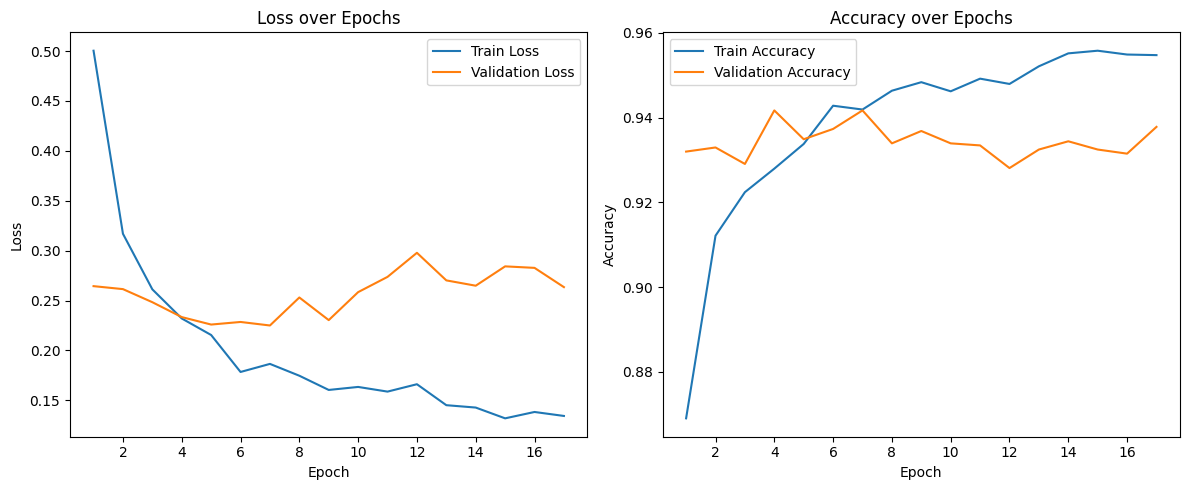

In [ ]:
trained_model = train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    num_epochs=NUM_EPOCHS,
    device=DEVICE,
    model_name='cnn_transformer_hybrid_3nd_crossvall',
    save_dir='drive/MyDrive/',
    patience=10
)

In [ ]:
criterion = nn.CrossEntropyLoss()
test_loss, test_acc = evaluate_test(model, test_loader, criterion, DEVICE)

Evaluating Test Set:   1%|          | 1/129 [00:28<1:01:31, 28.84s/it]

torch.Size([32, 2048])


Evaluating Test Set:   2%|▏         | 2/129 [00:55<58:20, 27.57s/it]  

torch.Size([32, 2048])


Evaluating Test Set:   2%|▏         | 3/129 [01:20<55:50, 26.59s/it]

torch.Size([32, 2048])


Evaluating Test Set:   3%|▎         | 4/129 [01:47<55:46, 26.77s/it]

torch.Size([32, 2048])


Evaluating Test Set:   4%|▍         | 5/129 [02:14<55:09, 26.69s/it]

torch.Size([32, 2048])


Evaluating Test Set:   5%|▍         | 6/129 [02:39<53:49, 26.26s/it]

torch.Size([32, 2048])


Evaluating Test Set:   5%|▌         | 7/129 [03:05<52:50, 25.99s/it]

torch.Size([32, 2048])


Evaluating Test Set:   6%|▌         | 8/129 [03:30<51:58, 25.77s/it]

torch.Size([32, 2048])


Evaluating Test Set:   7%|▋         | 9/129 [03:56<51:37, 25.81s/it]

torch.Size([32, 2048])


Evaluating Test Set:   8%|▊         | 10/129 [04:22<51:22, 25.90s/it]

torch.Size([32, 2048])


Evaluating Test Set:   9%|▊         | 11/129 [04:49<51:36, 26.24s/it]

torch.Size([32, 2048])


Evaluating Test Set:   9%|▉         | 12/129 [05:17<52:08, 26.74s/it]

torch.Size([32, 2048])


Evaluating Test Set:  10%|█         | 13/129 [05:43<51:06, 26.43s/it]

torch.Size([32, 2048])


Evaluating Test Set:  11%|█         | 14/129 [06:09<50:37, 26.41s/it]

torch.Size([32, 2048])


Evaluating Test Set:  12%|█▏        | 15/129 [06:35<50:04, 26.35s/it]

torch.Size([32, 2048])


Evaluating Test Set:  12%|█▏        | 16/129 [07:02<49:53, 26.49s/it]

torch.Size([32, 2048])


Evaluating Test Set:  13%|█▎        | 17/129 [07:29<49:44, 26.64s/it]

torch.Size([32, 2048])


Evaluating Test Set:  14%|█▍        | 18/129 [07:53<47:57, 25.92s/it]

torch.Size([32, 2048])


Evaluating Test Set:  15%|█▍        | 19/129 [08:20<47:58, 26.17s/it]

torch.Size([32, 2048])


Evaluating Test Set:  16%|█▌        | 20/129 [08:47<47:53, 26.37s/it]

torch.Size([32, 2048])


Evaluating Test Set:  16%|█▋        | 21/129 [09:13<47:02, 26.14s/it]

torch.Size([32, 2048])


Evaluating Test Set:  17%|█▋        | 22/129 [09:39<46:36, 26.14s/it]

torch.Size([32, 2048])


Evaluating Test Set:  18%|█▊        | 23/129 [10:04<45:56, 26.00s/it]

torch.Size([32, 2048])


Evaluating Test Set:  19%|█▊        | 24/129 [10:31<45:51, 26.21s/it]

torch.Size([32, 2048])


Evaluating Test Set:  19%|█▉        | 25/129 [10:58<45:34, 26.29s/it]

torch.Size([32, 2048])


Evaluating Test Set:  20%|██        | 26/129 [11:23<44:52, 26.14s/it]

torch.Size([32, 2048])


Evaluating Test Set:  21%|██        | 27/129 [11:49<44:20, 26.09s/it]

torch.Size([32, 2048])


Evaluating Test Set:  22%|██▏       | 28/129 [12:16<44:04, 26.19s/it]

torch.Size([32, 2048])


Evaluating Test Set:  22%|██▏       | 29/129 [12:43<44:06, 26.47s/it]

torch.Size([32, 2048])


Evaluating Test Set:  23%|██▎       | 30/129 [13:09<43:22, 26.29s/it]

torch.Size([32, 2048])


Evaluating Test Set:  24%|██▍       | 31/129 [13:35<43:00, 26.33s/it]

torch.Size([32, 2048])


Evaluating Test Set:  25%|██▍       | 32/129 [14:03<43:06, 26.66s/it]

torch.Size([32, 2048])


Evaluating Test Set:  26%|██▌       | 33/129 [14:30<43:02, 26.90s/it]

torch.Size([32, 2048])


Evaluating Test Set:  26%|██▋       | 34/129 [14:57<42:31, 26.86s/it]

torch.Size([32, 2048])


Evaluating Test Set:  27%|██▋       | 35/129 [15:24<42:25, 27.08s/it]

torch.Size([32, 2048])


Evaluating Test Set:  28%|██▊       | 36/129 [15:51<41:38, 26.87s/it]

torch.Size([32, 2048])


Evaluating Test Set:  29%|██▊       | 37/129 [16:16<40:21, 26.32s/it]

torch.Size([32, 2048])


Evaluating Test Set:  29%|██▉       | 38/129 [16:42<39:46, 26.23s/it]

torch.Size([32, 2048])


Evaluating Test Set:  30%|███       | 39/129 [17:09<39:41, 26.47s/it]

torch.Size([32, 2048])


Evaluating Test Set:  31%|███       | 40/129 [17:37<39:56, 26.92s/it]

torch.Size([32, 2048])


Evaluating Test Set:  32%|███▏      | 41/129 [18:04<39:30, 26.94s/it]

torch.Size([32, 2048])


Evaluating Test Set:  33%|███▎      | 42/129 [18:31<38:59, 26.89s/it]

torch.Size([32, 2048])


Evaluating Test Set:  33%|███▎      | 43/129 [18:58<38:46, 27.05s/it]

torch.Size([32, 2048])


Evaluating Test Set:  34%|███▍      | 44/129 [19:25<38:04, 26.88s/it]

torch.Size([32, 2048])


Evaluating Test Set:  35%|███▍      | 45/129 [19:51<37:23, 26.71s/it]

torch.Size([32, 2048])


Evaluating Test Set:  36%|███▌      | 46/129 [20:18<36:57, 26.72s/it]

torch.Size([32, 2048])


Evaluating Test Set:  36%|███▋      | 47/129 [20:44<36:15, 26.53s/it]

torch.Size([32, 2048])


Evaluating Test Set:  37%|███▋      | 48/129 [21:09<35:20, 26.18s/it]

torch.Size([32, 2048])


Evaluating Test Set:  38%|███▊      | 49/129 [21:36<35:19, 26.49s/it]

torch.Size([32, 2048])


Evaluating Test Set:  39%|███▉      | 50/129 [22:06<36:20, 27.60s/it]

torch.Size([32, 2048])


Evaluating Test Set:  40%|███▉      | 51/129 [22:33<35:37, 27.41s/it]

torch.Size([32, 2048])


Evaluating Test Set:  40%|████      | 52/129 [23:00<34:51, 27.17s/it]

torch.Size([32, 2048])


Evaluating Test Set:  41%|████      | 53/129 [23:26<34:06, 26.93s/it]

torch.Size([32, 2048])


Evaluating Test Set:  42%|████▏     | 54/129 [23:53<33:21, 26.69s/it]

torch.Size([32, 2048])


Evaluating Test Set:  43%|████▎     | 55/129 [24:19<32:47, 26.59s/it]

torch.Size([32, 2048])


Evaluating Test Set:  43%|████▎     | 56/129 [24:44<31:56, 26.26s/it]

torch.Size([32, 2048])


Evaluating Test Set:  44%|████▍     | 57/129 [25:10<31:17, 26.08s/it]

torch.Size([32, 2048])


Evaluating Test Set:  45%|████▍     | 58/129 [25:37<31:18, 26.45s/it]

torch.Size([32, 2048])


Evaluating Test Set:  46%|████▌     | 59/129 [26:04<30:59, 26.56s/it]

torch.Size([32, 2048])


Evaluating Test Set:  47%|████▋     | 60/129 [26:32<30:55, 26.89s/it]

torch.Size([32, 2048])


Evaluating Test Set:  47%|████▋     | 61/129 [26:58<30:13, 26.67s/it]

torch.Size([32, 2048])


Evaluating Test Set:  48%|████▊     | 62/129 [27:26<30:11, 27.04s/it]

torch.Size([32, 2048])


Evaluating Test Set:  49%|████▉     | 63/129 [27:53<29:47, 27.09s/it]

torch.Size([32, 2048])


Evaluating Test Set:  50%|████▉     | 64/129 [28:18<28:46, 26.57s/it]

torch.Size([32, 2048])


Evaluating Test Set:  50%|█████     | 65/129 [28:45<28:25, 26.65s/it]

torch.Size([32, 2048])


Evaluating Test Set:  51%|█████     | 66/129 [29:11<27:48, 26.48s/it]

torch.Size([32, 2048])


Evaluating Test Set:  52%|█████▏    | 67/129 [29:39<27:44, 26.85s/it]

torch.Size([32, 2048])


Evaluating Test Set:  53%|█████▎    | 68/129 [30:07<27:31, 27.07s/it]

torch.Size([32, 2048])


Evaluating Test Set:  53%|█████▎    | 69/129 [30:33<26:54, 26.90s/it]

torch.Size([32, 2048])


Evaluating Test Set:  54%|█████▍    | 70/129 [31:00<26:26, 26.89s/it]

torch.Size([32, 2048])


Evaluating Test Set:  55%|█████▌    | 71/129 [31:26<25:41, 26.59s/it]

torch.Size([32, 2048])


Evaluating Test Set:  56%|█████▌    | 72/129 [31:53<25:19, 26.65s/it]

torch.Size([32, 2048])


Evaluating Test Set:  57%|█████▋    | 73/129 [32:19<24:45, 26.52s/it]

torch.Size([32, 2048])


Evaluating Test Set:  57%|█████▋    | 74/129 [32:45<24:10, 26.37s/it]

torch.Size([32, 2048])


Evaluating Test Set:  58%|█████▊    | 75/129 [33:12<23:47, 26.43s/it]

torch.Size([32, 2048])


Evaluating Test Set:  59%|█████▉    | 76/129 [33:38<23:16, 26.36s/it]

torch.Size([32, 2048])


Evaluating Test Set:  60%|█████▉    | 77/129 [34:04<22:51, 26.38s/it]

torch.Size([32, 2048])


Evaluating Test Set:  60%|██████    | 78/129 [34:31<22:30, 26.48s/it]

torch.Size([32, 2048])


Evaluating Test Set:  61%|██████    | 79/129 [34:58<22:12, 26.64s/it]

torch.Size([32, 2048])


Evaluating Test Set:  62%|██████▏   | 80/129 [35:25<21:52, 26.78s/it]

torch.Size([32, 2048])


Evaluating Test Set:  63%|██████▎   | 81/129 [35:51<21:18, 26.63s/it]

torch.Size([32, 2048])


Evaluating Test Set:  64%|██████▎   | 82/129 [36:18<20:56, 26.74s/it]

torch.Size([32, 2048])


Evaluating Test Set:  64%|██████▍   | 83/129 [36:44<20:20, 26.54s/it]

torch.Size([32, 2048])


Evaluating Test Set:  65%|██████▌   | 84/129 [37:11<20:00, 26.68s/it]

torch.Size([32, 2048])


Evaluating Test Set:  66%|██████▌   | 85/129 [37:38<19:37, 26.77s/it]

torch.Size([32, 2048])


Evaluating Test Set:  67%|██████▋   | 86/129 [38:04<18:53, 26.35s/it]

torch.Size([32, 2048])


Evaluating Test Set:  67%|██████▋   | 87/129 [38:30<18:23, 26.27s/it]

torch.Size([32, 2048])


Evaluating Test Set:  68%|██████▊   | 88/129 [38:56<17:58, 26.31s/it]

torch.Size([32, 2048])


Evaluating Test Set:  69%|██████▉   | 89/129 [39:25<17:58, 26.97s/it]

torch.Size([32, 2048])


Evaluating Test Set:  70%|██████▉   | 90/129 [39:51<17:23, 26.75s/it]

torch.Size([32, 2048])


Evaluating Test Set:  71%|███████   | 91/129 [40:18<16:57, 26.77s/it]

torch.Size([32, 2048])


Evaluating Test Set:  71%|███████▏  | 92/129 [40:43<16:15, 26.36s/it]

torch.Size([32, 2048])


Evaluating Test Set:  72%|███████▏  | 93/129 [41:10<15:52, 26.46s/it]

torch.Size([32, 2048])


Evaluating Test Set:  73%|███████▎  | 94/129 [41:36<15:21, 26.33s/it]

torch.Size([32, 2048])


Evaluating Test Set:  74%|███████▎  | 95/129 [42:02<14:53, 26.29s/it]

torch.Size([32, 2048])


Evaluating Test Set:  74%|███████▍  | 96/129 [42:28<14:23, 26.17s/it]

torch.Size([32, 2048])


Evaluating Test Set:  75%|███████▌  | 97/129 [42:55<14:02, 26.33s/it]

torch.Size([32, 2048])


Evaluating Test Set:  76%|███████▌  | 98/129 [43:20<13:22, 25.90s/it]

torch.Size([32, 2048])


Evaluating Test Set:  77%|███████▋  | 99/129 [43:46<13:04, 26.15s/it]

torch.Size([32, 2048])


Evaluating Test Set:  78%|███████▊  | 100/129 [44:12<12:36, 26.10s/it]

torch.Size([32, 2048])


Evaluating Test Set:  78%|███████▊  | 101/129 [44:39<12:18, 26.38s/it]

torch.Size([32, 2048])


Evaluating Test Set:  79%|███████▉  | 102/129 [45:05<11:45, 26.13s/it]

torch.Size([32, 2048])


Evaluating Test Set:  80%|███████▉  | 103/129 [45:31<11:21, 26.21s/it]

torch.Size([32, 2048])


Evaluating Test Set:  81%|████████  | 104/129 [45:57<10:51, 26.05s/it]

torch.Size([32, 2048])


Evaluating Test Set:  81%|████████▏ | 105/129 [46:23<10:23, 25.99s/it]

torch.Size([32, 2048])


Evaluating Test Set:  82%|████████▏ | 106/129 [46:50<10:02, 26.21s/it]

torch.Size([32, 2048])


Evaluating Test Set:  83%|████████▎ | 107/129 [47:16<09:35, 26.16s/it]

torch.Size([32, 2048])


Evaluating Test Set:  84%|████████▎ | 108/129 [47:42<09:12, 26.30s/it]

torch.Size([32, 2048])


Evaluating Test Set:  84%|████████▍ | 109/129 [48:08<08:46, 26.31s/it]

torch.Size([32, 2048])


Evaluating Test Set:  85%|████████▌ | 110/129 [48:35<08:20, 26.36s/it]

torch.Size([32, 2048])


Evaluating Test Set:  86%|████████▌ | 111/129 [49:02<07:59, 26.66s/it]

torch.Size([32, 2048])


Evaluating Test Set:  87%|████████▋ | 112/129 [49:29<07:32, 26.59s/it]

torch.Size([32, 2048])


Evaluating Test Set:  88%|████████▊ | 113/129 [49:55<07:05, 26.57s/it]

torch.Size([32, 2048])


Evaluating Test Set:  88%|████████▊ | 114/129 [50:22<06:41, 26.76s/it]

torch.Size([32, 2048])


Evaluating Test Set:  89%|████████▉ | 115/129 [50:49<06:12, 26.63s/it]

torch.Size([32, 2048])


Evaluating Test Set:  90%|████████▉ | 116/129 [51:14<05:41, 26.30s/it]

torch.Size([32, 2048])


Evaluating Test Set:  91%|█████████ | 117/129 [51:41<05:16, 26.36s/it]

torch.Size([32, 2048])


Evaluating Test Set:  91%|█████████▏| 118/129 [52:08<04:53, 26.66s/it]

torch.Size([32, 2048])


Evaluating Test Set:  92%|█████████▏| 119/129 [52:36<04:28, 26.89s/it]

torch.Size([32, 2048])


Evaluating Test Set:  93%|█████████▎| 120/129 [53:02<03:59, 26.61s/it]

torch.Size([32, 2048])


Evaluating Test Set:  94%|█████████▍| 121/129 [53:28<03:32, 26.58s/it]

torch.Size([32, 2048])


Evaluating Test Set:  95%|█████████▍| 122/129 [53:55<03:06, 26.67s/it]

torch.Size([32, 2048])


Evaluating Test Set:  95%|█████████▌| 123/129 [54:21<02:39, 26.55s/it]

torch.Size([32, 2048])


Evaluating Test Set:  96%|█████████▌| 124/129 [54:48<02:12, 26.54s/it]

torch.Size([32, 2048])


Evaluating Test Set:  97%|█████████▋| 125/129 [55:14<01:45, 26.42s/it]

torch.Size([32, 2048])


Evaluating Test Set:  98%|█████████▊| 126/129 [55:41<01:20, 26.75s/it]

torch.Size([32, 2048])


Evaluating Test Set:  98%|█████████▊| 127/129 [56:09<00:53, 26.91s/it]

torch.Size([32, 2048])


Evaluating Test Set:  99%|█████████▉| 128/129 [56:35<00:26, 26.82s/it]

torch.Size([32, 2048])


Evaluating Test Set: 100%|██████████| 129/129 [56:51<00:00, 26.45s/it]

torch.Size([20, 2048])
Test Loss: 0.2645, Test Accuracy: 0.9334


# Train and test the model with multiple transfomer Block and Label Smotthing Loss

[Epoch 1/20] Validation: 100%|██████████| 65/65 [09:31<00:00,  8.79s/it]


Epoch 1 | Train Loss: 1.4062, Train Acc: 0.8632 | Val Loss: 1.2043, Val Acc: 0.9038
Validation loss improved to 1.2043. Saving model to drive/MyDrive/cnn_transformer_hybrid_optimized_best_model.pt


[Epoch 2/20] Validation: 100%|██████████| 65/65 [00:09<00:00,  6.93it/s]


Epoch 2 | Train Loss: 1.1669, Train Acc: 0.9120 | Val Loss: 1.1554, Val Acc: 0.9091
Validation loss improved to 1.1554. Saving model to drive/MyDrive/cnn_transformer_hybrid_optimized_best_model.pt


[Epoch 3/20] Validation: 100%|██████████| 65/65 [00:09<00:00,  7.18it/s]


Epoch 3 | Train Loss: 1.1150, Train Acc: 0.9236 | Val Loss: 1.1139, Val Acc: 0.9208
Validation loss improved to 1.1139. Saving model to drive/MyDrive/cnn_transformer_hybrid_optimized_best_model.pt


[Epoch 4/20] Validation: 100%|██████████| 65/65 [00:09<00:00,  7.11it/s]


Epoch 4 | Train Loss: 1.0787, Train Acc: 0.9302 | Val Loss: 1.1088, Val Acc: 0.9281
Validation loss improved to 1.1088. Saving model to drive/MyDrive/cnn_transformer_hybrid_optimized_best_model.pt


[Epoch 5/20] Validation: 100%|██████████| 65/65 [00:09<00:00,  7.00it/s]


Epoch 5 | Train Loss: 1.0497, Train Acc: 0.9374 | Val Loss: 1.0824, Val Acc: 0.9305
Validation loss improved to 1.0824. Saving model to drive/MyDrive/cnn_transformer_hybrid_optimized_best_model.pt


[Epoch 6/20] Validation: 100%|██████████| 65/65 [00:09<00:00,  6.98it/s]


Epoch 6 | Train Loss: 1.0315, Train Acc: 0.9411 | Val Loss: 1.0680, Val Acc: 0.9266
Validation loss improved to 1.0680. Saving model to drive/MyDrive/cnn_transformer_hybrid_optimized_best_model.pt


[Epoch 7/20] Validation: 100%|██████████| 65/65 [00:09<00:00,  7.08it/s]


Epoch 7 | Train Loss: 1.0263, Train Acc: 0.9422 | Val Loss: 1.0692, Val Acc: 0.9305
No improvement in validation loss for 1/10 epochs.


[Epoch 8/20] Validation: 100%|██████████| 65/65 [00:09<00:00,  7.04it/s]


Epoch 8 | Train Loss: 1.0002, Train Acc: 0.9511 | Val Loss: 1.0563, Val Acc: 0.9334
Validation loss improved to 1.0563. Saving model to drive/MyDrive/cnn_transformer_hybrid_optimized_best_model.pt


[Epoch 9/20] Validation: 100%|██████████| 65/65 [00:09<00:00,  6.98it/s]


Epoch 9 | Train Loss: 1.0022, Train Acc: 0.9500 | Val Loss: 1.0777, Val Acc: 0.9276
No improvement in validation loss for 1/10 epochs.


[Epoch 10/20] Validation: 100%|██████████| 65/65 [00:09<00:00,  7.15it/s]


Epoch 10 | Train Loss: 0.9867, Train Acc: 0.9543 | Val Loss: 1.0421, Val Acc: 0.9349
Validation loss improved to 1.0421. Saving model to drive/MyDrive/cnn_transformer_hybrid_optimized_best_model.pt


[Epoch 11/20] Validation: 100%|██████████| 65/65 [00:09<00:00,  7.02it/s]


Epoch 11 | Train Loss: 0.9866, Train Acc: 0.9518 | Val Loss: 1.0244, Val Acc: 0.9388
Validation loss improved to 1.0244. Saving model to drive/MyDrive/cnn_transformer_hybrid_optimized_best_model.pt


[Epoch 12/20] Validation: 100%|██████████| 65/65 [00:09<00:00,  7.06it/s]


Epoch 12 | Train Loss: 0.9717, Train Acc: 0.9593 | Val Loss: 1.0422, Val Acc: 0.9383
No improvement in validation loss for 1/10 epochs.


[Epoch 13/20] Validation: 100%|██████████| 65/65 [00:09<00:00,  7.07it/s]


Epoch 13 | Train Loss: 0.9727, Train Acc: 0.9568 | Val Loss: 1.0331, Val Acc: 0.9315
No improvement in validation loss for 2/10 epochs.


[Epoch 14/20] Validation: 100%|██████████| 65/65 [00:09<00:00,  7.08it/s]


Epoch 14 | Train Loss: 0.9587, Train Acc: 0.9593 | Val Loss: 1.0452, Val Acc: 0.9354
No improvement in validation loss for 3/10 epochs.


[Epoch 15/20] Validation: 100%|██████████| 65/65 [00:09<00:00,  6.91it/s]


Epoch 15 | Train Loss: 0.9604, Train Acc: 0.9609 | Val Loss: 1.0337, Val Acc: 0.9325
No improvement in validation loss for 4/10 epochs.


[Epoch 16/20] Validation: 100%|██████████| 65/65 [00:09<00:00,  7.05it/s]


Epoch 16 | Train Loss: 0.9495, Train Acc: 0.9638 | Val Loss: 1.0414, Val Acc: 0.9320
No improvement in validation loss for 5/10 epochs.


[Epoch 17/20] Validation: 100%|██████████| 65/65 [00:09<00:00,  7.13it/s]


Epoch 17 | Train Loss: 0.9495, Train Acc: 0.9648 | Val Loss: 1.0343, Val Acc: 0.9344
No improvement in validation loss for 6/10 epochs.


[Epoch 18/20] Validation: 100%|██████████| 65/65 [00:09<00:00,  7.12it/s]


Epoch 18 | Train Loss: 0.9432, Train Acc: 0.9647 | Val Loss: 1.0405, Val Acc: 0.9310
No improvement in validation loss for 7/10 epochs.


[Epoch 19/20] Validation: 100%|██████████| 65/65 [00:09<00:00,  7.08it/s]


Epoch 19 | Train Loss: 0.9357, Train Acc: 0.9665 | Val Loss: 1.0383, Val Acc: 0.9354
No improvement in validation loss for 8/10 epochs.


[Epoch 20/20] Validation: 100%|██████████| 65/65 [00:09<00:00,  7.05it/s]


Epoch 20 | Train Loss: 0.9364, Train Acc: 0.9661 | Val Loss: 1.0268, Val Acc: 0.9363
No improvement in validation loss for 9/10 epochs.
Training plot saved to drive/MyDrive/training_plot.png


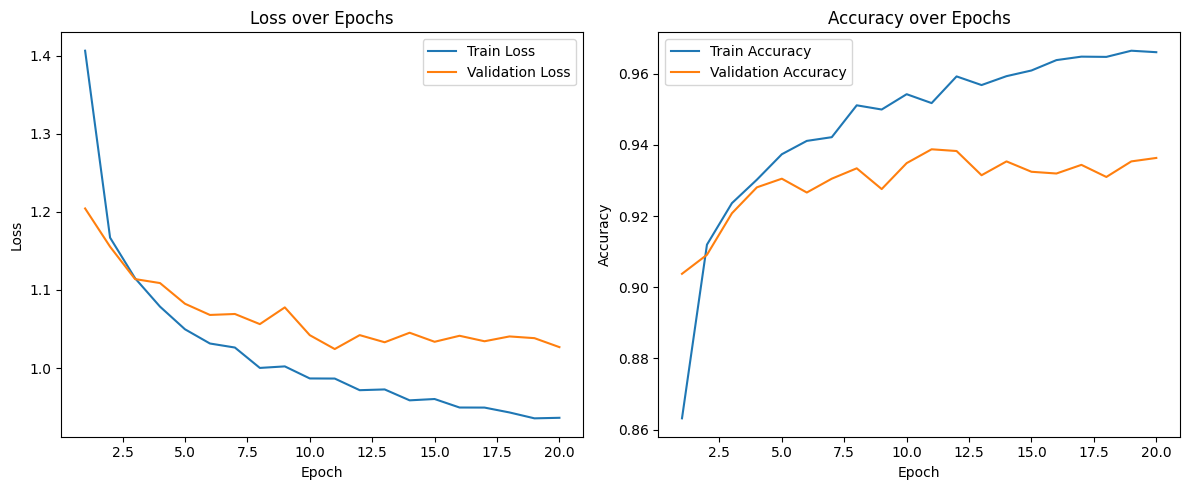

In [ ]:
trained_model = train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    num_epochs=NUM_EPOCHS,
    device=DEVICE,
    model_name='cnn_transformer_hybrid_optimized',
    save_dir='drive/MyDrive/',
    patience=10
)

In [ ]:
criterion = LabelSmoothingCrossEntropy(smoothing=0.1)
test_loss, test_acc = evaluate_test(model, test_loader, criterion, DEVICE)

Evaluating Test Set: 100%|██████████| 129/129 [19:52<00:00,  9.25s/it]

Test Loss: 1.0518, Test Accuracy: 0.9346


# Class Distribution Visualization

In [ ]:
from collections import Counter
import matplotlib.pyplot as plt

def fast_count_classes(data, labels_r, dataset_name="Dataset"):
    class_counts = Counter()

    for _, label in data:
        class_counts[label] += 1

    # Sort by label
    sorted_counts = dict(sorted(class_counts.items()))
    class_names = [labels_r[i] for i in sorted_counts.keys()]
    counts = list(sorted_counts.values())

    # Find min and max for the specific data
    min_label = min(sorted_counts, key=sorted_counts.get)
    max_label = max(sorted_counts, key=sorted_counts.get)
    min_count = sorted_counts[min_label]
    max_count = sorted_counts[max_label]
    min_breed = labels_r[min_label]
    max_breed = labels_r[max_label]

    # Print sample counts
    print(f"\nSample counts in {dataset_name}:")
    for name, count in zip(class_names, counts):
        print(f"{name:<30}: {count}")

    print(f"\n🐶 Breed with lowest count in {dataset_name}: {min_breed} ({min_count} samples)")
    print(f"🐕 Breed with highest count in {dataset_name}: {max_breed} ({max_count} samples)")

    # Plot
    plt.figure(figsize=(20, 5))
    plt.bar(range(len(class_names)), counts)
    plt.title(f"Class Distribution in {dataset_name}")
    plt.xlabel("Dog Breeds")
    plt.ylabel("Number of Samples")
    plt.xticks(ticks=range(len(class_names)), labels=class_names, rotation=90, fontsize=6)
    plt.tight_layout()
    plt.show()




Sample counts in Train:
n02085620-Chihuahua           : 118
n02085782-Japanese_spaniel    : 129
n02085936-Maltese_dog         : 169
n02086079-Pekinese            : 108
n02086240-Shih-Tzu            : 138
n02086646-Blenheim_spaniel    : 131
n02086910-papillon            : 145
n02087046-toy_terrier         : 125
n02087394-Rhodesian_ridgeback : 123
n02088094-Afghan_hound        : 159
n02088238-basset              : 110
n02088364-beagle              : 126
n02088466-bloodhound          : 138
n02088632-bluetick            : 123
n02089078-black-and-tan_coonhound: 115
n02089867-Walker_hound        : 104
n02089973-English_foxhound    : 119
n02090379-redbone             : 105
n02090622-borzoi              : 105
n02090721-Irish_wolfhound     : 152
n02091032-Italian_greyhound   : 113
n02091134-whippet             : 128
n02091244-Ibizan_hound        : 129
n02091467-Norwegian_elkhound  : 140
n02091635-otterhound          : 101
n02091831-Saluki              : 126
n02092002-Scottish_deerhound  : 153


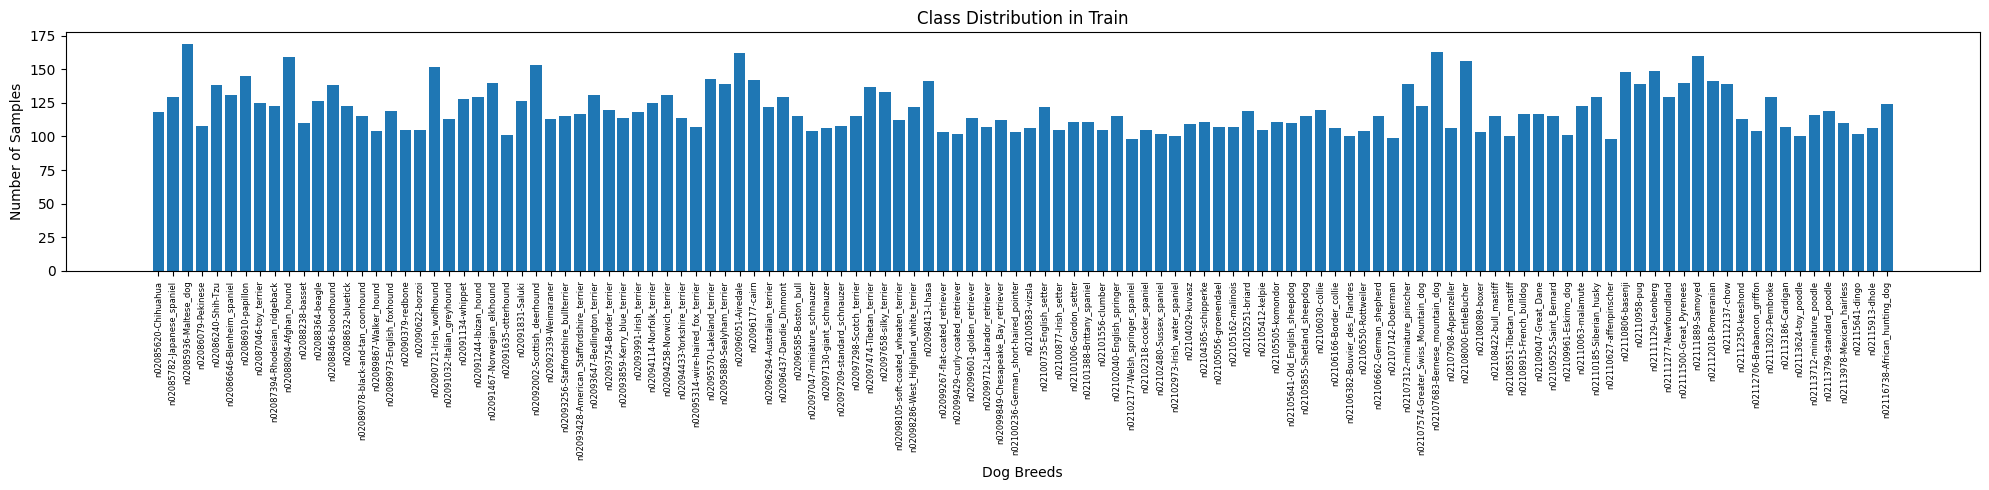

In [ ]:
fast_count_classes(train_data, labels_r, "Train")


Sample counts in Validation:
n02085620-Chihuahua           : 12
n02085782-Japanese_spaniel    : 24
n02085936-Maltese_dog         : 21
n02086079-Pekinese            : 13
n02086240-Shih-Tzu            : 27
n02086646-Blenheim_spaniel    : 17
n02086910-papillon            : 20
n02087046-toy_terrier         : 18
n02087394-Rhodesian_ridgeback : 12
n02088094-Afghan_hound        : 21
n02088238-basset              : 21
n02088364-beagle              : 28
n02088466-bloodhound          : 18
n02088632-bluetick            : 14
n02089078-black-and-tan_coonhound: 13
n02089867-Walker_hound        : 17
n02089973-English_foxhound    : 16
n02090379-redbone             : 17
n02090622-borzoi              : 10
n02090721-Irish_wolfhound     : 19
n02091032-Italian_greyhound   : 30
n02091134-whippet             : 23
n02091244-Ibizan_hound        : 14
n02091467-Norwegian_elkhound  : 22
n02091635-otterhound          : 18
n02091831-Saluki              : 27
n02092002-Scottish_deerhound  : 22
n02092339-Weimaraner  

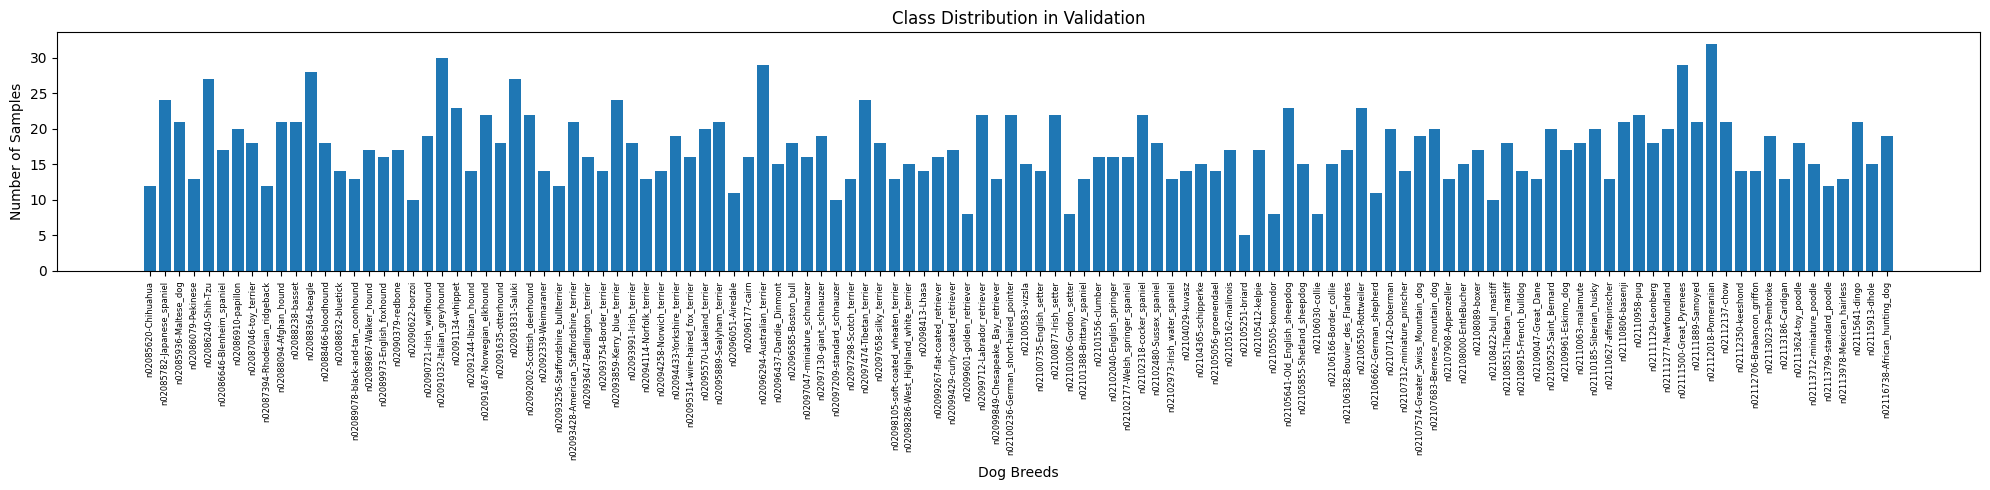

In [ ]:
fast_count_classes(val_data, labels_r, "Validation")


Sample counts in Test:
n02085620-Chihuahua           : 22
n02085782-Japanese_spaniel    : 32
n02085936-Maltese_dog         : 62
n02086079-Pekinese            : 28
n02086240-Shih-Tzu            : 49
n02086646-Blenheim_spaniel    : 40
n02086910-papillon            : 31
n02087046-toy_terrier         : 29
n02087394-Rhodesian_ridgeback : 37
n02088094-Afghan_hound        : 59
n02088238-basset              : 44
n02088364-beagle              : 41
n02088466-bloodhound          : 31
n02088632-bluetick            : 34
n02089078-black-and-tan_coonhound: 31
n02089867-Walker_hound        : 32
n02089973-English_foxhound    : 22
n02090379-redbone             : 26
n02090622-borzoi              : 36
n02090721-Irish_wolfhound     : 47
n02091032-Italian_greyhound   : 39
n02091134-whippet             : 36
n02091244-Ibizan_hound        : 45
n02091467-Norwegian_elkhound  : 34
n02091635-otterhound          : 32
n02091831-Saluki              : 47
n02092002-Scottish_deerhound  : 57
n02092339-Weimaraner        

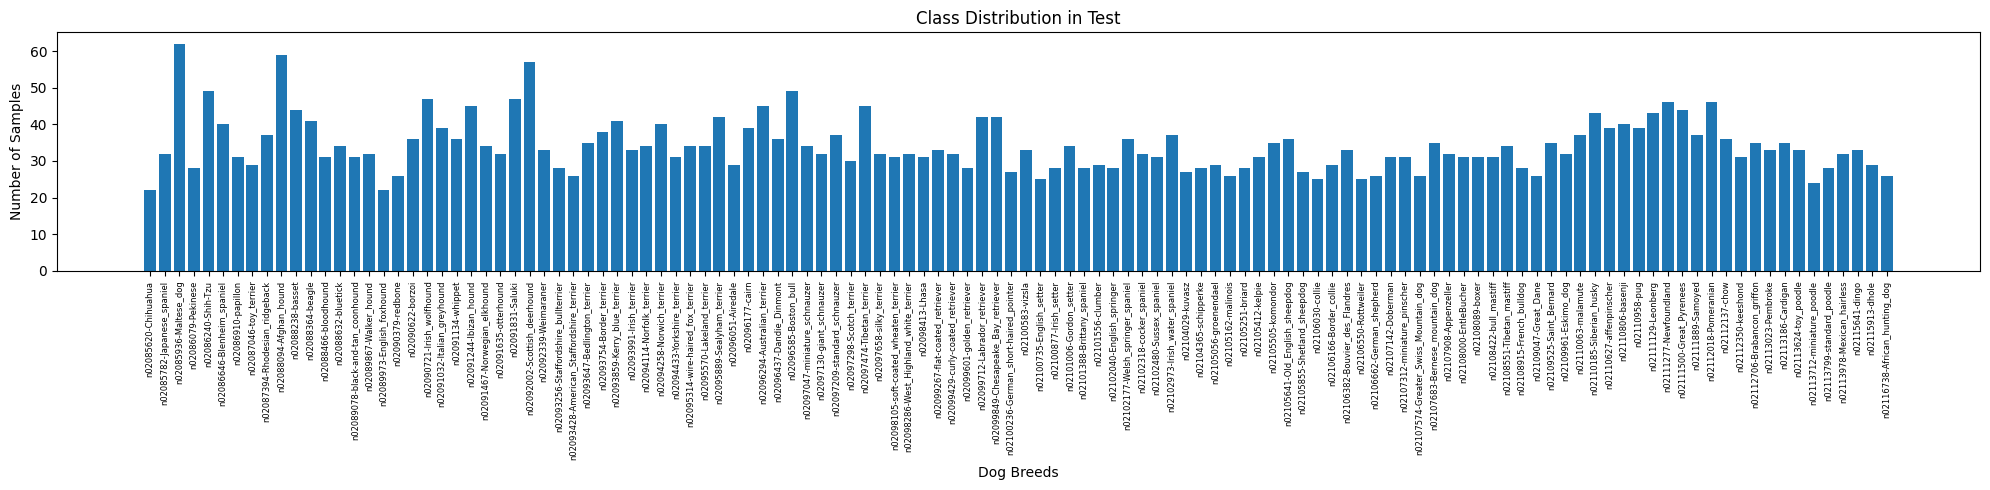

In [ ]:
fast_count_classes(test_data, labels_r, "Test")

In [ ]:
# Your Transformer block definition
class TransformerBlock(nn.Module):
    def __init__(self, dim, heads=8, ff_dim=2048, dropout=0.1):
        super().__init__()
        self.norm1 = nn.LayerNorm(dim)
        self.attn = nn.MultiheadAttention(embed_dim=dim, num_heads=heads, dropout=dropout, batch_first=True)
        self.norm2 = nn.LayerNorm(dim)
        self.ff = nn.Sequential(
            nn.Linear(dim, ff_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(ff_dim, dim)
        )

    def forward(self, x):
        x2, _ = self.attn(self.norm1(x), self.norm1(x), self.norm1(x))
        x = x + x2
        x2 = self.ff(self.norm2(x))
        return x + x2

# Helper function to get Xception as feature extractor
def get_xception_feature_extractor(weight_path):
    model = timm.create_model('xception', pretrained=False)
    state_dict = torch.load(weight_path, map_location=torch.device('cpu'))
    model.fc = nn.Identity()
    model.load_state_dict(state_dict, strict=False)
    model.eval()
    for param in model.parameters():
        param.requires_grad = False
    return model

# Your hybrid model
class CNNTransformerHybrid(nn.Module):
    def __init__(self, weight_path, num_classes=120, transformer_dim=2048, heads=8, ff_dim=4096, num_blocks=3):
        super().__init__()
        self.feature_extractor = get_xception_feature_extractor(weight_path)
        self.transformer_blocks = nn.Sequential(
            *[TransformerBlock(dim=transformer_dim, heads=heads, ff_dim=ff_dim) for _ in range(num_blocks)]
        )
        self.classifier = nn.Linear(transformer_dim, num_classes)

    def forward(self, x):
        with torch.no_grad():
            x = self.feature_extractor(x)

        if len(x.shape) == 4:
            b, c, h, w = x.shape
            x = rearrange(x, 'b c h w -> b (h w) c')
        else:
            b, c = x.shape
            x = rearrange(x, 'b c -> b 1 c')

        x = self.transformer_blocks(x)
        x = x.mean(dim=1)
        return self.classifier(x)

# -------------------------------
# Load the saved model checkpoint
# -------------------------------

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Paths
xception_weight_path = 'drive/MyDrive/xception.pt'  # Replace with your actual Xception weights path
checkpoint_path = '/content/drive/MyDrive/cnn_transformer_hybrid_optimized_best_model.pt'

# Instantiate the model
model = CNNTransformerHybrid(weight_path=xception_weight_path, num_classes=120)
model.to(device)

# Load the trained model weights
model.load_state_dict(torch.load(checkpoint_path, map_location=device))

# Set to evaluation mode
model.eval()

CNNTransformerHybrid(
  (feature_extractor): Xception(
    (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (act1): ReLU(inplace=True)
    (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (act2): ReLU(inplace=True)
    (block1): Block(
      (skip): Conv2d(64, 128, kernel_size=(1, 1), stride=(2, 2), bias=False)
      (skipbn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (rep): Sequential(
        (0): SeparableConv2d(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=64, bias=False)
          (pointwise): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        )
        (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    

In [ ]:
def visualize_random_predictions(model, test_loader, labels_r, device, num_images=10, global_title=None):
    import matplotlib.pyplot as plt
    import numpy as np
    import torch
    import random

    model.eval()

    # Gather all images and labels from the test loader
    all_imgs, all_labels = [], []
    for imgs, labels in test_loader:
        all_imgs.append(imgs)
        all_labels.append(labels)
    all_imgs = torch.cat(all_imgs, dim=0)
    all_labels = torch.cat(all_labels, dim=0)

    # Randomly sample indices
    indices = random.sample(range(len(all_imgs)), num_images)
    imgs = all_imgs[indices]
    true_labels = all_labels[indices]

    # Move data to the device
    imgs = imgs.to(device)
    true_labels = true_labels.argmax(dim=1).to(device)

    with torch.no_grad():
        outputs = model(imgs)
        probs = torch.softmax(outputs, dim=1)  # Get probabilities
        top_probs, top_classes = probs.topk(5, dim=1)  # Get top 5 predictions

    # Move data back to CPU for visualization
    imgs = imgs.cpu().permute(0, 2, 3, 1).numpy().astype(np.uint8)
    true_labels = true_labels.cpu().numpy()
    top_probs = top_probs.cpu().numpy()
    top_classes = top_classes.cpu().numpy()

    # Function to clean label names
    def clean_label(label):
        return label.split('-')[-1]  # Extract the part after the dash

    # Plotting
    fig, axes = plt.subplots(num_images // 2, 4, figsize=(12, 3 * (num_images // 2)))  # Compact figure size
    axes = axes.reshape(-1, 4)  # Ensure axes are handled as pairs (image, bar)

    for i in range(num_images):
        row, col_img, col_bar = i // 2, (i % 2) * 2, (i % 2) * 2 + 1
        img_ax = axes[row, col_img]
        bar_ax = axes[row, col_bar]

        # Display the image
        img_ax.imshow(imgs[i], interpolation="nearest")
        img_ax.axis('off')
        true_label = clean_label(labels_r[true_labels[i] + 1])  # Clean the true label
        img_ax.set_title(f"True: {true_label}", fontsize=8)

        # Display bar plot for top 5 predictions
        breed_names = [clean_label(labels_r[top_classes[i, j] + 1]) for j in range(5)]
        bar_ax.barh(breed_names, top_probs[i], color='skyblue')
        bar_ax.set_xlim(0, 1)
        bar_ax.set_xlabel("Probability", fontsize=6)
        bar_ax.set_title("Top 5 Predictions", fontsize=8)
        bar_ax.tick_params(axis="y", labelsize=6)

    # Add global title
    if global_title:
        plt.suptitle(global_title, fontsize=16, y=1.02)

    plt.subplots_adjust(wspace=0.4, hspace=0.6)  # Adjust spacing
    plt.tight_layout()
    plt.show()


In [ ]:
visualize_random_predictions(
    model=model,
    test_loader=test_loader,
    labels_r=labels_r,
    device=device,
    num_images=10,
    global_title="CNN-Transformer Hybrid's predictions"
)

KeyboardInterrupt: 